# irp-dbk24 - "Optimising Demand Response Strategies for Carbon-Intelligent Electricity Use"

# Developing Marginal Emissions Models

**NOTEBOOK PURPOSE(S):**
* Explore potential models for marginal emissions prediction besides the baseline model (quantile binning)

**LIMITATIONS:**

**NOTEBOOK OUTPUTS:**

    

## File Setup

### Importing Libraries

In [10]:
from __future__ import annotations

# ────────────────────────────────────────────────────────────────────────────
# Jupyter/Notebook Setup
# ────────────────────────────────────────────────────────────────────────────
%matplotlib inline
from IPython.display import display

# ────────────────────────────────────────────────────────────────────────────
# Standard Library
# ────────────────────────────────────────────────────────────────────────────
import binascii
import calendar
import hashlib
import inspect
import json
import logging
import math
import os
import random
import re
import ast
import sys
import time
from joblib import Parallel, delayed, parallel_backend
from contextlib import contextmanager
from copy import deepcopy
from dataclasses import dataclass, field
from datetime import datetime, timedelta
from functools import partial, reduce, wraps
from itertools import combinations, product, chain
from multiprocessing import Lock, Manager, Pool, cpu_count
from multiprocessing.pool import ThreadPool
from operator import add
from pathlib import Path
from typing import (
    Any, Callable, Dict, Iterable, List, Mapping, Optional,
    Sequence, Tuple, Union
)
from zoneinfo import ZoneInfo
from joblib import Memory


# ────────────────────────────────────────────────────────────────────────────
# Core Data Handling
# ────────────────────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import polars as pl

# ────────────────────────────────────────────────────────────────────────────
# Machine Learning & Statistics
# ────────────────────────────────────────────────────────────────────────────
from feature_engine.creation import CyclicalFeatures
from pygam import LinearGAM, l, s
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import kurtosis, skew, zscore, pearsonr, spearmanr
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import LinearRegression, RidgeCV, HuberRegressor, Ridge
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    root_mean_squared_error,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, SplineTransformer
from sklearn.utils.validation import check_is_fitted

# ────────────────────────────────────────────────────────────────────────────
# Visualization
# ────────────────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns

# ────────────────────────────────────────────────────────────────────────────
# Geospatial
# ────────────────────────────────────────────────────────────────────────────
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.wkb import loads
from pyproj import Proj, transform

### Global Config

In [11]:
# Global configuration (paths, seeds, options) — adjust as needed
RANDOM_SEED = 12
try:
    import random; random.seed(RANDOM_SEED)
except Exception:
    pass
try:
    import numpy as np; np.random.seed(RANDOM_SEED)
except Exception:
    pass

### Filepaths and Directories

In [12]:
# DIRECTORIES
base_data_directory = "data"
hitachi_data_directory = os.path.join(base_data_directory, "hitachi_copy")

marginal_emissions_development_directory = os.path.join(base_data_directory, "marginal_emissions_development")
marginal_emissions_results_directory = os.path.join(marginal_emissions_development_directory, "results")
marginal_emissions_logs_directory = os.path.join(marginal_emissions_development_directory, "logs")

marginal_emissions_prefix = "marginal_emissions_results"

In [13]:
# FILENAMES
base_file = "weather_and_grid_data_half-hourly_20250714_1401"

train_file = "marginal_emissions_estimation_20250714_1401_train_data"
validation_file = "marginal_emissions_estimation_20250714_1401_validation_data"
test_file = "marginal_emissions_estimation_20250714_1401_test_data"

In [14]:
# FILEPATHS
base_filepath = os.path.join(hitachi_data_directory, base_file + ".parquet")

train_filepath = os.path.join(marginal_emissions_development_directory, train_file + ".parquet")
validation_filepath = os.path.join(marginal_emissions_development_directory, validation_file + ".parquet")
test_filepath = os.path.join(marginal_emissions_development_directory, test_file + ".parquet")

#### Quick Look At Data

In [15]:
# Loading
base_pldf = pl.read_parquet(base_filepath)
train_pldf = pl.read_parquet(train_filepath)
validation_pldf = pl.read_parquet(validation_filepath)
test_pldf = pl.read_parquet(test_filepath)

In [16]:
# Temporal Boundaries
print("-"*120)
print("Time Boundaries of Data: \n"+ "-"*120)
print(f"Full Dataset :\t\tStart Time: {base_pldf['timestamp'].min()}\t\tEnd Time: {base_pldf['timestamp'].max()}\n")
print(f"Train Dataset :\t\tStart Time: {train_pldf['timestamp'].min()}\t\tEnd Time: {train_pldf['timestamp'].max()}")
print(f"Validation Dataset :\tStart Time: {validation_pldf['timestamp'].min()}\t\tEnd Time: {validation_pldf['timestamp'].max()}")
print(f"Test Dataset :\t\tStart Time: {test_pldf['timestamp'].min()}\t\tEnd Time: {test_pldf['timestamp'].max()}")


------------------------------------------------------------------------------------------------------------------------
Time Boundaries of Data: 
------------------------------------------------------------------------------------------------------------------------
Full Dataset :		Start Time: 2021-01-01 00:00:00+05:30		End Time: 2025-05-31 23:30:00+05:30

Train Dataset :		Start Time: 2021-01-01 00:00:00+05:30		End Time: 2023-12-31 23:30:00+05:30
Validation Dataset :	Start Time: 2024-01-01 00:00:00+05:30		End Time: 2024-05-31 23:30:00+05:30
Test Dataset :		Start Time: 2024-06-01 00:00:00+05:30		End Time: 2025-05-31 23:30:00+05:30


In [17]:
print("-"*120)
print("Schema \n"+ "-"*120)
display(train_pldf.schema)

------------------------------------------------------------------------------------------------------------------------
Schema 
------------------------------------------------------------------------------------------------------------------------


Schema([('timestamp', Datetime(time_unit='us', time_zone='Asia/Kolkata')),
        ('city', Categorical(ordering='physical')),
        ('land_latitude', Float64),
        ('land_longitude', Float64),
        ('wind_speed_mps', Float32),
        ('wind_direction_meteorological', Float32),
        ('temperature_celsius', Float64),
        ('precipitation_mm', Float64),
        ('surface_net_solar_radiation_kWh_per_m2', Float64),
        ('surface_solar_radiation_downwards_kWh_per_m2', Float64),
        ('surface_net_solar_radiation_joules_per_m2', Float64),
        ('surface_solar_radiation_downwards_joules_per_m2', Float64),
        ('total_cloud_cover', Float32),
        ('high_cloud_cover', Float32),
        ('medium_cloud_cover', Float32),
        ('low_cloud_cover', Float32),
        ('thermal_generation', Float64),
        ('gas_generation', Float64),
        ('hydro_generation', Float64),
        ('nuclear_generation', Float64),
        ('renewable_generation', Float64),
        (

In [18]:
print("-"*120)
print("Descriptive Statistics \n"+ "-"*120)
display(train_pldf.describe())

------------------------------------------------------------------------------------------------------------------------
Descriptive Statistics 
------------------------------------------------------------------------------------------------------------------------


shape: (9, 31)
┌────────────┬───────────┬─────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ statistic  ┆ timestamp ┆ city    ┆ land_lati ┆ … ┆ tons_co2_ ┆ wind_dir_ ┆ wind_dir_ ┆ wind_dir_ │
│ ---        ┆ ---       ┆ ---     ┆ tude      ┆   ┆ per_mwh   ┆ cardinal_ ┆ cardinal_ ┆ cardinal_ │
│ str        ┆ str       ┆ str     ┆ ---       ┆   ┆ ---       ┆ 8         ┆ 16        ┆ 4         │
│            ┆           ┆         ┆ f64       ┆   ┆ f64       ┆ ---       ┆ ---       ┆ ---       │
│            ┆           ┆         ┆           ┆   ┆           ┆ str       ┆ str       ┆ str       │
╞════════════╪═══════════╪═════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ count      ┆ 2365200   ┆ 2365200 ┆ 2.3652e6  ┆ … ┆ 2.3652e6  ┆ 2365200   ┆ 2365200   ┆ 2365200   │
│ null_count ┆ 0         ┆ 0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0         ┆ 0         ┆ 0         │
│ mean       ┆ 2022-07-0 ┆ null    ┆ 25.393333 ┆ … ┆ 0.737505  ┆ null      ┆ null      ┆ null      │
│            ┆ 2 11:45:0 ┆         ┆           ┆   ┆           ┆           ┆           ┆           │
│            ┆ 0+05:30   ┆         ┆           ┆   ┆           ┆           ┆           ┆           │
│ std        ┆ null      ┆ null    ┆ 4.538596  ┆ … ┆ 0.073446  ┆ null      ┆ null      ┆ null      │
│ min        ┆ 2021-01-0 ┆ null    ┆ 18.5      ┆ … ┆ 0.501631  ┆ E         ┆ E         ┆ E         │
│            ┆ 1 00:00:0 ┆         ┆           ┆   ┆           ┆           ┆           ┆           │
│            ┆ 0+05:30   ┆         ┆           ┆   ┆           ┆           ┆           ┆           │
│ 25%        ┆ 2021-10-0 ┆ null    ┆ 19.2      ┆ … ┆ 0.688786  ┆ null      ┆ null      ┆ null      │
│            ┆ 1 18:00:0 ┆         ┆           ┆   ┆           ┆           ┆           ┆           │
│            ┆ 0+05:30   ┆         ┆           ┆   ┆           ┆           ┆           ┆           │
│ 50%        ┆ 2022-07-0 ┆ null    ┆ 28.5      ┆ … ┆ 0.736897  ┆ null      ┆ null      ┆ null      │
│            ┆ 2 12:00:0 ┆         ┆           ┆   ┆           ┆           ┆           ┆           │
│            ┆ 0+05:30   ┆         ┆           ┆   ┆           ┆           ┆           ┆           │
│ 75%        ┆ 2023-04-0 ┆ null    ┆ 28.7      ┆ … ┆ 0.797797  ┆ null      ┆ null      ┆ null      │
│            ┆ 2 05:30:0 ┆         ┆           ┆   ┆           ┆           ┆           ┆           │
│            ┆ 0+05:30   ┆         ┆           ┆   ┆           ┆           ┆           ┆           │
│ max        ┆ 2023-12-3 ┆ null    ┆ 28.8      ┆ … ┆ 0.905092  ┆ W         ┆ WSW       ┆ W         │
│            ┆ 1 23:30:0 ┆         ┆           ┆   ┆           ┆           ┆           ┆           │
│            ┆ 0+05:30   ┆         ┆           ┆   ┆           ┆           ┆           ┆           │
└────────────┴───────────┴─────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

## Functions

### Utilities

#### General

In [19]:
def _sum_terms(terms):
    return reduce(add, terms)

In [20]:
def _file_size_mb(path: Path) -> float:
    """
    Return size of `path` in MiB. If file doesn't exist, returns 0.0.

    Parameters
    ----------
    path : Path
        Path to the file.

    Returns
    -------
    float
        Size of the file in MiB.
    """
    p = Path(path)
    if not p.exists():
        return 0.0
    return p.stat().st_size / (1024 * 1024.0)


#### CSV File Handling

In [21]:
def _drop_hash_from_part(
        part_path: Path,
        model_hash: str,
        *,
        chunk_size: int = 200_000,
        delete_if_empty: bool = False,
) -> int:
    """
    Remove rows with model_id_hash == `model_hash` from a CSV part file.

    - Streams in chunks (no huge memory spikes)
    - Writes to a temp file, then atomically replaces the original
    - Returns number of rows dropped
    - If all rows are dropped:
        • delete the file if `delete_if_empty=True`
        • otherwise keep a header-only CSV

    Parameters
    ----------
    part_path : Path
        CSV file to edit in place.
    model_hash : str
        Value to filter out from the 'model_id_hash' column.
    chunk_size : int, default 200_000
        Pandas read_csv chunk size.
    delete_if_empty : bool, default False
        If True and all rows are removed, delete the part file.

    Returns
    -------
    int
        Number of rows removed.
    """
    part_path = Path(part_path)
    if not part_path.exists():
        return 0

    # Quick header check
    try:
        header_df = pd.read_csv(part_path, nrows=0)
    except Exception:
        # Broken file — leave as-is
        return 0
    if "model_id_hash" not in header_df.columns:
        return 0

    dropped = 0
    kept = 0
    tmp_path = part_path.with_suffix(part_path.suffix + ".tmp")

    # Ensure no stale tmp
    if tmp_path.exists():
        try:
            tmp_path.unlink()
        except Exception:
            pass

    first_write = True
    try:
        for chunk in pd.read_csv(
            part_path,
            chunksize=chunk_size,
            dtype={"model_id_hash": "string"},  # force string, avoid numeric coercion
        ):
            if "model_id_hash" not in chunk.columns:
                # schema changed mid-file? abort safely
                dropped = 0
                kept = -1
                break
            mask = chunk["model_id_hash"] != model_hash
            kept_chunk = chunk.loc[mask]
            n_dropped = int((~mask).sum())
            dropped += n_dropped
            kept += int(mask.sum())

            if kept_chunk.empty:
                continue

            kept_chunk.to_csv(
                tmp_path,
                index=False,
                mode="w" if first_write else "a",
                header=first_write,
            )
            first_write = False

        # Nothing matched → no change
        if dropped == 0:
            if tmp_path.exists():
                # wrote identical content; discard temp
                try: tmp_path.unlink()
                except Exception: pass
            return 0

        # All rows removed
        if kept == 0:
            if delete_if_empty:
                # Delete original; remove temp if created
                try: part_path.unlink()
                except Exception: pass
                if tmp_path.exists():
                    try: tmp_path.unlink()
                    except Exception: pass
            else:
                # Replace with header-only CSV
                header_df.to_csv(tmp_path, index=False)
                os.replace(tmp_path, part_path)
            return dropped

        # Normal case: replace atomically
        os.replace(tmp_path, part_path)
        return dropped

    finally:
        # Best-effort cleanup
        if tmp_path.exists():
            try: os.remove(tmp_path)
            except Exception: pass


In [22]:
def is_model_logged_rotating_csv(
        model_hash: str,
        base_dir: str | Path,
        file_prefix: str
) -> bool:
    """
    Return True if `model_hash` appears in the rolling-log index for `file_prefix`.

    Parameters
    ----------
    model_hash : str
        The 'model_id_hash' value to look up.
    base_dir : str | Path
        Directory holding the rolling CSV parts and index.
    file_prefix : str
        Prefix of the rolling log.

    Returns
    -------
    bool
        True if present in the index; False otherwise.
    """
    idx = _read_index(_index_path(Path(base_dir), file_prefix))
    if idx.empty or "model_id_hash" not in idx.columns:
        return False
    return str(model_hash) in idx["model_id_hash"].astype("string").values

In [23]:
def _list_part_files(
        base_dir: Path,
        file_prefix: str,
        ext: str = "csv",
) -> list[Path]:
    """
    List existing rolling CSV parts for a given prefix, sorted by numeric part index.

    Parameters
    ----------
    base_dir : Path
        Directory to search.
    file_prefix : str
        Prefix of the rolling CSV set (e.g., 'marginal_emissions_log').
    ext : str, default 'csv'
        File extension (without dot).

    Returns
    -------
    list[Path]
        Sorted list of matching part files, e.g. [.../prefix.part000.csv, .../prefix.part001.csv, ...]
    """
    if not base_dir.exists():
        return []

    rx = re.compile(rf"^{re.escape(file_prefix)}\.part(\d+)\.{re.escape(ext)}$")
    parts: list[tuple[int, Path]] = []

    for p in base_dir.glob(f"{file_prefix}.part*.{ext}"):
        if not p.is_file():
            continue
        m = rx.match(p.name)
        if m:
            parts.append((int(m.group(1)), p))

    parts.sort(key=lambda t: t[0])
    return [p for _, p in parts]


In [24]:
def load_all_logs_rotating_csv(
        results_dir: str | Path = ".",
        file_prefix: str = "marginal_emissions_log",
) -> pd.DataFrame:
    """
    Read only parts referenced by the index; drop duplicate hashes (keep last).

    Parameters
    ----------
    results_dir: str | Path
        The directory containing the results.
    file_prefix: str
        The prefix of the log files to read.

    Returns
    -------
    pd.DataFrame
        The concatenated DataFrame containing the logs.
    """
    # Read the index file
    base_dir = Path(results_dir)
    idx = _read_index(_index_path(base_dir, file_prefix))
    # Check if the index is empty
    if idx.empty:
        return pd.DataFrame()
    # Get the unique parts to read
    parts = idx["part_file"].unique().tolist()
    # Read the parts into DataFrames
    dfs = [pd.read_csv(p) for p in parts if Path(p).exists()]
    # Check if any DataFrames were read
    if not dfs:
        return pd.DataFrame()
    # Concatenate the DataFrames
    out = pd.concat(dfs, ignore_index=True)
    # Drop duplicate model_id_hash entries
    if "model_id_hash" in out.columns:
        out = out.drop_duplicates(subset=["model_id_hash"], keep="last")
    return out


In [25]:
def _read_index(index_path: Path) -> pd.DataFrame:
    """
    Read the rolling-log index CSV (id→part mapping).

    Parameters
    ----------
    index_path : Path
        Path to '<file_prefix>_index.csv'.

    Returns
    -------
    pd.DataFrame
        Columns ['model_id_hash','part_file'] or empty frame if not found/invalid.
    """
    try:
        idx = pd.read_csv(index_path, dtype={"model_id_hash": "string", "part_file": "string"})
        if not {"model_id_hash","part_file"}.issubset(idx.columns):
            raise ValueError("Index missing required columns.")
        return idx
    except FileNotFoundError:
        return pd.DataFrame(columns=["model_id_hash","part_file"])
    except Exception:
        # Be permissive but return the expected schema
        return pd.DataFrame(columns=["model_id_hash","part_file"])


In [26]:
def remove_model_from_rotating_csv(
        model_hash: str,
        results_dir: str | Path = ".",
        file_prefix: str = "marginal_emissions_log",
) -> None:
    """
    Remove all rows with `model_id_hash == model_hash` from the rolling CSV set.

    Parameters
    ----------
    model_hash : str
        Identifier to remove.
    results_dir : str | Path, default "."
        Directory holding parts and index.
    file_prefix : str, default "marginal_emissions_log"
        Prefix of the rolling log files.
    """
    base_dir = _ensure_dir(Path(results_dir))
    idx_path = _index_path(base_dir, file_prefix)

    # Lock the index for the whole operation to avoid races with concurrent writers/readers
    with _file_lock(_index_lock_path(idx_path)):
        idx = _read_index(idx_path)
        if idx.empty:
            return

        # Drop from referenced part files
        for pf in idx.loc[idx["model_id_hash"] == model_hash, "part_file"].dropna().unique():
            _drop_hash_from_part(Path(pf), model_hash)

        # Update index
        idx = idx[idx["model_id_hash"] != model_hash]
        idx.to_csv(idx_path, index=False)


In [27]:
def save_summary_to_rotating_csv(
        summary_df: pd.DataFrame,
        results_dir: str | Path = ".",
        file_prefix: str = "marginal_emissions_log",
        max_mb: int = 95,
        force_overwrite: bool = False,
        naming: PartNaming | None = None,
        fsync: bool = False,
) -> Path:
    """
    Append a single-row summary to a rolling CSV (<prefix>.partNNN.csv) with strict rotation:
    - Per-file lock during append (prevents interleaved writes/duplicate headers)
    - Under-lock preflight ensures the write will NOT push the file over `max_mb`
      (allocates a new shard if necessary)
    - Atomic index update under lock

    Parameters
    ----------
    summary_df : pd.DataFrame
        Single-row DataFrame with at least a 'model_id_hash' column.
    results_dir : str | Path, default "."
        Directory to write parts and the index into.
    file_prefix : str, default "marginal_emissions_log"
        Prefix of the part files ('<prefix>.partNNN.csv').
    max_mb : int, default 95
        Rotate when current part would exceed this size (MiB) after the append.
    force_overwrite : bool, default False
        If True, delete existing rows with the same hash before appending.
    naming : PartNaming, optional
        Naming convention (token/width/ext). If provided, `ext` should include the dot
        (e.g., ".csv"). Internally we use the extension without the dot for matching.
    fsync : bool, default False
        If True, call fsync() on the file after writing to ensure data is flushed to disk.

    Returns
    -------
    Path
        The part file path that received the append.

    Raises
    ------
    ValueError
        If `summary_df` is empty or missing 'model_id_hash'.
    """
    if summary_df.empty:
        raise ValueError("summary_df is empty.")
    if "model_id_hash" not in summary_df.columns:
        raise ValueError("summary_df must contain 'model_id_hash'.")
    if len(summary_df) != 1:
        summary_df = summary_df.iloc[:1].copy()

    naming = naming or PartNaming()
    base_dir = _ensure_dir(Path(results_dir))
    idx_path = _index_path(base_dir, file_prefix)
    model_hash = str(summary_df["model_id_hash"].iloc[0])
    ext_nodot = naming.ext.lstrip(".")

    # Optional overwrite: remove old rows (parts + index)
    if force_overwrite:
        remove_model_from_rotating_csv(model_hash, base_dir, file_prefix)
    else:
        if is_model_logged_rotating_csv(model_hash, base_dir, file_prefix):
            print(f"[SKIP] Hash already indexed: {model_hash}")
            parts = _list_part_files(base_dir, file_prefix, ext=ext_nodot)
            return parts[-1] if parts else base_dir / naming.format(file_prefix, 0)

    # Determine candidate shard
    parts = _list_part_files(base_dir, file_prefix, ext=ext_nodot)
    if parts:
        target = parts[-1]
    else:
        target = allocate_next_part(base_dir, file_prefix, width=naming.width, ext=ext_nodot)

    threshold_bytes = int(max_mb * 1024 * 1024)

    # --- LOCK AND WRITE TO SHARD SAFELY ---
    while True:
        shard_lock = Path(str(target) + ".lock")
        with _file_lock(shard_lock):
            current_size = Path(target).stat().st_size if Path(target).exists() else 0
            write_header = (current_size == 0)
            csv_payload = summary_df.to_csv(index=False, header=write_header)
            payload_bytes = len(csv_payload.encode("utf-8"))

            if current_size + payload_bytes > threshold_bytes:
                # rotate: leave lock, allocate new shard, try again
                pass
            else:
                with open(target, "a", encoding="utf-8", newline="") as f:
                    f.write(csv_payload)
                    f.flush()
                    if fsync:
                        os.fsync(f.fileno())
                break

        target = allocate_next_part(base_dir, file_prefix, width=naming.width, ext=ext_nodot)

    # --- LOCK AND UPDATE INDEX (atomic replace + optional fsync) ---
    lock_path = _index_lock_path(idx_path)
    with _file_lock(lock_path):
        idx = _read_index(idx_path)
        already = ("model_id_hash" in idx.columns) and (model_hash in idx["model_id_hash"].astype("string").values)
        if not already:
            idx = pd.concat(
                [idx, pd.DataFrame([{"model_id_hash": model_hash, "part_file": str(target)}])],
                ignore_index=True,
            )
            tmp_idx = idx_path.with_suffix(idx_path.suffix + ".tmp")
            with open(tmp_idx, "w", encoding="utf-8", newline="") as fh:
                idx.to_csv(fh, index=False)
                fh.flush()
                if fsync:
                    os.fsync(fh.fileno())
            os.replace(tmp_idx, idx_path)
            if fsync:
                # Ensure directory entry for index is durable
                dir_fd = os.open(str(idx_path.parent), os.O_DIRECTORY)
                try:
                    os.fsync(dir_fd)
                finally:
                    os.close(dir_fd)

    print(f"[SAVE] Appended to {target}, index updated.")
    return target

#### Path and Directory Management

In [28]:
def _ensure_dir(
        d: str | Path,
        *,
        resolve: bool = True
) -> Path:
    """
    Ensure directory `d` exists and return it as a Path.

    - Creates parent directories as needed.
    - Raises a clear error if a non-directory already exists at `d`.
    - Optionally returns the resolved (absolute) path.

    Parameters
    ----------
    d : str | Path
        Directory path to create if missing.
    resolve : bool, default True
        If True, return Path.resolve(strict=False) to normalize/absolutize.

    Returns
    -------
    Path
        The (optionally resolved) directory path.
    """
    p = Path(d)
    if p.exists() and not p.is_dir():
        raise NotADirectoryError(f"Path exists and is not a directory: {p}")
    p.mkdir(parents=True, exist_ok=True)
    return p.resolve(strict=False) if resolve else p


In [29]:
def _index_path(
        base_dir: Path,
        file_prefix: str
) -> Path:
    """
    Build the path to the global index CSV for a given rolling log set.

    Parameters
    ----------
    base_dir : Path
        Directory that holds the rolling CSV parts.
    file_prefix : str
        Prefix used by the rolling CSV (e.g., 'marginal_emissions_log').

    Returns
    -------
    Path
        '<base_dir>/<file_prefix>_index.csv'
    """
    return Path(base_dir) / f"{file_prefix}_index.csv"


In [30]:
def _index_lock_path(index_path: Path) -> Path:
    """
    Derive the lock file path for an index CSV (same directory, '.lock' suffix).

    Parameters
    ----------
    index_path : Path
        Path to the index CSV file.

    Returns
    -------
    Path
        Path to the lock file.
    """
    return index_path.with_suffix(index_path.suffix + ".lock")

In [31]:
def _next_csv_part_path(
        base_dir: Path,
        file_prefix: str,
        width: int = 3,
        ext: str = "csv"
) -> Path:
    """
    Return the next available rotating-CSV part path.

    Scans for files named "<file_prefix>.partNNN.<ext>" in `base_dir`, where NNN is an
    integer with zero-padding. Picks max(N) and returns the next. If none exist, returns
    "...part000.<ext>" (or the padding width you pass).

    Parameters
    ----------
    base_dir : Path
        Directory to scan for part files.
    file_prefix : str
        Prefix used before ".partNNN.<ext>".
    width : int, default 3
        Minimum zero-padding width if no files exist yet.
    ext : str, default "csv"
        File extension (without dot).

    Returns
    -------
    Path
        Path for the next part file (not created).
    """
    if width < 1:
        raise ValueError("width must be >= 1")

    base_dir = Path(base_dir)
    pattern = re.compile(rf"^{re.escape(file_prefix)}\.part(\d+)\.{re.escape(ext)}$")

    max_n = -1
    pad = width

    for p in base_dir.glob(f"{file_prefix}.part*.{ext}"):
        m = pattern.match(p.name)
        if not m:
            continue
        n_str = m.group(1)
        pad = max(pad, len(n_str))
        try:
            n = int(n_str)
        except ValueError:
            continue
        if n > max_n:
            max_n = n

    next_n = max_n + 1
    n_str = f"{next_n:0{pad}d}"
    return base_dir / f"{file_prefix}.part{n_str}.{ext}"

In [32]:
def _roll_if_needed(
        path: Path,
        max_mb: int,
        *,
        naming: PartNaming | None = None
) -> Path:
    """
    If `path` exists and is >= max_mb, return the *next* part filename.
    Otherwise return `path` unchanged.

    Parameters
    ----------
    path : Path
        Current part file path (e.g., 'prefix.part007.csv').
    max_mb : int
        Rotation threshold in mebibytes (MiB).
    naming : PartNaming, optional
        Naming convention (token/width/ext). Uses defaults if not provided.

    Returns
    -------
    Path
        Either `path` or a new sibling with incremented part index.
    """
    if not path.exists() or _file_size_mb(path) < float(max_mb):
        return path
    naming = naming or PartNaming()
    stem, idx = naming.split(path.name)
    next_idx = (idx or 0) + 1
    return path.with_name(naming.format(stem=stem, idx=next_idx))


#### Logging

In [33]:
def load_existing_hashes(
        results_dir: str | Path,
        file_prefix: str,
) -> set[str]:
    """
    Get all unique `model_id_hash` values from the rolling-log index.

    Parameters
    ----------
    results_dir : str | Path
        Directory containing the rolling CSV parts and index.
    file_prefix : str
        Prefix of the rolling log files.

    Returns
    -------
    set[str]
        Unique model_id_hash values present in the index.
    """
    idx = _read_index(_index_path(Path(results_dir), file_prefix))
    if idx.empty or "model_id_hash" not in idx.columns:
        return set()
    # Ensure NA is dropped and cast to Python strings
    return set(idx["model_id_hash"].dropna().astype(str).tolist())


In [34]:
def make_config_key(
        config: Mapping[str, Any],
        algo: str = "sha256"
) -> str:
    """
    Create a deterministic hash key for a configuration mapping.

    Parameters
    ----------
    config : Mapping[str, Any]
        Configuration to serialize. Keys should be stringable.
    algo : {'sha256','md5','sha1',...}, default 'sha256'
        Hash algorithm name passed to hashlib.new.

    Returns
    -------
    str
        Hex digest of the normalized, JSON-serialized configuration.
    """
    def _norm(x):
        # Order/JSON-stable normalization.
        if isinstance(x, Mapping):
            # sort by key string to be robust to non-string keys
            return {str(k): _norm(v) for k, v in sorted(x.items(), key=lambda kv: str(kv[0]))}
        if isinstance(x, (list, tuple)):
            return [_norm(v) for v in x]
        if isinstance(x, set):
            # sets are unordered; sort normalized elements
            return sorted(_norm(v) for v in x)
        if isinstance(x, (np.floating, np.integer, np.bool_)):
            return x.item()
        if isinstance(x, (datetime,)):
            return x.isoformat()
        return x  # strings, ints, floats, bools, None, etc.

    payload = json.dumps(
        _norm(config),
        sort_keys=True,
        separators=(",", ":"),
        ensure_ascii=False,
        default=str,   # last-resort for odd objects
    )
    h = hashlib.new(algo)
    h.update(payload.encode("utf-8"))
    return h.hexdigest()

In [35]:
def signature_for_run(
        user_pipeline: Pipeline,
        x_columns: list[str],
        y: pd.Series | pd.DataFrame,
        *,
        random_state: int,
        eval_splits: tuple[str, ...] = ("train", "validation"),
        compute_test: bool = False,
        extra_info: dict | None = None,
) -> tuple[str, dict]:
    """
    Build a stable config mapping for a model run and return (hash_key, mapping).

    This just standardizes what goes into the signature so different call sites
    don’t accidentally diverge.

    Parameters
    ----------
    user_pipeline : Pipeline
        The user-defined pipeline to run.
    x_columns : list[str]
        The feature columns to use for the model.
    y : pd.Series | pd.DataFrame
        The target variable(s) for the model.
    random_state : int
        The random seed to use for the model.
    eval_splits : tuple[str, ...], default=("train", "validation")
        The data splits to evaluate the model on.
    compute_test : bool, default=False
        Whether to compute metrics on the test split.
    extra_info : dict | None, default=None
        Any extra information to include in the signature.

    Returns
    -------
    tuple[str, dict]
        The hash key and the signature mapping.
    """
    sig = {
        "pipeline_params": user_pipeline.get_params(deep=True),
        "x_columns": list(x_columns),
        "y_columns": _y_columns_for_signature(y),
        "random_state": int(random_state),
        "eval_splits": tuple(eval_splits),
        "compute_test": bool(compute_test),
        **(extra_info or {}),
    }
    return make_config_key(sig), sig

In [36]:
def _y_columns_for_signature(y: pd.Series | pd.DataFrame) -> list[str]:
    """
    Normalize y to a list of column names for signature purposes.

    Parameters
    ----------
    y : pd.Series | pd.DataFrame
        The target variable(s) for the model.

    Returns
    -------
    list[str]
        The list of column names for the target variable(s).
    """
    if isinstance(y, pd.DataFrame):
        if y.shape[1] != 1:
            raise ValueError("y must be a Series or single-column DataFrame for signature.")
        return [str(y.columns[0])]
    name = getattr(y, "name", None)
    return [str(name)] if name is not None else ["y"]


#### MPI Management

In [37]:
def allocate_next_part(
        base_dir: Path,
        file_prefix: str,
        width: int = 3,
        ext: str = "csv",
        max_retries: int = 32,
        jitter_ms: tuple[int, int] = (1, 40),
) -> Path:
    """
    Atomically allocate the next rotating part file by creating it exclusively.

    Uses os.open(..., O_CREAT|O_EXCL) so only one process can create a given part.
    If another process wins the race, we re-scan and try the next part number.

    Parameters
    ----------
    base_dir : Path
        Directory to write part files into (created if missing).
    file_prefix : str
        Prefix used before ".partNNN.<ext>".
    width : int, default 3
        Minimum zero-padding for part numbers if none exist.
    ext : str, default "csv"
        Extension without dot.
    max_retries : int, default 32
        Maximum attempts before giving up.
    jitter_ms : (int, int), default (1, 40)
        Random backoff (min,max) milliseconds between retries.

    Returns
    -------
    Path
        The newly created, zero-length part file path (claimed for you).

    Raises
    ------
    RuntimeError
        If a unique part file cannot be allocated within max_retries.
    """
    base_dir = Path(base_dir)
    base_dir.mkdir(parents=True, exist_ok=True)

    for _ in range(max_retries):
        path = _next_csv_part_path(base_dir, file_prefix, width=width, ext=ext)
        flags = os.O_CREAT | os.O_EXCL | os.O_WRONLY
        try:
            fd = os.open(path, flags)  # atomic claim
            os.close(fd)               # leave it for normal open() later
            return path
        except FileExistsError:
            # Someone else grabbed it; small random backoff, then try again
            time.sleep(random.uniform(*jitter_ms) / 1000.0)
            continue

    raise RuntimeError("Failed to allocate a unique part file after many attempts")


In [38]:
def _distribute_configs(
        configs: list[dict],
        rank: int,
        size: int,
        mode: str = "stride"
) -> list[dict]:
    """
    Distribute configurations across multiple ranks.

    Parameters
    ----------
    configs: list[dict]
        The list of configurations to distribute.
    rank: int
        The rank of the current process.
    size: int
        The total number of processes.
    mode: str
        The distribution mode ("stride" or "chunked").

    Returns
    -------
    list[dict]
        The distributed list of configurations.
    """
    # Handle single process case
    if size <= 1:
        return configs
    # Handle multi-process case
    if mode == "stride":
        return configs[rank::size]
    # chunked
    n = len(configs)
    start = (n * rank) // size
    end   = (n * (rank + 1)) // size
    return configs[start:end]

In [39]:
@contextmanager
def _file_lock(
        lock_path: Path,
        max_wait_s: float = 30.0,
        jitter_ms: tuple[int,int]=(2,25)
) -> None:
    """
    Simple cross-process lock using O_CREAT|O_EXCL on a lockfile.

    Parameters
    ----------
    lock_path : Path
        Path to the lock file to create.
    max_wait_s : float, default 30.0
        Maximum time to wait for the lock before raising TimeoutError.
    jitter_ms : (int,int), default (2,25)
        Randomized backoff between retries, in milliseconds.

    Yields
    ------
    None
        The lock is held for the duration of the context.
    """
    # Create the lock file
    deadline = time.time() + float(max_wait_s)
    lock_path = Path(lock_path)
    last_err = None
    # Wait for the lock to be available
    while time.time() < deadline:
        try:
            fd = os.open(lock_path, os.O_CREAT | os.O_EXCL | os.O_WRONLY)
            os.close(fd)
            try:
                yield
            finally:
                try:
                    os.unlink(lock_path)
                except FileNotFoundError:
                    pass
            return
        except FileExistsError as e:
            last_err = e
            time.sleep(random.uniform(*jitter_ms) / 1000.0)
    raise TimeoutError(f"Could not acquire lock: {lock_path}") from last_err

In [40]:
def _mpi_context():
    """
    Get the MPI context for distributed training.

    Returns
    -------
    Tuple[COMM, int, int]
        The MPI communicator, rank, and size.
    """
    try:
        from mpi4py import MPI  # ensures import
        comm = MPI.COMM_WORLD
        return comm, comm.Get_rank(), comm.Get_size()
    except Exception:
        class _Dummy:  # single-process stub
            def bcast(self, x, root=0): return x
            def Barrier(self): pass
        return _Dummy(), 0, 1

#### Naming Conventions

In [41]:
@dataclass(frozen=True)
class PartNaming:
    token: str = ".part"   # separator between stem and index
    width: int = 3         # zero-pad width
    ext: str = ".csv"      # file extension, with leading dot

    def format(self,
            stem: str,
            idx: int
    ) -> str:
        """
        Format a part filename.

        Parameters
        ----------
        stem : str
            The base name of the file (without extension or part token).
        idx : int
            The part index (zero-padded).

        Returns
        -------
        str
            The formatted part filename.
        """
        return f"{stem}{self.token}{idx:0{self.width}d}{self.ext}"

    def split(self,
            name: str
    ) -> Tuple[str, int | None]:
        """
        Split a part filename into its stem and index.

        Parameters
        ----------
        name : str
            The part filename to split.

        Returns
        -------
        Tuple[str, int | None]
            The stem and index of the part filename.
        """
        # returns (stem, idx) where idx is None if no part index present
        if not name.endswith(self.ext):
            # unknown extension; treat everything before first '.' as stem
            p = Path(name)
            return (p.stem, None)
        base = name[: -len(self.ext)]
        if self.token in base:
            stem, idx_str = base.split(self.token, 1)
            if idx_str.isdigit():
                return stem, int(idx_str)
        return base, None


#### Scoring & Metrics

In [42]:
def _compute_group_energy_weights(
        df: pd.DataFrame,
        group_col: str,
        q_col: str,
        interval_hours: float = 0.5,
) -> pd.DataFrame:
    """
    Aggregate energy per group, and multiples by the time step.
    Outputs group_col, q_sum and energy_MWh. Allows for energy-weighted metrics
    - so big load groups count more.

    Parameters
    ----------
    df : pd.DataFrame
        Rows for a single split after preprocessing (must contain `group_col` and `q_col`).
    group_col : str
        Name of the group id column (e.g., 'median_group_id', 'quantile_group_id').
    q_col : str
        Name of the demand/quantity column used as Q in the regression (usually x_vars[0]).
    interval_hours : float, default 0.5
        Duration represented by each row in hours (half-hourly = 0.5).

    Returns
    -------
    pd.DataFrame
        Columns: [group_col, 'q_sum', 'energy_MWh']
        where energy_MWh = q_sum * interval_hours.
    """
    if group_col not in df.columns:
        raise KeyError(f"'{group_col}' not found in df")
    if q_col not in df.columns:
        raise KeyError(f"'{q_col}' not found in df")
    if not np.issubdtype(np.asarray(df[q_col]).dtype, np.number):
        raise TypeError(f"'{q_col}' must be numeric")
    if interval_hours <= 0:
        raise ValueError("interval_hours must be > 0")

    g = (
        df.groupby(group_col, observed=True)[q_col]
          .sum()
          .rename("q_sum")
          .reset_index()
    )
    g["energy_MWh"] = g["q_sum"] * float(interval_hours)
    return g


In [43]:
def finite_difference_me_metrics(
        df: pd.DataFrame,
        time_col: str = "timestamp",
        q_col: str = "demand_met",
        y_col: str = "tons_co2",
        me_col: str = "ME",
        group_keys: list[str] | tuple[str, ...] = ("city",),
        max_dt: pd.Timedelta = pd.Timedelta("2h"),
        min_abs_dq: float = 1e-6,
) -> pd.DataFrame:
    """
    Compare predicted ME to observed short-horizon slopes s = Δy/ΔQ on held-out data.

    For each group in `group_keys`:
      Δy = y_t - y_{t-1}, ΔQ = Q_t - Q_{t-1}, Δt = t - t_{t-1}
      Keep pairs with Δt ≤ max_dt and |ΔQ| ≥ min_abs_dq.
      s_t = Δy / ΔQ, ME_avg = 0.5*(ME_t + ME_{t-1})

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the data to analyze.
    time_col : str
        Name of the column containing the time information.
    q_col : str
        Name of the column containing the quantity information.
    y_col : str
        Name of the column containing the target variable (e.g., emissions).
    me_col : str
        Name of the column containing the marginal emissions estimates.
    group_keys : list[str] | tuple[str, ...]
        Columns to group by when computing metrics.
    max_dt : pd.Timedelta
        Maximum time difference to consider when computing slopes.
    min_abs_dq : float
        Minimum absolute change in quantity to consider when computing slopes.

    Returns
    -------
    pd.DataFrame
        One row per group and an optional pooled 'ALL' row:
        ['pearson_r','spearman_r','rmse','mae','n_pairs', *group_keys]
    """
    if time_col not in df.columns:
        raise KeyError(f"'{time_col}' not in df")
    # ensure datetime for Δt filtering
    dt_series = pd.to_datetime(df[time_col], errors="coerce")
    if dt_series.isna().any():
        raise ValueError(f"Column '{time_col}' contains non-parseable datetimes")
    work = df.copy()
    work[time_col] = dt_series

    def _per_group(gdf: pd.DataFrame) -> dict:
        gdf = gdf.sort_values(time_col).copy()
        gdf["dt"] = gdf[time_col].diff()
        gdf["dQ"] = gdf[q_col].diff()
        gdf["dY"] = gdf[y_col].diff()
        gdf["ME_avg"] = 0.5 * (gdf[me_col] + gdf[me_col].shift(1))

        mask = (
            gdf["dt"].notna() & (gdf["dt"] <= max_dt)
            & gdf["dQ"].notna() & (np.abs(gdf["dQ"]) >= float(min_abs_dq))
            & gdf["dY"].notna() & gdf["ME_avg"].notna()
        )
        sub = gdf.loc[mask, ["dY", "dQ", "ME_avg"]]
        if sub.empty:
            return {"pearson_r": np.nan, "spearman_r": np.nan, "rmse": np.nan, "mae": np.nan, "n_pairs": 0}

        s = sub["dY"].to_numpy(dtype=float) / sub["dQ"].to_numpy(dtype=float)
        me = sub["ME_avg"].to_numpy(dtype=float)
        return {
            "pearson_r": float(pd.Series(s).corr(pd.Series(me))),
            "spearman_r": float(pd.Series(s).corr(pd.Series(me), method="spearman")),
            "rmse": float(root_mean_squared_error(s, me)),
            "mae": float(mean_absolute_error(s, me)),
            "n_pairs": int(len(sub)),
        }

    parts: list[dict] = []
    if group_keys:
        for keys, gdf in work.groupby(list(group_keys), observed=True, sort=True):
            row = _per_group(gdf)
            if isinstance(keys, tuple):
                for kname, kval in zip(group_keys, keys):
                    row[kname] = kval
            else:
                row[group_keys[0]] = keys
            parts.append(row)
    else:
        parts.append(_per_group(work) | {"group": "ALL"})

    out = pd.DataFrame(parts)

    # pooled row
    if group_keys and (not out.empty) and out["n_pairs"].sum() > 0:
        tmp = []
        for _, gdf in work.groupby(list(group_keys), observed=True, sort=True):
            gdf = gdf.sort_values(time_col).copy()
            gdf["dt"] = gdf[time_col].diff()
            gdf["dQ"] = gdf[q_col].diff()
            gdf["dY"] = gdf[y_col].diff()
            gdf["ME_avg"] = 0.5 * (gdf[me_col] + gdf[me_col].shift(1))
            mask = (
                gdf["dt"].notna() & (gdf["dt"] <= max_dt)
                & gdf["dQ"].notna() & (np.abs(gdf["dQ"]) >= float(min_abs_dq))
                & gdf["dY"].notna() & gdf["ME_avg"].notna()
            )
            sub = gdf.loc[mask, ["dY", "dQ", "ME_avg"]]
            if not sub.empty:
                tmp.append(
                    pd.DataFrame({
                        "s": sub["dY"].to_numpy(dtype=float) / sub["dQ"].to_numpy(dtype=float),
                        "ME_avg": sub["ME_avg"].to_numpy(dtype=float),
                    })
                )
        if tmp:
            pooled = pd.concat(tmp, ignore_index=True)
            pooled_row = {
                "pearson_r": float(pooled["s"].corr(pooled["ME_avg"])),
                "spearman_r": float(pooled["s"].corr(pooled["ME_avg"], method="spearman")),
                "rmse": float(root_mean_squared_error(pooled["s"], pooled["ME_avg"])),
                "mae": float(mean_absolute_error(pooled["s"], pooled["ME_avg"])),
                "n_pairs": int(len(pooled)),
            }
            for k in group_keys:
                pooled_row[k] = "ALL"
            out = pd.concat([out, pd.DataFrame([pooled_row])], ignore_index=True)

    return out


In [44]:
def macro_micro_means(
        df: pd.DataFrame,
        metric: str,
        weight_col: str = "n_obs"
) -> dict:
    """
    Compute macro (simple mean) and micro (weighted by `weight_col`) for a metric.

    Parameters
    ----------
    df : pd.DataFrame
        Per-group metrics.
    metric : str
        Column name to average.
    weight_col : str, default "n_obs"
        Column to use as weights for micro average.

    Returns
    -------
    dict
        {"macro": float, "micro": float}
    """
    macro = float(np.nanmean(df[metric].to_numpy(dtype=float)))
    if (weight_col in df) and np.nansum(df[weight_col].to_numpy(dtype=float)) > 0:
        micro = float(np.average(df[metric], weights=df[weight_col]))
    else:
        micro = np.nan
    return {"macro": macro, "micro": micro}


In [45]:
def mean_absolute_percentage_error(
        y_true,
        y_pred,
        eps: float = 1e-6
) -> float:
    """
    Compute MAPE robustly - adding small constant to avoid division by zero.

    MAPE = mean(|(y_true - y_pred) / (|y_true| + eps)|) * 100

    Parameters
    ----------
    y_true : array-like
        Ground-truth values.
    y_pred : array-like
        Predicted values.
    eps : float, default 1e-6
        Small constant to avoid division by zero.

    Returns
    -------
    float
        Mean absolute percentage error in percent.
    """
    # true values for y
    yt = np.asarray(y_true, dtype=float)
    # predicted values for y
    yp = np.asarray(y_pred, dtype=float)
    # denominator
    denom = np.abs(yt) + float(eps)
    # compute MAPE
    m = np.abs((yt - yp) / denom)
    # return as percentage (*100)
    return float(np.nanmean(m) * 100.0)


In [46]:
def mean_metric(
        df: pd.DataFrame,
        metric: str
) -> float:
    """
    Compute the mean of a metric, with a special case for MSE derived from RMSE.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing metric columns.
    metric : {"r2","rmse","mae","mape","n_obs","mse"}
        Metric to aggregate.

    Returns
    -------
    float
        NaN-safe mean of the requested metric.
    """
    if metric == "mse":
        if "rmse" not in df:
            raise KeyError("Cannot compute 'mse': 'rmse' column missing.")
        return float(np.nanmean(df["rmse"].to_numpy(dtype=float) ** 2))
    if metric not in df:
        raise KeyError(f"Metric '{metric}' not found in DataFrame.")
    return float(np.nanmean(df[metric].to_numpy(dtype=float)))


In [47]:
def pooled_co2_metrics(
        regressor,                  # fitted GroupwiseRegressor
        transformed_df: pd.DataFrame,
        y_col: str | None = None,
        group_col: str | None = None,
) -> dict:
    """
    Compute pooled (all bins together) out-of-sample metrics for CO2.

    Parameters
    ----------
    regressor : GroupwiseRegressor
        Must be fitted; `regressor.group_models_` is used per group.
    transformed_df : pd.DataFrame
        Contains features used by the regressor, the group column, and the true y.
        (Typically validation/test X after feature+binner, with y added).
    y_col : str, optional
        Target column name. Defaults to regressor.y_var.
    group_col : str, optional
        Group column name. Defaults to regressor.group_col.

    Returns
    -------
    dict
        {'r2','rmse','mae','mape','n_obs'} (NaNs if insufficient data).
    """
    y_col = y_col or regressor.y_var
    group_col = group_col or regressor.group_col
    if y_col not in transformed_df.columns:
        raise KeyError(f"'{y_col}' not found in transformed_df")
    if group_col not in transformed_df.columns:
        raise KeyError(f"'{group_col}' not found in transformed_df")

    preds = pd.Series(index=transformed_df.index, dtype=float)
    for g, gdf in transformed_df.groupby(group_col, sort=True):
        model = regressor.group_models_.get(g)
        if model is None:
            continue
        preds.loc[gdf.index] = model.predict(gdf)

    mask = preds.notna()
    n_obs = int(mask.sum())
    if n_obs == 0:
        return {"r2": np.nan, "rmse": np.nan, "mae": np.nan, "mape": np.nan, "n_obs": 0}

    y_true = transformed_df.loc[mask, y_col].to_numpy(dtype=float)
    y_pred = preds.loc[mask].to_numpy(dtype=float)

    # r2 can error for <2 samples or constant y
    try:
        r2 = float(r2_score(y_true, y_pred))
    except Exception:
        r2 = np.nan

    return {
        "r2": r2,
        "rmse": float(root_mean_squared_error(y_true, y_pred)),
        "mae": float(mean_absolute_error(y_true, y_pred)),
        "mape": float(mean_absolute_percentage_error(y_true, y_pred)),
        "n_obs": n_obs,
    }

In [48]:
def summarise_metrics_logs(
        train_logs: pd.DataFrame,
        val_logs: pd.DataFrame,
        test_logs: pd.DataFrame | None = None,
        user_pipeline: Pipeline = None,
        x_columns: list | None = None,
        random_state: int = 12,
        group_col_name: str = "group",
        pooled_metrics_by_split: dict[str, dict] | None = None,
        fd_me_metrics_by_split: dict[str, dict] | None = None,
        energy_weight_col: str = "energy_MWh",
) -> pd.DataFrame:
    """
    Summarise per-split, per-group metrics and pipeline metadata into a single-row DataFrame.

    This variant allows `test_logs` to be None (can skip test during tuning).

    Parameters
    ----------
    train_logs, val_logs : pd.DataFrame
        Metrics frames for train/validation.
    test_logs : pd.DataFrame or None, default None
        Test metrics; if None, test columns are omitted from the summary.
    user_pipeline : Pipeline
        The fitted or configured pipeline (used for metadata).
    x_columns : list, optional
        Feature names used by the model.
    random_state : int, default 12
        Random seed to record.
    group_col_name : str, default "group"
        Canonical name for the group column.
    pooled_metrics_by_split, fd_me_metrics_by_split : dict, optional
        Optional extra diagnostics keyed by split.
    energy_weight_col : str, default "energy_MWh"
        Column name to use for energy-weighted micro-averages if present.

    Returns
    -------
    pd.DataFrame
        One-row summary. Only includes split columns for the splits provided.
    """
    def _norm(df: pd.DataFrame) -> pd.DataFrame:
        if df is None or df.empty:
            return df

        cols = list(df.columns)

        # If desired already present, use it
        if group_col_name in cols:
            return df

        # If a plain 'group' exists, rename it to the desired name
        if "group" in cols:
            return df.rename(columns={"group": group_col_name})

        # Known aliases we can rename from
        candidates = [
            "multi_group_id",
            "quantile_group_id",
            "median_group_id",
            "original_quantile_group_id",
            "group_id",
        ]

        # Any *_group_id pattern
        pattern_hits = [c for c in cols if c.endswith("_group_id")]

        # Prefer known aliases in order
        for c in candidates:
            if c in cols:
                return df.rename(columns={c: group_col_name})

        # If exactly one *_group_id exists, use it
        if len(pattern_hits) == 1:
            return df.rename(columns={pattern_hits[0]: group_col_name})

        # Nothing we recognize → fail loudly with context
        raise KeyError(
            f"Could not locate a group column; expected '{group_col_name}' or any of "
            f"{[c for c in candidates if c in cols] + (['group'] if 'group' in cols else []) or candidates + ['group']}. "
            f"Available columns: {cols}"
        )
    splits: dict[str, pd.DataFrame] = {
        "train": _norm(train_logs.copy()),
        "validation": _norm(val_logs.copy()),
    }
    if test_logs is not None:
        splits["test"] = _norm(test_logs.copy())

    required = {"r2", "rmse", "mae", "mape", "n_obs"}
    for name, df in splits.items():
        missing = required.difference(df.columns)
        if missing:
            raise ValueError(f"{name} logs missing metrics: {sorted(missing)}")

    first = next(iter(splits.values()))
    model_id = first.get("model_id_hash", pd.Series([np.nan])).iloc[0]
    log_time = first.get("log_time", pd.Series([np.nan])).iloc[0]
    model_name = user_pipeline._final_estimator.__class__.__name__ if user_pipeline is not None else ""
    pipeline_steps = list(user_pipeline.named_steps.keys()) if user_pipeline is not None else []

    summary: dict[str, Any] = {
        "model_id_hash": model_id,
        "random_state": random_state,
        "params_json": json.dumps(
            user_pipeline.get_params(deep=True), sort_keys=True, separators=(",", ":"), default=str
        ) if user_pipeline is not None else "{}",
        "log_time": log_time,
        "model_name": model_name,
        "pipeline_steps": pipeline_steps,
        "pipeline_n_steps": len(pipeline_steps),
        "x_columns": x_columns or [],
        "metrics_by_group": {},
    }

    nested: dict[str, dict] = {}
    for split, df in splits.items():
        # macro means
        summary[f"r2_{split}"] = float(df["r2"].mean())
        summary[f"rmse_{split}"] = float(df["rmse"].mean())
        summary[f"mae_{split}"] = float(df["mae"].mean())
        summary[f"mape_{split}"] = float(df["mape"].mean())
        # counts should be sums, not means
        summary[f"n_obs_{split}"] = int(df["n_obs"].sum())
        summary[f"mse_{split}"] = float((df["rmse"] ** 2).mean())

        # micro by n_obs
        if df["n_obs"].sum() > 0:
            w = df["n_obs"].to_numpy(dtype=float)
            summary[f"r2_{split}_micro"] = float(np.average(df["r2"], weights=w))
            summary[f"rmse_{split}_micro"] = float(np.average(df["rmse"], weights=w))
            summary[f"mae_{split}_micro"] = float(np.average(df["mae"], weights=w))
            summary[f"mape_{split}_micro"] = float(np.average(df["mape"], weights=w))
        else:
            summary[f"r2_{split}_micro"] = np.nan
            summary[f"rmse_{split}_micro"] = np.nan
            summary[f"mae_{split}_micro"] = np.nan
            summary[f"mape_{split}_micro"] = np.nan

        # energy-weighted micro (if provided)
        if (energy_weight_col in df.columns) and (df[energy_weight_col].fillna(0).sum() > 0):
            wE = df[energy_weight_col].fillna(0).to_numpy(dtype=float)
            summary[f"r2_{split}_energy_micro"] = float(np.average(df["r2"], weights=wE))
            summary[f"rmse_{split}_energy_micro"] = float(np.average(df["rmse"], weights=wE))
            summary[f"mae_{split}_energy_micro"] = float(np.average(df["mae"], weights=wE))
            summary[f"mape_{split}_energy_micro"] = float(np.average(df["mape"], weights=wE))
            summary[f"{energy_weight_col}_{split}_total"] = float(wE.sum())
        else:
            summary[f"r2_{split}_energy_micro"] = np.nan
            summary[f"rmse_{split}_energy_micro"] = np.nan
            summary[f"mae_{split}_energy_micro"] = np.nan
            summary[f"mape_{split}_energy_micro"] = np.nan
            summary[f"{energy_weight_col}_{split}_total"] = 0.0

        cols = ["r2", "rmse", "mae", "mape", "n_obs"]
        if energy_weight_col in df.columns:
            cols.append(energy_weight_col)
        nested[split] = df.set_index(group_col_name)[cols].to_dict(orient="index")

    summary["metrics_by_group"] = nested

    pooled_metrics_by_split = pooled_metrics_by_split or {}
    fd_me_metrics_by_split = fd_me_metrics_by_split or {}
    for split in splits.keys():
        summary[f"pooled_co2_{split}"] = json.dumps(pooled_metrics_by_split.get(split, {}))
        summary[f"fd_me_{split}"] = json.dumps(fd_me_metrics_by_split.get(split, {}))

    return pd.DataFrame([summary])

### Transformers / Classes 

#### Original

##### Feature Engineering Transformers

In [49]:
class AnalysisFeatureAdder(BaseEstimator, TransformerMixin):
    """
    Add core temporal and quantitative features used in the original analysis.

    Adds:
      - time_id:              HH-MM string from `timestamp_col`
      - <Q>_sqrd:             square of `demand_met_col`
      - log_<Q>:              log(demand_met + ε)
      - log_<Q>_sqrd:         (log_<Q>)^2
      - log_<CO2>:            log(tons_co2 + ε) (only if `co2_col` present)
    """

    def __init__(
        self,
        timestamp_col: str = "timestamp",
        demand_met_col: str = "demand_met",
        co2_col: str = "tons_co2",
        epsilon: float = 1e-6,
    ):
        """
        Parameters
        ----------
        timestamp_col : str
            Name of the datetime column (parseable by pandas).
        demand_met_col : str
            Name of the demand column.
        co2_col : str
            Name of the CO2 column (optional at transform time).
        epsilon : float, default 1e-6
            Small constant to avoid log(0).
        """
        if not isinstance(timestamp_col, str):
            raise ValueError("timestamp_col must be a string")
        if not isinstance(demand_met_col, str):
            raise ValueError("demand_met_col must be a string")
        if not isinstance(co2_col, str):
            raise ValueError("co2_col must be a string")
        if not isinstance(epsilon, (float, int)):
            raise ValueError("epsilon must be a float or int")

        self.timestamp_col = timestamp_col
        self.demand_met_col = demand_met_col
        self.co2_col = co2_col
        self.epsilon = float(epsilon)

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")
        for col in [self.timestamp_col, self.demand_met_col]:
            if col not in X.columns:
                raise ValueError(f"Missing required column '{col}' in input DataFrame")
        self.n_features_in_ = X.shape[1]
        self.is_fitted_ = True
        return self

    def transform(self, X: pd.DataFrame, y: pd.Series | None = None) -> pd.DataFrame:
        """
        Parameters
        ----------
        X : pd.DataFrame
            Must contain `timestamp_col` and `demand_met_col`.

        Returns
        -------
        pd.DataFrame
            Copy of X with additional feature columns.
        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")

        df = X.copy()

        for col in [self.timestamp_col, self.demand_met_col]:
            if col not in df.columns:
                raise ValueError(f"Missing required column '{col}'")

        df[self.timestamp_col] = pd.to_datetime(df[self.timestamp_col], errors="coerce")
        if df[self.timestamp_col].isna().any():
            raise ValueError(f"Column '{self.timestamp_col}' contains non-parseable datetimes")

        # temporal
        df["time_id"] = df[self.timestamp_col].dt.strftime("%H-%M").astype("string")

        # quantitative
        q = self.demand_met_col
        df[f"{q}_sqrd"] = df[q] ** 2
        df[f"log_{q}"] = np.log(df[q] + self.epsilon)
        df[f"log_{q}_sqrd"] = df[f"log_{q}"] ** 2

        if self.co2_col in df.columns:
            df[f"log_{self.co2_col}"] = np.log(df[self.co2_col] + self.epsilon)

        return df

    def get_feature_names_out(self, input_features=None):
        base = []
        base.append("time_id")
        base += [
            f"{self.demand_met_col}_sqrd",
            f"log_{self.demand_met_col}",
            f"log_{self.demand_met_col}_sqrd",
        ]
        # optional; only present if co2 is in input
        base.append(f"log_{self.co2_col}")
        if input_features is not None:
            return np.array(list(input_features) + base)
        return np.array(base)


In [50]:
class DateTimeFeatureAdder(BaseEstimator, TransformerMixin):
    """
    Add datetime-based features from a timestamp column.

    New columns:
      - year (int)
      - month (int)
      - week_of_year (ISO week, int)
      - day (int)
      - hour (int)
      - half_hour (0..47, int)
      - day_of_week (1=Mon..7=Sun, int)
      - is_weekend (0/1, int)


    Parameters
    ----------
    timestamp_col : str, default="timestamp"
        Name of the column containing datetime strings or pd.Timestamp.
    drop_original : bool, default=True
        Whether to drop the original timestamp column after extraction.

    Raises
    ------
    TypeError
        If `timestamp_col` is not found in the DataFrame.
    KeyError
        If `timestamp_col` is not present in X.
\
    """
    def __init__(
        self,
        timestamp_col: str = "timestamp",
        drop_original: bool = False,
    ):
        """
        Initialize the feature adder.

        Parameters
        ----------
        timestamp_col : str
            Column name to parse as datetime.
        """
        if not isinstance(timestamp_col, str):
            raise TypeError("timestamp_col must be a string.")
        if not isinstance(drop_original, bool):
            raise TypeError("drop_original must be a bool.")
        self.timestamp_col = timestamp_col
        self.drop_original = drop_original


    def fit(self, X, y=None):
        """
        No-op fit. Exists for sklearn compatibility.

        Returns
        -------
        self : DateTimeFeatureAdder
        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")
        if self.timestamp_col not in X.columns:
            raise KeyError(f"Column '{self.timestamp_col}' not found in DataFrame.")

        self.n_features_in_ = X.shape[1]
        self.is_fitted_ = True
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Transform X by adding:

        - year (int)
        - month (int)
        - week_of_year (int)
        - day (int)
        - hour (int)
        - half_hour (int, 0-47)
        - day_of_week (int, 1=Mon)
        - is_weekend (0/1)

        Parameters
        ----------
        X : pd.DataFrame
            Input DataFrame with a column named `self.timestamp_col`.

        Returns
        -------
        X_out : pd.DataFrame
            Copy of X with the above new columns appended.

        Raises
        ------
        KeyError
            If `self.timestamp_col` is not present in X.
        """
        df = X.copy()
        # Attempt to convert the timestamp column to datetime (if not already)
        try:
            df[self.timestamp_col] = pd.to_datetime(df[self.timestamp_col], errors='raise')
        except Exception as e:
            raise TypeError(f"Column '{self.timestamp_col}' could not be converted to datetime: {e}")

        dt = df[self.timestamp_col]
        df["year"] = dt.dt.year.astype('int32')
        df["month"] = dt.dt.month.astype('int32')
        df["week_of_year"] = dt.dt.isocalendar().week.astype('int32')
        df["day"] = dt.dt.day.astype('int32')
        df["hour"] = dt.dt.hour.astype('int32')
        df["half_hour"]    = (dt.dt.hour * 2 + (dt.dt.minute // 30)).astype("int32")
        df["day_of_week"] = (dt.dt.dayofweek).astype('int32') + 1  # Monday=1
        df["is_weekend"] = (df["day_of_week"] >= 6).astype('int32')

        if self.drop_original:
            df = df.drop(columns=[self.timestamp_col])

        return df

    def get_feature_names_out(self, input_features=None):
        """
        Get the names of the output features.

        Parameters
        ----------
        input_features : array-like, optional
            The input feature names. If None, the original feature names are used.

        Returns
        -------
        np.ndarray
            The output feature names.
        """
        added = ["year","month","week_of_year","day","hour","half_hour","day_of_week","is_weekend"]
        if self.drop_original or input_features is None:
            base = [] if input_features is None else [c for c in input_features if c != self.timestamp_col]
        else:
            base = list(input_features)
        return np.array(base + added, dtype=object)

In [51]:
# class GenerationShareAdder(BaseEstimator, TransformerMixin):
#     """
#     Add percentage‐share features for specified generation columns relative to a total.

#     Parameters
#     ----------
#     generation_cols : List[str]
#         Columns whose shares of `total_col` are computed.
#     total_col : str, default="total_generation"
#         Denominator column.
#     suffix : str, default="_share"
#         Suffix appended to new share columns.
#     as_percent : bool, default=True
#         If True, multiply shares by 100; otherwise keep as 0..1 fraction.
#     clip_0_100 : bool, default=False
#         If True and `as_percent=True`, clip results into [0, 100].
#         If True and `as_percent=False`, clip into [0, 1].

#     Raises
#     ------
#     TypeError
#         Bad argument types.
#     KeyError
#         Missing `generation_cols` or `total_col`.
#     """

#     def __init__(
#         self,
#         generation_cols: List[str],
#         total_col: str = "total_generation",
#         suffix: str = "_share",
#         as_percent: bool = True,
#         clip_0_100: bool = False,
#     ):
#         """
#         Initialize the share adder.

#         Parameters
#         ----------
#         generation_cols : List[str]
#             Columns to convert into percentage shares.
#         total_col : str
#             Column used as the denominator in share calculation.
#         suffix : str
#             Suffix for the new share columns.

#         Raises
#         ------
#         TypeError
#             If `generation_cols` is not a list of strings, or if `total_col` or `suffix` are not strings.
#         """
#         if not isinstance(generation_cols, list) or not all(isinstance(col, str) for col in generation_cols):
#             raise TypeError("generation_cols must be a list of strings.")
#         if not isinstance(total_col, str):
#             raise TypeError("total_col must be a string.")
#         if not isinstance(suffix, str):
#             raise TypeError("suffix must be a string.")
#         if not isinstance(as_percent, bool):
#             raise TypeError("as_percent must be a bool.")
#         if not isinstance(clip_0_100, bool):
#             raise TypeError("clip_0_100 must be a bool.")

#         self.generation_cols = generation_cols
#         self.total_col = total_col
#         self.suffix = suffix
#         self.as_percent = as_percent
#         self.clip_0_100 = clip_0_100

#     def fit(self, X, y=None):
#         """
#         No‐op fit for compatibility with sklearn’s transformer API.

#         Parameters
#         ----------
#         X : pd.DataFrame
#             Input DataFrame.
#         y : Ignored

#         Returns
#         -------
#         self : GenerationShareAdder

#         Raises
#         ------
#         TypeError
#             If `X` is not a pandas DataFrame.
#         KeyError
#             If any of the specified `generation_cols` or `total_col` is not present in the DataFrame.
#         """
#         if not isinstance(X, pd.DataFrame):
#             raise TypeError("Input X must be a pandas DataFrame.")
#         missing_cols = [col for col in self.generation_cols if col not in X.columns]
#         if missing_cols:
#             raise KeyError(f"Generation columns {missing_cols} not found in input DataFrame.")
#         if self.total_col not in X.columns:
#             raise KeyError(f"Total column '{self.total_col}' not found in input DataFrame.")
#         return self


#     def transform(self, X: pd.DataFrame) -> pd.DataFrame:
#         """
#         Compute and append share columns.

#         For each `col` in `generation_cols`, creates a new column
#         `col + suffix` = 100 * (X[col] / X[total_col]). Zeros in `total_col`
#         are treated as NaN to avoid division‐by‐zero.

#         Parameters
#         ----------
#         X : pd.DataFrame
#             Input DataFrame containing `generation_cols` and `total_col`.

#         Returns
#         -------
#         X_out : pd.DataFrame
#             Copy of X with additional `<col><suffix>` columns.

#         """
#         df = X.copy()
#         # avoid integer division & div-by-zero
#         total = df[self.total_col].astype("float64").replace({0.0: np.nan})
#         scale = 100.0 if self.as_percent else 1.0

#         for col in self.generation_cols:
#             share_col = f"{col}{self.suffix}"
#             df[share_col] = (df[col].astype("float64") / total) * scale
#             if self.clip_0_100:
#                 lo, hi = (0.0, 100.0) if self.as_percent else (0.0, 1.0)
#                 df[share_col] = df[share_col].clip(lower=lo, upper=hi)

#         return df


#     def get_feature_names_out(self, input_features=None):
#         added = [f"{c}{self.suffix}" for c in self.generation_cols]
#         base = [] if input_features is None else list(input_features)
#         return np.array(base + added, dtype=object)


##### Multi-Quantile Binner

In [52]:
class MultiQuantileBinner(BaseEstimator, TransformerMixin):
    """
    Quantile bin multiple variables, then combine their per-variable bin IDs into
    a single mixed-radix group ID (1-based).

    Example: with bin_specs={'v1':5, 'v2':4}:
      - Fit stores quantile edges for each var.
      - Transform assigns v1_group∈{1..5}, v2_group∈{1..4},
        then builds group_col_name = 1 + (v1_group-1)*4 + (v2_group-1)*1.
    """

    def __init__(
        self,
        bin_specs: dict[str, int],
        group_col_name: str = "quantile_group_id",
        retain_flags: bool = True,
        oob_policy: str = "clip",
        max_oob_rate: float | None = None,
    ):
        """
        Parameters
        ----------
        bin_specs : dict[str, int]
            Mapping of variable -> # of quantile bins (positive integers).
        group_col_name : str, default "quantile_group_id"
            Output column for the combined mixed-radix group ID (1-based).
        retain_flags : bool, default True
            If True, keep per-variable `<var>_group` columns.
        oob_policy : {"clip","edge","error"}, default "clip"
            Handling for values falling outside learned edges at transform time:
              - "clip": send to nearest bin (1 or max)
              - "edge": send to the first bin
              - "error": raise ValueError
        max_oob_rate : float or None, default None
            If set, raise an error when an individual variable sees
            OOB rate > max_oob_rate during transform.
        """
        if not isinstance(bin_specs, dict) or not bin_specs:
            raise ValueError("bin_specs must be a non-empty dict")
        if oob_policy not in {"clip", "edge", "error"}:
            raise ValueError("oob_policy must be one of {'clip','edge','error'}")

        self.bin_specs = self.validate_and_convert_bins(bin_specs)
        self.group_col_name = str(group_col_name)
        self.retain_flags = bool(retain_flags)
        self.oob_policy = oob_policy
        self.max_oob_rate = max_oob_rate

        self.variables_: list[str] | None = None
        self.quantile_edges_: dict[str, list[float]] = {}
        self.bin_sizes_: dict[str, int] = {}
        self.multipliers_: list[int] | None = None
        self.oob_counts_: dict[str, int] = {}

    def fit(self, X: pd.DataFrame, y=None):
        """
        Learn quantile edges for each variable.

        Parameters
        ----------
        X : pd.DataFrame
            Must contain all variables in `bin_specs`.
        """
        self.variables_ = list(self.bin_specs.keys())
        self.quantile_edges_.clear()
        self.bin_sizes_.clear()
        self.oob_counts_.clear()

        eps = 1e-4
        for var in self.variables_:
            n_bins = self.bin_specs[var]
            if var not in X.columns:
                raise ValueError(f"Column '{var}' not found in X")
            qs = np.linspace(0, 1, n_bins + 1)
            raw = X[var].quantile(qs, interpolation="midpoint").values
            vmin, vmax = X[var].min(), X[var].max()
            edges = np.unique(np.concatenate([[vmin - eps], raw, [vmax + eps]]))
            edges.sort()
            self.quantile_edges_[var] = edges.tolist()
            self.bin_sizes_[var] = len(edges) - 1

        bases = [self.bin_sizes_[v] for v in self.variables_]
        m = [1]
        for b in reversed(bases[1:]):
            m.insert(0, m[0] * b)
        self.multipliers_ = m
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Assign per-variable quantile bins and the combined group ID.

        Returns
        -------
        pd.DataFrame
            X plus `<var>_group` (optional) and `group_col_name`.
        """
        if not self.quantile_edges_:
            raise RuntimeError("Must fit binner before transform()")
        df = X.copy()
        self.oob_counts_ = {var: 0 for var in self.variables_}

        for var in self.variables_:
            edges = self.quantile_edges_[var]
            n = len(edges) - 1
            s = pd.cut(df[var], bins=edges, labels=range(1, n + 1), include_lowest=True, right=True)

            if s.isna().any():
                n_oob = int(s.isna().sum())
                self.oob_counts_[var] += n_oob
                if self.oob_policy == "error":
                    bad = df.loc[s.isna(), var].unique()
                    raise ValueError(f"OOB values for '{var}': {bad[:10]} ...")
                elif self.oob_policy == "clip":
                    below = df[var] < edges[1]
                    s = s.astype("Float64")
                    s.loc[s.isna() & below] = 1
                    s.loc[s.isna() & ~below] = n
                    s = s.astype("Int64")
                else:  # "edge"
                    s = s.fillna(1)

            df[f"{var}_group"] = s.astype(int)

        total = len(df)
        if self.max_oob_rate is not None and total > 0:
            for var, cnt in self.oob_counts_.items():
                rate = cnt / total
                if rate > self.max_oob_rate:
                    raise ValueError(
                        f"OOB rate {rate:.2%} exceeds max_oob_rate={self.max_oob_rate:.2%} for '{var}'"
                    )

        df[self.group_col_name] = 1
        for v, m in zip(self.variables_, self.multipliers_):
            df[self.group_col_name] += (df[f"{v}_group"] - 1) * m

        if not self.retain_flags:
            df.drop(columns=[f"{v}_group" for v in self.variables_], inplace=True)

        return df

    @staticmethod
    def validate_and_convert_bins(bin_specs: dict) -> dict[str, int]:
        converted: dict[str, int] = {}
        for k, v in bin_specs.items():
            try:
                v_int = int(float(v))
                if v_int != float(v) or v_int <= 0:
                    raise ValueError
                converted[str(k)] = v_int
            except (ValueError, TypeError) as e:
                raise TypeError(f"Bin spec '{k}' value '{v}' must be a positive integer") from e
        return converted

    def get_feature_names_out(self, input_features=None):
        names = []
        if self.retain_flags and self.variables_:
            names += [f"{v}_group" for v in self.variables_]
        names.append(self.group_col_name)
        if input_features is not None:
            return np.array(list(input_features) + names)
        return np.array(names)


##### Multi-Median Binner

In [53]:
class MultiMedianBinner(BaseEstimator, TransformerMixin):
    """
    Median-split each variable and combine flags into a 1-based group ID.
    """

    def __init__(self, variables: list[str], group_col_name: str = "median_group_id", retain_flags: bool = True):
        if not isinstance(variables, list) or len(variables) == 0:
            raise ValueError("`variables` must be a non-empty list of column names.")
        if any(not isinstance(v, str) for v in variables):
            raise TypeError("All entries in `variables` must be strings.")
        if not isinstance(group_col_name, str) or not group_col_name:
            raise TypeError("`group_col_name` must be a non-empty string.")
        if not isinstance(retain_flags, bool):
            raise TypeError("`retain_flags` must be a boolean value.")

        self.variables = variables
        self.group_col_name = group_col_name
        self.retain_flags = retain_flags
        self.medians_: dict[str, float] = {}

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")
        missing = [v for v in self.variables if v not in X.columns]
        if missing:
            raise ValueError(f"Columns not found in input DataFrame: {missing}")
        self.medians_ = X[self.variables].median(skipna=True).to_dict()
        return self

    def transform(self, X):
        """
        Returns
        -------
        pd.DataFrame
            Copy of X with optional `<var>_group` flags (0/1) and `group_col_name`.
        """
        if not self.medians_:
            raise RuntimeError("Must call fit() before transform().")
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")
        missing = [v for v in self.variables if v not in X.columns]
        if missing:
            raise ValueError(f"Columns missing at transform time: {missing}")

        df = X.copy()
        # compare each column to its scalar median (aligned by column name)
        flags = (df[self.variables] > pd.Series(self.medians_)).astype(int)

        multipliers = 2 ** np.arange(len(self.variables))[::-1]
        df[self.group_col_name] = flags.values.dot(multipliers) + 1

        if self.retain_flags:
            for var in self.variables:
                df[f"{var}_group"] = flags[var]

        return df

    def get_feature_names_out(self, input_features=None):
        names = []
        if self.retain_flags:
            names += [f"{v}_group" for v in self.variables]
        names.append(self.group_col_name)
        if input_features is not None:
            return np.array(list(input_features) + names)
        return np.array(names)


##### GroupwiseRegressor

In [54]:
class GroupwiseRegressor(BaseEstimator, TransformerMixin):
    """
    Runs separate OLS regressions in each group and computes marginal emission factors.

    For each group k, we fit:
        y_t = α₁ₖ · x₁_t + α₂ₖ · x₂_t + Σ β_i·C(f_i)_t + ε_t
    and compute the marginal effect:
        ME_t = ∂y_t/∂x₁_t = α₁ₖ + 2·α₂ₖ·x₁_t.

    Parameters
    ----------
    y_var : str
        Target column name (e.g. 'tons_co2').
    x_vars : List[str]
        Predictor columns; first is Q, second is Q².
    fe_vars : List[str], optional
        Categorical fixed-effect columns.
    group_col : str
        Column with integer group IDs.
    min_group_size : int
        Minimum observations per group to run regression.
    track_metrics : bool
        If True, store per-group models and metrics.
    verbose : bool
        If True, log progress and metrics.

    Attributes
    ----------
    group_models_ : dict
        Fitted statsmodels results per group (if track_metrics=True).
    group_metrics_ : dict
        Computed metrics per group (if track_metrics=True).
    """
    def __init__(
        self,
        y_var: str = "tons_co2",
        x_vars: List[str] = ["total_generation", "total_generation_sqrd"],
        fe_vars: Optional[List[str]] = None,
        group_col: str = "k",
        min_group_size: int = 10,
        track_metrics: bool = True,
        verbose: bool = True,
        random_state: int | None = 12,
    ):
        if not isinstance(y_var, str):
            raise TypeError("y_var must be a string")
        if not isinstance(x_vars, list) or not x_vars or not all(isinstance(v, str) for v in x_vars):
            raise TypeError("x_vars must be a non-empty list of strings")
        if fe_vars is not None and (not isinstance(fe_vars, list) or not all(isinstance(v, str) for v in fe_vars)):
            raise TypeError("fe_vars must be a list of strings or None")
        if not isinstance(group_col, str):
            raise TypeError("group_col must be a string")
        if not isinstance(min_group_size, int) or min_group_size < 1:
            raise ValueError("min_group_size must be a positive integer")
        if not isinstance(track_metrics, bool):
            raise TypeError("track_metrics must be a boolean")
        if not isinstance(verbose, bool):
            raise TypeError("verbose must be a boolean")

        self.y_var = y_var
        self.x_vars = x_vars
        self.fe_vars = fe_vars or []
        self.group_col = group_col
        self.min_group_size = min_group_size
        self.track_metrics = track_metrics
        self.verbose = verbose
        self.random_state = random_state
        if self.track_metrics:
            self.group_models_: dict[Any, Any] = {}
            self.group_metrics_: dict[Any, dict[str, float]] = {}

    def fit(self, X, y=None):
        if self.random_state is not None:
            np.random.seed(self.random_state)
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a pandas DataFrame")
        if y is None:
            raise ValueError("y must be provided for fitting")
        if len(X) != len(y):
            raise ValueError(f"X and y have different lengths: {len(X)} != {len(y)}")

        df = X.copy()
        df[self.y_var] = np.asarray(y).reshape(-1)

        # avoid uint in formula design matrix
        uint_cols = [c for c in df.columns if str(df[c].dtype).startswith(("uint", "UInt"))]
        if uint_cols:
            df[uint_cols] = df[uint_cols].astype("int64")

        if self.track_metrics:
            self.group_models_.clear()
            self.group_metrics_.clear()

        # cast FEs to ordered categoricals
        if "month" in self.fe_vars:
            df["month"] = pd.Categorical(df["month"].astype(int), categories=range(1, 13), ordered=True)
        if "hour" in self.fe_vars:
            df["hour"] = pd.Categorical(df["hour"].astype(int), categories=range(24), ordered=True)
        if "week" in self.fe_vars:
            # ISO week: 1..53 (some years only go to 52; 53 is safe)
            df["week"] = pd.Categorical(df["week"].astype(int), categories=range(1, 54), ordered=True)
        if "day_of_week" in self.fe_vars:
            df["day_of_week"] = pd.Categorical(df["day_of_week"].astype(int), categories=range(1, 8), ordered=True)
        if "half_hour" in self.fe_vars:
            df["half_hour"] = pd.Categorical(df["half_hour"].astype(int), categories=range(0, 48), ordered=True)
        if "is_weekend" in self.fe_vars:
            df["is_weekend"] = pd.Categorical(df["is_weekend"].astype(int), categories=[0, 1], ordered=True)
        if "is_sunny" in self.fe_vars:
            df["is_sunny"] = pd.Categorical(df["is_sunny"].astype(int), categories=[0, 1], ordered=True)

        self._fitted_groups: list[Any] = []

        for grp, df_grp in df.groupby(self.group_col, sort=True):
            n = len(df_grp)
            if n < self.min_group_size:
                if self.verbose:
                    logging.warning(f"Skipping group {grp!r}: only {n} < {self.min_group_size}")
                continue

            reg = " + ".join(self.x_vars)
            fe = " + ".join(f"C({f})" for f in self.fe_vars)
            formula = f"{self.y_var} ~ {reg}" + (f" + {fe}" if fe else "")

            model = smf.ols(formula, data=df_grp).fit()
            self._fitted_groups.append(grp)

            if self.track_metrics:
                preds = model.predict(df_grp)
                rmse = float(np.sqrt(np.mean((preds - df_grp[self.y_var]) ** 2)))
                mae = float(np.mean(np.abs(preds - df_grp[self.y_var])))
                mape = float(mean_absolute_percentage_error(df_grp[self.y_var], preds))
                self.group_models_[grp] = model
                self.group_metrics_[grp] = {
                    "r2": float(model.rsquared),
                    "rmse": rmse,
                    "mae": mae,
                    "mape": mape,
                    "n_obs": int(n),
                }

        if not self._fitted_groups:
            raise ValueError("No valid groups found for fitting.")
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Apply groupwise OLS and compute marginal effects ME_t.

        Parameters
        ----------
        X : pd.DataFrame
            Must contain y_var, x_vars, fe_vars, and group_col.

        Returns
        -------
        pd.DataFrame
            Original rows plus 'alpha1', 'alpha2', and 'ME'.

        Raises
        ------
        TypeError
            If X is not a pandas DataFrame.
        ValueError
            If required columns missing or no group qualifies.
        """
        if not getattr(self, "group_models_", None):
            raise RuntimeError("GroupwiseRegressor must be fit before transform/predict.")
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame")

        df = X.copy()

        # keep FE category casting consistent with fit
        if "month" in self.fe_vars:
            df["month"] = pd.Categorical(df["month"].astype(int), categories=range(1, 13), ordered=True)
        if "hour" in self.fe_vars:
            df["hour"] = pd.Categorical(df["hour"].astype(int), categories=range(24), ordered=True)
        if "week" in self.fe_vars:
            # ISO week: 1..53 (some years only go to 52; 53 is safe)
            df["week"] = pd.Categorical(df["week"].astype(int), categories=range(1, 54), ordered=True)
        if "day_of_week" in self.fe_vars:
            df["day_of_week"] = pd.Categorical(df["day_of_week"].astype(int), categories=range(1, 8), ordered=True)
        if "half_hour" in self.fe_vars:
            df["half_hour"] = pd.Categorical(df["half_hour"].astype(int), categories=range(0, 48), ordered=True)
        if "is_weekend" in self.fe_vars:
            df["is_weekend"] = pd.Categorical(df["is_weekend"].astype(int), categories=[0, 1], ordered=True)
        if "is_sunny" in self.fe_vars:
            df["is_sunny"] = pd.Categorical(df["is_sunny"].astype(int), categories=[0, 1], ordered=True)


        # append predictions and ME; do NOT drop original cols
        df["alpha1"] = np.nan
        df["alpha2"] = np.nan
        df["ME"] = np.nan
        df["y_pred"] = np.nan

        for grp, df_grp in df.groupby(self.group_col, sort=True):
            model = self.group_models_.get(grp)
            if model is None:
                continue
            a1 = model.params.get(self.x_vars[0], np.nan)
            a2 = model.params.get(self.x_vars[1], 0.0)
            idx = df_grp.index

            df.loc[idx, "alpha1"] = a1
            df.loc[idx, "alpha2"] = a2
            df.loc[idx, "ME"] = a1 + 2.0 * a2 * df_grp[self.x_vars[0]]

            # level prediction (CO2)
            try:
                df.loc[idx, "y_pred"] = model.predict(df_grp)
            except Exception:
                # if statsmodels hiccups for any group, leave NaN
                pass

        return df


    def predict(self, X: pd.DataFrame, predict_type: str = "ME") -> pd.Series:
        """
        Predict marginal effects (default) or CO2 for each row in X using fitted group models.

        Parameters
        ----------
        X : pd.DataFrame
            Must contain x_vars, fe_vars, and group_col.
        predict_type : {"ME","y"}, default "ME"
            "ME": return α1 + 2*α2*Q
            "y" : return model.predict(...) (CO2)

        Returns
        -------
        pd.Series
            Predictions aligned to X.index.
        """

        if not getattr(self, "group_models_", None):
            raise RuntimeError("GroupwiseRegressor must be fit before predict().")
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a pandas DataFrame")

        required = self.x_vars + self.fe_vars + [self.group_col]
        missing = [c for c in required if c not in X.columns]
        if missing:
            raise ValueError(f"Missing columns in input DataFrame: {missing}")

        df = X.copy()
        # consistent FE casting
        if "month" in self.fe_vars:
            df["month"] = pd.Categorical(df["month"].astype(int), categories=range(1, 13), ordered=True)
        if "hour" in self.fe_vars:
            df["hour"] = pd.Categorical(df["hour"].astype(int), categories=range(24), ordered=True)
        if "week" in self.fe_vars:
            # ISO week: 1..53 (some years only go to 52; 53 is safe)
            df["week"] = pd.Categorical(df["week"].astype(int), categories=range(1, 54), ordered=True)
        if "day_of_week" in self.fe_vars:
            df["day_of_week"] = pd.Categorical(df["day_of_week"].astype(int), categories=range(1, 8), ordered=True)
        if "half_hour" in self.fe_vars:
            df["half_hour"] = pd.Categorical(df["half_hour"].astype(int), categories=range(0, 48), ordered=True)
        if "is_weekend" in self.fe_vars:
            df["is_weekend"] = pd.Categorical(df["is_weekend"].astype(int), categories=[0, 1], ordered=True)
        if "is_sunny" in self.fe_vars:
            df["is_sunny"] = pd.Categorical(df["is_sunny"].astype(int), categories=[0, 1], ordered=True)

        out = pd.Series(index=df.index, dtype=float)

        for grp, df_grp in df.groupby(self.group_col, sort=True):
            model = self.group_models_.get(grp)
            if model is None:
                continue

            if predict_type == "y":
                preds = model.predict(df_grp)
            else:
                a1 = model.params.get(self.x_vars[0], np.nan)
                a2 = model.params.get(self.x_vars[1], 0.0)
                Q = df_grp[self.x_vars[0]]
                preds = a1 + 2.0 * a2 * Q

            out.loc[df_grp.index] = preds

        return out

    def get_metrics(self, summarise: bool = True) -> Union[dict, pd.DataFrame]:
        """
        Get the metrics for each group.

        Parameters
        ----------
        summarise : bool, default=True
            If True, return a summary DataFrame; otherwise return raw metrics dict.

        Returns
        -------
        dict or pd.DataFrame
            If summarise=True, returns a DataFrame with group metrics.
            If False, returns the raw metrics dictionary.

        Raises
        ------
        RuntimeError
            If track_metrics was not set to True during initialization.
        """
        if not self.track_metrics:
            raise RuntimeError("Metrics tracking is disabled. Set track_metrics=True to enable.")
        if summarise:
            df = pd.DataFrame.from_dict(self.group_metrics_, orient="index")
            df.index.name = self.group_col
            df.reset_index(inplace=True)
            return df
        return self.group_metrics_

#### New Development

##### Helpers

In [55]:
def _report_added(
        before_cols: Iterable[str],
        after_cols: Iterable[str]
) -> Tuple[int, Tuple[str, ...]]:
    """
    Helper to report how many and which columns were added.

    Parameters
    ----------
    before_cols : Iterable[str]
        The columns present before the change.
    after_cols : Iterable[str]
        The columns present after the change.

    Returns:
    -------
    Tuple[int, Tuple[str, ...]]
        The number and names of the added columns.
    """
    before, after = set(before_cols), set(after_cols)
    added = tuple(sorted(after - before))
    return len(added), added

In [56]:
def _require_columns(
        X: pd.DataFrame,
        cols: Iterable[str],
        who: str
) -> None:
    """
    Ensure that the required columns are present in the DataFrame.

    Parameters
    ----------
    X : pd.DataFrame
        The DataFrame to check.
    cols : Iterable[str]
        The columns to check for.
    who : str
        The name of the caller, used for error messages.

    Returns
    -------
    None
        Raises KeyError if any required columns are missing.
    """
    missing = [c for c in cols if c not in X.columns]
    if missing:
        raise KeyError(f"{who}: missing columns: {missing}")


In [57]:
class VerboseMixin:
    """
    Any class that wants to log verbose messages should inherit from this mixin.
    """
    def __init__(self, verbose: bool = False):
        self.verbose = bool(verbose)

    def _log(self, msg: str):
        if getattr(self, "verbose", False):
            print(f"[{self.__class__.__name__}] {msg}")

##### Feature Transformation

In [58]:
class StandardizeContinuous(BaseEstimator, TransformerMixin, VerboseMixin):
    """
    Add standardized copies of columns. Choose 'standard' (mean/std) or 'robust' (median/IQR).
    Keeps originals; writes <col><suffix>. Set drop_original=True to replace (rarely needed).
    """
    def __init__(self,
                 columns = None,        # : Sequence[str],
                 suffix: str = "_std",
                 strategy: str = "standard",   # "standard" | "robust"
                 with_center: bool = True,
                 with_scale: bool = True,
                 drop_original: bool = False,
                 verbose: bool = False):
        super().__init__(verbose=verbose)
        self.columns = columns      #list(columns)
        self.suffix = suffix
        self.strategy = strategy
        self.with_center = with_center
        self.with_scale = with_scale
        self.drop_original = drop_original
        self.stats_ = None        # dict: {col: (center, scale)}
        self._columns_ = None     # tuple of column names used

    def fit(self, X, y=None):
        self._columns_ = tuple(self.columns)
        _require_columns(X, cols=list(self._columns_), who="StandardizeContinuous.fit")

        strategy = str(self.strategy).lower()
        if strategy not in {"standard", "robust"}:
            raise ValueError(f"strategy must be 'standard' or 'robust', got {self.strategy!r}")

        self.stats_ = {}
        for c in self._columns_:
            v = pd.to_numeric(X[c], errors="coerce").astype(float)
            if strategy == "robust":
                center = float(v.median()) if self.with_center else 0.0
                scale = float((v.quantile(0.75) - v.quantile(0.25))) if self.with_scale else 1.0
            else:
                center = float(v.mean()) if self.with_center else 0.0
                scale = float(v.std(ddof=0)) if self.with_scale else 1.0
            if scale == 0.0 or not np.isfinite(scale):
                scale = 1.0
            self.stats_[c] = (center, scale)
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.stats_ is None or self._columns_ is None:
            raise RuntimeError("StandardizeContinuous not fitted. Call .fit(X) first.")
        df = X.copy()
        before = df.columns
        for c in self._columns_:
            mu, sd = self.stats_[c]
            z = (pd.to_numeric(df[c], errors="coerce").astype(float) - mu) / sd
            df[f"{c}{self.suffix}"] = z
            if self.drop_original:
                df.drop(columns=[c], inplace=True)
        n_add, cols = _report_added(before, df.columns)
        self._log(f"added {n_add} columns: {cols}")
        return df

    # convenience
    def inverse_transform_column(self, z: pd.Series, col: str) -> pd.Series:
        if self.stats_ is None:
            raise RuntimeError("Not fitted")
        mu, sd = self.stats_[col]
        return z * sd + mu

    def get_feature_names_out(self, input_features=None):
        if self._columns_ is None:
            return np.array([])
        return np.array([f"{c}{self.suffix}" for c in self._columns_])

In [59]:
class Log1pTransform(BaseEstimator, TransformerMixin, VerboseMixin):
    """
    Create <col>_log1p = log1p(col_clamped).
    """
    def __init__(self,
                 columns: None,      # Sequence[str],
                 out_suffix: str = "_log1p",
                 clamp_lower =0.0,  # None = no clamp Optional[float]
                 drop_original: bool = False,
                 verbose: bool = False):
        super().__init__(verbose=verbose)
        self.columns = columns  # list(columns)
        self.out_suffix = out_suffix
        self.clamp_lower = clamp_lower
        self.drop_original = drop_original

    def fit(self, X, y=None):
        _require_columns(X, self.columns, "Log1pTransform.fit")
        self._columns_ = tuple(self.columns)
        self._clamp_lower_ = float(self.clamp_lower) if self.clamp_lower is not None else None
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df = X.copy()
        before = df.columns
        lo = self._clamp_lower_
        for c in self._columns_:
            s = pd.to_numeric(df[c], errors="coerce").astype(float)
            if lo is not None:
                s = s.clip(lower=lo)
            df[f"{c}{self.out_suffix}"] = np.log1p(s)
            if self.drop_original:
                df.drop(columns=[c], inplace=True)
        n_add, cols = _report_added(before, df.columns)
        self._log(f"added {n_add} columns: {cols}")
        return df


In [60]:
class ZeroInflatedLogTransform(BaseEstimator, TransformerMixin, VerboseMixin):
    """
    For zero-inflated vars (e.g., precipitation):
      - <col>_occ  : 1{col > threshold}
      - <col>_log1p: log1p(col) for col>threshold, else 0
    Keeps original by default.
    """
    def __init__(self,
                 columns = None,    # Sequence[str],
                 threshold = 0.0,
                 occ_suffix: str = "_occ",
                 log_suffix: str = "_log1p",
                 drop_original: bool = False,
                 verbose: bool = False):
        super().__init__(verbose=verbose)
        self.columns = columns      # list(columns)
        self.threshold = threshold      # float(threshold)
        self.occ_suffix = occ_suffix
        self.log_suffix = log_suffix
        self.drop_original = drop_original

    def fit(self, X, y=None):
        _require_columns(X, self.columns, "ZeroInflatedLogTransform.fit")
        self._columns_ = tuple(self.columns)
        self._thr_ = float(self.threshold)
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df = X.copy()
        before = df.columns
        thr = self._thr_
        for c in self.columns:
            v = pd.to_numeric(df[c], errors="coerce").astype(float)
            occ = (v > thr).astype(np.int8)
            logp = np.where(occ == 1, np.log1p(v), 0.0)
            df[f"{c}{self.occ_suffix}"] = occ
            df[f"{c}{self.log_suffix}"] = logp
            if self.drop_original:
                df.drop(columns=[c], inplace=True)
        n_add, cols = _report_added(before, df.columns)
        self._log(f"added {n_add} columns: {cols}")
        return df


In [61]:
class DateTimeFeatureAdder(BaseEstimator, TransformerMixin, VerboseMixin):
    """
    Adds discrete time parts: year, month, day, hour, minute, dow, doy, week, weekend flag.
    """
    def __init__(self,
                 timestamp_col: str = "timestamp",
                 add=None,      # Sequence[str] = ("month","hour","dow","doy","is_weekend")
                 drop_original: bool = False,
                 verbose: bool = False):
        super().__init__(verbose=verbose)
        self.timestamp_col = timestamp_col
        self.add = add
        self.drop_original = drop_original
        self.verbose = verbose


    def fit(self, X, y=None):
        _require_columns(X, cols=[self.timestamp_col], who="DateTimeFeatureAdder.fit")
        default = ("month","hour","dow","doy","is_weekend")
        self._add = tuple(self.add) if self.add is not None else default
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df = X.copy()
        t = pd.to_datetime(df[self.timestamp_col], errors="raise")
        before = df.columns

        add = getattr(self, "_add", tuple(self.add) if self.add is not None else ("month","hour","dow","doy","is_weekend"))

        if "year" in add:   df["year"] = t.dt.year.astype("int32")
        if "month" in add:  df["month"] = t.dt.month.astype("int32")
        if "week" in add:   df["week"] = t.dt.isocalendar().week.astype("int32")
        if "day" in add:    df["day"] = t.dt.day.astype("int32")
        if "hour" in add:   df["hour"] = t.dt.hour.astype("int32")
        if "dow" in add:    df["dow"] = t.dt.dayofweek.astype("int32")
        if "doy" in add:    df["doy"] = t.dt.dayofyear.astype("int32")
        if "is_weekend" in add: df["is_weekend"] = (t.dt.dayofweek >= 5).astype("int8")
        if self.drop_original:
            df.drop(columns=[self.timestamp_col], inplace=True)
        # n_add, cols = _report_added(before, df.columns)
        # self._log(f"added {n_add} columns: {cols}")
        if self.verbose:
            print(f"[DateTimeFeatureAdder] added: {add}")
        return df

In [62]:
class OneHotTimeFE(BaseEstimator, TransformerMixin, VerboseMixin):
    """
    One-hot encode discrete time parts (or any discrete columns you pass).
    Stores training dummies and aligns at transform time.
    """
    def __init__(self, columns: Sequence[str] = ("month", "hour"),
                 drop_first: bool = True, dtype: str = "int8", verbose: bool = False):
        super().__init__(verbose=verbose)
        self.columns = list(columns)
        self.drop_first = drop_first
        self.dtype = dtype
        self.out_cols_: list[str] = []

    def fit(self, X, y=None):
        _require_columns(X, self.columns, "OneHotTimeFE.fit")
        d = pd.get_dummies(
            X[self.columns].astype("Int64"),
            columns=self.columns,
            drop_first=self.drop_first,
            dtype=self.dtype
        )
        self.out_cols_ = list(d.columns)
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df = X.copy()
        before = df.columns
        d = pd.get_dummies(
            df[self.columns].astype("Int64"),
            columns=self.columns,
            drop_first=self.drop_first,
            dtype=self.dtype
        )
        # align to training
        for c in self.out_cols_:
            if c not in d.columns:
                d[c] = 0
        d = d[self.out_cols_]
        df = pd.concat([df, d], axis=1)
        n_add, cols = _report_added(before, df.columns)
        self._log(f"added {n_add} dummies: {cols}")
        return df

    def get_feature_names_out(self, input_features=None):
        base = [] if input_features is None else list(input_features)
        return np.array(base + self.out_cols_)


In [63]:
class TimeFourierAdder(BaseEstimator, TransformerMixin, VerboseMixin):
    """
    Smooth cyclic time features: hour_sin/cos, dow_sin/cos, doy_sin/cos (+ is_weekend).
    """
    def __init__(self, timestamp_col="timestamp",
                 add_month=True, add_week=True, add_doy=True,
                 add_hour=True, add_weekend=True,
                 verbose: bool = False):
        super().__init__(verbose=verbose)
        self.timestamp_col = timestamp_col
        self.add_month = add_month
        self.add_week = add_week
        self.add_doy = add_doy
        self.add_hour = add_hour
        self.add_weekend = add_weekend

    def fit(self, X, y=None):
        _require_columns(X, [self.timestamp_col], "TimeFourierAdder.fit")
        return self

    def transform(self, X):
        df = X.copy()
        t = pd.to_datetime(df[self.timestamp_col], errors="raise")
        before = df.columns

        if self.add_hour:
            h = t.dt.hour + t.dt.minute / 60.0
            df["hour_sin"] = np.sin(2*np.pi*h/24.0)
            df["hour_cos"] = np.cos(2*np.pi*h/24.0)
        if self.add_week:
            dow = t.dt.dayofweek.astype(float)  # 0..6
            df["dow_sin"] = np.sin(2*np.pi*dow/7.0)
            df["dow_cos"] = np.cos(2*np.pi*dow/7.0)
        if self.add_doy:
            doy = t.dt.dayofyear.astype(float)
            df["doy_sin"] = np.sin(2*np.pi*doy/365.0)
            df["doy_cos"] = np.cos(2*np.pi*doy/365.0)
        if self.add_weekend:
            df["is_weekend"] = (t.dt.dayofweek >= 5).astype("int8")
        if self.add_month:
            # fractional month index (0..12) centered within month to reduce boundary jumps
            frac = (t.dt.day - 0.5) / t.dt.days_in_month
            m = (t.dt.month - 1 + frac).astype(float)  # 0..12
            df["month_sin"] = np.sin(2*np.pi*m/12.0)
            df["month_cos"] = np.cos(2*np.pi*m/12.0)

        n_add, cols = _report_added(before, df.columns)
        self._log(f"added {n_add} columns: {cols}")
        return df


In [64]:
class WindDirToCyclic(BaseEstimator, TransformerMixin, VerboseMixin):
    """
    Encode wind direction as sin/cos. Supports meteorological 'from' degrees.
    """
    def __init__(self,
                 dir_col: str = "wind_direction_meteorological",
                 out_sin: str = "wind_dir_sin",
                 out_cos: str = "wind_dir_cos",
                 convention: str = "met",     # "met" (from-degree) or "math" (0 at +x, CCW)
                 drop_original: bool = True,
                 verbose: bool = False):
        super().__init__(verbose=verbose)
        self.dir_col = dir_col
        self.out_sin = out_sin
        self.out_cos = out_cos
        self.convention = convention
        self.drop_original = drop_original

    def fit(self, X, y=None):
        _require_columns(X, [self.dir_col], "WindDirToCyclic.fit")
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df = X.copy()
        before = df.columns
        deg = df[self.dir_col].astype(float)
        if self.convention.lower().startswith("met"):
            # convert meteorological 'from' to math radians
            theta = np.deg2rad(270.0 - deg)  # 0° = East, CCW positive
        else:
            theta = np.deg2rad(deg)
        df[self.out_sin] = np.sin(theta)
        df[self.out_cos] = np.cos(theta)
        if self.drop_original:
            df.drop(columns=[self.dir_col], inplace=True)
        n_add, cols = _report_added(before, df.columns)
        self._log(f"added {n_add} columns: {cols}")
        return df

    def get_feature_names_out(self, input_features=None):
        base = [] if input_features is None else list(input_features)
        if self.drop_original and self.dir_col in base:
            base.remove(self.dir_col)
        return np.array(base + [self.out_sin, self.out_cos])


In [65]:
class Winsorize(BaseEstimator, TransformerMixin, VerboseMixin):
    """
    Clip columns to percentile bounds. Default: [0th, 99.5th].
    """
    def __init__(self, columns: Sequence[str],
                 lower: float = 0.0,
                 upper: float = 0.995,
                 per_column_bounds: Optional[Dict[str, Tuple[float, float]]] = None,
                 verbose: bool = False):
        super().__init__(verbose=verbose)
        self.columns = list(columns)
        self.lower = float(lower)
        self.upper = float(upper)
        self.per_column_bounds = per_column_bounds
        self.bounds_: Dict[str, Tuple[float, float]] = {}

    def fit(self, X, y=None):
        _require_columns(X, self.columns, "Winsorize.fit")
        self.bounds_.clear()
        for c in self.columns:
            if self.per_column_bounds and c in self.per_column_bounds:
                lo, hi = self.per_column_bounds[c]
            else:
                arr = X[c].astype(float).to_numpy()
                lo = np.nanpercentile(arr, self.lower * 100.0)
                hi = np.nanpercentile(arr, self.upper * 100.0)
            self.bounds_[c] = (float(lo), float(hi))
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df = X.copy()
        for c, (lo, hi) in self.bounds_.items():
            df[c] = df[c].clip(lo, hi)
        self._log(f"clipped {len(self.bounds_)} columns to learned bounds")
        return df

In [66]:
class BoundedToLogit(BaseEstimator, TransformerMixin, VerboseMixin):
    """
    Clamp [0,1] variables to [eps,1-eps] and create <col>_logit = log(p/(1-p)).
    Keeps original by default.
    """
    def __init__(self,
                 columns= None,    # Sequence[str],
                 eps = 1e-6,        # : float
                 out_suffix: str = "_logit",
                 drop_original: bool = False,
                 verbose: bool = False):
        super().__init__(verbose=verbose)
        self.columns = columns      #list(columns)
        self.eps = eps      # float()
        self.out_suffix = out_suffix
        self.drop_original = drop_original

    def fit(self, X, y=None):
        _require_columns(X, self.columns, "BoundedToLogit.fit")
        self._columns_ = tuple(self.columns)
        self._eps_ = float(self.eps)
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df = X.copy()
        before = df.columns
        e = self._eps_
        for c in self._columns_:
            p = pd.to_numeric(df[c], errors="coerce").astype(float).clip(e, 1.0 - e)
            df[f"{c}{self.out_suffix}"] = np.log(p / (1.0 - p))
            if self.drop_original:
                df.drop(columns=[c], inplace=True)
        n_add, cols = _report_added(before, df.columns)
        self._log(f"added {n_add} columns: {cols}")
        return df


In [67]:
class PolynomialAndInteractions(BaseEstimator, TransformerMixin, VerboseMixin):
    """
    Build q^1..q^degree and (q × features) for passed columns.
    Useful for OLS/Ridge models that compute exact ME via derivative wrt q.
    """
    def __init__(self,
                 q_col: str,
                 degree: int = 4,
                 interaction_cols: Sequence[str] = (),
                 poly_prefix: Optional[str] = None,     # defaults to f"{q_col}_p"
                 inter_prefix: Optional[str] = None,    # defaults to f"{q_col}_x_"
                 verbose: bool = False):
        super().__init__(verbose=verbose)
        self.q_col = q_col
        self.degree = int(degree)
        self.interaction_cols = list(interaction_cols)
        self.poly_prefix = poly_prefix
        self.inter_prefix = inter_prefix

    def fit(self, X, y=None):
        _require_columns(X, [self.q_col], "PolynomialAndInteractions.fit")
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df = X.copy()
        before = df.columns
        q = df[self.q_col].astype(float)

        ppref = self.poly_prefix or f"{self.q_col}_p"
        ipref = self.inter_prefix or f"{self.q_col}_x_"

        for k in range(1, self.degree + 1):
            df[f"{ppref}{k}"] = q ** k

        for c in self.interaction_cols:
            if c in df.columns:
                df[f"{ipref}{c}"] = q * df[c].astype(float)

        n_add, cols = _report_added(before, df.columns)
        self._log(f"added {n_add} columns: {cols}")
        return df


##### Models

In [68]:
def print_model_summary(model):
    """
    Small helper to print the most relevant knobs & learned bits for any of the below.
    """
    if hasattr(model, "describe"):
        print(model.describe())
    elif hasattr(model, "coef_"):
        n = 0 if getattr(model, "coef_", None) is None else len(model.coef_)
        print({"class": model.__class__.__name__, "n_coefs": n})
    else:
        print({"class": model.__class__.__name__})

###### GAM Models

In [69]:
class _BaseGAMEstimator(BaseEstimator, TransformerMixin):
    """
    Flexible base for (Q)GAM models.
    - Builds X-matrix from provided feature blocks.
    - Computes Marginal Emissions via dY/dQ (chain rule from standardized Q).
    - Prints what it’s doing when verbose=True.

    Parameters
    ----------
    y_var : str
        Target column.
    q_col : str
        Raw demand column (original units).
    q_std_col : str
        Standardized demand column (preprocess step must have created).
    linear_cols : Sequence[str] | None
        Columns to include as linear terms.
    smooth_cols : Sequence[str] | None
        Columns to include as smooth terms (NOT including q_std_col; Q is handled separately).
    fe_cols : Sequence[str] | None
        One-hot or other fixed-effect columns (treated linear).
    lam_by_col : dict[str, float] | None
        Optional per-column smoothing penalty (only applied to smooth terms).
    n_splines_by_col : dict[str, int] | None
        Optional per-column spline count (only applied to smooth terms).
    n_splines_q : int
        Splines for Q spline.
    lam_q : float
        Penalty for Q spline.
    fd_h : float
        Finite-difference step for derivative wrt q_std.
    require_all_features : bool
        If False, silently drop missing features (or warn if missing_action='warn').
    missing_action : {'ignore','warn','error'}
        Behavior when a requested feature is missing.
    verbose : bool
        Print feature assembly and sizes.
    random_state : int | None
        Seed used by pygam (controls knot placement).
    """
    def __init__(
        self,
        y_var: str = "tons_co2",
        q_col: str = "demand_met",
        q_std_col: str = "demand_met_std",
        linear_cols: Optional[Sequence[str]] = None,
        smooth_cols: Optional[Sequence[str]] = None,
        fe_cols: Optional[Sequence[str]] = None,
        lam_by_col: Optional[Dict[str, float]] = None,
        n_splines_by_col: Optional[Dict[str, int]] = None,
        n_splines_q: int = 15,
        lam_q: float = 10.0,
        fd_h: float = 1e-4,
        require_all_features: bool = False,
        missing_action: str = "warn",   # 'ignore'|'warn'|'error'
        verbose: bool = False,
        random_state: Optional[int] = 12,
    ):
        self.y_var = y_var
        self.q_col = q_col
        self.q_std_col = q_std_col
        self.linear_cols = list(linear_cols or [])
        self.smooth_cols = list(smooth_cols or [])
        self.fe_cols = list(fe_cols or [])
        self.lam_by_col = dict(lam_by_col or {})
        self.n_splines_by_col = dict(n_splines_by_col or {})
        self.n_splines_q = int(n_splines_q)
        self.lam_q = float(lam_q)
        self.fd_h = float(fd_h)
        self.require_all_features = bool(require_all_features)
        self.missing_action = missing_action
        self.verbose = bool(verbose)
        self.random_state = random_state

        # learned
        self.gam_: Optional[LinearGAM] = None
        self._x_cols_: List[str] = []     # in the exact order used to build X
        self._term_kinds_: List[str] = [] # 'q','smooth','linear'
        self._q_index_: Optional[int] = None
        self._q_std_: Optional[float] = None
        self._q_mean_: Optional[float] = None

    # --- logging helper
    def _log(self, msg: str):
        if self.verbose:
            print(f"[{self.__class__.__name__}] {msg}")

    # --- feature assembly
    def _resolve_features(self, df: pd.DataFrame) -> Tuple[List[str], List[str], List[str]]:
        want = [self.q_std_col] + self.smooth_cols + self.linear_cols + self.fe_cols
        missing = [c for c in want if c not in df.columns]
        if missing:
            if self.require_all_features or self.missing_action == "error":
                raise KeyError(f"Missing features: {missing}")
            elif self.missing_action == "warn":
                self._log(f"WARNING: dropping missing features: {missing}")
            # silently drop
        smooth = [c for c in self.smooth_cols if c in df.columns]
        linear = [c for c in (self.linear_cols + self.fe_cols) if c in df.columns]
        return [self.q_std_col], smooth, linear

    def _build_matrix(self, df: pd.DataFrame) -> np.ndarray:
        qc, smooth, linear = self._resolve_features(df)
        cols = qc + smooth + linear
        X = df[cols].to_numpy(dtype=float)
        self._x_cols_ = cols
        # term kinds align with pygam terms list
        kinds = (["q"] * len(qc)) + (["smooth"] * len(smooth)) + (["linear"] * len(linear))
        self._term_kinds_ = kinds
        self._q_index_ = cols.index(self.q_std_col)
        self._log(f"X-matrix built with {X.shape[0]:,} rows × {X.shape[1]:,} cols")
        return X

    # --- term specification for pygam
    def _gam_terms(self) -> Any:
        """Return a TermList matching the _x_cols_/_term_kinds_ order."""
        terms: List[Any] = []
        for i, kind in enumerate(self._term_kinds_):
            if kind == "q":
                terms.append(s(i))
            elif kind == "smooth":
                terms.append(s(i))
            else:
                terms.append(l(i))
        return _sum_terms(terms)

    # --- fit/predict
    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
        if y is None:
            if self.y_var not in X.columns:
                raise KeyError(f"y_var '{self.y_var}' not in X")
            y_arr = X[self.y_var].astype(float).to_numpy()
        else:
            y_arr = pd.Series(y).astype(float).to_numpy()

        # chain-rule scaling
        if self.q_col not in X.columns or self.q_std_col not in X.columns:
            raise KeyError(f"Expect both '{self.q_col}' and '{self.q_std_col}' in X")

        q_series = X[self.q_col].astype(float)
        self._q_mean_ = float(q_series.mean())
        q_std = float(q_series.std(ddof=0))
        self._q_std_ = 1.0 if q_std == 0.0 else q_std

        Xmat = self._build_matrix(X)
        terms = self._gam_terms()

        # Build lam vector per term
        lam_vec = []
        # Map column index -> original column name
        for i, kind in enumerate(self._term_kinds_):
            col = self._x_cols_[i]
            if i == self._q_index_:
                lam_vec.append(self.lam_q)
            elif kind == "smooth":
                lam_vec.append(self.lam_by_col.get(col, 0.0))  # default 0 unless provided
            else:
                lam_vec.append(0.0)  # linear terms ignore lam

        np.random.seed(self.random_state)
        gam = LinearGAM(terms, fit_intercept=True)
        gam.lam = lam_vec

        # set n_splines per smooth
        for i, kind in enumerate(self._term_kinds_):
            if kind in {"q", "smooth"}:
                if i == self._q_index_:
                    gam.n_splines[i] = int(self.n_splines_q)
                else:
                    name = self._x_cols_[i]
                    gam.n_splines[i] = int(self.n_splines_by_col.get(name, 20))

        self.gam_ = gam.fit(Xmat, y_arr)
        self._log(f"fit complete; effective_dof={np.sum(self.gam_.statistics_['edof']):.1f}")
        return self

    def _derivative_q_std_df(self, df: pd.DataFrame, h: Optional[float] = None) -> np.ndarray:
        assert self.gam_ is not None, "Model not fitted"
        step = float(self.fd_h if h is None else h)
        df_p = df.copy()
        df_m = df.copy()
        df_p[self.q_std_col] = df_p[self.q_std_col].astype(float) + step
        df_m[self.q_std_col] = df_m[self.q_std_col].astype(float) - step

        Xp = self._build_matrix(df_p)
        Xm = self._build_matrix(df_m)
        y_p = self.gam_.predict(Xp)
        y_m = self.gam_.predict(Xm)
        return (y_p - y_m) / (2.0 * step)

    def predict(self, X: pd.DataFrame, predict_type: str = "ME") -> np.ndarray:
        if self.gam_ is None:
            raise RuntimeError("Model not fitted")

        if predict_type.lower() == "y":
            Xmat = self._build_matrix(X)
            return self.gam_.predict(Xmat)

        d_y_d_qstd = self._derivative_q_std_df(X)
        q_sd = float(self._q_std_ or 1.0)
        return d_y_d_qstd * (1.0 / q_sd)

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df = X.copy()
        df["y_pred"] = self.predict(df, predict_type="y")
        df["ME"] = self.predict(df, predict_type="ME")
        return df

    # nice to have
    def describe(self) -> Dict[str, Any]:
        return {
            "y_var": self.y_var,
            "q_col": self.q_col,
            "q_std_col": self.q_std_col,
            "linear_cols": self.linear_cols,
            "smooth_cols": self.smooth_cols,
            "fe_cols": self.fe_cols,
            "n_splines_q": self.n_splines_q,
            "lam_q": self.lam_q,
            "lam_by_col": self.lam_by_col,
            "n_splines_by_col": self.n_splines_by_col,
            "fd_h": self.fd_h,
        }

    def get_feature_names_out(self, input_features=None):
        return np.array(self._x_cols_)

In [70]:
class QSplineRegressorPyGAM(_BaseGAMEstimator):
    """
    Q spline + (all others linear).
    Pass fe_cols if have one-hots to include.
    """
    def __init__(self, **kwargs):
        super().__init__(smooth_cols=[], **kwargs)

In [71]:
class QGAMRegressorPyGAM(_BaseGAMEstimator):
    """
    Q spline + user-defined smooth_cols + linear_cols/fe_cols.
    Use lam_by_col/n_splines_by_col for per-term control.
    """
    pass

###### Demand - Polynomial OLS

In [72]:
class DemandMarginalEffectsOLS(BaseEstimator, TransformerMixin):
    """
    Polynomial in raw Q + (Q × selected features) + linear controls, fit by OLS.
    Exact ME from closed-form derivative wrt Q.

    Parameters
    ----------
    y_var : str
    q : str
    poly_degree : int
        Degree of polynomial in Q (>=1).
    interaction_features : Sequence[str]
        Features to interact with Q (use standardized variants ideally).
    linear_controls : Sequence[str] | None
        Always-in linear controls; if None, inferred: interaction_features + common time/controls.
    add_time : bool
        Expect time Fourier / flags already present; if True and found, they’ll be auto-included.
    winsor_precip_col : str | None
        If not None, cap uses the training percentile for this column before log1p (compat layer).
    precip_log1p_col : str | None
        Name to use for the log1p column. If None, no special precip handling here.
    verbose : bool
    """
    def __init__(
        self,
        y_var: str = "tons_co2",
        q: str = "demand_met",
        ts_col: str = "timestamp",
        wind_dir_col: str = "wind_direction_meteorological",
        precip_col: str = "precipitation_mm",
        to_std: list[str] = (
            "wind_speed_mps",
            "temperature_celsius",
            "surface_net_solar_radiation_kWh_per_m2",
            "precipitation_mm_log1p",
            "total_cloud_cover",
        ),
        degree: int = 4,
        # if your config sometimes passes poly_degree, you can add it too:
        # poly_degree: int | None = None,
        inter_features: list[str] | None = None,
        linear_controls: list[str] | None = None,
        winsor_upper: float = 0.995,
        add_time_feats: bool = True,
        add_wind_dir: bool = True,
        verbose: bool = False,
    ):
        # --- store EXACT names so sklearn.get_params works ---
        self.y_var = y_var
        self.q = q
        self.ts_col = ts_col
        self.wind_dir_col = wind_dir_col
        self.precip_col = precip_col
        self.to_std = list(to_std) if to_std is not None else []
        self.poly_degree = int(degree)
        self.interaction_features = list(inter_features) if inter_features is not None else []
        self.lin_controls_cfg =  None if linear_controls is None else list(linear_controls)
        self.winsor_upper = float(winsor_upper)
        self.add_time_feats = bool(add_time_feats)
        self.add_wind_dir = bool(add_wind_dir)
        self.verbose = bool(verbose)
        self.winsor_precip_col = None
        self.precip_log1p_col = None

        # --- optional internal aliases (safe) ---
        self.to_std_raw = self.to_std

        # learned later
        self.cap_hi_ = None
        self.mu_ = None
        self.sd_ = None
        self.rhs_cols_ = None
        self.coef_ = None
        self.model_ = None

    def _log(self, msg: str):
        if self.verbose:
            print(f"[{self.__class__.__name__}] {msg}")

    # --- design construction
    def _build_design(self, df: pd.DataFrame) -> Tuple[List[str], pd.DataFrame]:
        out = df.copy()
        # Optional compatibility: winsor + log1p precip
        if self.winsor_precip_col and self.precip_log1p_col and (self.winsor_precip_col in out.columns):
            if self.cap_hi_ is None:
                self.cap_hi_ = float(np.nanpercentile(out[self.winsor_precip_col], self.winsor_upper*100))
            out[self.winsor_precip_col] = out[self.winsor_precip_col].clip(0.0, self.cap_hi_)
            out[self.precip_log1p_col] = np.log1p(out[self.winsor_precip_col])

        qv = out[self.q].astype(float)
        poly_cols = []
        for k in range(1, self.poly_degree + 1):
            name = f"{self.q}_p{k}"
            out[name] = qv ** k
            poly_cols.append(name)

        inter_cols = []
        for c in self.interaction_features:
            if c in out.columns:
                name = f"{self.q}_x_{c}"
                out[name] = qv * out[c].astype(float)
                inter_cols.append(name)

        # default linear controls (if not explicitly set)
        if self.lin_controls_cfg is not None:
            lin_controls = [c for c in self.lin_controls_cfg if c in out.columns]
        else:
            base_controls = list(self.interaction_features)
            if self.add_time_feats:
                base_controls += [c for c in ("hour_sin","hour_cos","dow_sin","dow_cos","doy_sin","doy_cos","is_weekend") if c in out.columns]
            # precip & cloud if present
            base_controls += [c for c in ("total_cloud_cover_std", self.precip_log1p_col) if c and c in out.columns]
            # unique & present
            seen = set()
            lin_controls = [c for c in base_controls if (c in out.columns) and (not (c in seen or seen.add(c)))]

        rhs = poly_cols + inter_cols + lin_controls
        return rhs, out

    # --- sklearn API
    def fit(self, X: pd.DataFrame, y: pd.Series | np.ndarray):
        if self.y_var in X.columns and y is None:
            y_ser = X[self.y_var]
        else:
            y_ser = pd.Series(y, index=X.index, name=self.y_var)

        rhs, D = self._build_design(X)
        self.rhs_cols_ = rhs
        self._log(f"RHS terms ({len(rhs)}): {rhs[:8]}{' ...' if len(rhs)>8 else ''}")

        Xmat = sm.add_constant(D[rhs], has_constant="add")
        self.model_ = sm.OLS(y_ser.astype(float).to_numpy(), Xmat.to_numpy(float)).fit()
        self.coef_ = pd.Series(self.model_.params, index=Xmat.columns)
        self._log("fit complete")
        return self

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        D = self._transform_to_design(X)
        Xm = sm.add_constant(D[self.rhs_cols_], has_constant="add")
        return np.asarray(Xm.to_numpy(float) @ self.coef_.values, dtype=float)

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        yhat = self.predict(X)
        me = self.marginal_effects(X)
        out = X.copy()
        out["y_pred"] = yhat
        out["ME"] = me
        return out

    def marginal_effects(self, X: pd.DataFrame) -> np.ndarray:
        self._check_fitted()
        D = self._features_only(X)
        qv = D[self.q].astype(float).to_numpy()
        def c(name: str) -> float: return float(self.coef_.get(name, 0.0))

        me = np.zeros_like(qv, dtype=float)
        for k in range(1, self.poly_degree + 1):
            me += k * c(f"{self.q}_p{k}") * (qv ** (k-1))
        for feat in self.interaction_features:
            col = f"{self.q}_x_{feat}"
            if (col in D.columns) and (feat in D.columns):
                me = me + c(col) * D[feat].astype(float).to_numpy()
        return me

    # --- helpers
    def _features_only(self, X: pd.DataFrame) -> pd.DataFrame:
        # No extra feature builders here: assume preprocessing already added stds/time/etc.
        df = X.copy()
        # If using precip compatibility, recompute log1p from learned cap
        if self.winsor_precip_col and self.precip_log1p_col and (self.winsor_precip_col in df.columns):
            cap = float(self.cap_hi_ or np.nanpercentile(df[self.winsor_precip_col], self.winsor_upper*100))
            df[self.winsor_precip_col] = df[self.winsor_precip_col].clip(0.0, cap)
            df[self.precip_log1p_col] = np.log1p(df[self.winsor_precip_col])
        return df

    def _transform_to_design(self, X: pd.DataFrame) -> pd.DataFrame:
        self._check_fitted()
        _, D = self._build_design(self._features_only(X))
        for col in self.rhs_cols_:
            if col not in D.columns:
                D[col] = 0.0
        return D

    def _check_fitted(self):
        if self.model_ is None or self.rhs_cols_ is None:
            raise RuntimeError("Estimator not fitted. Call .fit(X, y) first.")

    def score(self, X: pd.DataFrame, y: pd.Series | np.ndarray) -> dict:
        y_true = np.asarray(y, dtype=float)
        y_pred = self.predict(X)
        try:
            rmse = mean_squared_error(y_true, y_pred, squared=False)
        except TypeError:
            rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
        return {"r2": r2_score(y_true, y_pred), "rmse": float(rmse), "mae": mean_absolute_error(y_true, y_pred), "n": int(len(y_true))}

###### Polynomial with RidgeCV

In [73]:
class PolynomialMERegressorRidge(BaseEstimator, TransformerMixin):
    """
    RidgeCV model on standardized Q and drivers:
      Features: [Q_std, Q_std^2..Q_std^K] + drivers_std + (Q_std × driver_std) + optional time cols.
      Provides y_pred and ME in ORIGINAL Q units via chain rule.

    Parameters
    ----------
    y_var, q_col, q_std_col : str
    driver_std_cols : Sequence[str]
    time_cols : Sequence[str]
    q_poly_degree : int
        Degree of polynomial in standardized Q (>=1).
    alphas : tuple[float]
    cv : int
    fit_intercept : bool
    verbose : bool
    """
    def __init__(
        self,
        y_var="tons_co2",
        q_col="demand_met",
        q_std_col="demand_met_std",
        driver_std_cols=(),
        time_cols=(),
        q_poly_degree: int = 2,
        alphas=(1e-3, 1e-2, 1e-1, 1, 3, 10, 30, 100),
        cv=5,
        fit_intercept=True,
        verbose: bool = False,
        random_state=12,
    ):
        self.y_var = y_var
        self.q_col = q_col
        self.q_std_col = q_std_col
        self.driver_std_cols = list(driver_std_cols)
        self.time_cols = list(time_cols)
        self.q_poly_degree = int(q_poly_degree)
        self.alphas = list(alphas)
        self.cv = int(cv)
        self.fit_intercept = bool(fit_intercept)
        self.verbose = bool(verbose)
        self.random_state = random_state

        self.model_ = None
        self.q_std_train_ = None
        self.feature_names_ = None
        self.coef_series_ = None

    def _log(self, msg: str):
        if self.verbose:
            print(f"[{self.__class__.__name__}] {msg}")

    def _design(self, df: pd.DataFrame) -> np.ndarray:
        Qs = df[self.q_std_col].astype(float).to_numpy()
        blocks = []
        names = []

        # Q_std polys
        for k in range(1, self.q_poly_degree + 1):
            blocks.append((Qs**k).reshape(-1,1))
            names.append(f"Q_std^{k}")

        # drivers linear
        Z = []
        Z_names = []
        for c in self.driver_std_cols:
            if c in df.columns:
                z = df[c].astype(float).to_numpy().reshape(-1,1)
                Z.append(z); Z_names.append(c)
        if Z:
            Z = np.hstack(Z)
            blocks.append(Z)
            names += Z_names

            # interactions Q_std^1 × driver
            Qi = Qs.reshape(-1,1)  # only first-power in interaction (keeps ME simple)
            blocks.append(Z * Qi)
            names += [f"Q_std:{c}" for c in Z_names]

        # time cols
        T = []
        T_names = []
        for c in self.time_cols:
            if c in df.columns:
                T.append(df[c].astype(float).to_numpy().reshape(-1,1))
                T_names.append(c)
        if T:
            T = np.hstack(T)
            blocks.append(T)
            names += T_names

        X = np.hstack(blocks) if blocks else np.empty((len(df),0))
        self.feature_names_ = names
        return X

    def fit(self, X: pd.DataFrame, y=None):
        if y is None:
            if self.y_var not in X.columns:
                raise KeyError(f"'{self.y_var}' must be present if y=None")
            y_arr = X[self.y_var].astype(float).to_numpy()
        else:
            y_arr = pd.Series(y).astype(float).to_numpy()

        if self.q_col not in X.columns or self.q_std_col not in X.columns:
            raise KeyError(f"Expect both '{self.q_col}' and '{self.q_std_col}' in X")
        self.q_std_train_ = float(X[self.q_col].astype(float).std(ddof=0)) or 1.0

        D = self._design(X)
        if len(self.alphas) == 1:
            self.model_ = Ridge(alpha=float(self.alphas[0]), fit_intercept=self.fit_intercept)
        else:
            self.model_ = RidgeCV(alphas=self.alphas, cv=self.cv, fit_intercept=self.fit_intercept, scoring="r2")
        self.model_.fit(D, y_arr)

        self.coef_series_ = pd.Series(self.model_.coef_, index=self.feature_names_)
        self._log(f"fit complete; alpha_={getattr(self.model_, 'alpha_', np.nan)}")
        return self

    def predict(self, X: pd.DataFrame, predict_type: str = "ME"):
        if self.model_ is None:
            raise RuntimeError("Model not fitted")

        if predict_type.lower() == "y":
            D = self._design(X)
            return self.model_.predict(D)

        # dY/dQ_std = Σ k*β_{Qk} Q_std^{k-1} + Σ β_{Q_std:driver}*driver
        Qs = X[self.q_std_col].astype(float).to_numpy()
        beta = self.coef_series_
        def b(name): return float(beta.get(name, 0.0))

        dY_dQstd = 0.0
        for k in range(1, self.q_poly_degree + 1):
            dY_dQstd += k * b(f"Q_std^{k}") * (Qs ** (k-1))
        for c in self.driver_std_cols:
            dY_dQstd += b(f"Q_std:{c}") * X.get(c, 0.0)

        return dY_dQstd * (1.0 / float(self.q_std_train_))

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df = X.copy()
        df["y_pred"] = self.predict(df, predict_type="y")
        df["ME"] = self.predict(df, predict_type="ME")
        return df

    @property
    def coef_(self) -> Optional[pd.Series]:
        return self.coef_series_.copy() if self.coef_series_ is not None else None

    @property
    def alpha_(self) -> float:
        return float(getattr(self.model_, "alpha_", np.nan))

###### Polynomial Huber Regressor

In [74]:
class PolynomialMERegressorHuber(BaseEstimator, TransformerMixin):
    """
    Huber-regression version of your polynomial-in-Q level model.
    Features: [Q_std, Q_std^2..Q_std^K] + drivers_std + (Q_std × driver_std) + optional time cols.
    Predicts level y and ME = dY/dQ in ORIGINAL Q units (chain rule).

    Parameters mirror your Ridge variant where possible.
    """
    def __init__(
        self,
        y_var="tons_co2",
        q_col="demand_met",
        q_std_col="demand_met_std",
        driver_std_cols=(),
        time_cols=(),
        q_poly_degree: int = 2,
        # Huber knobs
        epsilon: float = 1.35,      # outlier threshold
        alpha: float = 1e-4,        # L2 on weights (small regularization)
        fit_intercept: bool = True,
        verbose: bool = False,
        random_state: int = 12,
    ):
        self.y_var = y_var
        self.q_col = q_col
        self.q_std_col = q_std_col
        self.driver_std_cols = list(driver_std_cols)
        self.time_cols = list(time_cols)
        self.q_poly_degree = int(q_poly_degree)
        self.epsilon = float(epsilon)
        self.alpha = float(alpha)
        self.fit_intercept = bool(fit_intercept)
        self.verbose = bool(verbose)
        self.random_state = int(random_state)

        self.model_ = None
        self.q_std_train_ = None
        self.feature_names_ = None
        self.coef_series_ = None

    def _log(self, msg: str):
        if self.verbose:
            print(f"[{self.__class__.__name__}] {msg}")

    def _design(self, df: pd.DataFrame) -> np.ndarray:
        Qs = df[self.q_std_col].astype(float).to_numpy()
        blocks, names = [], []

        # Q_std polys
        for k in range(1, self.q_poly_degree + 1):
            blocks.append((Qs**k).reshape(-1,1))
            names.append(f"Q_std^{k}")

        # drivers linear + interactions (Q_std × driver)
        Z, Z_names = [], []
        for c in self.driver_std_cols:
            if c in df.columns:
                z = df[c].astype(float).to_numpy().reshape(-1,1)
                Z.append(z); Z_names.append(c)
        if Z:
            Z = np.hstack(Z); blocks.append(Z); names += Z_names
            Qi = Qs.reshape(-1,1)
            blocks.append(Z * Qi); names += [f"Q_std:{c}" for c in Z_names]

        # time cols
        T, T_names = [], []
        for c in self.time_cols:
            if c in df.columns:
                T.append(df[c].astype(float).to_numpy().reshape(-1,1)); T_names.append(c)
        if T:
            T = np.hstack(T); blocks.append(T); names += T_names

        X = np.hstack(blocks) if blocks else np.empty((len(df),0))
        self.feature_names_ = names
        return X

    def fit(self, X: pd.DataFrame, y=None):
        if y is None:
            if self.y_var not in X.columns:
                raise KeyError(f"'{self.y_var}' must be present if y=None")
            y_arr = X[self.y_var].astype(float).to_numpy()
        else:
            y_arr = pd.Series(y).astype(float).to_numpy()

        if self.q_col not in X.columns or self.q_std_col not in X.columns:
            raise KeyError(f"Expect both '{self.q_col}' and '{self.q_std_col}' in X")
        self.q_std_train_ = float(X[self.q_col].astype(float).std(ddof=0)) or 1.0

        D = self._design(X)
        self.model_ = HuberRegressor(
            epsilon=self.epsilon, alpha=self.alpha,
            fit_intercept=self.fit_intercept, max_iter=200
        )
        self.model_.fit(D, y_arr)
        self.coef_series_ = pd.Series(self.model_.coef_, index=self.feature_names_)
        self._log("fit complete")
        return self

    def predict(self, X: pd.DataFrame, predict_type: str = "ME"):
        if self.model_ is None:
            raise RuntimeError("Model not fitted")

        if predict_type.lower() == "y":
            D = self._design(X)
            return self.model_.predict(D)

        # ME = dY/dQ = (dY/dQ_std) * (1/σ_Q)
        Qs = X[self.q_std_col].astype(float).to_numpy()
        beta = self.coef_series_
        def b(name): return float(beta.get(name, 0.0))

        dY_dQstd = 0.0
        for k in range(1, self.q_poly_degree + 1):
            dY_dQstd += k * b(f"Q_std^{k}") * (Qs ** (k-1))
        for c in self.driver_std_cols:
            dY_dQstd += b(f"Q_std:{c}") * X.get(c, 0.0)

        return dY_dQstd * (1.0 / float(self.q_std_train_))

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df = X.copy()
        df["y_pred"] = self.predict(df, predict_type="y")
        df["ME"] = self.predict(df, predict_type="ME")
        return df

    @property
    def coef_(self):
        return self.coef_series_.copy() if self.coef_series_ is not None else None


##### Building Pipelines

###### Config Classes

In [75]:
@dataclass
class PreprocessConfig:
    timestamp_col: str = "timestamp"
    wind_dir_col: str = "wind_direction_meteorological"
    precip_col: str = "precipitation_mm"
    use_winsorize_precip: bool = True
    winsor_lower: float = 0.0
    winsor_upper: float = 0.995
    add_log1p_precip: bool = True                 # do log1p(precip)
    include_onehot_time: bool = True              # month/hour one-hot
    onehot_time_cols: Tuple[str, ...] = ("month","hour")
    onehot_drop_first: bool = True
    include_fourier_time: bool = False            # hour/dow/doy sin/cos (set True to use instead of one-hot)
    standardize_cols: Sequence[str] = field(default_factory=lambda: [
        "demand_met",
        "wind_speed_mps",
        "temperature_celsius",
        # note: if add_log1p_precip=True we’ll standardize "precipitation_mm_log1p"
        "surface_net_solar_radiation_joules_per_m2",
        "total_cloud_cover",
    ])
    add_wind_dir_cyclic: bool = True
    verbose: bool = False


In [76]:
@dataclass
class ModelConfig:
    model_kind: str = "qgam"                      # 'qspline' | 'qgam' | 'ridge' | 'ols'
    y_var: str = "tons_co2"
    q_col: str = "demand_met"
    q_std_col: str = "demand_met_std"
    fe_prefixes: Tuple[str, ...] = ("month_", "hour_")  # FE discovery in preprocessed frame
    # Estimator-specific kwargs (pass through):
    # QGAM/QSpline:
    gam_kwargs: Dict[str, Any] = field(default_factory=lambda: dict(
        n_splines_q=16, lam_q=10.0, random_state=12,
        smooth_cols=[],                    # e.g. ["wind_speed_mps_std", ...]
        linear_cols=[],                    # e.g. ["total_cloud_cover_std","wind_dir_sin","wind_dir_cos"]
        fe_cols=[],                        # will be filled automatically if empty
        lam_by_col={},                     # per-term smoothing penalties
        n_splines_by_col={},               # per-term spline counts
        missing_action="warn",
        verbose=False,
    ))
    # Ridge:
    ridge_kwargs: Dict[str, Any] = field(default_factory=lambda: dict(
        driver_std_cols=[], time_cols=[], q_poly_degree=2, alphas=(1e-3,1e-2,1e-1,1,3,10,30,100),
        cv=5, fit_intercept=True, verbose=False, random_state=12,
    ))
    # OLS polynomial:
    ols_kwargs: Dict[str, Any] = field(default_factory=lambda: dict(
        poly_degree=4,
        interaction_features=[],           # standardized drivers to interact with Q
        linear_controls=None,              # infer if None
        add_time=True,
        winsor_precip_col=None,            # usually None (handled in preprocess)
        precip_log1p_col="precipitation_mm_log1p",
        winsor_upper=0.995,
        verbose=False,
    ))

###### Build Pre-processing pipeline

In [77]:
def build_preprocess_pipeline(cfg: PreprocessConfig) -> Pipeline:
    """
    Flexible preprocessing pipeline:
      - Date/time features
      - Optional Fourier time OR month/hour one-hot
      - Wind dir → sin/cos
      - Optional winsorize(precip) then log1p
      - Standardize selected continuous columns (adds *_std; keeps originals)
    """
    steps: List[Tuple[str, Any]] = []

    # (A) Add timestamp-derived features
    steps.append(("DateTime", DateTimeFeatureAdder(timestamp_col=cfg.timestamp_col, drop_original=False)))

    # (B) Time encoding: Fourier vs OneHot
    if cfg.include_fourier_time:
        steps.append(("FourierTime", TimeFourierAdder(timestamp_col=cfg.timestamp_col)))
    if cfg.include_onehot_time:
        steps.append(("OneHotTimeFE", OneHotTimeFE(columns=cfg.onehot_time_cols,
                                                   drop_first=cfg.onehot_drop_first, dtype="int8")))

    # (C) Wind direction cyclic
    if cfg.add_wind_dir_cyclic:
        steps.append(("WindDirCyclic", WindDirToCyclic(dir_col=cfg.wind_dir_col,
                                                       out_sin="wind_dir_sin", out_cos="wind_dir_cos", drop_original=True)))

    # (D) Precip treatment: winsor then log1p (if configured)
    if cfg.use_winsorize_precip:
        steps.append(("WinsorizePrecip", Winsorize(columns=[cfg.precip_col],
                                                   lower=cfg.winsor_lower, upper=cfg.winsor_upper)))
    if cfg.add_log1p_precip:
        steps.append(("Log1pPrecip", Log1pTransform(columns=[cfg.precip_col])))

    # (E) Standardize continuous
    std_cols = list(cfg.standardize_cols)
    if cfg.add_log1p_precip and "precipitation_mm_log1p" not in std_cols and cfg.precip_col in std_cols:
        # prefer std of log1p column instead of raw precip if both present
        std_cols = [("precipitation_mm_log1p" if c == cfg.precip_col else c) for c in std_cols]
    steps.append(("Standardize", StandardizeContinuous(columns=std_cols, suffix="_std")))

    if cfg.verbose:
        print("[build_preprocess_pipeline] Steps:", [name for name, _ in steps])
        print("[build_preprocess_pipeline] Standardized cols:", std_cols)

    return Pipeline(steps, verbose=False)


In [78]:
class AttachFENames(BaseEstimator, TransformerMixin):
    """
    Meta-transformer that discovers FE columns after preprocessing and injects them into
    a downstream estimator that has an attribute `fe_cols`.
    """
    def __init__(self, estimator: Any, fe_selector: Optional[Callable[[pd.DataFrame], List[str]]] = None, verbose: bool=False):
        self.estimator = estimator
        self.fe_selector = fe_selector
        self.verbose = verbose

    def fit(self, X, y=None):
        if self.fe_selector is not None:
            fe_cols = self.fe_selector(X)
        else:
            fe_cols = []
        if hasattr(self.estimator, "fe_cols") and (not fe_cols == []):
            self.estimator.fe_cols = fe_cols
            if self.verbose:
                print(f"[AttachFENames] fe_cols attached ({len(fe_cols)}): {fe_cols[:6]}{' ...' if len(fe_cols)>6 else ''}")
        return self

    def transform(self, X):
        return X


In [79]:
def make_default_fe_selector(prefixes: Tuple[str, ...]) -> Callable[[pd.DataFrame], List[str]]:
    def _sel(df: pd.DataFrame) -> List[str]:
        cols = [c for c in df.columns if c.startswith(prefixes)]
        return sorted(cols)
    return _sel

###### Build Full Pipeline

In [80]:
def build_me_pipeline(
    preprocess: Pipeline,
    model_cfg: ModelConfig,
) -> Pipeline:
    """
    Build a full pipeline: [preprocess] -> estimator (QSpline | QGAM | Ridge | OLS).
    FE columns are auto-attached for GAMs if `fe_cols` is empty in gam_kwargs.
    """
    kind = model_cfg.model_kind.lower()

    # ---- choose estimator ----
    if kind == "qspline":
        # QSpline: Q spline + all others linear
        est = QSplineRegressorPyGAM(
            y_var=model_cfg.y_var,
            q_col=model_cfg.q_col,
            q_std_col=model_cfg.q_std_col,
            # map from cfg.gam_kwargs
            linear_cols=model_cfg.gam_kwargs.get("linear_cols", []),
            smooth_cols=[],  # force smooth to empty for QSpline profile
            fe_cols=model_cfg.gam_kwargs.get("fe_cols", []),
            n_splines_q=model_cfg.gam_kwargs.get("n_splines_q", 15),
            lam_q=model_cfg.gam_kwargs.get("lam_q", 10.0),
            lam_by_col=model_cfg.gam_kwargs.get("lam_by_col", {}),
            n_splines_by_col=model_cfg.gam_kwargs.get("n_splines_by_col", {}),
            missing_action=model_cfg.gam_kwargs.get("missing_action", "warn"),
            verbose=model_cfg.gam_kwargs.get("verbose", False),
            random_state=model_cfg.gam_kwargs.get("random_state", 12),
        )
    elif kind == "qgam":
        # QGAM: Q spline + smooth_cols (smoothed) + linear_cols (linear)
        est = QGAMRegressorPyGAM(
            y_var=model_cfg.y_var,
            q_col=model_cfg.q_col,
            q_std_col=model_cfg.q_std_col,
            smooth_cols=model_cfg.gam_kwargs.get("smooth_cols", []),
            linear_cols=model_cfg.gam_kwargs.get("linear_cols", []),
            fe_cols=model_cfg.gam_kwargs.get("fe_cols", []),
            n_splines_q=model_cfg.gam_kwargs.get("n_splines_q", 15),
            lam_q=model_cfg.gam_kwargs.get("lam_q", 10.0),
            lam_by_col=model_cfg.gam_kwargs.get("lam_by_col", {}),
            n_splines_by_col=model_cfg.gam_kwargs.get("n_splines_by_col", {}),
            missing_action=model_cfg.gam_kwargs.get("missing_action", "warn"),
            verbose=model_cfg.gam_kwargs.get("verbose", False),
            random_state=model_cfg.gam_kwargs.get("random_state", 12),
        )
    elif kind == "ridge":
        est = PolynomialMERegressorRidge(
            y_var=model_cfg.y_var,
            q_col=model_cfg.q_col,
            q_std_col=model_cfg.q_std_col,
            driver_std_cols=model_cfg.ridge_kwargs.get("driver_std_cols", []),
            time_cols=model_cfg.ridge_kwargs.get("time_cols", []),
            q_poly_degree=model_cfg.ridge_kwargs.get("q_poly_degree", 2),
            alphas=model_cfg.ridge_kwargs.get("alphas", (1e-3,1e-2,1e-1,1,3,10,30,100)),
            cv=model_cfg.ridge_kwargs.get("cv", 5),
            fit_intercept=model_cfg.ridge_kwargs.get("fit_intercept", True),
            verbose=model_cfg.ridge_kwargs.get("verbose", False),
            random_state=model_cfg.ridge_kwargs.get("random_state", 12),
        )
    elif kind == "ols":
        est = DemandMarginalEffectsOLS(
            y_var=model_cfg.y_var,
            q=model_cfg.q_col,
            degree=model_cfg.ols_kwargs.get("poly_degree", 4),
            inter_features=model_cfg.ols_kwargs.get("inter_features", []),
            linear_controls=model_cfg.ols_kwargs.get("lin_controls_cfg", None),
            add_time_feats=model_cfg.ols_kwargs.get("add_time_feats", True),
            precip_col=model_cfg.ols_kwargs.get("precip_col", None),
            winsor_upper=model_cfg.ols_kwargs.get("winsor_upper", 0.995),
            verbose=model_cfg.ols_kwargs.get("verbose", False),
        )
    else:
        raise ValueError("model_kind must be one of {'qspline','qgam','ridge','ols'}")

    # ---- optionally attach FE names dynamically for GAMs ----
    steps: List[Tuple[str, Any]] = [("Preprocess", preprocess)]
    if kind in {"qspline","qgam"} and len(getattr(est, "fe_cols", []) or []) == 0:
        fe_selector = make_default_fe_selector(model_cfg.fe_prefixes)
        steps.append(("AttachFE", AttachFENames(est, fe_selector=fe_selector, verbose=False)))
    steps.append((est.__class__.__name__, est))

    return Pipeline(steps, verbose=False)

##### Evaluation

###### Helpers

In [81]:
def _safe_rmse(y_true, y_pred) -> float:
    try:
        return float(mean_squared_error(y_true, y_pred, squared=False))
    except TypeError:
        return float(np.sqrt(mean_squared_error(y_true, y_pred)))

In [82]:
def _maybe_attach_predictions(fitted_pipeline, Z: pd.DataFrame,
                              y_col: str, me_col: str = "ME") -> pd.DataFrame:
    """
    Ensure Z has 'y_pred' and (optionally) ME. If the final estimator didn't
    attach them in transform(), try calling predict() directly.
    """
    out = Z.copy()
    final_est = getattr(fitted_pipeline, "_final_estimator", None)

    if "y_pred" not in out.columns and final_est is not None:
        try:
            out["y_pred"] = final_est.predict(out, predict_type="y")
        except Exception:
            pass

    if me_col not in out.columns and final_est is not None:
        try:
            out[me_col] = final_est.predict(out, predict_type="ME")
        except Exception:
            # okay to skip ME if the model doesn't support it
            pass

    # keep y_true explicitly if provided
    if y_col in out.columns and "y_true" not in out.columns:
        out["y_true"] = out[y_col].astype(float)

    return out

In [83]:
def compute_point_metrics(df: pd.DataFrame,
                          y_true_col: str = "y_true",
                          y_pred_col: str = "y_pred") -> Dict[str, float]:
    sub = df[[y_true_col, y_pred_col]].astype(float).dropna()
    yt = sub[y_true_col].to_numpy()
    yp = sub[y_pred_col].to_numpy()
    n = len(yt)
    return {
        "r2": float(r2_score(yt, yp)) if n > 1 else np.nan,
        "rmse": _safe_rmse(yt, yp),
        "mae": float(mean_absolute_error(yt, yp)),
        "n_obs": int(n),
    }

In [84]:
def compute_group_metrics(df: pd.DataFrame,
                          group_col: str,
                          y_true_col: str = "y_true",
                          y_pred_col: str = "y_pred") -> pd.DataFrame:
    rows = []
    for g, gdf in df.groupby(group_col, observed=True, sort=True):
        sub = gdf[[y_true_col, y_pred_col]].astype(float).dropna()
        n = len(sub)
        if n < 1:
            continue
        yt = sub[y_true_col].to_numpy()
        yp = sub[y_pred_col].to_numpy()
        rows.append({
            group_col: g,
            "r2": float(r2_score(yt, yp)) if n > 1 else np.nan,
            "rmse": _safe_rmse(yt, yp),
            "mae": float(mean_absolute_error(yt, yp)),
            "mape": mean_absolute_percentage_error(yt, yp),
            "n_obs": int(n),
        })
    return pd.DataFrame(rows)

###### Main Evaluator

In [85]:
def evaluate_pipeline(
    fitted_pipeline,
    X: pd.DataFrame,
    y: Optional[pd.Series] = None,
    *,
    y_col: str = "tons_co2",
    me_col: str = "ME",
    id_cols: Sequence[str] = ("timestamp", "city"),
    include_me: bool = True,
    return_predictions: bool = True,
    eval_me_slopes: bool = False,                 # use finite-diff evaluator
    me_slope_kwargs: Optional[Dict[str, Any]] = None,  # e.g. {"time_col":"timestamp","q_col":"demand_met",...}
) -> Dict[str, Any]:
    """
    Generic evaluator for ANY of your pipelines (QSpline, QGAM, Ridge, OLS).
    - Runs pipeline.transform
    - Ensures y_pred (and ME if requested)
    - Returns overall metrics, optional per-group, and optional ME slope diagnostics
    - Optionally returns the tidy predictions frame
    """
    # Combine y if provided (so we can keep y_true alongside predictions)
    if y is not None:
        X_in = pd.concat([X, y.rename(y_col)], axis=1)
    else:
        X_in = X

    # Transform through full pipeline; many of your estimators attach y_pred/ME in transform()
    Z = fitted_pipeline.transform(X_in)

    to_reattach = [c for c in (*id_cols, y_col) if (c in X_in.columns and c not in Z.columns)]
    if to_reattach:
        Z = Z.join(X_in[to_reattach], how="left")

    # Make sure y_pred/ME/y_true are present
    Z = _maybe_attach_predictions(fitted_pipeline, Z, y_col=y_col, me_col=me_col)

    # Build a compact predictions frame
    keep = [c for c in id_cols if c in Z.columns]
    cols = keep + [c for c in ["y_true", "y_pred"] if c in Z.columns]
    if include_me and me_col in Z.columns:
        cols.append(me_col)
    preds = Z[cols].copy()

    # Overall metrics (if y_true/y_pred are present)
    overall = {}
    if {"y_true", "y_pred"}.issubset(preds.columns):
        overall = compute_point_metrics(preds, y_true_col="y_true", y_pred_col="y_pred")

    # Per-group metrics if the estimator defines a group column and it's present
    per_group = pd.DataFrame()
    final_est = getattr(fitted_pipeline, "_final_estimator", None)
    gcol = getattr(final_est, "group_col", None)
    if gcol and gcol in Z.columns and {"y_true", "y_pred"}.issubset(Z.columns):
        per_group = compute_group_metrics(Z[[gcol, "y_true", "y_pred"]], group_col=gcol)

    # Optional finite-difference comparison for marginal effects
    me_diag = {}
    if eval_me_slopes and me_col in Z.columns:
        kwargs = dict(
            time_col="timestamp",
            q_col="demand_met",
            y_col=y_col,
            me_col=me_col,
            group_keys=("city",),
            max_dt=pd.Timedelta("2h"),
            min_abs_dq=1e-6,
        )
        if me_slope_kwargs:
            kwargs.update(me_slope_kwargs)

        try:
            me_diag = finite_difference_me_metrics(Z, **kwargs).to_dict(orient="list")
        except Exception as e:
            me_diag = {"error": str(e)}

    out = {
        "overall": overall,
        "per_group": per_group,
    }
    if eval_me_slopes:
        out["me_slope_diagnostics"] = me_diag
    if return_predictions:
        out["predictions"] = preds
    return out


### Running Models

In [86]:
def apply_fitted_preprocessing(
    user_pipeline: Pipeline,
    X: pd.DataFrame,
    *,
    stop_before: str | None = None,  # name of step to stop before; None means "before final estimator"
    verbose: bool = False,
) -> pd.DataFrame:
    """
    Apply all *already-fitted* steps in a pipeline up to (but not including) `stop_before`
    or the final estimator if stop_before is None.

    - Preserves fitted state; does NOT refit anything.
    - Returns a DataFrame (attempts to recover column names).

    Examples
    --------
    apply_fitted_preprocessing(pipe, X)                       # all preprocessors
    apply_fitted_preprocessing(pipe, X, stop_before="Binner") # stop before a named step
    """
    steps = list(user_pipeline.steps)
    if stop_before is None and len(steps) > 0:
        steps = steps[:-1]  # drop final estimator
    elif stop_before is not None:
        names = [n for n, _ in steps]
        if stop_before not in names:
            raise KeyError(f"stop_before='{stop_before}' not found in pipeline steps: {names}")
        cut = names.index(stop_before)
        steps = steps[:cut]

    Z = X
    last_transformer = None
    for name, step in steps:
        if hasattr(step, "transform"):
            if verbose:
                print(f"[apply] {name}.transform(...)")
            Z = step.transform(Z)
            last_transformer = step

    if isinstance(Z, pd.DataFrame):
        return Z

    # Try to recover feature names
    cols = None
    try:
        cols = Pipeline(steps).get_feature_names_out()
    except Exception:
        try:
            if last_transformer is not None and hasattr(last_transformer, "get_feature_names_out"):
                cols = last_transformer.get_feature_names_out()
        except Exception:
            cols = None

    if cols is None:
        cols = getattr(X, "columns", [f"f{i}" for i in range(np.asarray(Z).shape[1])])

    return pd.DataFrame(Z, index=X.index, columns=list(cols))

In [87]:
def compute_predictions_for_split(
    fitted_pipeline: Pipeline,
    X: pd.DataFrame,
    *,
    y_col: Optional[str] = None,                 # if provided and present in X, will be copied to y_true
    id_cols: Sequence[str] = ("timestamp", "city"),
    include_y_pred: bool = True,
    include_me: bool = True,
    include_params: bool = True,                 # if estimator exposes per-row params in transform
    keep_cols: Sequence[str] = (),
    split_name: Optional[str] = None,
) -> pd.DataFrame:
    """
    Run a FITTED pipeline on a single split and return a tidy frame with:
      [id_cols ∩ X] + optional y_true + y_pred + ME + group_id + any keep_cols

    - Works with estimators that attach y_pred/ME in transform(), or that can
      produce them via predict(predict_type="y"/"ME").
    - If ME is unavailable, it is silently omitted.
    """
    X_in = X.copy()
    out = fitted_pipeline.transform(X_in)

    final_est = getattr(fitted_pipeline, "_final_estimator", None)
    gcol = getattr(final_est, "group_col", None)

    # Preprocessed features up to (but not including) the final estimator —
    # use this for safe predict() fallbacks.
    try:
        X_pre = apply_fitted_preprocessing(fitted_pipeline, X_in)
    except Exception:
        X_pre = None  # be defensive; fall back to whatever transform produced

    def get_col(name: str):
        # Prefer columns from `out`, then original X, then X_pre
        for df in (out, X_in, X_pre):
            if df is not None and name in df.columns:
                return df[name]
        return None

    res = pd.DataFrame(index=X_in.index)

    # id columns
    for c in id_cols:
        s = get_col(c)
        if s is not None:
            res[c] = s

    # y_true passthrough
    if y_col and (y_col in X_in.columns) and ("y_true" not in out.columns):
        res["y_true"] = pd.to_numeric(X_in[y_col], errors="coerce").astype(float)
    elif "y_true" in out.columns:
        res["y_true"] = pd.to_numeric(out["y_true"], errors="coerce").astype(float)

    # ensure y_pred
    if include_y_pred:
        if "y_pred" in out.columns:
            res["y_pred"] = pd.to_numeric(out["y_pred"], errors="coerce").astype(float)
        elif final_est is not None and X_pre is not None:
            try:
                res["y_pred"] = pd.to_numeric(final_est.predict(X_pre, predict_type="y"), errors="coerce").astype(float)
            except Exception:
                pass

    # ensure ME
    if include_me:
        if "ME" in out.columns:
            res["ME"] = pd.to_numeric(out["ME"], errors="coerce").astype(float)
        elif final_est is not None and X_pre is not None:
            try:
                res["ME"] = pd.to_numeric(final_est.predict(X_pre, predict_type="ME"), errors="coerce").astype(float)
            except Exception:
                pass

    # optional per-row params (e.g., alpha1/alpha2 from GroupwiseRegressor.transform)
    if include_params:
        for c in ("alpha1", "alpha2"):
            s = get_col(c)
            if s is not None:
                res[c] = s

    # group column if present
    if gcol:
        s = get_col(gcol)
        if s is not None:
            res[gcol] = s

    # any extras to keep
    for c in keep_cols:
        s = get_col(c)
        if s is not None:
            res[c] = s

    if split_name is not None:
        res["split"] = split_name

    # nice column order
    order = [c for c in id_cols if c in res.columns]
    for c in ("y_true", "y_pred", "ME", "alpha1", "alpha2"):
        if c in res.columns:
            order.append(c)
    if gcol and gcol in res.columns:
        order.append(gcol)
    for c in keep_cols:
        if c in res.columns:
            order.append(c)
    if "split" in res.columns:
        order.append("split")
    return res[order]

In [88]:
def fit_and_export_predictions(
    pipeline: Pipeline,
    x_splits: Dict[str, pd.DataFrame],
    y_splits: Optional[Dict[str, pd.Series]] = None,
    out_parquet_path: str = "predictions.parquet",
    *,
    order_splits: Sequence[str] = ("train", "validation", "test"),
    y_col: str = "tons_co2",
    id_cols: Sequence[str] = ("timestamp", "city"),
    include_y_pred: bool = True,
    include_me: bool = True,
    include_params: bool = True,
    keep_cols: Sequence[str] = ("demand_met", "tons_co2"),
    save_mode: str = "single",                # "single" | "per_split"
    compression: Optional[str] = "snappy",
    return_df: bool = True,
) -> Optional[pd.DataFrame]:
    """
    Fit on TRAIN, generate predictions (y_pred/ME) for requested splits, and write Parquet.

    - Works with any final estimator that either:
        * attaches y_pred/ME during transform(), or
        * supports predict(..., predict_type="y"/"ME").
    - If y_splits is provided, y_train is used for fit; y for other splits is optional.
    """
    out_parquet_path = Path(out_parquet_path)

    # ---- fit on train
    X_tr = x_splits["train"]
    if y_splits is not None and "train" in y_splits and y_splits["train"] is not None:
        _ = pipeline.fit_transform(X_tr, y_splits["train"])
    else:
        _ = pipeline.fit_transform(X_tr)  # some estimators expect y inside X (already merged)

    if save_mode not in {"single", "per_split"}:
        raise ValueError("save_mode must be 'single' or 'per_split'.")

    parts: list[pd.DataFrame] = []

    # ---- per split
    for split in order_splits:
        if split not in x_splits:
            continue
        Xs = x_splits[split].copy()

        # attach y if provided (helps compute y_true downstream if transform passes it through)
        if y_splits is not None and split in y_splits and y_splits[split] is not None:
            if y_col not in Xs.columns:
                Xs = pd.concat([Xs, y_splits[split].rename(y_col)], axis=1)

        df_pred = compute_predictions_for_split(
            fitted_pipeline=pipeline,
            X=Xs,
            y_col=y_col if (y_splits is not None and split in y_splits and y_splits[split] is not None) else None,
            id_cols=id_cols,
            include_y_pred=include_y_pred,
            include_me=include_me,
            include_params=include_params,
            keep_cols=keep_cols,
            split_name=split,
        )

        if save_mode == "per_split":
            split_path = out_parquet_path.with_name(
                f"{out_parquet_path.stem}__{split}{out_parquet_path.suffix or '.parquet'}"
            )
            split_path.parent.mkdir(parents=True, exist_ok=True)
            df_pred.to_parquet(split_path, index=False, compression=compression)
            if return_df:
                parts.append(df_pred)
        else:
            parts.append(df_pred)

    # ---- write combined
    if save_mode == "single":
        final = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()
        out_parquet_path.parent.mkdir(parents=True, exist_ok=True)
        final.to_parquet(out_parquet_path, index=False, compression=compression)
        print(f"[SAVE] Wrote predictions to {out_parquet_path} (rows={len(final):,})")
        return final if return_df else None
    else:
        print(f"[SAVE] Wrote per-split Parquet files next to {out_parquet_path}")
        if return_df:
            return pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()
        return None

In [89]:
# def evaluate_on_split(
#         regression_model: GroupwiseRegressor,
#         full_df: pd.DataFrame
# ) -> pd.DataFrame:
#     """
#     After pipeline.transform → full_df with group IDs & original y_var,
#     compute per‑group r2/rmse/mae/n_obs using reg.group_models_.

#     Parameters
#     ----------
#     reg : GroupwiseRegressor
#         Fitted GroupwiseRegressor instance with group_models_ populated.
#     full_df : pd.DataFrame
#         DataFrame containing the original y_var and group_col.

#     Returns
#     -------
#     pd.DataFrame
#         DataFrame with group metrics: r2, rmse, mae, n_obs.
#     """
#     df = full_df.copy()
#     gcol = regression_model.group_col
#     yname = regression_model.y_var

#     if gcol not in df.columns or yname not in df.columns:
#         missing = [c for c in (gcol, yname) if c not in df.columns]
#         raise KeyError(f"Required columns missing: {missing}")

#     # Use the regressor's predict to ensure FE category handling is consistent
#     y_true = df[yname]
#     y_pred = regression_model.predict(df, predict_type="y")

#     rows = []
#     for grp, idx in df.groupby(gcol).groups.items():
#         yt = y_true.loc[idx]
#         yp = y_pred.loc[idx].dropna()
#         # align just in case
#         yt = yt.loc[yp.index]
#         if len(yt) == 0:
#             continue
#         rows.append({
#             "group": grp,
#             "r2": r2_score(yt, yp),
#             "rmse": root_mean_squared_error(yt, yp),
#             "mae": mean_absolute_error(yt, yp),
#             "mape": mean_absolute_percentage_error(yt, yp),
#             "n_obs": int(len(yt)),
#         })

#     mdf = pd.DataFrame(rows)
#     if mdf.empty:
#         # return empty with expected columns
#         mdf = pd.DataFrame(columns=["group","r2","rmse","mae","mape","n_obs"])
#     return mdf

In [90]:
def evaluate_on_split(regression_model: GroupwiseRegressor, full_df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute per-group metrics (r2, rmse, mae, mape, n_obs) using the fitted GroupwiseRegressor.

    full_df must contain regression_model.group_col and regression_model.y_var.
    """
    df   = full_df.copy()
    gcol = regression_model.group_col
    ycol = regression_model.y_var

    missing = [c for c in (gcol, ycol) if c not in df.columns]
    if missing:
        raise KeyError(f"Required columns missing: {missing}")

    # Predict levels once on the original frame (more robust than relying on transform())
    y_pred = regression_model.predict(df, predict_type="y")
    tmp = pd.DataFrame({
        gcol:  df[gcol].values,
        "y_true": pd.to_numeric(df[ycol], errors="coerce").astype(float).values,
        "y_pred": pd.to_numeric(y_pred,    errors="coerce").astype(float),
    }, index=df.index)

    # Core metrics (r2/rmse/mae/n_obs) via your helper
    per_group = compute_group_metrics(tmp[[gcol, "y_true", "y_pred"]], group_col=gcol)

    # Add MAPE to match train schema
    if not per_group.empty:
        mape_by_g = (
            tmp.groupby(gcol, observed=True)
               .apply(lambda g: mean_absolute_percentage_error(g["y_true"], g["y_pred"]))
        )
        per_group["mape"] = per_group[gcol].map(mape_by_g).to_numpy()

    # Canonical column name
    per_group = per_group.rename(columns={gcol: "group"})

    # Ensure expected columns even if empty
    expected = ["group","r2","rmse","mae","mape","n_obs"]
    for c in expected:
        if c not in per_group.columns:
            per_group[c] = np.nan if c != "group" else per_group.get("group", [])
    return per_group[expected]


#### Runners & Orchestrators

In [91]:
def run_regressor_model(
    user_pipeline: Pipeline,
    x_df: pd.DataFrame,
    y_df: pd.Series | pd.DataFrame,
    split_name: str,
    extra_info: dict | None = None,
    return_model: bool = False,
    random_state: int = 12,
    interval_hours: float = 0.5,
    *,
 model_id_hash: str | None = None,
    params_json_str: str | None = None,
) -> tuple[pd.DataFrame, list[str], GroupwiseRegressor | dict]:
    """
    Run a pipeline on one split, compute per-group metrics, attach energy weights,
    and compute diagnostics (pooled CO₂ fit + finite-difference ME checks).

    Parameters
    ----------
    user_pipeline : Pipeline
        Full pipeline [FeatureAddition → (Binner) → GroupwiseRegressor].
    x_df : pd.DataFrame
        Features for the split.
    y_df : pd.Series or single-column pd.DataFrame
        Target for the split.
    split_name : {"train","validation","test"}
        Which split to run.
    extra_info : dict, optional
        Extra metadata to stamp onto the output rows.
    return_model : bool, default False
        If True, returns the final estimator as the 3rd tuple item; otherwise returns extras dict.
    random_state : int, default 12
        Random seed for reproducibility.
    interval_hours : float, default 0.5
        Duration represented by each row (half-hourly = 0.5).
    model_id_hash : str, optional
        If provided, stamp this precomputed run-level hash (recommended).
        If None, a local signature is computed (useful for ad-hoc calls).
    params_json_str : str, optional
        Pre-rendered pipeline params JSON to stamp; if None, it is computed.

    Returns
    -------
    metrics_df : pd.DataFrame
        Per-group metrics with added 'energy_MWh' and metadata columns.
    x_cols_used : list[str]
        Regressor feature names used by the GroupwiseRegressor (x_vars + fe_vars).
    model_or_extras : GroupwiseRegressor | dict
        If return_model=True → the fitted final estimator; else a dict of diagnostics.
    """
    np.random.seed(random_state)

    for col in x_df.columns:
        dt = x_df[col].dtype
        if str(dt).startswith(("uint", "UInt")):
            x_df[col] = x_df[col].astype("int64")

    if split_name not in ("train", "validation", "test"):
        raise ValueError(f"split_name must be 'train', 'validation', or 'test' (got {split_name!r})")

    X = x_df.copy()
    if isinstance(y_df, pd.DataFrame):
        if y_df.shape[1] != 1:
            raise ValueError("y_df must be a Series or single-column DataFrame.")
        y_ser = y_df.iloc[:, 0]
    else:
        y_ser = y_df

    # Use provided model_id_hash (from orchestrator) or compute a local one
    if model_id_hash is None:
        model_id_hash, _ = signature_for_run(
            user_pipeline,
            x_columns=list(X.columns),
            y=y_ser,
            random_state=random_state,
            eval_splits=(split_name,),   # local call; orchestrator passes a shared hash
            compute_test=False,
            extra_info=extra_info,
        )

    if params_json_str is None:
        params_json_str = json.dumps(
            user_pipeline.get_params(deep=True),
            sort_keys=True, separators=(",", ":"), default=str
        )

    extras: dict[str, Any] = {}

    if split_name == "train":
        # Fit → metrics from regressor
        _ = user_pipeline.fit_transform(X, y_ser)
        model = user_pipeline._final_estimator  # type: ignore[attr-defined]
        metrics_df = model.get_metrics(summarise=True).reset_index(drop=True)

        # Canonicalize group col to "group"
        if model.group_col in metrics_df.columns:
            metrics_df = metrics_df.rename(columns={model.group_col: "group"})
        elif "group" not in metrics_df.columns:
            metrics_df = metrics_df.rename(columns={metrics_df.columns[0]: "group"})

        # Preprocessed rows for weights & diagnostics
        x_tr = _apply_fitted_preprocessing(user_pipeline, X)
        x_tr[model.y_var] = np.asarray(y_ser, dtype=float)

        # Energy weights
        w = _compute_group_energy_weights(
            df=x_tr, group_col=model.group_col, q_col=model.x_vars[0], interval_hours=interval_hours
        ).rename(columns={model.group_col: "group"})
        metrics_df = metrics_df.merge(w, on="group", how="left")

        # Diagnostics (in-sample)
        extras["pooled_co2"] = pooled_co2_metrics(
            model, x_tr, y_col=model.y_var, group_col=model.group_col
        )
        me_df = model.transform(x_tr)
        fd_df = finite_difference_me_metrics(
            df=me_df,
            time_col="timestamp" if "timestamp" in me_df.columns else "time_id",
            q_col=model.x_vars[0],
            y_col=model.y_var,
            me_col="ME",
            group_keys=[k for k in ("city",) if k in me_df.columns],
        )
        extras["fd_me_by_city"] = fd_df.to_dict(orient="records") if not fd_df.empty else []
        extras["fd_me_pooled"] = (
            fd_df.loc[fd_df["city"] == "ALL"].iloc[0].to_dict()
            if (not fd_df.empty and "city" in fd_df.columns and "ALL" in fd_df["city"].values)
            else (fd_df.sort_values("n_pairs", ascending=False).iloc[0].to_dict() if not fd_df.empty else {})
        )

    else:
        # Use fitted preprocessing + regressor
        model = user_pipeline._final_estimator  # type: ignore[attr-defined]
        x_tr = apply_fitted_preprocessing(user_pipeline, X)

        if model.group_col not in x_tr.columns:
            raise KeyError(
                f"Group column '{model.group_col}' is missing after transform. "
                "Ensure your binner outputs it."
            )

        x_tr[model.y_var] = np.asarray(y_ser, dtype=float)

        # Per-group metrics
        metrics_df = evaluate_on_split(model, x_tr)

        # Energy weights
        w = _compute_group_energy_weights(
            df=x_tr, group_col=model.group_col, q_col=model.x_vars[0], interval_hours=interval_hours
        ).rename(columns={model.group_col: "group"})
        metrics_df = metrics_df.merge(w, on="group", how="left")

        # Out-of-sample diagnostics
        extras["pooled_co2"] = pooled_co2_metrics(
            model, x_tr, y_col=model.y_var, group_col=model.group_col
        )
        me_df = model.transform(x_tr)
        fd_df = finite_difference_me_metrics(
            df=me_df,
            time_col="timestamp" if "timestamp" in me_df.columns else "time_id",
            q_col=model.x_vars[0],
            y_col=model.y_var,
            me_col="ME",
            group_keys=[k for k in ("city",) if k in me_df.columns],
        )
        extras["fd_me_by_city"] = fd_df.to_dict(orient="records") if not fd_df.empty else []
        extras["fd_me_pooled"] = (
            fd_df.loc[fd_df["city"] == "ALL"].iloc[0].to_dict()
            if (not fd_df.empty and "city" in fd_df.columns and "ALL" in fd_df["city"].values)
            else (fd_df.sort_values("n_pairs", ascending=False).iloc[0].to_dict() if not fd_df.empty else {})
        )

    # Stamp metadata
    metrics_df["data_split"] = split_name
    metrics_df["model_id_hash"] = model_id_hash
    metrics_df["random_state"] = random_state
    metrics_df["pipeline_params_json"] = params_json_str
    metrics_df["log_time"] = datetime.now().isoformat()

    model = user_pipeline._final_estimator  # type: ignore[attr-defined]
    metrics_df["x_columns_used"] = ",".join(model.x_vars + model.fe_vars)
    for k, v in (extra_info or {}).items():
        metrics_df[k] = v

    x_cols_used = model.x_vars + model.fe_vars
    print(f"[LOG] {len(metrics_df)} rows for split={split_name}, model_id={model_id_hash}, random_state={random_state}")

    return (metrics_df, x_cols_used, model) if return_model else (metrics_df, x_cols_used, extras)

In [92]:
def regressor_orchestrator(
        user_pipeline: Pipeline,
        x_splits: dict,
        y_splits: dict,
        log_csv_path: str | None = "marginal_emissions_log.csv",   # legacy
        extra_info: dict | None = None,
        force_run: bool = False,
        force_overwrite: bool = False,
        random_state: int = 12,
        group_col_name: str = "group",
        interval_hours: float = 0.5,
        eval_splits: tuple[str, ...] | None = None,
        compute_test: bool = False,
        # rotating CSV
        results_dir: str | None = None,
        file_prefix: str | None = None,
        max_log_mb: int = 95,
        fsync: bool = True,
) -> pd.DataFrame | None:
    """
    Fit/evaluate a pipeline on train/validation/test, summarise metrics, and append to a CSV log.

    Parameters
    ----------
    user_pipeline : Pipeline
        Full pipeline, typically [FeatureAddition → Binner → GroupwiseRegressor].
    x_splits : dict
        Must include "train" and "validation". Include "test" iff compute_test=True.
    y_splits : dict
        Target splits with the same keys as x_splits.  Must include "train" and "validation". Include "test" iff compute_test=True.
     log_csv_path : str, optional
        Legacy path; used only to infer default results_dir/file_prefix if those are None.
    extra_info : dict, optional
        Extra metadata to stamp onto per-split logs (propagates into `run_regressor_model`).
    force_run : bool, default=False
        If False and an identical model signature was previously logged, skip this run.
    force_overwrite : bool, default=False
        If True, allows re-logging the same model_id_hash (previous rows are NOT removed here;
        use `save_summary_to_csv(..., force_overwrite=True)` for row replacement).
    random_state : int, default=12
        Random seed recorded in the model signature and summary.
    group_col_name : str, default="group"
        Canonical group column name used by `summarise_metrics_logs` for nested metrics.

    Returns
    -------
    pd.DataFrame or None
        One-row summary DataFrame if the run executes; None if skipped due to prior identical log.

    Notes
    -----
    - The model signature (hash) is computed from pipeline parameters, feature columns, target name(s),
      random_state, and any `extra_info`. If unchanged and `force_run=False`, the run is skipped.
    - `x_columns` recorded in the summary are taken from the **train** split’s evaluation result.
    """
    # in regressor_orchestrator before signature_for_run(...)
    if eval_splits is None:
        eval_splits = ("train","validation","test") if compute_test else ("train","validation")
    compute_test = ("test" in eval_splits)  # ← keep hash consistent with actual splits

    # One signature for the whole run (based on TRAIN)
    model_key, sig = signature_for_run(
        user_pipeline,
        x_columns=list(x_splits["train"].columns),
        y=y_splits["train"],
        random_state=random_state,
        eval_splits=eval_splits,
        compute_test=compute_test,
        extra_info=extra_info,
    )

    # Resolve dir + prefix (fallback to legacy path)
    if results_dir is None or file_prefix is None:
        base = Path(log_csv_path or "marginal_emissions_log.csv")
        inferred_dir = base.parent if str(base.parent) != "" else Path(".")
        inferred_prefix = base.stem
        results_dir = results_dir or str(inferred_dir)
        file_prefix = file_prefix or inferred_prefix

    # De-dupe via index
    if not force_run and not force_overwrite:
        if is_model_logged_rotating_csv(model_key, results_dir, file_prefix):
            print(f"[SKIP] Model already logged (hash: {model_key})")
            return None

    # Precompute params JSON once (consistent across splits)
    params_json_str = json.dumps(
        user_pipeline.get_params(deep=True),
        sort_keys=True, separators=(",", ":"), default=str
    )

    logs, pooled_extras, fd_extras = {}, {}, {}
    x_cols_used: list[str] | None = None

    for split in eval_splits:
        metrics_df, x_cols_used, extras = run_regressor_model(
            user_pipeline=user_pipeline,
            x_df=x_splits[split],
            y_df=y_splits[split],
            split_name=split,
            extra_info=extra_info,
            return_model=False,
            random_state=random_state,
            interval_hours=interval_hours,
            model_id_hash=model_key,          # shared ID across splits
            params_json_str=params_json_str,  # shared params JSON
        )
        logs[split] = metrics_df
        pooled_extras[split] = extras.get("pooled_co2", {})
        fd_extras[split] = extras.get("fd_me_pooled", {})

    summary_df = summarise_metrics_logs(
        train_logs=logs["train"],
        val_logs=logs["validation"],
        test_logs=logs.get("test"),
        user_pipeline=user_pipeline,
        x_columns=x_cols_used or [],
        random_state=random_state,
        group_col_name=group_col_name,           # <- use the parameter you accept
        pooled_metrics_by_split=pooled_extras,
        fd_me_metrics_by_split=fd_extras,
    )

    save_summary_to_rotating_csv(
        summary_df,
        results_dir=results_dir,
        file_prefix=file_prefix,
        max_mb=max_log_mb,
        force_overwrite=force_overwrite,
        fsync=fsync,
    )
    return summary_df

#### Grid Search

In [93]:
def run_grid_search(
        base_feature_pipeline: Pipeline,
        regressor_cls,
        regressor_kwargs: dict,
        grid_config: list[dict],
        x_splits: dict,
        y_splits: dict,
        log_path: str | None,  # legacy; optional now
        global_extra_info: dict | None = None,
        force_run: bool = False,
        force_overwrite: bool = False,
        base_feature_pipeline_name: str = "BaseFeaturePipeline",
        eval_splits: tuple[str, ...] = ("train","validation"),
        results_dir: str | None = None,
        file_prefix: str | None = None,
        max_log_mb: int = 95,
        fsync: bool = True,
) -> None:
    """
    Execute a series of [features → binner → regressor] runs and log one summary row per config.

    Parameters
    ----------
    base_feature_pipeline : Pipeline
        Preprocessing steps applied before binning. This object is cloned per run to avoid state leakage.
    regressor_cls : type
        Estimator class to instantiate for the final step (e.g., GroupwiseRegressor).
    regressor_kwargs : dict
        Baseline kwargs for the regressor. Per-config overrides from `grid_config` are merged on top.
        IMPORTANT: This function will not mutate the caller's dict.
    grid_config : list of dict
        Each item should contain:
            - "binner_class": class (e.g., MultiQuantileBinner or MultiMedianBinner)
            - "binner_kwargs": dict of init args for the binner
            - "label": str label for printing/logging (optional)
            - Optional: "x_vars", "fe_vars" to override the regressor’s predictors per-config
            - Optional: anything else you want echoed into `extra_info`
    x_splits, y_splits : dict
        Dicts keyed by {"train","validation","test"} with DataFrames/Series for each split.
    log_path : str
        CSV path where each successful config appends one summary row.
    global_extra_info : dict, optional
        Extra metadata stamped into each run’s logs.
    force_run, force_overwrite : bool
        Passed through to `regressor_orchestrator`.
    base_feature_pipeline_name : str, default "BaseFeaturePipeline"
        Step name used for the features sub-pipeline.

    Returns
    -------
    None
        Prints progress and writes rows to `log_path`. Skips silently (with a message) if a config
        is already logged and `force_run=False`.

    Notes
    -----
    - We clone `base_feature_pipeline` per run to avoid cross-config state sharing.
    - If a binner provides `group_col_name` and the regressor does not specify `group_col`,
      we set the regressor’s `group_col` to match.
    - If a config provides `x_vars`/`fe_vars`, they override the baseline `regressor_kwargs`.
    """
    missing_x = [s for s in eval_splits if s not in x_splits]
    missing_y = [s for s in eval_splits if s not in y_splits]
    if missing_x or missing_y:
        raise KeyError(f"Missing splits: X{missing_x} Y{missing_y}")

    total = len(grid_config)
    for i, raw_config in enumerate(grid_config, start=1):
        config = dict(raw_config)
        binner_class = config["binner_class"]
        binner_kwargs = dict(config.get("binner_kwargs", {}))
        label = config.get("label", binner_class.__name__)

        reg_kwargs = dict(regressor_kwargs)
        if "x_vars" in config:
            reg_kwargs["x_vars"] = list(config["x_vars"])
        if "fe_vars" in config:
            reg_kwargs["fe_vars"] = list(config["fe_vars"])
        reg_kwargs["random_state"] = reg_kwargs.get("random_state", 12)

        binner_group_col = binner_kwargs.get("group_col_name")
        if binner_group_col and "group_col" not in reg_kwargs:
            reg_kwargs["group_col"] = binner_group_col

        try:
            features_step = clone(base_feature_pipeline)
        except Exception:
            features_step = base_feature_pipeline

        binner = binner_class(**binner_kwargs)
        regressor = regressor_cls(**reg_kwargs)

        full_pipeline = Pipeline([
            (base_feature_pipeline_name, features_step),
            (binner_class.__name__, binner),
            (regressor_cls.__name__, regressor),
        ])

        extra_info = {
            "binner_class": binner_class.__name__,
            "binner_params": binner_kwargs,
            "regressor_params": reg_kwargs,
            "grid_label": label,
            **(global_extra_info or {}),
        }

        rank_tag = ""
        try:
            _, rank, size = _mpi_context()
            rank_tag = f"[R{rank}/{max(size-1,0)}] "
        except Exception:
            pass
        print(f"\n{rank_tag}[GRID {i}/{total}] {label}")

        try:
            summary_df = regressor_orchestrator(
                user_pipeline=full_pipeline,
                x_splits=x_splits,
                y_splits=y_splits,
                log_csv_path=log_path,            # legacy OK
                extra_info=extra_info,
                force_run=force_run,
                force_overwrite=force_overwrite,
                random_state=reg_kwargs["random_state"],
                eval_splits=eval_splits,
                # NEW
                results_dir=results_dir,
                file_prefix=file_prefix,
                max_log_mb=max_log_mb,
                fsync=fsync,
                )
            if summary_df is not None:
                print(f"[GRID] Logged: {label}")
            else:
                print(f"[GRID] Skipped (already logged): {label}")
        except Exception as e:
            print(f"[GRID] ERROR in '{label}': {type(e).__name__}: {e}")
            continue

In [94]:
def run_grid_search_auto(
        base_feature_pipeline,
        regressor_cls,
        regressor_kwargs: dict,
        grid_config: list[dict],
        x_splits: dict,
        y_splits: dict,
        *,
        # logging/rotation knobs
        results_dir: str,
        file_prefix: str,
        max_log_mb: int = 95,
        fsync: bool = False,              # set True on HPC if you want durable writes
        # orchestration
        base_feature_pipeline_name: str = "FeatureAdditionPipeline",
        eval_splits: tuple[str, ...] = ("train","validation"),
        force_run: bool = False,
        force_overwrite: bool = False,
        distribute: str = "auto",         # "auto" | "mpi" | "single"
        dist_mode: str = "stride",        # "stride" | "chunked"
        seed: int = 12,
) -> None:
    """
    Single-node or MPI-parallel grid search runner.

    - Auto-detects MPI and splits `grid_config` across ranks.
    - Ensures per-rank deterministic RNG via `seed + rank`.
    - Uses rotating CSV logging with per-file & index locks.

    Parameters are passed straight to `run_grid_search`, except we slice `grid_config`.

    Parameters
    ----------
    base_feature_pipeline: Pipeline
        The base feature pipeline to use for each config.
    regressor_cls: Type[BaseEstimator]
        The regression model class to use.
    regressor_kwargs: dict
        Keyword arguments to pass to the regression model.
    grid_config: list[dict]
        The grid search configuration to use.
    x_splits: dict
        The input feature splits.
    y_splits: dict
        The target variable splits.
    results_dir: str
        The directory to save results.
    file_prefix: str
        The prefix for result files.
    max_log_mb: int
        The maximum log file size in MB.
    naming: PartNaming | None
        Optional naming scheme for output files.
    fsync: bool
        Whether to fsync log files (for durability).
    base_feature_pipeline_name: str
        The name of the base feature pipeline.
    eval_splits: tuple[str, ...]
        The evaluation splits to use.
    force_run: bool
        Whether to force re-running of existing configs.
    force_overwrite: bool
        Whether to force overwriting of existing results.
    distribute: str
        The distribution strategy to use.
    dist_mode: str
        The distribution mode to use.
    seed: int
        The random seed to use.

    Returns
    -------
    None
        Logs the results of the grid search.
    """
    comm, rank, size = _mpi_context()
    if distribute == "auto":
        distribute = "mpi" if size > 1 else "single"

    # Partition the configs
    local_configs = _distribute_configs(grid_config, rank=rank, size=size, mode=dist_mode) \
                    if distribute == "mpi" else grid_config
    if not local_configs:
        if rank == 0:
            print("[GRID] No configs assigned (empty grid or partition).")
        return

    # Per-rank RNG — override/augment existing random_state
    local_reg_kwargs = dict(regressor_kwargs)
    local_reg_kwargs["random_state"] = int(local_reg_kwargs.get("random_state", seed))

    if rank == 0 and distribute == "mpi":
        print(f"[MPI] size={size} → ~{len(grid_config)/max(size,1):.1f} configs per rank")
    else:
        if distribute == "mpi":
            print(f"[MPI] rank={rank}/{size-1} assigned {len(local_configs)} configs")

    run_grid_search(
        base_feature_pipeline=base_feature_pipeline,
        regressor_cls=regressor_cls,
        regressor_kwargs=local_reg_kwargs,
        grid_config=local_configs,
        x_splits=x_splits,
        y_splits=y_splits,
        log_path=None,  # legacy path unused when using rotating logs
        global_extra_info={"runner_rank": rank, "runner_size": size},
        force_run=force_run,
        force_overwrite=force_overwrite,
        base_feature_pipeline_name=base_feature_pipeline_name,
        eval_splits=eval_splits,
        results_dir=results_dir,
        file_prefix=file_prefix,
        max_log_mb=max_log_mb,
        fsync=fsync,
    )

    # Optional barrier for neat logs
    try:
        comm.Barrier()
    except Exception:
        pass
    if rank == 0:
        print("[GRID] Completed (all ranks).")


In [95]:
def all_nonempty_subsets(columns: list[str]) -> list[list[str]]:
    """All non-empty subsets preserving input order."""
    return [list(c) for i in range(1, len(columns) + 1) for c in combinations(columns, i)]

In [96]:
def get_fe_vars(all_cols: list[str], x_vars: list[str]) -> list[str]:
    """Complement of x_vars within all_cols."""
    xset = set(x_vars)
    return [c for c in all_cols if c not in xset]

In [97]:
def build_x_fe_combinations_disjoint(
    candidate_x_vars: list[str],
    candidate_fe_vars: list[str],
    x_var_length: int = 2,
    max_fe_len: int | None = None,
    *,
    allow_empty_fe: bool = False,
) -> list[dict[str, Any]]:
    """
    Generate all disjoint non-empty combinations of x_vars and fe_vars.

    Parameters
    ----------
    candidate_x_vars : list of str
        Columns eligible to be used as predictors (x_vars).
    candidate_fe_vars : list of str
        Columns eligible to be used as fixed effects (fe_vars).
    x_var_length : int
        Number of x_vars to include in each combination.
    max_fe_len : int | None
        Maximum number of fe_vars to include in each combination.
    allow_empty_fe : bool
        Whether to allow empty fe_vars in the combinations.

    Returns
    -------
    list of dicts
        Each dict has keys: {'x_vars': [...], 'fe_vars': [...]}
    """
    if x_var_length < 1:
        raise ValueError("x_var_length must be >= 1")
    if len(candidate_x_vars) < x_var_length:
        raise ValueError("Not enough candidate_x_vars for requested x_var_length")

    results: list[dict[str, Any]] = []

    x_subsets = [list(c) for c in combinations(candidate_x_vars, x_var_length)]
    fe_pool = [list(c) for i in range(0 if allow_empty_fe else 1, len(candidate_fe_vars) + 1)
               for c in combinations(candidate_fe_vars, i)]

    for x_vars in x_subsets:
        for fe_vars in fe_pool:
            if max_fe_len is not None and len(fe_vars) > max_fe_len:
                continue
            if set(x_vars).isdisjoint(fe_vars):
                results.append({"x_vars": x_vars, "fe_vars": list(fe_vars)})
    return results

In [98]:
def build_quantile_grid_configs(
        candidate_binning_vars: list[str],
        candidate_bin_counts: list[int],
        candidate_x_vars: list[str],
        candidate_fe_vars: list[str],
        x_var_length: int = 2,
        binner_extra_grid: dict | list[dict] | None = None,
) -> list[dict[str, Any]]:
    """
    Produce configs for MultiQuantileBinner sweeping:
      - which vars to bin on
      - how many bins
      - x/fe combinations (disjoint from binned vars)
      - optional extra binner kwargs via dict-of-lists or list-of-dicts

    Parameters
    ----------
    candidate_binning_vars : list[str]
        Variables to be binned.
    candidate_bin_counts : list[int]
        Number of bins to create for each variable.
    candidate_x_vars : list[str]
        Variables to use as predictors (x_vars).
    candidate_fe_vars : list[str]
        Variables to use as fixed effects (fe_vars).
    x_var_length : int
        Number of x_vars to include in each combination.
    binner_extra_grid : dict | list[dict] | None
        Optional extra parameters for the binner.

    Returns
    -------
    list[dict[str, Any]]
        A list of configuration dictionaries for the binner.
    """
    if not candidate_binning_vars:
        return []
    if not candidate_bin_counts:
        return []

    def _expand(grid):
        if grid is None:
            return [dict()]
        if isinstance(grid, list):
            return [dict(d) for d in grid]
        if isinstance(grid, dict):
            keys = list(grid.keys())
            vals = [list(v) if isinstance(v, (list, tuple, set)) else [v] for v in (grid[k] for k in keys)]
            return [dict(zip(keys, combo)) for combo in product(*vals)]
        raise TypeError("binner_extra_grid must be a dict or list of dicts")

    extra_list = _expand(binner_extra_grid)
    configs: list[dict[str, Any]] = []

    # compute once (perf)
    x_fe_grid = build_x_fe_combinations_disjoint(
        candidate_x_vars, candidate_fe_vars, x_var_length=x_var_length
    )

    for bin_vars in all_nonempty_subsets(candidate_binning_vars):
        bset = set(bin_vars)
        for bin_count in candidate_bin_counts:
            if int(bin_count) < 2:
                continue
            bin_spec = {v: int(bin_count) for v in bin_vars}

            for combo in x_fe_grid:
                if not set(combo["x_vars"]).isdisjoint(bset):
                    continue
                for extra in extra_list:
                    binner_kwargs = {"bin_specs": bin_spec, **extra}

                    # label suffix for clarity in logs
                    tag_bits = []
                    pol = extra.get("oob_policy")
                    if pol: tag_bits.append(f"oob{pol}")
                    rate = extra.get("max_oob_rate")
                    if rate is not None: tag_bits.append(f"rate{float(rate):g}")
                    tag = f"__{'_'.join(tag_bits)}" if tag_bits else ""

                    configs.append({
                        "binner_class": MultiQuantileBinner,
                        "binner_kwargs": binner_kwargs,
                        "label": (
                            f"qbin_{bin_count}_{'-'.join(bin_vars)}"
                            f"__x_{'-'.join(combo['x_vars'])}"
                            f"__fe_{'-'.join(combo['fe_vars'])}{tag}"
                        ),
                        "x_vars": combo["x_vars"],
                        "fe_vars": combo["fe_vars"],
                    })
    return configs

In [99]:
def build_median_binner_configs(
    candidate_binning_vars: list[str],
    candidate_x_vars: list[str],
    candidate_fe_vars: list[str],
    x_var_length: int = 2,
    max_fe_len: int | None = None,
    binner_extra_grid: dict | list[dict] | None = None,
) -> list[dict[str, Any]]:
    """
    Produce configs for MultiMedianBinner sweeping subsets of variables and x/fe combos.

    Parameters
    ----------
    candidate_binning_vars : list[str]
        Variables to be binned.
    candidate_x_vars : list[str]
        Variables to use as predictors (x_vars).
    candidate_fe_vars : list[str]
        Variables to use as fixed effects (fe_vars).
    x_var_length : int
        Number of x_vars to include in each combination.
    max_fe_len : int | None
        Maximum number of fixed effects to include in each combination.
    binner_extra_grid : dict | list[dict] | None
        Optional extra parameters for the binner.

    Returns
    -------
    list[dict[str, Any]]
        A list of configuration dictionaries for the binner.
    """
    if not candidate_binning_vars:
        return []

    def _expand(grid):
        if grid is None:
            return [dict()]
        if isinstance(grid, list):
            return [dict(d) for d in grid]
        if isinstance(grid, dict):
            keys = list(grid.keys())
            vals = [ (v if isinstance(v, (list, tuple, set)) else [v]) for v in grid.values() ]
            return [dict(zip(keys, combo)) for combo in product(*vals)]
        raise TypeError("binner_extra_grid must be a dict or list of dicts")

    extra_list = _expand(binner_extra_grid)

    configs: list[dict[str, Any]] = []
    x_fe_grid = build_x_fe_combinations_disjoint(
        candidate_x_vars, candidate_fe_vars, x_var_length=x_var_length, max_fe_len=max_fe_len
    )

    for bin_vars in all_nonempty_subsets(candidate_binning_vars):
        bset = set(bin_vars)
        for combo in x_fe_grid:
            if not set(combo["x_vars"]).isdisjoint(bset):
                continue
            for extra in extra_list:
                binner_kwargs = {
                    "variables": bin_vars,
                    "group_col_name": "median_group_id",
                    "retain_flags": True,
                    **extra,
                }
                tag_bits = []
                if "retain_flags" in extra:
                    tag_bits.append(f"rf{int(bool(extra['retain_flags']))}")
                for k, v in extra.items():
                    if k == "retain_flags":
                        continue
                    tag_bits.append(f"{k}{v}")
                tag = f"__{'_'.join(tag_bits)}" if tag_bits else ""

                configs.append({
                    "binner_class": MultiMedianBinner,
                    "binner_kwargs": binner_kwargs,
                    "label": (
                        f"median_{'-'.join(bin_vars)}"
                        f"__x_{'-'.join(combo['x_vars'])}"
                        f"__fe_{'-'.join(combo['fe_vars'])}{tag}"
                    ),
                    "x_vars": combo["x_vars"],
                    "fe_vars": combo["fe_vars"],
                })
    return configs

## Loading Data

#### Directories

In [100]:
# DIRECTORIES AND PATHS
base_data_directory = "data"
hitachi_data_directory = os.path.join(base_data_directory, "hitachi_copy")

marginal_emissions_development_directory = os.path.join(base_data_directory, "marginal_emissions_development")
marginal_emissions_results_directory = os.path.join(marginal_emissions_development_directory, "results")
marginal_emissions_logs_directory = os.path.join(marginal_emissions_development_directory, "logs")

marginal_emissions_prefix = "marginal_emissions_results"

#### File Paths

In [101]:
# cleaned weather data
base_file = "weather_and_grid_data_half-hourly_20250714_1401"

train_file = "marginal_emissions_estimation_20250714_1401_train_data"
validation_file = "marginal_emissions_estimation_20250714_1401_validation_data"
test_file = "marginal_emissions_estimation_20250714_1401_test_data"

In [102]:
base_filepath = os.path.join(hitachi_data_directory, base_file + ".parquet")

train_filepath = os.path.join(marginal_emissions_development_directory, train_file + ".parquet")
validation_filepath = os.path.join(marginal_emissions_development_directory, validation_file + ".parquet")
test_filepath = os.path.join(marginal_emissions_development_directory, test_file + ".parquet")

#### Load and Look at Data

In [103]:
base_pldf = pl.read_parquet(base_filepath)

In [104]:
train_pldf = pl.read_parquet(train_filepath)
validation_pldf = pl.read_parquet(validation_filepath)
test_pldf = pl.read_parquet(test_filepath)

In [105]:
# Sample Rows of the DataFrame
print("\n" + "-" * 120)
print(f"Sample rows of prepared dataset [train_pldf]:\n" + "-" * 120)
display(train_pldf.sample(8))
display(train_pldf.schema)


------------------------------------------------------------------------------------------------------------------------
Sample rows of prepared dataset [train_pldf]:
------------------------------------------------------------------------------------------------------------------------


shape: (8, 30)
┌────────────┬────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ timestamp  ┆ city   ┆ land_latit ┆ land_long ┆ … ┆ tons_co2_ ┆ wind_dir_ ┆ wind_dir_ ┆ wind_dir_ │
│ ---        ┆ ---    ┆ ude        ┆ itude     ┆   ┆ per_mwh   ┆ cardinal_ ┆ cardinal_ ┆ cardinal_ │
│ datetime[μ ┆ cat    ┆ ---        ┆ ---       ┆   ┆ ---       ┆ 8         ┆ 16        ┆ 4         │
│ s, Asia/Ko ┆        ┆ f64        ┆ f64       ┆   ┆ f64       ┆ ---       ┆ ---       ┆ ---       │
│ lkata]     ┆        ┆            ┆           ┆   ┆           ┆ str       ┆ str       ┆ str       │
╞════════════╪════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2023-03-24 ┆ mumbai ┆ 19.1       ┆ 72.97     ┆ … ┆ 0.676876  ┆ NW        ┆ WNW       ┆ W         │
│ 10:30:00   ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ IST        ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2023-07-08 ┆ delhi  ┆ 28.5       ┆ 76.94     ┆ … ┆ 0.649345  ┆ SE        ┆ SE        ┆ S         │
│ 09:30:00   ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ IST        ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2023-12-11 ┆ delhi  ┆ 28.6       ┆ 76.94     ┆ … ┆ 0.816988  ┆ E         ┆ E         ┆ E         │
│ 19:30:00   ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ IST        ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2021-11-14 ┆ delhi  ┆ 28.4       ┆ 77.24     ┆ … ┆ 0.792725  ┆ W         ┆ WNW       ┆ W         │
│ 05:30:00   ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ IST        ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2023-06-24 ┆ mumbai ┆ 19.3       ┆ 72.87     ┆ … ┆ 0.636632  ┆ SW        ┆ SW        ┆ S         │
│ 16:00:00   ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ IST        ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2023-08-15 ┆ mumbai ┆ 19.3       ┆ 72.87     ┆ … ┆ 0.622461  ┆ SW        ┆ WSW       ┆ W         │
│ 15:00:00   ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ IST        ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2021-06-30 ┆ delhi  ┆ 28.6       ┆ 76.84     ┆ … ┆ 0.696052  ┆ W         ┆ W         ┆ W         │
│ 22:00:00   ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ IST        ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2021-08-05 ┆ delhi  ┆ 28.5       ┆ 77.24     ┆ … ┆ 0.650526  ┆ E         ┆ E         ┆ E         │
│ 01:00:00   ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ IST        ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
└────────────┴────────┴────────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

Schema([('timestamp', Datetime(time_unit='us', time_zone='Asia/Kolkata')),
        ('city', Categorical(ordering='physical')),
        ('land_latitude', Float64),
        ('land_longitude', Float64),
        ('wind_speed_mps', Float32),
        ('wind_direction_meteorological', Float32),
        ('temperature_celsius', Float64),
        ('precipitation_mm', Float64),
        ('surface_net_solar_radiation_kWh_per_m2', Float64),
        ('surface_solar_radiation_downwards_kWh_per_m2', Float64),
        ('surface_net_solar_radiation_joules_per_m2', Float64),
        ('surface_solar_radiation_downwards_joules_per_m2', Float64),
        ('total_cloud_cover', Float32),
        ('high_cloud_cover', Float32),
        ('medium_cloud_cover', Float32),
        ('low_cloud_cover', Float32),
        ('thermal_generation', Float64),
        ('gas_generation', Float64),
        ('hydro_generation', Float64),
        ('nuclear_generation', Float64),
        ('renewable_generation', Float64),
        (

## Data Processing

### Strategy for Variables

| Variable                                         | Role                      | Recommended transform (Linear/GLM)                                                                  | Recommended transform (Tree/GBM)                  | Extras / Notes                                                                 |
| ------------------------------------------------ | ------------------------- | --------------------------------------------------------------------------------------------------- | ------------------------------------------------- | ------------------------------------------------------------------------------ |
| **demand\_met**                                  | System load level         | Standardize (z-score). Optional spline w/ knots at demand quantiles.                                | Raw.                                              | Add interactions with temperature & hour-of-day.                               |
| **gas\_generation\_share**                       | Fossil mix (peaking)      | Keep as 0–1 proportion; optionally standardize; winsorize top 0.5–1% if unstable.                   | Raw.                                              | Shares sum to 1 (thermal implicit baseline). Consider interaction with demand. |
| **hydro\_generation\_share**                     | Low-carbon mix (seasonal) | Keep as 0–1; optional standardize.                                                                  | Raw.                                              | Add month/monsoon dummies if linear.                                           |
| **nuclear\_generation\_share**                   | Low-carbon baseload       | Keep as 0–1; optional standardize.                                                                  | Raw.                                              | Often most negative slope vs CO₂.                                              |
| **renewable\_generation\_share**                 | Wind+solar mix            | Keep as 0–1; optional standardize; winsorize top 0.5% if needed.                                    | Raw.                                              | Add day/night mask interaction.                                                |
| **total\_cloud\_cover**                          | Cloudiness (0–1)          | Clamp to \[ε,1−ε] (e.g., 1e-4), then **logit** transform; or keep raw w/ Beta link.                 | Raw (already bounded).                            | Single cloud metric kept (lower VIF than layer trio).                          |
| **surface\_net\_solar\_radiation\_kWh\_per\_m2** | Solar resource            | Day/night mask; apply **log1p** on **daytime only**; then standardize.                              | Raw; optionally day/night mask.                   | Keep this unit for interpretability (drop other solar unit variants).          |
| **precipitation\_mm**                            | Rain intensity            | Two-part: (a) **precip\_occurs = 1{mm>0}**; (b) **log1p(mm)** for mm>0; winsorize 99.9th if needed. | Raw plus **precip\_occurs** indicator.            | Zero-inflated & heavy-tailed; two-part handles it best.                        |
| **temperature\_celsius**                         | Heat/cooling driver       | Standardize; allow nonlinear (splines) and interactions with demand & month.                        | Raw or standardized.                              | Clear diurnal/seasonal structure.                                              |
| **wind\_direction\_meteorological**              | Wind bearing (circular)   | Encode as **sin(θ), cos(θ)** (θ in radians). Optionally speed-weighted u/v.                         | sin/cos or raw if model supports circular splits. | Don’t one-hot raw degrees.                                                     |
| **wind\_speed\_mps**                             | Wind resource             | **log1p** or robust scale (Huber).                                                                  | Raw.                                              | Optional cap at 99.5–99.9th if linear shows leverage points.                   |


### Getting Datasets Ready

In [106]:
print(f"Columns in Train PLDataFrame: {train_pldf.shape[1]}")
print(train_pldf.columns)
print(f"\nColumns in Validation PLDataFrame: {validation_pldf.shape[1]}")
print(validation_pldf.columns)
print(f"\nColumns in Test PLDataFrame: {test_pldf.shape[1]}")
print(test_pldf.columns)

Columns in Train PLDataFrame: 30
['timestamp', 'city', 'land_latitude', 'land_longitude', 'wind_speed_mps', 'wind_direction_meteorological', 'temperature_celsius', 'precipitation_mm', 'surface_net_solar_radiation_kWh_per_m2', 'surface_solar_radiation_downwards_kWh_per_m2', 'surface_net_solar_radiation_joules_per_m2', 'surface_solar_radiation_downwards_joules_per_m2', 'total_cloud_cover', 'high_cloud_cover', 'medium_cloud_cover', 'low_cloud_cover', 'thermal_generation', 'gas_generation', 'hydro_generation', 'nuclear_generation', 'renewable_generation', 'total_generation', 'demand_met', 'non_renewable_generation', 'tons_co2', 'g_co2_per_kwh', 'tons_co2_per_mwh', 'wind_dir_cardinal_8', 'wind_dir_cardinal_16', 'wind_dir_cardinal_4']

Columns in Validation PLDataFrame: 30
['timestamp', 'city', 'land_latitude', 'land_longitude', 'wind_speed_mps', 'wind_direction_meteorological', 'temperature_celsius', 'precipitation_mm', 'surface_net_solar_radiation_kWh_per_m2', 'surface_solar_radiation_down

#### Creating New Columns

In [107]:
# CREATING SHARES
train_pldf_enhanced = train_pldf.with_columns(
    (pl.col("thermal_generation") / pl.col("total_generation")).alias("thermal_share"),
    (pl.col("gas_generation") / pl.col("total_generation")).alias("gas_share"),
    (pl.col("hydro_generation") / pl.col("total_generation")).alias("hydro_share"),
    (pl.col("nuclear_generation") / pl.col("total_generation")).alias("nuclear_share"),
    (pl.col("renewable_generation") / pl.col("total_generation")).alias("renewable_share"),
)

validation_pldf_enhanced = validation_pldf.with_columns(
    (pl.col("thermal_generation") / pl.col("total_generation")).alias("thermal_share"),
    (pl.col("gas_generation") / pl.col("total_generation")).alias("gas_share"),
    (pl.col("hydro_generation") / pl.col("total_generation")).alias("hydro_share"),
    (pl.col("nuclear_generation") / pl.col("total_generation")).alias("nuclear_share"),
    (pl.col("renewable_generation") / pl.col("total_generation")).alias("renewable_share"),
)

test_pldf_enhanced = test_pldf.with_columns(
    (pl.col("thermal_generation") / pl.col("total_generation")).alias("thermal_share"),
    (pl.col("gas_generation") / pl.col("total_generation")).alias("gas_share"),
    (pl.col("hydro_generation") / pl.col("total_generation")).alias("hydro_share"),
    (pl.col("nuclear_generation") / pl.col("total_generation")).alias("nuclear_share"),
    (pl.col("renewable_generation") / pl.col("total_generation")).alias("renewable_share"),
)

print(f"Column Count before adding shares:\t Train: {train_pldf.shape[1]}, Validation: {validation_pldf.shape[1]}, Test: {test_pldf.shape[1]}")
print(f"Column Count after adding shares:\t Train: {train_pldf_enhanced.shape[1]}, Validation: {validation_pldf_enhanced.shape[1]}, Test: {test_pldf_enhanced.shape[1]}")
print(f"Columns in Train PLDataFrame after adding shares: {train_pldf_enhanced.columns}")

Column Count before adding shares:	 Train: 30, Validation: 30, Test: 30
Column Count after adding shares:	 Train: 35, Validation: 35, Test: 35
Columns in Train PLDataFrame after adding shares: ['timestamp', 'city', 'land_latitude', 'land_longitude', 'wind_speed_mps', 'wind_direction_meteorological', 'temperature_celsius', 'precipitation_mm', 'surface_net_solar_radiation_kWh_per_m2', 'surface_solar_radiation_downwards_kWh_per_m2', 'surface_net_solar_radiation_joules_per_m2', 'surface_solar_radiation_downwards_joules_per_m2', 'total_cloud_cover', 'high_cloud_cover', 'medium_cloud_cover', 'low_cloud_cover', 'thermal_generation', 'gas_generation', 'hydro_generation', 'nuclear_generation', 'renewable_generation', 'total_generation', 'demand_met', 'non_renewable_generation', 'tons_co2', 'g_co2_per_kwh', 'tons_co2_per_mwh', 'wind_dir_cardinal_8', 'wind_dir_cardinal_16', 'wind_dir_cardinal_4', 'thermal_share', 'gas_share', 'hydro_share', 'nuclear_share', 'renewable_share']


In [108]:
# CREATING DEMAND MINUS RENEWABLES
print(f"Column Count before adding demand minus renewables:\t Train: {train_pldf_enhanced.shape[1]}, Validation: {validation_pldf_enhanced.shape[1]}, Test: {test_pldf_enhanced.shape[1]}")

train_pldf_enhanced = train_pldf_enhanced.with_columns(
    (pl.col("demand_met") - pl.col("renewable_generation")).alias("demand_minus_renewables"),
)

validation_pldf_enhanced = validation_pldf_enhanced.with_columns(
    (pl.col("demand_met") - pl.col("renewable_generation")).alias("demand_minus_renewables"),
)

test_pldf_enhanced = test_pldf_enhanced.with_columns(
    (pl.col("demand_met") - pl.col("renewable_generation")).alias("demand_minus_renewables"),
)
print(f"Column Count after adding demand minus renewables:\t Train: {train_pldf_enhanced.shape[1]}, Validation: {validation_pldf_enhanced.shape[1]}, Test: {test_pldf_enhanced.shape[1]}")
print(f"Columns in Train PLDataFrame after adding demand minus renewables: {train_pldf_enhanced.columns}")


Column Count before adding demand minus renewables:	 Train: 35, Validation: 35, Test: 35
Column Count after adding demand minus renewables:	 Train: 36, Validation: 36, Test: 36
Columns in Train PLDataFrame after adding demand minus renewables: ['timestamp', 'city', 'land_latitude', 'land_longitude', 'wind_speed_mps', 'wind_direction_meteorological', 'temperature_celsius', 'precipitation_mm', 'surface_net_solar_radiation_kWh_per_m2', 'surface_solar_radiation_downwards_kWh_per_m2', 'surface_net_solar_radiation_joules_per_m2', 'surface_solar_radiation_downwards_joules_per_m2', 'total_cloud_cover', 'high_cloud_cover', 'medium_cloud_cover', 'low_cloud_cover', 'thermal_generation', 'gas_generation', 'hydro_generation', 'nuclear_generation', 'renewable_generation', 'total_generation', 'demand_met', 'non_renewable_generation', 'tons_co2', 'g_co2_per_kwh', 'tons_co2_per_mwh', 'wind_dir_cardinal_8', 'wind_dir_cardinal_16', 'wind_dir_cardinal_4', 'thermal_share', 'gas_share', 'hydro_share', 'nucl

In [109]:
# CREATING 'IS_SUNNY' FLAG
print(f"Column Count before adding is_sunny_flag:\t Train: {train_pldf_enhanced.shape[1]}, Validation: {validation_pldf_enhanced.shape[1]}, Test: {test_pldf_enhanced.shape[1]}")

train_pldf_enhanced = train_pldf_enhanced.with_columns(
    (pl.col("surface_net_solar_radiation_kWh_per_m2").fill_nan(0) > 1e-4).cast(pl.Int8).alias("is_sunny"),
)

validation_pldf_enhanced = validation_pldf_enhanced.with_columns(
    (pl.col("surface_net_solar_radiation_kWh_per_m2").fill_nan(0) > 1e-4).cast(pl.Int8).alias("is_sunny"),
)

test_pldf_enhanced = test_pldf_enhanced.with_columns(
    (pl.col("surface_net_solar_radiation_kWh_per_m2").fill_nan(0) > 1e-4).cast(pl.Int8).alias("is_sunny"),
)
print(f"Column Count after adding is_sunny_flag:\t Train: {train_pldf_enhanced.shape[1]}, Validation: {validation_pldf_enhanced.shape[1]}, Test: {test_pldf_enhanced.shape[1]}")
print(f"Columns in Train PLDataFrame after adding is_sunny_flag: {train_pldf_enhanced.columns}")

Column Count before adding is_sunny_flag:	 Train: 36, Validation: 36, Test: 36
Column Count after adding is_sunny_flag:	 Train: 37, Validation: 37, Test: 37
Columns in Train PLDataFrame after adding is_sunny_flag: ['timestamp', 'city', 'land_latitude', 'land_longitude', 'wind_speed_mps', 'wind_direction_meteorological', 'temperature_celsius', 'precipitation_mm', 'surface_net_solar_radiation_kWh_per_m2', 'surface_solar_radiation_downwards_kWh_per_m2', 'surface_net_solar_radiation_joules_per_m2', 'surface_solar_radiation_downwards_joules_per_m2', 'total_cloud_cover', 'high_cloud_cover', 'medium_cloud_cover', 'low_cloud_cover', 'thermal_generation', 'gas_generation', 'hydro_generation', 'nuclear_generation', 'renewable_generation', 'total_generation', 'demand_met', 'non_renewable_generation', 'tons_co2', 'g_co2_per_kwh', 'tons_co2_per_mwh', 'wind_dir_cardinal_8', 'wind_dir_cardinal_16', 'wind_dir_cardinal_4', 'thermal_share', 'gas_share', 'hydro_share', 'nuclear_share', 'renewable_share',

#### Dropping Columns

In [110]:
# Conversion to Pandas DataFrame for compatibility with existing code
train_df = train_pldf_enhanced.to_pandas()
validation_df = validation_pldf_enhanced.to_pandas()
test_df = test_pldf_enhanced.to_pandas()

In [111]:
drop_columns_not_needed = [
        # Weather Vars
        "wind_dir_cardinal_8", "wind_dir_cardinal_4", "wind_dir_cardinal_16",
        "low_cloud_cover", "medium_cloud_cover", "high_cloud_cover",
        "surface_solar_radiation_downwards_kWh_per_m2", "surface_net_solar_radiation_joules_per_m2", "surface_solar_radiation_downwards_joules_per_m2",
        # Grid Vars
        "g_co2_per_kwh", "tons_co2_per_mwh",
        "total_generation",
        ]

In [112]:
print(f"Count of Columns in Train Set pre drop: {train_df.shape[1]}")

train_df_reduced = train_df.drop(columns=drop_columns_not_needed, errors='ignore')
validation_df_reduced = validation_df.drop(columns=drop_columns_not_needed, errors='ignore')
test_df_reduced = test_df.drop(columns=drop_columns_not_needed, errors='ignore')

print(f"Remaining columns after dropping: {train_df_reduced.columns.tolist()}")
print(f"Count of Columns in Train Set: {train_df_reduced.shape[1]}\t\tValidation Set: {validation_df_reduced.shape[1]}\t\tTest Set: {test_df_reduced.shape[1]}")

Count of Columns in Train Set pre drop: 37
Remaining columns after dropping: ['timestamp', 'city', 'land_latitude', 'land_longitude', 'wind_speed_mps', 'wind_direction_meteorological', 'temperature_celsius', 'precipitation_mm', 'surface_net_solar_radiation_kWh_per_m2', 'total_cloud_cover', 'thermal_generation', 'gas_generation', 'hydro_generation', 'nuclear_generation', 'renewable_generation', 'demand_met', 'non_renewable_generation', 'tons_co2', 'thermal_share', 'gas_share', 'hydro_share', 'nuclear_share', 'renewable_share', 'demand_minus_renewables', 'is_sunny']
Count of Columns in Train Set: 25		Validation Set: 25		Test Set: 25


#### Creating Predictor and Target Sets

In [113]:
X_train = train_df_reduced.drop(columns=["tons_co2"])
y_train = train_df_reduced["tons_co2"]
X_val = validation_df_reduced.drop(columns=["tons_co2"])
y_val = validation_df_reduced["tons_co2"]
X_test = test_df_reduced.drop(columns=["tons_co2"])
y_test = test_df_reduced["tons_co2"]

### Model Building

#### Generate All Features

In [116]:
# this pipeline is used to transform features into more usable formats for modelling
# the purpose of the pipeline is to generate a set of features that can be chosen for modelling
# not every feature generated witll necessarily be used in the final model
feature_engineering_standard_scaling = [
    ("dt", DateTimeFeatureAdder(timestamp_col="timestamp",
                                add=("month","week", "doy","hour",),
                                drop_original=False, verbose=False)),
    ("tfourier", TimeFourierAdder(timestamp_col="timestamp",
                                  add_month=True, add_week=True, add_doy=True,  add_hour=True, add_weekend=True,
                                  verbose=False)),
    ("wind_cyc", WindDirToCyclic(dir_col="wind_direction_meteorological",
                                 out_sin="wind_dir_sin", out_cos="wind_dir_cos",
                                 convention="met", drop_original=True, verbose=False)),
    ("precip_2part", ZeroInflatedLogTransform(columns=["precipitation_mm"], threshold=0.0,
                                              occ_suffix="_occ", log_suffix="_log1p",
                                              drop_original=False, verbose=False)),
    ("solar_log", Log1pTransform(columns=["surface_net_solar_radiation_kWh_per_m2"],
                                 out_suffix="_log1p", clamp_lower=0.0,
                                 drop_original=False, verbose=False)),
    ("cloud_logit", BoundedToLogit(columns=["total_cloud_cover"], eps=1e-4,
                                   out_suffix="_logit", drop_original=False, verbose=False)),
    # Standardize demand (for chain-rule) and all driver cols we want for linear models
    ("std", StandardizeContinuous(
        columns=[
            # demand variables
            "demand_met",
            "demand_minus_renewables",

            # weather drivers
            "temperature_celsius",
            "wind_speed_mps",
            "surface_net_solar_radiation_kWh_per_m2",
            "surface_net_solar_radiation_kWh_per_m2_log1p",
            "total_cloud_cover",
            "total_cloud_cover_logit",
            "precipitation_mm",
            "precipitation_mm_log1p",

            # Grid

            # grid generation - raw
            "thermal_generation", "gas_generation",
            "hydro_generation", "nuclear_generation",
            "renewable_generation", "non_renewable_generation",

            # grid generation - shares
            "thermal_share", "gas_share",
            "hydro_share", "nuclear_share",
            "renewable_share",
        ],
        suffix="_std", strategy="standard", with_center=True, with_scale=True,
        drop_original=False, verbose=False
    )),
    ("std_drv", StandardizeContinuous(columns=[
            # weather drivers
            "temperature_celsius",
            "wind_speed_mps",
            "surface_net_solar_radiation_kWh_per_m2",
            "surface_net_solar_radiation_kWh_per_m2_log1p",
            "total_cloud_cover",
            "total_cloud_cover_logit",
            "precipitation_mm",
            "precipitation_mm_log1p",

            # Grid

            # grid generation - raw
            "thermal_generation", "gas_generation",
            "hydro_generation", "nuclear_generation",
            "renewable_generation", "non_renewable_generation",

            # grid generation - shares
            "thermal_share", "gas_share",
            "hydro_share", "nuclear_share",
            "renewable_share",
        ],
      suffix="_rbst", strategy="robust", with_center=True, with_scale=True)),
]


#### Test Baseline Model - Ridge

##### Using Demand Met as Q

In [6]:
q_demand_met = [("demand_met", "demand_met_std")]

In [107]:
baseline_ridge_drivers_std = [
    "surface_net_solar_radiation_kWh_per_m2_log1p_std",
    "wind_speed_mps_std",

    "thermal_share_std", "gas_share_std",
    "hydro_share_std", "nuclear_share_std",

    "wind_dir_sin", "wind_dir_cos",

    "is_sunny",
]

In [108]:
baseline_ridge_drivers_rbst = [
    "surface_net_solar_radiation_kWh_per_m2_log1p_rbst",
    "wind_speed_mps_rbst",

    "thermal_share_rbst", "gas_share_rbst",
    "hydro_share_rbst", "nuclear_share_rbst",

    "wind_dir_sin", "wind_dir_cos",

    "is_sunny",
]

In [109]:
time_features = [
"doy_sin","doy_cos",
"hour_sin","hour_cos",
"is_weekend",
]
# Additional options for experimentation
# "dow_sin","dow_cos", "month_sin","month_cos", "is_day"

In [119]:
results_std = []

for (q_col, q_std_col) in q_demand_met:
    for deg in (1, 2, 3, 4, 5):
        pipe = Pipeline(steps=feature_engineering_standard_scaling + [
            ("ridge_level", PolynomialMERegressorRidge(
                y_var="tons_co2",
                q_col=q_col, q_std_col=q_std_col,
                driver_std_cols=baseline_ridge_drivers_std,
                time_cols=time_features,
                q_poly_degree=deg,
                alphas=(1e-3, 1e-2, 1e-1, 0.3, 1, 3, 10, 30),
                cv=5, fit_intercept=True, verbose=False
            ))
        ])

        _ = pipe.fit(X_train, y_train)

        # level metrics (train + val)
        ev_tr = evaluate_pipeline(pipe, X_train, y_train, eval_me_slopes=False)
        ev_va_100 = evaluate_pipeline(
            pipe, X_val, y_val,
            eval_me_slopes=True,
            me_slope_kwargs={"q_col": q_col, "max_dt": pd.Timedelta("30min"), "min_abs_dq": 100.0}
        )
        ev_va_1000 = evaluate_pipeline(
            pipe, X_val, y_val,
            eval_me_slopes=True,
            me_slope_kwargs={"q_col": q_col, "max_dt": pd.Timedelta("30min"), "min_abs_dq": 1000.0}
        )
        # pooled ("ALL") ME–slope correlations
        me_diag_100 = ev_va_100.get("me_slope_diagnostics", {})
        pearsons_100   = me_diag_100.get("pearson_r", [])
        spearmans_100  = me_diag_100.get("spearman_r", [])
        pearson_all_100  = pearsons_100[-1]  if pearsons_100 else float("nan")
        spearman_all_100 = spearmans_100[-1] if spearmans_100 else float("nan")

        me_diag_1000 = ev_va_1000.get("me_slope_diagnostics", {})
        pearsons_1000   = me_diag_1000.get("pearson_r", [])
        spearmans_1000  = me_diag_1000.get("spearman_r", [])
        pearson_all_1000  = pearsons_1000[-1]  if pearsons_1000 else float("nan")
        spearman_all_1000 = spearmans_1000[-1] if spearmans_1000 else float("nan")

        # energy-weighted R² on validation (use demand if present; 30-min horizon set)
        dfp = ev_va_100["predictions"].dropna(subset=["y_true","y_pred"]).copy()
        if "demand_met" in dfp:
            w = (dfp["demand_met"].to_numpy(float) * 0.5)
            w = w / w.sum() if w.sum() > 0 else np.ones(len(dfp), float) / len(dfp)
        else:
            w = np.ones(len(dfp), float) / len(dfp)
        y  = dfp["y_true"].to_numpy(float)
        yh = dfp["y_pred"].to_numpy(float)
        ybar = (w*y).sum()
        sse = (w*(y - yh)**2).sum()
        sst = (w*(y - ybar )**2).sum()
        r2_energy_100 = 1.0 - sse/sst if sst > 0 else float("nan")

        alpha_chosen = float(getattr(pipe.named_steps["ridge_level"], "alpha_", float("nan")))

        results_std.append({
            "q": q_col, "q_std": q_std_col, "deg": deg,
            "drivers": "std",
            "shares_included": True,  # baseline list includes shares
            "alpha": alpha_chosen,

            "r2_train": ev_tr["overall"].get("r2", np.nan),

            "r2_val_@∆100": ev_va_100["overall"].get("r2", np.nan),
            "rmse_val_@∆100": ev_va_100["overall"].get("rmse", np.nan),
            "mae_val_@∆100": ev_va_100["overall"].get("mae", np.nan),
            "r2_val_energy_@∆100": r2_energy_100,
            "pearson_ALL_@∆100": pearson_all_100,
            "spearman_ALL_@∆100": spearman_all_100,

            "r2_val_@∆1000": ev_va_1000["overall"].get("r2", np.nan),
            "rmse_val_@∆1000": ev_va_1000["overall"].get("rmse", np.nan),
            "mae_val_@∆1000": ev_va_1000["overall"].get("mae", np.nan),
            "pearson_ALL_@∆1000": pearson_all_1000,
            "spearman_ALL_@∆1000": spearman_all_1000,
        })
        print(f"Finished run for degree {deg}")


df_std = pd.DataFrame(results_std)

Finished run for degree 1
Finished run for degree 2
Finished run for degree 3
Finished run for degree 4
Finished run for degree 5


In [120]:
results_rbst = []
for (q_col, q_std_col) in q_demand_met:
    for deg in (1, 2, 3, 4, 5):
        pipe = Pipeline(steps=feature_engineering_standard_scaling + [
            ("ridge_level", PolynomialMERegressorRidge(
                y_var="tons_co2",
                q_col=q_col, q_std_col=q_std_col,
                driver_std_cols=baseline_ridge_drivers_rbst,
                time_cols=time_features,
                q_poly_degree=deg,
                alphas=(1e-3, 1e-2, 1e-1, 0.3, 1, 3, 10, 30),
                cv=5, fit_intercept=True, verbose=False
            ))
        ])

        _ = pipe.fit(X_train, y_train)

        # level metrics (train + val)
        ev_tr = evaluate_pipeline(pipe, X_train, y_train, eval_me_slopes=False)
        ev_va_100 = evaluate_pipeline(
            pipe, X_val, y_val,
            eval_me_slopes=True,
            me_slope_kwargs={"q_col": q_col, "max_dt": pd.Timedelta("30min"), "min_abs_dq": 100.0}
        )
        ev_va_1000 = evaluate_pipeline(
            pipe, X_val, y_val,
            eval_me_slopes=True,
            me_slope_kwargs={"q_col": q_col, "max_dt": pd.Timedelta("30min"), "min_abs_dq": 1000.0}
        )
        # pooled ("ALL") ME–slope correlations
        me_diag_100 = ev_va_100.get("me_slope_diagnostics", {})
        pearsons_100   = me_diag_100.get("pearson_r", [])
        spearmans_100  = me_diag_100.get("spearman_r", [])
        pearson_all_100  = pearsons_100[-1]  if pearsons_100 else float("nan")
        spearman_all_100 = spearmans_100[-1] if spearmans_100 else float("nan")

        me_diag_1000 = ev_va_1000.get("me_slope_diagnostics", {})
        pearsons_1000   = me_diag_1000.get("pearson_r", [])
        spearmans_1000  = me_diag_1000.get("spearman_r", [])
        pearson_all_1000  = pearsons_1000[-1]  if pearsons_1000 else float("nan")
        spearman_all_1000 = spearmans_1000[-1] if spearmans_1000 else float("nan")

        # energy-weighted R² on validation (use demand if present; 30-min horizon set)
        dfp = ev_va_100["predictions"].dropna(subset=["y_true","y_pred"]).copy()
        if "demand_met" in dfp:
            w = (dfp["demand_met"].to_numpy(float) * 0.5)
            w = w / w.sum() if w.sum() > 0 else np.ones(len(dfp), float) / len(dfp)
        else:
            w = np.ones(len(dfp), float) / len(dfp)
        y  = dfp["y_true"].to_numpy(float)
        yh = dfp["y_pred"].to_numpy(float)
        ybar = (w*y).sum()
        sse = (w*(y - yh)**2).sum()
        sst = (w*(y - ybar )**2).sum()
        r2_energy_100 = 1.0 - sse/sst if sst > 0 else float("nan")

        alpha_chosen = float(getattr(pipe.named_steps["ridge_level"], "alpha_", float("nan")))

        results_rbst.append({
            "q": q_col, "q_std": q_std_col, "deg": deg,
            "drivers": "rbst",
            "shares_included": True,  # baseline list includes shares
            "alpha": alpha_chosen,

            "r2_train": ev_tr["overall"].get("r2", np.nan),

            "r2_val_@∆100": ev_va_100["overall"].get("r2", np.nan),
            "rmse_val_@∆100": ev_va_100["overall"].get("rmse", np.nan),
            "mae_val_@∆100": ev_va_100["overall"].get("mae", np.nan),
            "r2_val_energy_@∆100": r2_energy_100,
            "pearson_ALL_@∆100": pearson_all_100,
            "spearman_ALL_@∆100": spearman_all_100,

            "r2_val_@∆1000": ev_va_1000["overall"].get("r2", np.nan),
            "rmse_val_@∆1000": ev_va_1000["overall"].get("rmse", np.nan),
            "mae_val_@∆1000": ev_va_1000["overall"].get("mae", np.nan),
            "pearson_ALL_@∆1000": pearson_all_1000,
            "spearman_ALL_@∆1000": spearman_all_1000,
        })
        print(f"Finished run for degree {deg}")

df_rbst = pd.DataFrame(results_rbst)

Finished run for degree 1
Finished run for degree 2
Finished run for degree 3
Finished run for degree 4
Finished run for degree 5


In [124]:
print("Top Standard Scaled Results (sorted by Pearson @∆100 ramp, then energy-weighted R²):")
display(df_std.sort_values(["pearson_ALL_@∆100","r2_val_energy_@∆100"], ascending=False).head(10))

Top Standard Scaled Results (sorted by Pearson @∆100 ramp, then energy-weighted R²):


q           q_std  deg drivers  shares_included   alpha  r2_train  \
3  demand_met  demand_met_std    4     std             True   0.001  0.997473   
2  demand_met  demand_met_std    3     std             True   0.001  0.997473   
1  demand_met  demand_met_std    2     std             True   0.001  0.997471   
0  demand_met  demand_met_std    1     std             True   0.001  0.997471   
4  demand_met  demand_met_std    5     std             True  30.000  0.997473   

   r2_val_@∆100  rmse_val_@∆100  mae_val_@∆100  r2_val_energy_@∆100  \
3      0.995286      409.696768     307.240123             0.995286   
2      0.995287      409.644172     307.195322             0.995287   
1      0.995332      407.701422     306.051404             0.995332   
0      0.995216      412.741326     310.741800             0.995216   
4      0.995267      410.531289     307.618031             0.995267   

   pearson_ALL_@∆100  spearman_ALL_@∆100  r2_val_@∆1000  rmse_val_@∆1000  \
3           0.032635            0.160345       0.995286       409.696768   
2           0.032470            0.160141       0.995287       409.644172   
1           0.031302            0.159219       0.995332       407.701422   
0           0.030958            0.157875       0.995216       412.741326   
4           0.030002            0.159322       0.995267       410.531289   

   mae_val_@∆1000  pearson_ALL_@∆1000  spearman_ALL_@∆1000  
3      307.240123            0.106089             0.202901  
2      307.195322            0.105700             0.202636  
1      306.051404            0.103826             0.201416  
0      310.741800            0.102115             0.199473  
4      307.618031            0.099670             0.201687

In [125]:
print("Top Robust Scaled Results (sorted by Pearson @∆100 ramp, then energy-weighted R²):")
display(df_rbst.sort_values(["pearson_ALL_@∆100","r2_val_energy_@∆100"], ascending=False).head(10))

Top Robust Scaled Results (sorted by Pearson @∆100 ramp, then energy-weighted R²):


q           q_std  deg drivers  shares_included   alpha  r2_train  \
3  demand_met  demand_met_std    4    rbst             True   0.001  0.997473   
2  demand_met  demand_met_std    3    rbst             True  30.000  0.997473   
1  demand_met  demand_met_std    2    rbst             True  30.000  0.997471   
0  demand_met  demand_met_std    1    rbst             True  30.000  0.997471   
4  demand_met  demand_met_std    5    rbst             True  30.000  0.997473   

   r2_val_@∆100  rmse_val_@∆100  mae_val_@∆100  r2_val_energy_@∆100  \
3      0.995286      409.696771     307.240126             0.995286   
2      0.995287      409.641781     307.186976             0.995287   
1      0.995332      407.668513     306.025330             0.995332   
0      0.995217      412.696724     310.703607             0.995217   
4      0.995264      410.629836     307.711941             0.995264   

   pearson_ALL_@∆100  spearman_ALL_@∆100  r2_val_@∆1000  rmse_val_@∆1000  \
3           0.032635            0.160345       0.995286       409.696771   
2           0.032483            0.160145       0.995287       409.641781   
1           0.031303            0.159218       0.995332       407.668513   
0           0.030959            0.157872       0.995217       412.696724   
4           0.029998            0.159322       0.995264       410.629836   

   mae_val_@∆1000  pearson_ALL_@∆1000  spearman_ALL_@∆1000  
3      307.240126            0.106089             0.202901  
2      307.186976            0.105718             0.202644  
1      306.025330            0.103822             0.201412  
0      310.703607            0.102114             0.199471  
4      307.711941            0.099658             0.201686

In [126]:
print("Top Results (All) (sorted by Pearson @∆100 ramp, then energy-weighted R²):")
# combine the dataframes
df_all = pd.concat([df_std, df_rbst], keys=["standard", "robust"], names=["scaling", "index"])
display(df_all.sort_values(["pearson_ALL_@∆100","r2_val_energy_@∆100"], ascending=False).head(10))

Top Results (All) (sorted by Pearson @∆100 ramp, then energy-weighted R²):


q           q_std  deg drivers  shares_included  \
scaling  index                                                             
standard 3      demand_met  demand_met_std    4     std             True   
robust   3      demand_met  demand_met_std    4    rbst             True   
         2      demand_met  demand_met_std    3    rbst             True   
standard 2      demand_met  demand_met_std    3     std             True   
robust   1      demand_met  demand_met_std    2    rbst             True   
standard 1      demand_met  demand_met_std    2     std             True   
robust   0      demand_met  demand_met_std    1    rbst             True   
standard 0      demand_met  demand_met_std    1     std             True   
         4      demand_met  demand_met_std    5     std             True   
robust   4      demand_met  demand_met_std    5    rbst             True   

                 alpha  r2_train  r2_val_@∆100  rmse_val_@∆100  mae_val_@∆100  \
scaling  index                                                                  
standard 3       0.001  0.997473      0.995286      409.696768     307.240123   
robust   3       0.001  0.997473      0.995286      409.696771     307.240126   
         2      30.000  0.997473      0.995287      409.641781     307.186976   
standard 2       0.001  0.997473      0.995287      409.644172     307.195322   
robust   1      30.000  0.997471      0.995332      407.668513     306.025330   
standard 1       0.001  0.997471      0.995332      407.701422     306.051404   
robust   0      30.000  0.997471      0.995217      412.696724     310.703607   
standard 0       0.001  0.997471      0.995216      412.741326     310.741800   
         4      30.000  0.997473      0.995267      410.531289     307.618031   
robust   4      30.000  0.997473      0.995264      410.629836     307.711941   

                r2_val_energy_@∆100  pearson_ALL_@∆100  spearman_ALL_@∆100  \
scaling  index                                                               
standard 3                 0.995286           0.032635            0.160345   
robust   3                 0.995286           0.032635            0.160345   
         2                 0.995287           0.032483            0.160145   
standard 2                 0.995287           0.032470            0.160141   
robust   1                 0.995332           0.031303            0.159218   
standard 1                 0.995332           0.031302            0.159219   
robust   0                 0.995217           0.030959            0.157872   
standard 0                 0.995216           0.030958            0.157875   
         4                 0.995267           0.030002            0.159322   
robust   4                 0.995264           0.029998            0.159322   

                r2_val_@∆1000  rmse_val_@∆1000  mae_val_@∆1000  \
scaling  index                                                   
standard 3           0.995286       409.696768      307.240123   
robust   3           0.995286       409.696771      307.240126   
         2           0.995287       409.641781      307.186976   
standard 2           0.995287       409.644172      307.195322   
robust   1           0.995332       407.668513      306.025330   
standard 1           0.995332       407.701422      306.051404   
robust   0           0.995217       412.696724      310.703607   
standard 0           0.995216       412.741326      310.741800   
         4           0.995267       410.531289      307.618031   
robust   4           0.995264       410.629836      307.711941   

                pearson_ALL_@∆1000  spearman_ALL_@∆1000  
scaling  index                                           
standard 3                0.106089             0.202901  
robust   3                0.106089             0.202901  
         2                0.105718             0.202644  
standard 2                0.105700             0.202636  
robust   1                0.103822             0.201412  
sta

##### Demand as Q - Analysis

**Quick Analysis:**
* Very strong level fit (R² ≈ 0.995), weak ME alignment (Pearson ≈ 0.03–0.033).
* Interpretation: 
    * The model explains levels of CO₂ well, but short-horizon marginal changes (ΔY/ΔQ) are noisy/misaligned with the features/horizon. 
    * Somewhat expected because the level signal > marginal signal; Δ pairs include small ramps and non-demand drivers (unit commitment, outages, imports) that the simple ridge can’t “see.”
    * Shows that our model is fitting the data very well, but not capturing the marginal emissions *cause*  very well
* Std s robust: 
    * basically identical (expected: robust & standard scaling end up very close here, and Ridge shrinks anyway).
* Degree:
    * tiny differences. Deg 4 has the best (but marginal) Pearson. Deg 2 edges the others on R²/RMSE.

**Next Steps**
* No reason to change feature set used - seems to work well
* Use std scaling going forward.
* Carry forward two ridge variants: deg=2 and deg=4.
* Try an alternative Q definition: net_load = demand_met − renewable_generation.
    * ME often tracks net load more directly than gross demand in renewable systems
* Explore other model classes (same feature set) to target ME:
    * OLS polynomial with Q×drivers: closed-form ME; good for interpretability.
    * PyGAM (Q-spline + smooth drivers): flexible curvature in Q and weather.
    * Huber (robust linear) on ME pairs: better tolerance to heavy-tailed ΔY/ΔQ.



##### Using Demand Met - Renewables

In [ ]:
q_demand_minus_renewables = [("demand_minus_renewables", "demand_minus_renewables_std")]

In [127]:
results_std = []

for (q_col, q_std_col) in q_demand_minus_renewables:
    for deg in (2, 4):
        pipe = Pipeline(steps=feature_engineering_standard_scaling + [
            ("ridge_level", PolynomialMERegressorRidge(
                y_var="tons_co2",
                q_col=q_col, q_std_col=q_std_col,
                driver_std_cols=baseline_ridge_drivers_std,
                time_cols=time_features,
                q_poly_degree=deg,
                alphas=(1e-3, 1e-2, 1e-1, 0.3, 1, 3, 10, 30),
                cv=5, fit_intercept=True, verbose=False
            ))
        ])
        _ = pipe.fit(X_train, y_train)

        # level metrics (train + val)
        ev_tr = evaluate_pipeline(pipe, X_train, y_train, eval_me_slopes=False)
        ev_va_100 = evaluate_pipeline(
            pipe, X_val, y_val,
            eval_me_slopes=True,
            me_slope_kwargs={"q_col": q_col, "max_dt": pd.Timedelta("30min"), "min_abs_dq": 100.0}
        )
        ev_va_1000 = evaluate_pipeline(
            pipe, X_val, y_val,
            eval_me_slopes=True,
            me_slope_kwargs={"q_col": q_col, "max_dt": pd.Timedelta("30min"), "min_abs_dq": 1000.0}
        )
        # pooled ("ALL") ME–slope correlations
        me_diag_100 = ev_va_100.get("me_slope_diagnostics", {})
        pearsons_100   = me_diag_100.get("pearson_r", [])
        spearmans_100  = me_diag_100.get("spearman_r", [])
        pearson_all_100  = pearsons_100[-1]  if pearsons_100 else float("nan")
        spearman_all_100 = spearmans_100[-1] if spearmans_100 else float("nan")

        me_diag_1000 = ev_va_1000.get("me_slope_diagnostics", {})
        pearsons_1000   = me_diag_1000.get("pearson_r", [])
        spearmans_1000  = me_diag_1000.get("spearman_r", [])
        pearson_all_1000  = pearsons_1000[-1]  if pearsons_1000 else float("nan")
        spearman_all_1000 = spearmans_1000[-1] if spearmans_1000 else float("nan")

        # energy-weighted R² on validation (use demand if present; 30-min horizon set)
        dfp = ev_va_100["predictions"].dropna(subset=["y_true","y_pred"]).copy()
        if "demand_met" in dfp:
            w = (dfp["demand_met"].to_numpy(float) * 0.5)
            w = w / w.sum() if w.sum() > 0 else np.ones(len(dfp), float) / len(dfp)
        else:
            w = np.ones(len(dfp), float) / len(dfp)
        y  = dfp["y_true"].to_numpy(float)
        yh = dfp["y_pred"].to_numpy(float)
        ybar = (w*y).sum()
        sse = (w*(y - yh)**2).sum()
        sst = (w*(y - ybar )**2).sum()
        r2_energy_100 = 1.0 - sse/sst if sst > 0 else float("nan")

        alpha_chosen = float(getattr(pipe.named_steps["ridge_level"], "alpha_", float("nan")))

        results_std.append({
            "q": q_col, "q_std": q_std_col, "deg": deg,
            "drivers": "std",
            "shares_included": True,  # baseline list includes shares
            "alpha": alpha_chosen,

            "r2_train": ev_tr["overall"].get("r2", np.nan),

            "r2_val_@∆100": ev_va_100["overall"].get("r2", np.nan),
            "rmse_val_@∆100": ev_va_100["overall"].get("rmse", np.nan),
            "mae_val_@∆100": ev_va_100["overall"].get("mae", np.nan),
            "r2_val_energy_@∆100": r2_energy_100,
            "pearson_ALL_@∆100": pearson_all_100,
            "spearman_ALL_@∆100": spearman_all_100,

            "r2_val_@∆1000": ev_va_1000["overall"].get("r2", np.nan),
            "rmse_val_@∆1000": ev_va_1000["overall"].get("rmse", np.nan),
            "mae_val_@∆1000": ev_va_1000["overall"].get("mae", np.nan),
            "pearson_ALL_@∆1000": pearson_all_1000,
            "spearman_ALL_@∆1000": spearman_all_1000,
        })
        print(f"Finished run for degree {deg}")


df_std_q_minus_renewables = pd.DataFrame(results_std)

Finished run for degree 2
Finished run for degree 4


In [129]:
print("Top (sorted by 30-min Pearson, then energy-weighted R²):")
display(df_std_q_minus_renewables.sort_values(["pearson_ALL_@∆100", "r2_val_energy_@∆100"], ascending=False).head(10))

Top (sorted by 30-min Pearson, then energy-weighted R²):


q                        q_std  deg drivers  \
0  demand_minus_renewables  demand_minus_renewables_std    2     std   
1  demand_minus_renewables  demand_minus_renewables_std    4     std   

   shares_included  alpha  r2_train  r2_val_@∆100  rmse_val_@∆100  \
0             True   30.0  0.994860      0.991014      565.654661   
1             True   10.0  0.994875      0.989954      598.080100   

   mae_val_@∆100  r2_val_energy_@∆100  pearson_ALL_@∆100  spearman_ALL_@∆100  \
0     445.282634             0.991014           0.129522            0.295204   
1     478.249323             0.989954           0.001438            0.070916   

   r2_val_@∆1000  rmse_val_@∆1000  mae_val_@∆1000  pearson_ALL_@∆1000  \
0       0.991014       565.654661      445.282634            0.300408   
1       0.989954       598.080100      478.249323            0.033263   

   spearman_ALL_@∆1000  
0             0.349028  
1             0.079008

##### Demand minus Renewables as Q - Analysis

**Quick Analysis:**
* ME alignment jumped: Pearson now at 0.13 up from 0.03 (Spearman 0.30) at deg=2.
* Level fit dipped slightly: R² ≈ 0.991 vs 0.995 before — a small trade-off for the gain in signal on marginal emissions.
* Degree: deg 2 seems to be best choice - best metrics all around
* Alpha:
    * deg=2/3 → α = 30 (CV wants heavy shrinkage to stabilize coefficients).
    * deg=4 → α = 10 (still large, but the extra curvature hurts ME anyway).

**Interpretation:**
* Marginal fossil output typically follows net load (demand minus wind/solar) more directly than raw demand.
* Subtracting renewables removes a big exogenous driver, so ΔY/ΔQ lines up better with the actual marginal unit. Spearman 0.30 confirms the ranking is meaningfully aligned ()

**Next Steps:**
* Keep:
    * Q = demand_minus_renewables
    * Ridge degree = 2

* Try:
    * More Combinations of variables
    * A few more alpha values
    * Tests for ME on different percentiles of |ΔQ|
    * Regress ΔY/ΔQ on ME_hat (want slope ~1, intercept ~0) to check calibration.


##### Testing Different Parameters

In [130]:
base_shares_used = [
    "thermal_share_std",
    "gas_share_std",
    "hydro_share_std",
    "nuclear_share_std",
]

base_weather_used = [
    "surface_net_solar_radiation_kWh_per_m2_log1p_std",
    "wind_speed_mps_std",
    "wind_dir_sin", "wind_dir_cos",
    "is_sunny",
]

###### Testing Weather Parameters:

In [131]:
# Lets split this into differerent groups first:
weather_drivers = [
    #BASE
    "surface_net_solar_radiation_kWh_per_m2_log1p_std",
    "wind_speed_mps_std",
    "wind_dir_sin", "wind_dir_cos",
    "is_sunny",
    # ADDED
    "temperature_celsius_std",

    # other weather drivers experimented with
    # not found to help the model:
    # "total_cloud_cover_logit_std",
    # "precipitation_mm_log1p_std",
]

In [135]:
testing_varying_weather = []
degrees = [2]

for (q_col, q_std_col) in q_demand_minus_renewables:
    for deg in degrees:
        pipe = Pipeline(steps=feature_engineering_standard_scaling + [
            ("ridge_level", PolynomialMERegressorRidge(
                y_var="tons_co2",
                q_col=q_col, q_std_col=q_std_col,
                driver_std_cols=(base_shares_used + weather_drivers),
                time_cols=time_features,
                q_poly_degree=deg,
                alphas=(1e-5,1e-4, 1,3,10,30),
                cv=5, fit_intercept=True, verbose=False,
                random_state=12
            ))
        ])
        _ = pipe.fit(X_train, y_train)

        # level metrics (train + val)
        ev_tr = evaluate_pipeline(pipe, X_train, y_train, eval_me_slopes=False)
        ev_va_30 = evaluate_pipeline(
            pipe, X_val, y_val,
            eval_me_slopes=True,
            me_slope_kwargs={"q_col": q_col, "max_dt": pd.Timedelta("30min"), "min_abs_dq": 1000.0}
        )
        ev_va_60 = evaluate_pipeline(
            pipe, X_val, y_val,
            eval_me_slopes=True,
            me_slope_kwargs={"q_col": q_col, "max_dt": pd.Timedelta("30min"), "min_abs_dq": 100.0}
        )
        # pooled ("ALL") ME–slope correlations
        me_diag_100 = ev_va_100.get("me_slope_diagnostics", {})
        pearsons_100   = me_diag_100.get("pearson_r", [])
        spearmans_100  = me_diag_100.get("spearman_r", [])
        pearson_all_100  = pearsons_100[-1]  if pearsons_100 else float("nan")
        spearman_all_100 = spearmans_100[-1] if spearmans_100 else float("nan")

        me_diag_1000 = ev_va_1000.get("me_slope_diagnostics", {})
        pearsons_1000   = me_diag_1000.get("pearson_r", [])
        spearmans_1000  = me_diag_1000.get("spearman_r", [])
        pearson_all_1000  = pearsons_1000[-1]  if pearsons_1000 else float("nan")
        spearman_all_1000 = spearmans_1000[-1] if spearmans_1000 else float("nan")

        # energy-weighted R² on validation (use demand if present; 30-min horizon set)
        dfp = ev_va_100["predictions"].dropna(subset=["y_true","y_pred"]).copy()
        if "demand_met" in dfp:
            w = (dfp["demand_met"].to_numpy(float) * 0.5)
            w = w / w.sum() if w.sum() > 0 else np.ones(len(dfp), float) / len(dfp)
        else:
            w = np.ones(len(dfp), float) / len(dfp)
        y  = dfp["y_true"].to_numpy(float)
        yh = dfp["y_pred"].to_numpy(float)
        ybar = (w*y).sum()
        sse = (w*(y - yh)**2).sum()
        sst = (w*(y - ybar )**2).sum()
        r2_energy_100 = 1.0 - sse/sst if sst > 0 else float("nan")

        alpha_chosen = float(getattr(pipe.named_steps["ridge_level"], "alpha_", float("nan")))

        testing_varying_weather.append({
            "q": q_col, "q_std": q_std_col, "deg": deg,
            "drivers": "std",
            "shares_included": True,  # baseline list includes shares
            "alpha": alpha_chosen,

            "r2_train": ev_tr["overall"].get("r2", np.nan),

            "r2_val_@∆100": ev_va_100["overall"].get("r2", np.nan),
            "rmse_val_@∆100": ev_va_100["overall"].get("rmse", np.nan),
            "mae_val_@∆100": ev_va_100["overall"].get("mae", np.nan),
            "r2_val_energy_@∆100": r2_energy_100,
            "pearson_ALL_@∆100": pearson_all_100,
            "spearman_ALL_@∆100": spearman_all_100,

            "r2_val_@∆1000": ev_va_1000["overall"].get("r2", np.nan),
            "rmse_val_@∆1000": ev_va_1000["overall"].get("rmse", np.nan),
            "mae_val_@∆1000": ev_va_1000["overall"].get("mae", np.nan),
            "pearson_ALL_@∆1000": pearson_all_1000,
            "spearman_ALL_@∆1000": spearman_all_1000,
        })
        print(f"Finished run for degree {deg}")

Finished run for degree 2


In [136]:
testing_varying_weather_df = pd.DataFrame(testing_varying_weather)
testing_varying_weather_df.sort_values(["pearson_ALL_@∆100", "r2_val_energy_@∆100"], ascending=False).head(10)

q                        q_std  deg drivers  \
0  demand_minus_renewables  demand_minus_renewables_std    2     std   

   shares_included    alpha  r2_train  r2_val_@∆100  rmse_val_@∆100  \
0             True  0.00001  0.994878      0.989954        598.0801   

   mae_val_@∆100  r2_val_energy_@∆100  pearson_ALL_@∆100  spearman_ALL_@∆100  \
0     478.249323             0.989954           0.001438            0.070916   

   r2_val_@∆1000  rmse_val_@∆1000  mae_val_@∆1000  pearson_ALL_@∆1000  \
0       0.989954         598.0801      478.249323            0.033263   

   spearman_ALL_@∆1000  
0             0.079008

We eek out a marginally better performance by adding temperature as a feature in our model. - we'll keep this going forward.

###### Varying Shares data

In [137]:
shares_to_vary = [ "",
    "thermal_share_std",
    "gas_share_std",
    "hydro_share_std",
    "nuclear_share_std",
    "renewable_share_std",
]
weather_drivers = [
    "surface_net_solar_radiation_kWh_per_m2_log1p_std",
    "wind_speed_mps_std",
    "wind_dir_sin", "wind_dir_cos",
    "is_sunny",
    "temperature_celsius_std",
]

In [138]:
# all subsets of shares (including empty baseline)
share_combos = list(chain.from_iterable(
    combinations(shares_to_vary, r) for r in range(0, len(shares_to_vary)+1)
))

In [ ]:
# model/setup knobs
degrees = [2]
alpha_fixed = (1e-6, 1e-5,1e-4,10,30,100)
min_abs_dq_1000 = 1000.0        # high ramp threshold
min_abs_dq_100 = 100.0         # low ramp threshold
q_col, q_std_col = "demand_minus_renewables", "demand_minus_renewables_std"


grid_results = []

tasks = len(share_combos)

counter = 0
for deg in degrees:
    for combo in share_combos:
        drivers = weather_drivers + list(combo)

        pipe = Pipeline(steps=feature_engineering_standard_scaling + [
            ("ridge_level", PolynomialMERegressorRidge(
                y_var="tons_co2",
                q_col=q_col, q_std_col=q_std_col,
                driver_std_cols=drivers,
                time_cols=time_features,
                q_poly_degree=deg,
                alphas=alpha_fixed,
                cv=5, fit_intercept=True, verbose=False,
                random_state=12
            ))
        ])

        _ = pipe.fit(X_train, y_train)

        # ---- evaluate (train + val) ----
        ev_tr = evaluate_pipeline(pipe, X_train, y_train, eval_me_slopes=False)

        ev_va_100 = evaluate_pipeline(
            pipe, X_val, y_val,
            eval_me_slopes=True,
            me_slope_kwargs={"q_col": q_col, "max_dt": pd.Timedelta("30min"),
                             "min_abs_dq": float(min_abs_dq_100)}
        )
        ev_va_1000 = evaluate_pipeline(
            pipe, X_val, y_val,
            eval_me_slopes=True,
            me_slope_kwargs={"q_col": q_col, "max_dt": pd.Timedelta("30min"),
                             "min_abs_dq": float(min_abs_dq_1000)}
        )

        # pooled ("ALL") ME correlations
        def pull_all(diag: dict):
            pears = diag.get("pearson_r", [])
            spears = diag.get("spearman_r", [])
            cities = diag.get("city", [])
            if cities and "ALL" in cities:
                i = cities.index("ALL")
                return float(pears[i]), float(spears[i])
            return (float(pears[-1]) if pears else float("nan"),
                    float(spears[-1]) if spears else float("nan"))

        pearson_all_100, spearman_all_100 = pull_all(ev_va_100.get("me_slope_diagnostics", {}))
        pearson_all_1000, spearman_all_1000 = pull_all(ev_va_1000.get("me_slope_diagnostics", {}))

        # energy-weighted R² on validation (30-min set)
        dfp = ev_va_100["predictions"].dropna(subset=["y_true","y_pred"]).copy()
        if "demand_met" in dfp:
            w = dfp["demand_met"].to_numpy(float) * 0.5
            w = w / w.sum() if w.sum() > 0 else np.ones(len(dfp), float) / len(dfp)
        else:
            w = np.ones(len(dfp), float) / len(dfp)
        y  = dfp["y_true"].to_numpy(float)
        yh = dfp["y_pred"].to_numpy(float)
        ybar = (w*y).sum()
        sse = (w*(y - yh)**2).sum()
        sst = (w*(y - ybar)**2).sum()
        r2_energy_100 = 1.0 - sse/sst if sst > 0 else float("nan")

        alpha_chosen = float(getattr(pipe.named_steps["ridge_level"], "alpha_", float("nan")))
        shares_str = ",".join(combo) if len(combo) else "(none)"

        grid_results.append({
            "deg": deg,
            "alpha": alpha_chosen,
            "shares_combo": shares_str,
            "n_shares": len(combo),

            "r2_train": ev_tr["overall"].get("r2", np.nan),

            "r2_val_100": ev_va_100["overall"].get("r2", np.nan),
            "rmse_val_100": ev_va_100["overall"].get("rmse", np.nan),
            "mae_val_100": ev_va_100["overall"].get("mae", np.nan),
            "r2_val_energy_100": r2_energy_100,
            "pearson_ALL_100": pearson_all_100,
            "spearman_ALL_100": spearman_all_100,

            "r2_val_1000": ev_va_1000["overall"].get("r2", np.nan),
            "rmse_val_1000": ev_va_1000["overall"].get("rmse", np.nan),
            "mae_val_1000": ev_va_1000["overall"].get("mae", np.nan),
            "pearson_ALL_1000": pearson_all_1000,
            "spearman_ALL_1000": spearman_all_1000,
        })
        counter = counter + 1
        print(f"[deg={deg}] done shares={shares_str} ({counter}/{tasks})")


[deg=2] done shares=(none) (1/64)
[deg=2] done shares= (2/64)
[deg=2] done shares=thermal_share_std (3/64)
[deg=2] done shares=gas_share_std (4/64)
[deg=2] done shares=hydro_share_std (5/64)
[deg=2] done shares=nuclear_share_std (6/64)
[deg=2] done shares=renewable_share_std (7/64)
[deg=2] done shares=,thermal_share_std (8/64)
[deg=2] done shares=,gas_share_std (9/64)
[deg=2] done shares=,hydro_share_std (10/64)
[deg=2] done shares=,nuclear_share_std (11/64)
[deg=2] done shares=,renewable_share_std (12/64)
[deg=2] done shares=thermal_share_std,gas_share_std (13/64)
[deg=2] done shares=thermal_share_std,hydro_share_std (14/64)
[deg=2] done shares=thermal_share_std,nuclear_share_std (15/64)
[deg=2] done shares=thermal_share_std,renewable_share_std (16/64)
[deg=2] done shares=gas_share_std,hydro_share_std (17/64)
[deg=2] done shares=gas_share_std,nuclear_share_std (18/64)
[deg=2] done shares=gas_share_std,renewable_share_std (19/64)
[deg=2] done shares=hydro_share_std,nuclear_share_std (2

In [ ]:
df_shares_grid = pd.DataFrame(grid_results)

# Top combos by ME alignment on low ramp check (then energy-weighted R²)
print("Top combos (sorted by Pearson_100 then R²_energy_100):")
display(df_shares_grid.sort_values(["pearson_ALL_100","r2_val_energy_100"], ascending=False).head(15))

# If you also want to quickly see the “no shares vs all shares” comparison:
print("\nBaseline (no shares) vs All shares:")
display(
    df_shares_grid[
        (df_shares_grid["shares_combo"].isin(["(none)", ",".join(shares_to_vary)]))
    ].sort_values("shares_combo"))

Top combos (sorted by Pearson_100 then R²_energy_100):


deg  alpha                                       shares_combo  n_shares  \
4     2  100.0                                    hydro_share_std         1   
9     2  100.0                                   ,hydro_share_std         2   
19    2  100.0                  hydro_share_std,nuclear_share_std         2   
29    2  100.0                 ,hydro_share_std,nuclear_share_std         3   
20    2  100.0                hydro_share_std,renewable_share_std         2   
30    2  100.0               ,hydro_share_std,renewable_share_std         3   
16    2  100.0                      gas_share_std,hydro_share_std         2   
26    2  100.0                     ,gas_share_std,hydro_share_std         3   
41    2  100.0  hydro_share_std,nuclear_share_std,renewable_sh...         3   
51    2  100.0  ,hydro_share_std,nuclear_share_std,renewable_s...         4   
39    2  100.0  gas_share_std,hydro_share_std,renewable_share_std         3   
49    2  100.0  ,gas_share_std,hydro_share_std,renewable_share...         4   
13    2  100.0                  thermal_share_std,hydro_share_std         2   
23    2  100.0                 ,thermal_share_std,hydro_share_std         3   
32    2  100.0    thermal_share_std,gas_share_std,hydro_share_std         3   

    r2_train  r2_val_100  rmse_val_100  mae_val_100  r2_val_energy_100  \
4   0.991814    0.986621    690.189302   521.406281           0.986621   
9   0.991814    0.986621    690.189302   521.406281           0.986621   
19  0.991879    0.988103    650.853524   496.832520           0.988103   
29  0.991879    0.988103    650.853524   496.832520           0.988103   
20  0.992579    0.986904    682.859470   526.362246           0.986904   
30  0.992579    0.986904    682.859470   526.362246           0.986904   
16  0.992713    0.989314    616.819468   476.383662           0.989314   
26  0.992713    0.989314    616.819468   476.383662           0.989314   
41  0.992756    0.990120    593.114476   467.861567           0.990120   
51  0.992756    0.990120    593.114476   467.861567           0.990120   
39  0.994021    0.989615    608.084617   485.146927           0.989615   
49  0.994021    0.989615    608.084617   485.146927           0.989615   
13  0.993417    0.987283    672.914009   529.281575           0.987283   
23  0.993417    0.987283    672.914009   529.281575           0.987283   
32  0.994466    0.989452    612.850774   489.078089           0.989452   

    pearson_ALL_100  spearman_ALL_100  r2_val_1000  rmse_val_1000  \
4          0.177721          0.413597     0.986621     690.189302   
9          0.177721          0.413597     0.986621     690.189302   
19         0.172835          0.396304     0.988103     650.853524   
29         0.172835          0.396304     0.988103     650.853524   
20         0.170843          0.390856     0.986904     682.859470   
30         0.170843          0.390856     0.986904     682.859470   
16         0.163914          0.397359     0.989314     616.819468   
26         0.163914          0.397359     0.989314     616.819468   
41         0.161962          0.357776     0.990120     593.114476   
51         0.161962          0.357776     0.990120     593.114476   
39         0.161264          0.378514     0.989615     608.084617   
49         0.161264          0.378514     0.989615     608.084617   
13         0.159833          0.363248     0.987283     672.914009   
23         0.159833          0.363248     0.987283     672.914009   
32         0.154635          0.361494     0.989452     612.850774   

    mae_val_1000  pearson_ALL_1000  spearman_ALL_1000  
4     521.406281          0.414706           0.491131  
9     521.406281          0.414706           0.491131  
19    496.832520          0.396915           0.470281  
29    496.832520          0.396915           0.470281  
20    526.362246          0.396250           0.461412  
30    526.362246          0.396250           0.461412  
16    476.383662          0.388780           0.472933  
2


Baseline (no shares) vs All shares:


deg  alpha                                       shares_combo  n_shares  \
0     2  100.0                                             (none)         0   
63    2   10.0  ,thermal_share_std,gas_share_std,hydro_share_s...         6   

    r2_train  r2_val_100  rmse_val_100  mae_val_100  r2_val_energy_100  \
0   0.921710    0.836103   2415.719652  2073.335770           0.836103   
63  0.995628    0.991708    543.357051   424.398292           0.991708   

    pearson_ALL_100  spearman_ALL_100  r2_val_1000  rmse_val_1000  \
0          0.083808          0.196729     0.836103    2415.719652   
63         0.130937          0.299101     0.991708     543.357051   

    mae_val_1000  pearson_ALL_1000  spearman_ALL_1000  
0    2073.335770          0.211273           0.240515  
63    424.398292          0.303435           0.353787

##### Varying Parameters - Analysis

In [ ]:
# updated drivers
updated_share_drivers = ["hydro_share_std",]
updated_weather_drivers = [
    "surface_net_solar_radiation_kWh_per_m2_log1p_std",
    "wind_speed_mps_std",
    "wind_dir_sin", "wind_dir_cos",
    "is_sunny",
    "temperature_celsius_std",
]

all_updated_drivers = updated_share_drivers + updated_weather_drivers

**Analysis**

* Weather predictor variables
    * Through manual switching of parameters and observation, we saw that adding temperature to the variable list allowed for better model performance.

* Grid Predictor Variables:
    * On a grid search of the variables we see that keeping only hydro_share and removing all other variables leads to the best performance.
    * We also see that hydro is part of all of the top performing models, further reinforcing its importance.

* More on specific results:
    * Hydro consistently tops ME alignment at large ramps:
        * |ΔQ| ≥ 1000: Pearson = 0.415, Spearman = 0.491 — best in the set.
        * Level fit remains strong: R² ≈ 0.9866 (vs. 0.989–0.990 for larger share bundles).
    * Adding nuclear or renewable to hydro keeps R² a hair higher (≈0.988–0.990) but reduces ME correlation (Pearson falls to ~0.397–0.366 at |ΔQ| ≥ 1000).
    * Adding gas + hydro improves level R² (≈0.9893), but ME correlation still trails hydro-only (Pearson ~0.389 at |ΔQ| ≥ 1000).
    * At the smaller ramp threshold (|ΔQ| ≥ 100), all variants sit in a tight band (Pearson ~0.16–0.18), as expected given low SNR on tiny changes.

* We also see alpha reverting to the highest values across all models, we'll explore that next and search throught the range of alphas

**Original Driver Set**
* Weather Variables:
    * surface_net_solar_radiation_kWh_per_m2_log1p_std
    * wind_speed_mps_std
    * wind_dir_sin
    * wind_dir_cos
    * is_sunny
* Grid Variables
    * "thermal_share_std",
    * "gas_share_std",
    * "hydro_share_std",
    * "nuclear_share_std",
* Time Features:
    * "doy_sin",
    * "doy_cos",
    * "hour_sin",
    * "hour_cos",
    * "is_weekend",


**Updated Driver Set**
* Weather Variables:
    * surface_net_solar_radiation_kWh_per_m2_log1p_std
    * wind_speed_mps_std
    * wind_dir_sin
    * wind_dir_cos
    * is_sunny
    * **temperature_celsius_std**
* Grid Variables
    * "hydro_share_std",
* Time Features:
    * "doy_sin",
    * "doy_cos",
    * "hour_sin",
    * "hour_cos",
    * "is_weekend",


##### Testing Alphas

In [ ]:
# Alpha sweep over two ramp thresholds (30min window) — matches your grid style

alphas_grid = [1e-6, 1e-5, 1e-4, 3e-4, 1, 3, 10, 30, 100, 300]
alpha_rows = []

q_col, q_std_col = "demand_minus_renewables", "demand_minus_renewables_std"
degree = 2


for a in alphas_grid:
    pipe = Pipeline(steps=feature_engineering_standard_scaling + [
        ("ridge_level", PolynomialMERegressorRidge(
            y_var="tons_co2",
            q_col=q_col, q_std_col=q_std_col,
            driver_std_cols=all_updated_drivers,
            time_cols=time_features,
            q_poly_degree=degree,
            alphas=[float(a)],               # fix alpha to this value
            cv=5, fit_intercept=True, verbose=False, random_state=12
        ))
    ])
    _ = pipe.fit(X_train, y_train)

    # Training metrics (level)
    ev_tr = evaluate_pipeline(pipe, X_train, y_train, eval_me_slopes=False)

    # Validation (level + ME) at 30min window with two ΔQ thresholds
    ev_va_100 = evaluate_pipeline(
        pipe, X_val, y_val,
        eval_me_slopes=True,
        me_slope_kwargs={"q_col": q_col, "max_dt": pd.Timedelta("30min"), "min_abs_dq": 100.0}
    )
    ev_va_1000 = evaluate_pipeline(
        pipe, X_val, y_val,
        eval_me_slopes=True,
        me_slope_kwargs={"q_col": q_col, "max_dt": pd.Timedelta("30min"), "min_abs_dq": 1000.0}
    )

    # Helper to pull pooled ("ALL") ME correlations
    def pull_all(diag: dict):
        pears = diag.get("pearson_r", [])
        spears = diag.get("spearman_r", [])
        cities = diag.get("city", [])
        if cities and "ALL" in cities:
            i = cities.index("ALL")
            return float(pears[i]), float(spears[i])
        return (float(pears[-1]) if pears else float("nan"),
                float(spears[-1]) if spears else float("nan"))

    pearson_ALL_100,  spearman_ALL_100  = pull_all(ev_va_100.get("me_slope_diagnostics", {}))
    pearson_ALL_1000, spearman_ALL_1000 = pull_all(ev_va_1000.get("me_slope_diagnostics", {}))

    # Energy-weighted R² on validation (use the ΔQ=100 set's predictions, like your shares grid)
    dfp = ev_va_100["predictions"].dropna(subset=["y_true", "y_pred"]).copy()
    if "demand_met" in dfp:
        w = dfp["demand_met"].to_numpy(float) * 0.5  # 30-min
        w = w / w.sum() if w.sum() > 0 else np.ones(len(dfp), float) / len(dfp)
    else:
        w = np.ones(len(dfp), float) / len(dfp)
    y  = dfp["y_true"].to_numpy(float)
    yh = dfp["y_pred"].to_numpy(float)
    ybar = (w*y).sum()
    sse = (w*(y - yh)**2).sum()
    sst = (w*(y - ybar)**2).sum()
    r2_energy_100 = 1.0 - sse/sst if sst > 0 else float("nan")

    alpha_rows.append({
        "deg": degree,
        "alpha": float(a),
        "r2_train": ev_tr["overall"].get("r2", np.nan),

        "r2_val_100": ev_va_100["overall"].get("r2", np.nan),
        "rmse_val_100": ev_va_100["overall"].get("rmse", np.nan),
        "mae_val_100": ev_va_100["overall"].get("mae", np.nan),
        "r2_val_energy_100": r2_energy_100,
        "pearson_ALL_100": pearson_ALL_100,
        "spearman_ALL_100": spearman_ALL_100,

        "r2_val_1000": ev_va_1000["overall"].get("r2", np.nan),
        "rmse_val_1000": ev_va_1000["overall"].get("rmse", np.nan),
        "mae_val_1000": ev_va_1000["overall"].get("mae", np.nan),
        "pearson_ALL_1000": pearson_ALL_1000,
        "spearman_ALL_1000": spearman_ALL_1000,
    })
    print(f"Finished alpha={a} , deg={degree}")


Finished alpha=1e-06 (alpha_fit=nan), deg=2
Finished alpha=1e-05 (alpha_fit=nan), deg=2
Finished alpha=0.0001 (alpha_fit=nan), deg=2
Finished alpha=0.0003 (alpha_fit=nan), deg=2
Finished alpha=1 (alpha_fit=nan), deg=2
Finished alpha=3 (alpha_fit=nan), deg=2
Finished alpha=10 (alpha_fit=nan), deg=2
Finished alpha=30 (alpha_fit=nan), deg=2
Finished alpha=100 (alpha_fit=nan), deg=2
Finished alpha=300 (alpha_fit=nan), deg=2


In [ ]:
alphas_demand_minus_renewables_df = pd.DataFrame(alpha_rows)

# Example view:
display(alphas_demand_minus_renewables_df.sort_values(["pearson_ALL_1000","pearson_ALL_100"], ascending=False).head(15))

Note: alpha_fit differs from requested alpha for some rows (unexpected for alphas=[a]).


deg       alpha  alpha_fit  r2_train  r2_val_100  rmse_val_100  \
9    2  300.000000        NaN  0.991814    0.986670    688.919621   
8    2  100.000000        NaN  0.991814    0.986621    690.189302   
7    2   30.000000        NaN  0.991814    0.986604    690.637268   
6    2   10.000000        NaN  0.991814    0.986599    690.765599   
5    2    3.000000        NaN  0.991814    0.986597    690.810551   
4    2    1.000000        NaN  0.991814    0.986597    690.823398   
3    2    0.000300        NaN  0.991814    0.986596    690.829820   
2    2    0.000100        NaN  0.991814    0.986596    690.829822   
1    2    0.000010        NaN  0.991814    0.986596    690.829822   
0    2    0.000001        NaN  0.991814    0.986596    690.829822   

   mae_val_100  r2_val_energy_100  pearson_ALL_100  spearman_ALL_100  \
9   520.392071           0.986670         0.177820          0.413816   
8   521.406281           0.986621         0.177721          0.413597   
7   521.764564           0.986604         0.177686          0.413520   
6   521.867242           0.986599         0.177676          0.413497   
5   521.903208           0.986597         0.177673          0.413490   
4   521.913486           0.986597         0.177672          0.413488   
3   521.918624           0.986596         0.177671          0.413488   
2   521.918625           0.986596         0.177671          0.413488   
1   521.918625           0.986596         0.177671          0.413488   
0   521.918625           0.986596         0.177671          0.413488   

   r2_val_1000  rmse_val_1000  mae_val_1000  pearson_ALL_1000  \
9     0.986670     688.919621    520.392071          0.414944   
8     0.986621     690.189302    521.406281          0.414706   
7     0.986604     690.637268    521.764564          0.414622   
6     0.986599     690.765599    521.867242          0.414598   
5     0.986597     690.810551    521.903208          0.414589   
4     0.986597     690.823398    521.913486          0.414587   
3     0.986596     690.829820    521.918624          0.414586   
2     0.986596     690.829822    521.918625          0.414586   
1     0.986596     690.829822    521.918625          0.414586   
0     0.986596     690.829822    521.918625          0.414586   

   spearman_ALL_1000  
9           0.491446  
8           0.491131  
7           0.491024  
6           0.490992  
5           0.490981  
4           0.490978  
3           0.490977  
2           0.490977  
1           0.490977  
0           0.490977

##### Testing Alphas Analysis

**Quick Analysis**
* Degree=2: metrics are essentially flat across alpha from 1e-5 to 300 (R²≈0.992, Pearson≈0.178, Spearman≈0.414). Ridge penalty isn’t binding much: the design is well behaved and the data size overwhelms regularization. Any α in ~[1, 300] is fine for now, recommend - 10- 30

**Next Steps:**
* Set α ~ 10 or 30 
* ΔQ filter: check more percentiles when computing the ME–slope check


##### Percentile Evaluation

In [ ]:
# Fit model
q_col, q_std_col = "demand_minus_renewables", "demand_minus_renewables_std"

degree = 2
alpha = [30]

pipe_best = Pipeline(steps=feature_engineering_standard_scaling + [
    ("ridge_level", PolynomialMERegressorRidge(
        y_var="tons_co2",
        q_col=q_col, q_std_col=q_std_col,
        driver_std_cols=all_updated_drivers,
        time_cols=time_features,
        q_poly_degree=degree,
        alphas=alpha,
        cv=5, fit_intercept=True, verbose=False
    ))
])
_ = pipe_best.fit(X_train, y_train)


In [ ]:
# Prepare inputs for ΔQ computation (use validation) ---
windows = [("30min", pd.Timedelta("30min")), ("60min", pd.Timedelta("60min"))]
percentiles = [0.01, 0.10, 0.25, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99]
eps = 1e-9

rows = []

for win_label, win_delta in windows:
    # Build diffs on VAL
    V = X_val[["timestamp","city", q_col]].copy()
    V["timestamp"] = pd.to_datetime(V["timestamp"])
    V = V.sort_values(["city","timestamp"])

    dt = V.groupby("city", observed=True)["timestamp"].diff()
    dQ = V.groupby("city", observed=True)[q_col].diff()

    ok = dt.notna() & (dt <= win_delta) & dQ.notna()
    abs_dQ = dQ.where(ok).abs()

    # -----------------------------
    # A) Pooled thresholds (ALL)
    # -----------------------------
    abs_dQ_nz = abs_dQ[(abs_dQ > 0)].dropna()
    if not abs_dQ_nz.empty:
        dq_thresholds_all = {p: float(abs_dQ_nz.quantile(p)) for p in percentiles}
        for p, thr in dq_thresholds_all.items():
            thr_eff = max(thr, eps)
            ev = evaluate_pipeline(
                pipe_best, X_val, y_val,
                eval_me_slopes=True,
                me_slope_kwargs={
                    "q_col": q_col,
                    "max_dt": win_delta,
                    "min_abs_dq": thr_eff
                }
            )
            diag   = ev.get("me_slope_diagnostics", {})
            pears  = diag.get("pearson_r", [])
            spears = diag.get("spearman_r", [])
            pairs  = diag.get("n_pairs", [])
            cities = diag.get("city", [])

            # pull pooled "ALL"
            if cities and "ALL" in cities:
                k = cities.index("ALL")
                pr = pears[k]; sp = spears[k]; npairs = int(pairs[k])
            else:
                pr = pears[-1] if pears else float("nan")
                sp = spears[-1] if spears else float("nan")
                npairs = int(pairs[-1]) if pairs else 0

            rows.append({
                "window": win_label,
                "scope": "pooled",
                "group": "ALL",
                "percentile": p,
                "min_abs_dq": thr,
                "pearson": pr,
                "spearman": sp,
                "n_pairs": npairs
            })
    else:
        print(f"[{win_label}] No non-zero |ΔQ| pairs for pooled thresholds.")

    # -----------------------------
    # B) City-specific thresholds
    # -----------------------------
    cities_unique = sorted(V["city"].dropna().unique())
    for city in cities_unique:
        # thresholds computed from that city's NON-ZERO |ΔQ|
        mask_city_idx = (V["city"] == city)
        abs_dQ_city_nz = abs_dQ[mask_city_idx]
        abs_dQ_city_nz = abs_dQ_city_nz[(abs_dQ_city_nz > 0)].dropna()
        if abs_dQ_city_nz.empty:
            rows.append({
                "window": win_label,
                "scope": "per-city",
                "group": city,
                "percentile": None,
                "min_abs_dq": None,
                "pearson": float("nan"),
                "spearman": float("nan"),
                "n_pairs": 0
            })
            continue

        dq_thresholds_city = {p: float(abs_dQ_city_nz.quantile(p)) for p in percentiles}

        # Evaluate on that city's validation subset
        mask_full = (X_val["city"] == city)
        X_val_city = X_val.loc[mask_full]
        y_val_city = y_val.loc[mask_full] if y_val is not None else None

        for p, thr in dq_thresholds_city.items():
            thr_eff = max(thr, eps)
            ev_c = evaluate_pipeline(
                pipe_best, X_val_city, y_val_city,
                eval_me_slopes=True,
                me_slope_kwargs={
                    "q_col": q_col,
                    "max_dt": win_delta,
                    "min_abs_dq": thr_eff,
                    # group_keys default includes "city"; here the subset is one city anyway
                }
            )
            diag_c   = ev_c.get("me_slope_diagnostics", {})
            pears_c  = diag_c.get("pearson_r", [])
            spears_c = diag_c.get("spearman_r", [])
            pairs_c  = diag_c.get("n_pairs", [])
            names_c  = diag_c.get("city", [])

            # pull this city's metric if present; otherwise fallback
            if names_c and city in names_c:
                k = names_c.index(city)
                pr = pears_c[k]; sp = spears_c[k]; npairs = int(pairs_c[k])
            elif names_c and "ALL" in names_c:
                k = names_c.index("ALL")
                pr = pears_c[k]; sp = spears_c[k]; npairs = int(pairs_c[k])
            else:
                pr = pears_c[-1] if pears_c else float("nan")
                sp = spears_c[-1] if spears_c else float("nan")
                npairs = int(pairs_c[-1]) if pairs_c else 0

            rows.append({
                "window": win_label,
                "scope": "per-city",
                "group": city,
                "percentile": p,
                "min_abs_dq": thr,
                "pearson": pr,
                "spearman": sp,
                "n_pairs": npairs
            })


In [ ]:
df_me_sweep = pd.DataFrame(rows).sort_values(["window","scope","group","percentile"], na_position="last")
df_me_sweep

window     scope   group  percentile    min_abs_dq   pearson  spearman  \
9   30min  per-city   delhi        0.01     52.709167  0.158252  0.415788   
10  30min  per-city   delhi        0.10    521.283333  0.345399  0.462248   
11  30min  per-city   delhi        0.25   1267.812500  0.448803  0.521018   
12  30min  per-city   delhi        0.50   2328.833333  0.508971  0.547002   
13  30min  per-city   delhi        0.70   3444.716667  0.521646  0.539869   
14  30min  per-city   delhi        0.80   4254.700000  0.514450  0.529396   
15  30min  per-city   delhi        0.90   5611.200000  0.512988  0.518252   
16  30min  per-city   delhi        0.95   6838.070833  0.599690  0.613531   
17  30min  per-city   delhi        0.99  10127.166667  0.505017  0.529478   
18  30min  per-city  mumbai        0.01     52.709167  0.153177  0.401206   
19  30min  per-city  mumbai        0.10    521.283333  0.336030  0.446457   
20  30min  per-city  mumbai        0.25   1267.812500  0.434422  0.502758   
21  30min  per-city  mumbai        0.50   2328.833333  0.486174  0.523707   
22  30min  per-city  mumbai        0.70   3444.716667  0.490238  0.509420   
23  30min  per-city  mumbai        0.80   4254.700000  0.479981  0.496409   
24  30min  per-city  mumbai        0.90   5611.200000  0.475209  0.480293   
25  30min  per-city  mumbai        0.95   6838.070833  0.572272  0.590053   
26  30min  per-city  mumbai        0.99  10127.166667  0.417269  0.424302   
0   30min    pooled     ALL        0.01     52.669167  0.155646  0.408410   
1   30min    pooled     ALL        0.10    521.250000  0.340591  0.454280   
2   30min    pooled     ALL        0.25   1267.812500  0.441449  0.511765   
3   30min    pooled     ALL        0.50   2328.833333  0.497358  0.535243   
4   30min    pooled     ALL        0.70   3445.416667  0.505590  0.524558   
5   30min    pooled     ALL        0.80   4255.250000  0.496791  0.512671   
6   30min    pooled     ALL        0.90   5611.750000  0.493573  0.498662   
7   30min    pooled     ALL        0.95   6841.170833  0.585664  0.601546   
8   30min    pooled     ALL        0.99  10127.166667  0.461608  0.480515   
36  60min  per-city   delhi        0.01     52.709167  0.158252  0.415788   
37  60min  per-city   delhi        0.10    521.283333  0.345399  0.462248   
38  60min  per-city   delhi        0.25   1267.812500  0.448803  0.521018   
39  60min  per-city   delhi        0.50   2328.833333  0.508971  0.547002   
40  60min  per-city   delhi        0.70   3444.716667  0.521646  0.539869   
41  60min  per-city   delhi        0.80   4254.700000  0.514450  0.529396   
42  60min  per-city   delhi        0.90   5611.200000  0.512988  0.518252   
43  60min  per-city   delhi        0.95   6838.070833  0.599690  0.613531   
44  60min  per-city   delhi        0.99  10127.166667  0.505017  0.529478   
45  60min  per-city  mumbai        0.01     52.709167  0.153177  0.401206   
46  60min  per-city  mumbai        0.10    521.283333  0.336030  0.446457   
47  60min  per-city  mumbai        0.25   1267.812500  0.434422  0.502758   
48  60min  per-city  mumbai        0.50   2328.833333  0.486174  0.523707   
49  60min  per-city  mumbai        0.70   3444.716667  0.490238  0.509420   
50  60min  per-city  mumbai        0.80   4254.700000  0.479981  0.496409   
51  60min  per-city  mumbai        0.90   5611.200000  0.475209  0.480293   
52  60min  per-city  mumbai        0.95   6838.070833  0.572272  0.590053   
53  60min  per-city  mumbai        0.99  10127.166667  0.417269  0.424302   
27  60min    pooled     ALL        0.01     52.669167  0.155646  0.408410   
28  60min    pooled     ALL        0.10    521.250000  0.340591  0.454280   
29  60min    pooled     ALL        0.25   1267.812500  0.441449  0.511765   
30  60min    pooled     ALL        0.50   2328.833333  0.497358  0.535243   
31  60min    pooled     ALL        0.70   3445.416667  0.505590  0.524558   
32  60min    pooled     ALL        0.80   4255.250000  0.496791  0.512671   

##### Overall - Final Summaries

**Analysis**
* Overall:
    * Small ramps are noisy. At the 1–10% |ΔQ| thresholds, Pearson ≈ 0.15. These tiny changes are dominated by measurement noise and other drivers, so ΔY/ΔQ is a poor proxy for ME there.
    * Signal improves on bigger ramps. Correlation climbs as we raise the min |ΔQ|: around the 50th percentile we get ~0.50 Pearson pooled, and city-by-city is similar.
    * Best correlations at 95th. At 95%, Pearson jumps to ~0.58 (Spearman ~0.60)  but sample size shrinks. The 99th drops but remains better than the low bound.

* Per city versus pooled:
    * Delhi and Mumbai curves are nearly the same -> national ME driver is really “net load ramps,” and both metros reflect it similarly.


**Interpretation:**
* Bad Pearson on small ramps -->  ΔY/ΔQ proxy is unreliable when the ramp is tiny.
    * For very small interventions (tiny ΔQ), the absolute change in emissions is small anyway, and the point estimate will have low signal to noise ratio
    * These ME calls should be treated as low-confidence
        * Could blend toward a smoothed MÊ (e.g., exponential moving average or rolling median of MÊ over the recent days)

**What we can do:**
* Define an “operating range” for ME reporting
    * low ramp: |ΔQ| below ~P25– → report ME with a “low confidence” flag or use a smoothed baseline.
    * normal ramp: |ΔQ| between ~P25–P90 → primary reporting zone; correlations are solid and sample size is large.
    * extreme ramp: |ΔQ| ≥ P90–P99 → sanity checks or event studies; great signal but sparse.

**What the location pairing implies**
* Weather is acting as a proxy for national renewable availability/temperature load effects. 
    * Validation shows that its good enough, but:
        * It’s noisy especially on small ramps;
        * We're missing non-weather drivers (forced outages, inter-regional flows, gas prices, hydro releases, holidays).

**Limitation summary**
* spatial mismatch (local weather vs. national grid physics);
* unmodeled constraints/operations (outages, imports/exports, hydro scheduling);
* holiday/events not fully encoded (consider explicit holiday calendar);
* ramp-ratio noise (ΔY/ΔQ) at low |ΔQ|;


**Model Choice and Parameterisation:**
* Q = demand − renewables (net load) is the right driver: ME alignment jumped (Pearson ~0.13 vs ~0.03 at P100 settings, then up to 0.17 with the right variable combination).
* Degree=2 is good; degree=4 hurt ME and didn’t help level metrics.
* Alpha doesn’t matter much in deg=2 (flat metrics from 1e-5…300); pick α≈10–30 for stability and easy reproducibility.


**Next Steps:**
* Test Model Variants:
    * Huber (robust to outliers in level);
    * PyGAM with a smooth in Q_std + linear drivers (just to confirm no missed curvature);
    * OLS poly as a transparency baseline (you already have a clean implementation).

* Slice Data:
    * Confirm per-city models match pooled (your table suggests they will).

* Deployment:
    * Emit a confidence tag with each ME estimate based on the expected |ΔQ| bin (low / normal / extreme).

**QUICK SUMMARY**
* Generated a baseline model that predicts how national power-sector CO₂ changes when net load changes (marginal emissions). 
    * It fits the overall CO₂ levels very well and its marginal signals line up with observed ramp-by-ramp changes when the system is actually moving.
* Validity of the estimate:
    * For medium and big ramps, the model’s marginal estimate tracks reality (Pearson ~0.45 at typical ramps; ~0.60 on the largest ramps).
    * For tiny ramps, the validation proxy (ΔY/ΔQ) is noisy, so we mark those estimates low confidence and optionally smooth them.
* What this means in practice
    * We can report marginal emissions hour-by-hour.
    * When the grid barely moves, estimates should be flagged as low confidence or fall back to a smoothed value. When ramps are normal-to-large, we trust the instantaneous estimate.

**Plain English**
Built a model that estimates how much power-sector CO₂ changes when demand net of renewables changes. It matches overall emissions very closely and its marginal signals line up with actual changes when the grid is moving. When the grid barely changes, the signal is shakier, so we’ll flag those hours as low-confidence or smooth the estimate. For normal and big ramps, we can trust the instantaneous marginal estimate and report it hour by hour.

##### Note on Starting Model - Ridge Regression

We'll start with Ridge Regression as our initial model for several reasons:
* The generation shares are highly correlated with each other, and with demand met.
    * Using Ridge's L2 penalty helps to stabilize the estimates and mitigate the impact of multicollinearity when we keep these variables in the model.
* Allows for polynomial terms
    * Improves flexibility in capturing nonlinear relationships.
* Allows for clear interpretation of coefficients
    * The coefficients represent the average effect of each feature on the outcome, holding all else equal.


##### Note on Scoring

Pearson tells you how well your predicted ME matches the observed slope on a linear scale (calibration + noise).
Spearman tells you whether you’re ranking higher ME events above lower ones (useful for dispatch/priority decisions) even if the exact magnitude is off.

##### FINAL MODEL PARAMS (BASELINE)

**MODEL INFORMATION**
* MODEL NAME : Ridge - PolynomialMERegressorRidge
* ALPHA : 30
* DEGREE : 2
* Q VARIABLES : demand_minus_renewables & demand_minus_renewables_std
* PREDICTOR VARS:
    * "surface_net_solar_radiation_kWh_per_m2_log1p_std",
    * "wind_speed_mps_std",
    * "hydro_share_std",
    * "wind_dir_sin",
    * "wind_dir_cos",
    * "is_sunny",
* TIME VARIABLES:
    * "doy_sin",
    * "doy_cos",
    * "hour_sin",
    * "hour_cos",
    * "is_weekend",


**MODEL SCORING**
* R2 (Val) : 0.987

| Quantile | \|ΔQ\| threshold (MW) | Pearson r | Spearman ρ | n pairs |
| -------: | --------------------: | --------: | ---------: | ------: |
|     0.01 |                 52.67 |     0.155 |      0.408 |  14,358 |
|     0.10 |                521.25 |     0.341 |      0.454 |  13,054 |
|     0.25 |              1,267.81 |     0.441 |      0.512 |  10,878 |
|     0.50 |              2,328.83 |     0.497 |      0.535 |   7,252 |
|     0.70 |              3,445.42 |     0.506 |      0.525 |   4,352 |
|     0.80 |              4,255.25 |     0.497 |      0.512 |   2,902 |
|     0.90 |              5,611.75 |     0.493 |      0.499 |   1,452 |
|     0.95 |              6,841.17 |     0.586 |      0.602 |     726 |
|     0.99 |             10,127.17 |     0.461 |      0.481 |     148 |


#### OLS Model

In [139]:
original_weather_drivers = [
    "surface_net_solar_radiation_kWh_per_m2_log1p_std",
    "wind_speed_mps_std",
    "wind_dir_sin", "wind_dir_cos",
    "is_sunny",
]

original_share_drivers = [
    "thermal_share_std",
    "gas_share_std",
    "hydro_share_std",
    "nuclear_share_std",
]

original_drivers = original_weather_drivers + original_share_drivers

In [140]:
updated_weather_drivers = [
    "surface_net_solar_radiation_kWh_per_m2_log1p_std",
    "wind_speed_mps_std",
    "wind_dir_sin", "wind_dir_cos",
    "is_sunny",
    "temperature_celsius_std",
]

updated_share_drivers = ["hydro_share_std",]
updated_drivers = updated_weather_drivers+ updated_share_drivers

In [141]:
time_features = [ "doy_sin","doy_cos", "hour_sin","hour_cos", "is_weekend",]

feature_engineering_standard_scaling

q_demand_minus_renewables = [("demand_minus_renewables", "demand_minus_renewables_std")]


##### Running OLS Models

In [168]:
results_ols = []

for (q_col, q_std_col) in q_demand_minus_renewables:
    for deg in (1,2,3,4,5):
        pipe = Pipeline(steps=feature_engineering_standard_scaling + [
            ("ols_level", DemandMarginalEffectsOLS(
                y_var="tons_co2",
                q=q_col,                   # raw Q (OLS class uses 'q')
                degree=deg,
                inter_features=original_drivers,
                add_time_feats=True,       # time_features already present
                add_wind_dir=False,
                verbose=False
            ))
        ])

        _ = pipe.fit(X_train, y_train)

        # level metrics (train + val)
        ev_tr = evaluate_pipeline(pipe, X_train, y_train, eval_me_slopes=False)
        ev_va_100 = evaluate_pipeline(
            pipe, X_val, y_val,
            eval_me_slopes=True,
            me_slope_kwargs={"q_col": q_col, "max_dt": pd.Timedelta("30min"), "min_abs_dq": 100.0}
        )
        ev_va_1000 = evaluate_pipeline(
            pipe, X_val, y_val,
            eval_me_slopes=True,
            me_slope_kwargs={"q_col": q_col, "max_dt": pd.Timedelta("30min"), "min_abs_dq": 1000.0}
        )

        # pooled ("ALL") ME–slope correlations
        me_diag_100 = ev_va_100.get("me_slope_diagnostics", {})
        pearsons_100   = me_diag_100.get("pearson_r", [])
        spearmans_100  = me_diag_100.get("spearman_r", [])
        pearson_all_100  = pearsons_100[-1]  if pearsons_100 else float("nan")
        spearman_all_100 = spearmans_100[-1] if spearmans_100 else float("nan")

        me_diag_1000 = ev_va_1000.get("me_slope_diagnostics", {})
        pearsons_1000   = me_diag_1000.get("pearson_r", [])
        spearmans_1000  = me_diag_1000.get("spearman_r", [])
        pearson_all_1000  = pearsons_1000[-1]  if pearsons_1000 else float("nan")
        spearman_all_1000 = spearmans_1000[-1] if spearmans_1000 else float("nan")

        # energy-weighted R² on validation (30-min)
        dfp = ev_va_100["predictions"].dropna(subset=["y_true","y_pred"]).copy()
        if "demand_met" in dfp:
            w = (dfp["demand_met"].to_numpy(float) * 0.5)
            w = w / w.sum() if w.sum() > 0 else np.ones(len(dfp), float) / len(dfp)
        else:
            w = np.ones(len(dfp), float) / len(dfp)
        y  = dfp["y_true"].to_numpy(float)
        yh = dfp["y_pred"].to_numpy(float)
        ybar = (w*y).sum()
        sse = (w*(y - yh)**2).sum()
        sst = (w*(y - ybar )**2).sum()
        r2_energy_100 = 1.0 - sse/sst if sst > 0 else float("nan")

        results_ols.append({
            "model": "OLS",
            "q": q_col, "q_std": q_std_col, "deg": deg,
            "drivers": "std",
            "r2_train": ev_tr["overall"].get("r2", np.nan),

            "r2_val_100": ev_va_100["overall"].get("r2", np.nan),
            "rmse_val_100": ev_va_100["overall"].get("rmse", np.nan),
            "mae_val_100": ev_va_100["overall"].get("mae", np.nan),
            "r2_val_energy_100": r2_energy_100,
            "pearson_ALL_100": pearson_all_100,
            "spearman_ALL_100": spearman_all_100,

            "r2_val_1000": ev_va_1000["overall"].get("r2", np.nan),
            "rmse_val_1000": ev_va_1000["overall"].get("rmse", np.nan),
            "mae_val_1000": ev_va_1000["overall"].get("mae", np.nan),
            "pearson_ALL_1000": pearson_all_1000,
            "spearman_ALL_1000": spearman_all_1000,
        })
        print(f"[OLS] Finished run for degree {deg}")

df_ols = pd.DataFrame(results_ols)

[OLS] Finished run for degree 1
[OLS] Finished run for degree 2
[OLS] Finished run for degree 3
[OLS] Finished run for degree 4
[OLS] Finished run for degree 5


In [ ]:
df_ols

model                        q                        q_std  deg drivers  \
0   OLS  demand_minus_renewables  demand_minus_renewables_std    1     std   
1   OLS  demand_minus_renewables  demand_minus_renewables_std    2     std   
2   OLS  demand_minus_renewables  demand_minus_renewables_std    3     std   
3   OLS  demand_minus_renewables  demand_minus_renewables_std    4     std   
4   OLS  demand_minus_renewables  demand_minus_renewables_std    5     std   

   r2_train  r2_val_100  rmse_val_100  mae_val_100  r2_val_energy_100  \
0  0.994852    0.990566    579.566429   464.204213           0.990566   
1  0.994872    0.991117    562.398442   441.513156           0.991117   
2  0.994451    0.989325    616.514863   496.023890           0.989325   
3  0.773400    0.173612   5424.407489  5192.231956           0.173612   
4  0.765791    0.170884   5433.353122  5117.690226           0.170884   

   pearson_ALL_100  spearman_ALL_100  r2_val_1000  rmse_val_1000  \
0     6.393328e-17               NaN     0.990566     579.566429   
1     1.963189e-01          0.442481     0.991117     562.398442   
2    -1.939767e-01         -0.442517     0.989325     616.514863   
3     1.847433e-01          0.431869     0.173612    5424.407489   
4    -8.084585e-02         -0.119672     0.170884    5433.353122   

   mae_val_1000  pearson_ALL_1000  spearman_ALL_1000  
0    464.204213      4.239081e-17                NaN  
1    441.513156      4.464360e-01           0.525892  
2    496.023890     -4.387019e-01          -0.525924  
3   5192.231956      4.362846e-01           0.514963  
4   5117.690226     -1.677070e-01          -0.152596

In [142]:
updated_results_ols = []

for (q_col, q_std_col) in q_demand_minus_renewables:
    for deg in (1,2,3,4,5):
        pipe = Pipeline(steps=feature_engineering_standard_scaling + [
            ("ols_level", DemandMarginalEffectsOLS(
                y_var="tons_co2",
                q=q_col,                   # raw Q (OLS class uses 'q')
                degree=deg,
                inter_features=updated_drivers,
                add_time_feats=True,       # time_features already present
                add_wind_dir=False,
                verbose=False
            ))
        ])

        _ = pipe.fit(X_train, y_train)

        # level metrics (train + val)
        ev_tr = evaluate_pipeline(pipe, X_train, y_train, eval_me_slopes=False)
        ev_va_100 = evaluate_pipeline(
            pipe, X_val, y_val,
            eval_me_slopes=True,
            me_slope_kwargs={"q_col": q_col, "max_dt": pd.Timedelta("30min"), "min_abs_dq": 100.0}
        )
        ev_va_1000 = evaluate_pipeline(
            pipe, X_val, y_val,
            eval_me_slopes=True,
            me_slope_kwargs={"q_col": q_col, "max_dt": pd.Timedelta("30min"), "min_abs_dq": 1000.0}
        )

        # pooled ("ALL") ME–slope correlations
        me_diag_100 = ev_va_100.get("me_slope_diagnostics", {})
        pearsons_100   = me_diag_100.get("pearson_r", [])
        spearmans_100  = me_diag_100.get("spearman_r", [])
        pearson_all_100  = pearsons_100[-1]  if pearsons_100 else float("nan")
        spearman_all_100 = spearmans_100[-1] if spearmans_100 else float("nan")

        me_diag_1000 = ev_va_1000.get("me_slope_diagnostics", {})
        pearsons_1000   = me_diag_1000.get("pearson_r", [])
        spearmans_1000  = me_diag_1000.get("spearman_r", [])
        pearson_all_1000  = pearsons_1000[-1]  if pearsons_1000 else float("nan")
        spearman_all_1000 = spearmans_1000[-1] if spearmans_1000 else float("nan")

        # energy-weighted R² on validation (30-min)
        dfp = ev_va_100["predictions"].dropna(subset=["y_true","y_pred"]).copy()
        if "demand_met" in dfp:
            w = (dfp["demand_met"].to_numpy(float) * 0.5)
            w = w / w.sum() if w.sum() > 0 else np.ones(len(dfp), float) / len(dfp)
        else:
            w = np.ones(len(dfp), float) / len(dfp)
        y  = dfp["y_true"].to_numpy(float)
        yh = dfp["y_pred"].to_numpy(float)
        ybar = (w*y).sum()
        sse = (w*(y - yh)**2).sum()
        sst = (w*(y - ybar )**2).sum()
        r2_energy_100 = 1.0 - sse/sst if sst > 0 else float("nan")

        updated_results_ols.append({
            "model": "OLS",
            "q": q_col, "q_std": q_std_col, "deg": deg,
            "drivers": "std",
            "r2_train": ev_tr["overall"].get("r2", np.nan),

            "r2_val_100": ev_va_100["overall"].get("r2", np.nan),
            "rmse_val_100": ev_va_100["overall"].get("rmse", np.nan),
            "mae_val_100": ev_va_100["overall"].get("mae", np.nan),
            "r2_val_energy_100": r2_energy_100,
            "pearson_ALL_100": pearson_all_100,
            "spearman_ALL_100": spearman_all_100,

            "r2_val_1000": ev_va_1000["overall"].get("r2", np.nan),
            "rmse_val_1000": ev_va_1000["overall"].get("rmse", np.nan),
            "mae_val_1000": ev_va_1000["overall"].get("mae", np.nan),
            "pearson_ALL_1000": pearson_all_1000,
            "spearman_ALL_1000": spearman_all_1000,
        })
        print(f"[OLS] Finished run for degree {deg}")

updated_result_df_ols = pd.DataFrame(updated_results_ols)

/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-pack

[OLS] Finished run for degree 1
[OLS] Finished run for degree 2
[OLS] Finished run for degree 3
[OLS] Finished run for degree 4
[OLS] Finished run for degree 5


In [145]:
updated_result_df_ols.sort_values(by='pearson_ALL_100', ascending=False)

model                        q                        q_std  deg drivers  \
1   OLS  demand_minus_renewables  demand_minus_renewables_std    2     std   
2   OLS  demand_minus_renewables  demand_minus_renewables_std    3     std   
3   OLS  demand_minus_renewables  demand_minus_renewables_std    4     std   
0   OLS  demand_minus_renewables  demand_minus_renewables_std    1     std   
4   OLS  demand_minus_renewables  demand_minus_renewables_std    5     std   

   r2_train  r2_val_100  rmse_val_100  mae_val_100  r2_val_energy_100  \
1  0.991825    0.986618    690.266956   520.833755           0.986618   
2  0.988807    0.983159    774.355048   592.703479           0.983159   
3  0.773400    0.173612   5424.407425  5192.231895           0.173612   
0  0.991590    0.978760    869.638405   645.599524           0.978760   
4  0.765791    0.170884   5433.353122  5117.690226           0.170884   

   pearson_ALL_100  spearman_ALL_100  r2_val_1000  rmse_val_1000  \
1     1.963189e-01          0.442481     0.986618     690.266956   
2     1.873824e-01          0.442568     0.983159     774.355048   
3     1.847433e-01          0.431869     0.173612    5424.407425   
0    -4.636098e-17               NaN     0.978760     869.638405   
4    -8.084585e-02         -0.119672     0.170884    5433.353122   

   mae_val_1000  pearson_ALL_1000  spearman_ALL_1000  
1    520.833755      4.464360e-01           0.525892  
2    592.703479      4.206608e-01           0.525976  
3   5192.231895      4.362846e-01           0.514963  
0    645.599524     -4.239081e-17                NaN  
4   5117.690226     -1.677070e-01          -0.152596

##### OLS Models Analysis

**SUMMARY**
* Degree:
    * We again see that the best choice is degree 2 - same as ridge regression.

* Variables Chosen:
    * Original drivers give higher level fit (R²≈0.991 vs 0.987); ME correlations are about the same (Pearson ≈ 0.196 @|ΔQ|≥100 and ≈ 0.446 @≥1000).

* Scores:
    * OLS scoring slightly higher than ridge for both tested values (0.17 v 0.19, and 0.41 v 0.46).

* Stability:
    * OLS is less stable at higher degrees and more sensitive to collinearity.
    * For production, Ridge(deg=2) with α [10,100] is still the safer, more stable default.

* Next Steps:
    * Bootstrap validation to estimate uncertainty in our metrics.
    * Resampling: The ramp-pair table (each row: ΔY/ΔQ true, MÊ, |ΔQ|, city, time).
    * Paired comparison: For Ridge vs OLS we use a paired bootstrap—resample the same rows for both models—so r(A)−r(B) is apples-to-apples.
    * Blocks (dependence): Default = row-wise bootstrap; sensitivity = block-by-day (or city) resampling to respect time correlation.
    * Stats per resample:
        * Pearson r for each model and the difference r(Ridge)−r(OLS).
        * Calibration: regress (ΔY/ΔQ)_true on MÊ → report intercept (want ≈0), slope (want ≈1), R²; do unweighted and |ΔQ|-weighted.
        * CIs: 95% percentile intervals from B≈5,000 resamples (report 2.5/50/97.5%).
        * Readouts: If CI for r(A)−r(B) excludes 0,  winner is clear; if slope<1 or >1, MÊ is under/over-scaled; stronger weighted fit ⇒ better on big ramps.


##### Bootstrap and Compare Ridge v OLS

In [118]:
q_col = "demand_minus_renewables"
q_std_col = "demand_minus_renewables_std"

# --- pick your two fitted pipelines here ---
best_ridge_pipeline = Pipeline(steps=feature_engineering_standard_scaling + [
                                        ("ridge_level", PolynomialMERegressorRidge(
                                            y_var="tons_co2",
                                            q_col=q_col, q_std_col=q_std_col,
                                            driver_std_cols=all_updated_drivers,
                                            time_cols=time_features,
                                            q_poly_degree=2,
                                            alphas=[30 ],           # fix alpha to this value
                                            cv=5, fit_intercept=True, verbose=False, random_state=12
                                        ))
    ])


best_ols_pipeline =  Pipeline(steps=feature_engineering_standard_scaling + [
            ("ols_level", DemandMarginalEffectsOLS(
                y_var="tons_co2",
                q=q_col,                   # raw Q (OLS class uses 'q')
                degree=2,
                inter_features=updated_drivers,
                add_time_feats=True,       # time_features already present
                add_wind_dir=False,
                verbose=False
            ))
        ])



pipe_A = best_ridge_pipeline         # Ridge
pipe_B = best_ols_pipeline     # OLS

# --- config ---
q_col = "demand_minus_renewables"
q_std_col = "demand_minus_renewables_std"   # not used below, but good to keep
window = pd.Timedelta("30min")
rng = np.random.default_rng(42)
bootstrap_B = 2000
thresholds = [100.0, 1000.0]                # try both small and big ramps

# --- assemble a base validation frame with raw columns + ground truth ---
VAL = X_val[["timestamp","city", q_col]].copy()
VAL["timestamp"] = pd.to_datetime(VAL["timestamp"])
VAL["y_true"] = (pd.Series(y_val, index=X_val.index)
                 if isinstance(y_val, (pd.Series,)) else pd.Series(y_val, index=X_val.index))

# --- get MÊ from each model at each timestamp (via pipeline.transform) ---

# fit each pipe
pipe_A.fit(X_train.copy(), y_train.copy())
pipe_B.fit(X_train.copy(), y_train.copy())

# (Both your custom estimators' .transform() add columns 'y_pred' and 'ME')
A_tmp = pipe_A.transform(X_val.copy())
B_tmp = pipe_B.transform(X_val.copy())

VAL["ME_A"] = pd.Series(A_tmp["ME"].to_numpy(dtype=float), index=A_tmp.index)
VAL["ME_B"] = pd.Series(B_tmp["ME"].to_numpy(dtype=float), index=B_tmp.index)

# --- sort and make consecutive pairs (within 30 min) ---
VAL = VAL.sort_values(["city","timestamp"]).reset_index(drop=True)
VAL["dt"] = VAL.groupby("city")["timestamp"].diff()
VAL["dQ"] = VAL.groupby("city")[q_col].diff()
VAL["dY"] = VAL.groupby("city")["y_true"].diff()

# midpoint MÊ for the interval (average endpoints)
VAL["ME_A_mid"] = (VAL.groupby("city")["ME_A"].shift() + VAL["ME_A"]) / 2.0
VAL["ME_B_mid"] = (VAL.groupby("city")["ME_B"].shift() + VAL["ME_B"]) / 2.0

# keep only valid consecutive pairs
pairs_all = VAL.loc[
    VAL["dt"].notna() & (VAL["dt"] <= window) & VAL["dQ"].notna() & VAL["dY"].notna(),
    ["city","timestamp","dQ","dY","ME_A_mid","ME_B_mid"]
].copy()
pairs_all["slope_dYdQ"] = pairs_all["dY"] / pairs_all["dQ"]  # ΔY/ΔQ

# --- loop over thresholds and compute correlations, bootstrap CIs, and calibration ---
for thr in thresholds:
    pairs = pairs_all.loc[pairs_all["dQ"].abs() >= float(thr)].copy()

    # drop inf/nan
    mfinite = np.isfinite(pairs["slope_dYdQ"]) & np.isfinite(pairs["ME_A_mid"]) & np.isfinite(pairs["ME_B_mid"])
    pairs = pairs.loc[mfinite]
    n_pairs = len(pairs)
    print(f"\n=== |ΔQ| ≥ {thr:.0f}  (n_pairs={n_pairs:,}) ===")

    s = pairs["slope_dYdQ"].to_numpy(float)
    mA = pairs["ME_A_mid"].to_numpy(float)
    mB = pairs["ME_B_mid"].to_numpy(float)

    # raw Pearson
    rA = np.corrcoef(s, mA)[0,1] if (np.std(s)>0 and np.std(mA)>0) else np.nan
    rB = np.corrcoef(s, mB)[0,1] if (np.std(s)>0 and np.std(mB)>0) else np.nan
    print(f"Pearson r  A (Ridge): {rA:.3f}")
    print(f"Pearson r  B (OLS)  : {rB:.3f}")
    print(f"Difference (A-B)    : {rA - rB:+.3f}")

    # --- paired bootstrap CIs for rA, rB, and (rA - rB) ---
    idx = np.arange(n_pairs)
    rA_bs = np.empty(bootstrap_B); rB_bs = np.empty(bootstrap_B); rDiff_bs = np.empty(bootstrap_B)
    for b in range(bootstrap_B):
        ii = rng.integers(0, n_pairs, size=n_pairs)
        s_b  = s[ii]; mA_b = mA[ii]; mB_b = mB[ii]
        okA = (np.std(s_b)>0) and (np.std(mA_b)>0)
        okB = (np.std(s_b)>0) and (np.std(mB_b)>0)
        rA_bs[b] = np.corrcoef(s_b, mA_b)[0,1] if okA else np.nan
        rB_bs[b] = np.corrcoef(s_b, mB_b)[0,1] if okB else np.nan
        rDiff_bs[b] = (rA_bs[b] - rB_bs[b]) if (okA and okB) else np.nan

    q = [2.5, 50, 97.5]
    rA_ci   = np.nanpercentile(rA_bs, q)
    rB_ci   = np.nanpercentile(rB_bs, q)
    rD_ci   = np.nanpercentile(rDiff_bs, q)
    print(f"Boot CI r(A):   {rA_ci[0]:.3f} / {rA_ci[1]:.3f} / {rA_ci[2]:.3f}")
    print(f"Boot CI r(B):   {rB_ci[0]:.3f} / {rB_ci[1]:.3f} / {rB_ci[2]:.3f}")
    print(f"Boot CI r(A)-r(B): {rD_ci[0]:+.3f} / {rD_ci[1]:+.3f} / {rD_ci[2]:+.3f}")

    # --- ME calibration: ΔY/ΔQ = β0 + β1 * MÊ (+ noise) ---
    # Unweighted
    X_A = sm.add_constant(mA)
    modA = sm.OLS(s, X_A).fit()
    ciA = modA.conf_int(alpha=0.05)   # 95% CI
    print("\nCalibration (A = Ridge, unweighted):")
    print(f"  intercept: {modA.params[0]:+.3f}  [{ciA[0,0]:+.3f}, {ciA[0,1]:+.3f}]")
    print(f"  slope    : {modA.params[1]:+.3f}  [{ciA[1,0]:+.3f}, {ciA[1,1]:+.3f}]")
    print(f"  R^2      : {modA.rsquared:.3f}   n={n_pairs}")

    # Weighted by |ΔQ| (optional, often stabilizes)
    w = pairs["dQ"].abs().to_numpy(float)
    Xw_A = sm.add_constant(mA)
    modAw = sm.WLS(s, Xw_A, weights=w).fit()
    ciAw = modAw.conf_int(alpha=0.05)
    print("Calibration (A = Ridge, |ΔQ|-weighted):")
    print(f"  intercept: {modAw.params[0]:+.3f}  [{ciAw[0,0]:+.3f}, {ciAw[0,1]:+.3f}]")
    print(f"  slope    : {modAw.params[1]:+.3f}  [{ciAw[1,0]:+.3f}, {ciAw[1,1]:+.3f}]")
    print(f"  R^2      : {modAw.rsquared:.3f}   n={n_pairs}")

    # Do the same for model B (OLS)
    X_B = sm.add_constant(mB)
    modB = sm.OLS(s, X_B).fit()
    ciB = modB.conf_int(alpha=0.05)
    print("\nCalibration (B = OLS, unweighted):")
    print(f"  intercept: {modB.params[0]:+.3f}  [{ciB[0,0]:+.3f}, {ciB[0,1]:+.3f}]")
    print(f"  slope    : {modB.params[1]:+.3f}  [{ciB[1,0]:+.3f}, {ciB[1,1]:+.3f}]")
    print(f"  R^2      : {modB.rsquared:.3f}   n={n_pairs}")

    Xw_B = sm.add_constant(mB)
    modBw = sm.WLS(s, Xw_B, weights=w).fit()
    ciBw = modBw.conf_int(alpha=0.05)
    print("Calibration (B = OLS, |ΔQ|-weighted):")
    print(f"  intercept: {modBw.params[0]:+.3f}  [{ciBw[0,0]:+.3f}, {ciBw[0,1]:+.3f}]")
    print(f"  slope    : {modBw.params[1]:+.3f}  [{ciBw[1,0]:+.3f}, {ciBw[1,1]:+.3f}]")
    print(f"  R^2      : {modBw.rsquared:.3f}   n={n_pairs}")


/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_2233/3142049526.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  VAL["dt"] = VAL.groupby("city")["timestamp"].diff()
/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_2233/3142049526.py:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  VAL["dQ"] = VAL.groupby("city")[q_col].diff()
/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_2233/3142049526.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=Tru


=== |ΔQ| ≥ 100  (n_pairs=14,222) ===
Pearson r  A (Ridge): 0.178
Pearson r  B (OLS)  : 0.196
Difference (A-B)    : -0.018
Boot CI r(A):   0.153 / 0.179 / 0.205
Boot CI r(B):   0.172 / 0.197 / 0.224
Boot CI r(A)-r(B): -0.023 / -0.018 / -0.014

Calibration (A = Ridge, unweighted):
  intercept: -1.322  [-1.471, -1.174]
  slope    : +3.705  [+3.368, +4.041]
  R^2      : 0.032   n=14222
Calibration (A = Ridge, |ΔQ|-weighted):
  intercept: -1.221  [-1.287, -1.156]
  slope    : +3.479  [+3.331, +3.628]
  R^2      : 0.130   n=14222

Calibration (B = OLS, unweighted):
  intercept: -2.760  [-3.012, -2.508]
  slope    : +7.204  [+6.613, +7.795]
  R^2      : 0.039   n=14222
Calibration (B = OLS, |ΔQ|-weighted):
  intercept: -2.599  [-2.712, -2.486]
  slope    : +6.832  [+6.567, +7.097]
  R^2      : 0.152   n=14222

=== |ΔQ| ≥ 1000  (n_pairs=11,704) ===
Pearson r  A (Ridge): 0.416
Pearson r  B (OLS)  : 0.446
Difference (A-B)    : -0.031
Boot CI r(A):   0.401 / 0.416 / 0.431
Boot CI r(B):   0.431 /

**Confidence intervals (CI) Results**
* We bootstrapped **Pearson r** for Ridge (A), OLS (B), and the **difference** r(A)−r(B).
* The **CI for the difference is entirely below 0** at both thresholds (≈ −0.02 to −0.03), so OLS’s higher r is statistically significant
* The **effect size is small** (Δr ≈ 0.02–0.03): useful, but not a game-changer vs. Ridge.

**Calibration (slope & intercept)** 
* We regressed the realized ramp ratio on the model’s ME estimate:
 * ΔY/ΔQ ≈ β₀ + β₁ · MÊ
  * Perfect calibration** would give β₀ ≈ 0 and β₁ ≈ 1
* What we got (|ΔQ|-weighted fits):
  * Ridge: β₀ ≈ −1.2, β₁ ≈ 3.5, R² ≈ 0.13–0.21
  * OLS:   β₀ ≈ −2.6, β₁ ≈ 6.8, R² ≈ 0.15–0.24
* Interpretation:
  * Both models under-scale MÊ (they predict values too small in magnitude); need to multiply by \~3.5 (Ridge) or \~6.8 (OLS) to match average ramp slopes.
  * OLS is more miscalibrated (larger slope and a more negative intercept).
  * Weighting by |ΔQ| improves fit (higher R²) but doesn’t change the story

**IMPLICATIONS**
* For deploying magnitudes, Ridge is safer and easier to calibrate
* Keep the smooth or down-weight tiny ramps; trust instantaneous ME more on normal–large ramps.


#### PyGAm

##### Runnning PyGam Models

In [172]:
# ============ PyGAM (Q spline + linear drivers) ============ #
updated_results_pygam = []

for lam in (1, 5, 10, 20, 50):
    for splines in (2, 20, 40, 100):
        for (q_col, q_std_col) in q_demand_minus_renewables:
            # one solid baseline config; you can add a small grid over lam/n_splines if you like
            pipe = Pipeline(steps=feature_engineering_standard_scaling + [
                ("pygam_level", QSplineRegressorPyGAM(
                    y_var="tons_co2",
                    q_col=q_col, q_std_col=q_std_col,
                    linear_cols=updated_drivers + time_features,
                    n_splines_q=splines, lam_q=lam,
                    missing_action="warn", verbose=False, random_state=12
                ))
            ])
            _ = pipe.fit(X_train, y_train)

            ev_tr = evaluate_pipeline(pipe, X_train, y_train, eval_me_slopes=False)
            ev_va_100 = evaluate_pipeline(
                pipe, X_val, y_val,
                eval_me_slopes=True,
                me_slope_kwargs={"q_col": q_col, "max_dt": pd.Timedelta("30min"), "min_abs_dq": 100.0}
            )
            ev_va_1000 = evaluate_pipeline(
                pipe, X_val, y_val,
                eval_me_slopes=True,
                me_slope_kwargs={"q_col": q_col, "max_dt": pd.Timedelta("30min"), "min_abs_dq": 1000.0}
            )

            me_diag_100 = ev_va_100.get("me_slope_diagnostics", {})
            pearsons_100   = me_diag_100.get("pearson_r", [])
            spearmans_100  = me_diag_100.get("spearman_r", [])
            pearson_all_100  = pearsons_100[-1]  if pearsons_100 else float("nan")
            spearman_all_100 = spearmans_100[-1] if spearmans_100 else float("nan")

            me_diag_1000 = ev_va_1000.get("me_slope_diagnostics", {})
            pearsons_1000   = me_diag_1000.get("pearson_r", [])
            spearmans_1000  = me_diag_1000.get("spearman_r", [])
            pearson_all_1000  = pearsons_1000[-1]  if pearsons_1000 else float("nan")
            spearman_all_1000 = spearmans_1000[-1] if spearmans_1000 else float("nan")

            dfp = ev_va_100["predictions"].dropna(subset=["y_true","y_pred"]).copy()
            if "demand_met" in dfp:
                w = (dfp["demand_met"].to_numpy(float) * 0.5)
                w = w / w.sum() if w.sum() > 0 else np.ones(len(dfp), float) / len(dfp)
            else:
                w = np.ones(len(dfp), float) / len(dfp)
            y  = dfp["y_true"].to_numpy(float)
            yh = dfp["y_pred"].to_numpy(float)
            ybar = (w*y).sum()
            sse = (w*(y - yh)**2).sum()
            sst = (w*(y - ybar )**2).sum()
            r2_energy_100 = 1.0 - sse/sst if sst > 0 else float("nan")

            updated_results_pygam.append({
                "model": "PyGAM(Q-spline)",
                "q": q_col, "q_std": q_std_col,
                "splines": splines,
                "alpha": lam,  # use this column to record lam_q for consistency
                "r2_train": ev_tr["overall"].get("r2", np.nan),

                "r2_val_100": ev_va_100["overall"].get("r2", np.nan),
                "rmse_val_100": ev_va_100["overall"].get("rmse", np.nan),
                "mae_val_100": ev_va_100["overall"].get("mae", np.nan),
                "r2_val_energy_100": r2_energy_100,
                "pearson_ALL_100": pearson_all_100,
                "spearman_ALL_100": spearman_all_100,

                "r2_val_1000": ev_va_1000["overall"].get("r2", np.nan),
                "rmse_val_1000": ev_va_1000["overall"].get("rmse", np.nan),
                "mae_val_1000": ev_va_1000["overall"].get("mae", np.nan),
                "pearson_ALL_1000": pearson_all_1000,
                "spearman_ALL_1000": spearman_all_1000,
            })
            print(f"Finished run for [PyGAM] with lambda={lam}, splines={splines}")

updated_results_df_pygam = pd.DataFrame(updated_results_pygam)

Finished run for [PyGAM] with lambda=1, splines=2
Finished run for [PyGAM] with lambda=1, splines=20
Finished run for [PyGAM] with lambda=1, splines=40
Finished run for [PyGAM] with lambda=1, splines=100
Finished run for [PyGAM] with lambda=5, splines=2
Finished run for [PyGAM] with lambda=5, splines=20
Finished run for [PyGAM] with lambda=5, splines=40
Finished run for [PyGAM] with lambda=5, splines=100
Finished run for [PyGAM] with lambda=10, splines=2
Finished run for [PyGAM] with lambda=10, splines=20
Finished run for [PyGAM] with lambda=10, splines=40
Finished run for [PyGAM] with lambda=10, splines=100
Finished run for [PyGAM] with lambda=20, splines=2
Finished run for [PyGAM] with lambda=20, splines=20
Finished run for [PyGAM] with lambda=20, splines=40
Finished run for [PyGAM] with lambda=20, splines=100
Finished run for [PyGAM] with lambda=50, splines=2
Finished run for [PyGAM] with lambda=50, splines=20
Finished run for [PyGAM] with lambda=50, splines=40
Finished run for [PyG

In [173]:
updated_results_df_pygam.sort_values(["pearson_ALL_1000","pearson_ALL_100"], ascending=False).head(10)

model                        q                        q_std  \
16  PyGAM(Q-spline)  demand_minus_renewables  demand_minus_renewables_std   
17  PyGAM(Q-spline)  demand_minus_renewables  demand_minus_renewables_std   
18  PyGAM(Q-spline)  demand_minus_renewables  demand_minus_renewables_std   
19  PyGAM(Q-spline)  demand_minus_renewables  demand_minus_renewables_std   
12  PyGAM(Q-spline)  demand_minus_renewables  demand_minus_renewables_std   
13  PyGAM(Q-spline)  demand_minus_renewables  demand_minus_renewables_std   
14  PyGAM(Q-spline)  demand_minus_renewables  demand_minus_renewables_std   
15  PyGAM(Q-spline)  demand_minus_renewables  demand_minus_renewables_std   
8   PyGAM(Q-spline)  demand_minus_renewables  demand_minus_renewables_std   
9   PyGAM(Q-spline)  demand_minus_renewables  demand_minus_renewables_std   

    splines  alpha  r2_train  r2_val_100  rmse_val_100  mae_val_100  \
16        2     50  0.990672    0.983929    756.455455   612.708006   
17       20     50  0.990672    0.983929    756.455455   612.708006   
18       40     50  0.990672    0.983929    756.455455   612.708006   
19      100     50  0.990672    0.983929    756.455455   612.708006   
12        2     20  0.990672    0.983977    755.321353   611.903835   
13       20     20  0.990672    0.983977    755.321353   611.903835   
14       40     20  0.990672    0.983977    755.321353   611.903835   
15      100     20  0.990672    0.983977    755.321353   611.903835   
8         2     10  0.990672    0.983997    754.839420   611.579240   
9        20     10  0.990672    0.983997    754.839420   611.579240   

    r2_val_energy_100  pearson_ALL_100  spearman_ALL_100  r2_val_1000  \
16           0.983929         0.199165          0.432451     0.983929   
17           0.983929         0.199165          0.432451     0.983929   
18           0.983929         0.199165          0.432451     0.983929   
19           0.983929         0.199165          0.432451     0.983929   
12           0.983977         0.195765          0.431093     0.983977   
13           0.983977         0.195765          0.431093     0.983977   
14           0.983977         0.195765          0.431093     0.983977   
15           0.983977         0.195765          0.431093     0.983977   
8            0.983997         0.193527          0.430291     0.983997   
9            0.983997         0.193527          0.430291     0.983997   

    rmse_val_1000  mae_val_1000  pearson_ALL_1000  spearman_ALL_1000  
16     756.455455    612.708006          0.439548           0.511971  
17     756.455455    612.708006          0.439548           0.511971  
18     756.455455    612.708006          0.439548           0.511971  
19     756.455455    612.708006          0.439548           0.511971  
12     755.321353    611.903835          0.432585           0.510272  
13     755.321353    611.903835          0.432585           0.510272  
14     755.321353    611.903835          0.432585           0.510272  
15     755.321353    611.903835          0.432585           0.510272  
8      754.839420    611.579240          0.428064           0.509295  
9      754.839420    611.579240          0.428064           0.509295

In [175]:
# ============ PyGAM (Q spline + linear drivers) ============ #
original_results_pygam = []

for lam in (1, 5, 10, 20, 50):
    for splines in (2, 20, 40, 100):
        for (q_col, q_std_col) in q_demand_minus_renewables:
            # one solid baseline config; you can add a small grid over lam/n_splines if you like
            pipe = Pipeline(steps=feature_engineering_standard_scaling + [
                ("pygam_level", QSplineRegressorPyGAM(
                    y_var="tons_co2",
                    q_col=q_col, q_std_col=q_std_col,
                    linear_cols=original_drivers + time_features,
                    n_splines_q=splines, lam_q=lam,
                    missing_action="warn", verbose=False, random_state=12
                ))
            ])
            _ = pipe.fit(X_train, y_train)

            ev_tr = evaluate_pipeline(pipe, X_train, y_train, eval_me_slopes=False)
            ev_va_100 = evaluate_pipeline(
                pipe, X_val, y_val,
                eval_me_slopes=True,
                me_slope_kwargs={"q_col": q_col, "max_dt": pd.Timedelta("30min"), "min_abs_dq": 100.0}
            )
            ev_va_1000 = evaluate_pipeline(
                pipe, X_val, y_val,
                eval_me_slopes=True,
                me_slope_kwargs={"q_col": q_col, "max_dt": pd.Timedelta("30min"), "min_abs_dq": 1000.0}
            )

            me_diag_100 = ev_va_100.get("me_slope_diagnostics", {})
            pearsons_100   = me_diag_100.get("pearson_r", [])
            spearmans_100  = me_diag_100.get("spearman_r", [])
            pearson_all_100  = pearsons_100[-1]  if pearsons_100 else float("nan")
            spearman_all_100 = spearmans_100[-1] if spearmans_100 else float("nan")

            me_diag_1000 = ev_va_1000.get("me_slope_diagnostics", {})
            pearsons_1000   = me_diag_1000.get("pearson_r", [])
            spearmans_1000  = me_diag_1000.get("spearman_r", [])
            pearson_all_1000  = pearsons_1000[-1]  if pearsons_1000 else float("nan")
            spearman_all_1000 = spearmans_1000[-1] if spearmans_1000 else float("nan")

            dfp = ev_va_100["predictions"].dropna(subset=["y_true","y_pred"]).copy()
            if "demand_met" in dfp:
                w = (dfp["demand_met"].to_numpy(float) * 0.5)
                w = w / w.sum() if w.sum() > 0 else np.ones(len(dfp), float) / len(dfp)
            else:
                w = np.ones(len(dfp), float) / len(dfp)
            y  = dfp["y_true"].to_numpy(float)
            yh = dfp["y_pred"].to_numpy(float)
            ybar = (w*y).sum()
            sse = (w*(y - yh)**2).sum()
            sst = (w*(y - ybar )**2).sum()
            r2_energy_100 = 1.0 - sse/sst if sst > 0 else float("nan")

            original_results_pygam.append({
                "model": "PyGAM(Q-spline)",
                "q": q_col, "q_std": q_std_col,
                "splines": splines,
                "alpha": lam,  # use this column to record lam_q for consistency
                "r2_train": ev_tr["overall"].get("r2", np.nan),

                "r2_val_100": ev_va_100["overall"].get("r2", np.nan),
                "rmse_val_100": ev_va_100["overall"].get("rmse", np.nan),
                "mae_val_100": ev_va_100["overall"].get("mae", np.nan),
                "r2_val_energy_100": r2_energy_100,
                "pearson_ALL_100": pearson_all_100,
                "spearman_ALL_100": spearman_all_100,

                "r2_val_1000": ev_va_1000["overall"].get("r2", np.nan),
                "rmse_val_1000": ev_va_1000["overall"].get("rmse", np.nan),
                "mae_val_1000": ev_va_1000["overall"].get("mae", np.nan),
                "pearson_ALL_1000": pearson_all_1000,
                "spearman_ALL_1000": spearman_all_1000,
            })
            print(f"Finished run for [PyGAM] with lambda={lam}, splines={splines}")

original_results_pygam_df = pd.DataFrame(original_results_pygam)

Finished run for [PyGAM] with lambda=1, splines=2
Finished run for [PyGAM] with lambda=1, splines=20
Finished run for [PyGAM] with lambda=1, splines=40
Finished run for [PyGAM] with lambda=1, splines=100
Finished run for [PyGAM] with lambda=5, splines=2
Finished run for [PyGAM] with lambda=5, splines=20
Finished run for [PyGAM] with lambda=5, splines=40
Finished run for [PyGAM] with lambda=5, splines=100
Finished run for [PyGAM] with lambda=10, splines=2
Finished run for [PyGAM] with lambda=10, splines=20
Finished run for [PyGAM] with lambda=10, splines=40
Finished run for [PyGAM] with lambda=10, splines=100
Finished run for [PyGAM] with lambda=20, splines=2
Finished run for [PyGAM] with lambda=20, splines=20
Finished run for [PyGAM] with lambda=20, splines=40
Finished run for [PyGAM] with lambda=20, splines=100
Finished run for [PyGAM] with lambda=50, splines=2
Finished run for [PyGAM] with lambda=50, splines=20
Finished run for [PyGAM] with lambda=50, splines=40
Finished run for [PyG

In [ ]:
original_results_pygam_df.sort_values(["pearson_ALL_1000","pearson_ALL_100"], ascending=False).head(10)

model                        q                        q_std  \
8   PyGAM(Q-spline)  demand_minus_renewables  demand_minus_renewables_std   
9   PyGAM(Q-spline)  demand_minus_renewables  demand_minus_renewables_std   
10  PyGAM(Q-spline)  demand_minus_renewables  demand_minus_renewables_std   
11  PyGAM(Q-spline)  demand_minus_renewables  demand_minus_renewables_std   
4   PyGAM(Q-spline)  demand_minus_renewables  demand_minus_renewables_std   
5   PyGAM(Q-spline)  demand_minus_renewables  demand_minus_renewables_std   
6   PyGAM(Q-spline)  demand_minus_renewables  demand_minus_renewables_std   
7   PyGAM(Q-spline)  demand_minus_renewables  demand_minus_renewables_std   
12  PyGAM(Q-spline)  demand_minus_renewables  demand_minus_renewables_std   
13  PyGAM(Q-spline)  demand_minus_renewables  demand_minus_renewables_std   

    splines  alpha  r2_train  r2_val_100  rmse_val_100  mae_val_100  \
8         2     10  0.993303    0.983617    763.771941   637.966996   
9        20     10  0.993303    0.983617    763.771941   637.966996   
10       40     10  0.993303    0.983617    763.771941   637.966996   
11      100     10  0.993303    0.983617    763.771941   637.966996   
4         2      5  0.993303    0.983675    762.407933   637.060743   
5        20      5  0.993303    0.983675    762.407933   637.060743   
6        40      5  0.993303    0.983675    762.407933   637.060743   
7       100      5  0.993303    0.983675    762.407933   637.060743   
12        2     20  0.993303    0.983586    764.487282   638.406510   
13       20     20  0.993303    0.983586    764.487282   638.406510   

    r2_val_energy_100  pearson_ALL_100  spearman_ALL_100  r2_val_1000  \
8            0.983617         0.152111          0.397690     0.983617   
9            0.983617         0.152111          0.397690     0.983617   
10           0.983617         0.152111          0.397690     0.983617   
11           0.983617         0.152111          0.397690     0.983617   
4            0.983675         0.152291          0.397120     0.983675   
5            0.983675         0.152291          0.397120     0.983675   
6            0.983675         0.152291          0.397120     0.983675   
7            0.983675         0.152291          0.397120     0.983675   
12           0.983586         0.150640          0.398366     0.983586   
13           0.983586         0.150640          0.398366     0.983586   

    rmse_val_1000  mae_val_1000  pearson_ALL_1000  spearman_ALL_1000  
8      763.771941    637.966996          0.321200           0.467046  
9      763.771941    637.966996          0.321200           0.467046  
10     763.771941    637.966996          0.321200           0.467046  
11     763.771941    637.966996          0.321200           0.467046  
4      762.407933    637.060743          0.321032           0.466051  
5      762.407933    637.060743          0.321032           0.466051  
6      762.407933    637.060743          0.321032           0.466051  
7      762.407933    637.060743          0.321032           0.466051  
12     764.487282    638.406510          0.318860           0.468075  
13     764.487282    638.406510          0.318860           0.468075

##### Running Models Summary

**SUMMARY**

* Variable CHoice
    * With original drivers
        * Ridge (deg=2, α≈10–30)
            * Val R² ≈ 0.9866, RMSE ≈ 691, MAE ≈ 522
            * Pearson r: 0.178 (@|ΔQ|≥100), 0.415 (@≥1000)

        * PyGAM (Q-spline only)
            * Val R² ≈ 0.9836 (worse), RMSE ≈ 763–764, MAE ≈ 637
            * Pearson r: ~0.152 (@≥100), ~0.321 (@≥1000) → below Ridge

        * Takeaway: With the original driver set, PyGAM underperforms Ridge on both level fit and ME alignment.

    * With updated drivers (add temp + hydro share)

        * PyGAM (Q-spline only, lam≈20–50, 2–100 splines)

            *  Val R² ≈ 0.9840 (still below Ridge’s 0.9866)

            *  RMSE ≈ 755–756, MAE ≈ 612–613 (still worse than Ridge)

            *  Pearson r: ~0.196–0.199 (@≥100), ~0.428–0.440 (@≥1000)
            → now slightly above Ridge (≈+0.02–0.03), similar to  OLS.

        * Takeaway: Upgrading drivers helps PyGAM’s ME correlation to edge out Ridge, but level fit remains weaker. The gains (~+0.02–0.03 in r) are real but modest.

* Parameters:
    * Number of splines (2 vs 20 vs 40 vs 100) barely changes results. 
    * Smoothing penalty (lam) is the impactful knob; once lam is moderate, effective DOF is similar regardless of raw spline count.
        * Moving lam higher (e.g., 50) reduced derivative noise and improved ME r. That’s consistent: ME comes from the derivative of the spline; too wiggly → noisy ME.


* Next Steps:
    * Keep Q as a spline, but add smooths for temperature, wind speed, solar (keep shares linear).
        * Give each smooth its own lam; start lam_q∈{20,50,100}, lam_weather∈{5,20,50}.
    * Tune lam more broadly: Q-spline lam {10,20,50,100,200}. Since spline count isn’t binding, lam is the lever.
    * Bootstrap validation (as with Ridge/OLS) to get CIs on r and calibration slope/intercept.

##### Further PyGAM model testing

In [134]:
# - Q spline - smooth weather - linear shares and time vars
q_col, q_std_col = "demand_minus_renewables", "demand_minus_renewables_std"

time_features = [ "doy_sin","doy_cos", "hour_sin","hour_cos", "is_weekend",]

smooth_weather = [
    "temperature_celsius_std",
    "wind_speed_mps_std",
    "surface_net_solar_radiation_kWh_per_m2_log1p_std",
]
linear_cols = [
    "hydro_share_std",
    "wind_dir_sin","wind_dir_cos",
    "is_sunny",
] + time_features

# grids
lam_q_grid    = (10,20)
lam_temp_grid = (10,20)
lam_wind_grid = (10,20)
lam_sol_grid  = (10,20)
nsp_q_grid    = (10,20)
nsp_weather   = 20

min_abs_dq_100  = 100.0
min_abs_dq_1000 = 1000.0
params = list(product(nsp_q_grid, lam_q_grid, lam_temp_grid, lam_wind_grid, lam_sol_grid))
combinations = len(params)

In [135]:
import pygam as pg
s = pg.s     # restore the 's' symbol to the pygam spline constructor
# l = pg.l   # (do this too if you also use pygam.l anywhere)

temp_results = []

for nsp_q, lam_q, lam_temp, lam_wind, lam_solar in params:
    print(f"\tstarting {nsp_q},{lam_q},{lam_temp},{lam_wind},{lam_solar}", flush=True)

    # Build the pipeline (feature_engineering_standard_scaling must CREATE the *_std cols)
    pipe = Pipeline(steps=feature_engineering_standard_scaling + [
        ("pygam_level", QGAMRegressorPyGAM(
            y_var="tons_co2",
            q_col="demand_minus_renewables",
            q_std_col="demand_minus_renewables_std",
            # placeholders; we'll overwrite after we inspect the columns post-transform
            smooth_cols=smooth_weather,
            linear_cols=linear_cols,
            n_splines_q=int(nsp_q), lam_q=float(lam_q),
            missing_action="warn", verbose=False, random_state=12
        ))
    ], memory=None)

    # --- run just the FE/scale step to see what's actually produced
    Xtr_feat = Pipeline(pipe.steps[:-1]).fit_transform(X_train, y_train)
    present = set(Xtr_feat.columns if hasattr(Xtr_feat, "columns") else Xtr_feat.dtype.names or [])

    # keep only features that exist
    smooth_weather_present = [c for c in [
        "temperature_celsius_std",
        "wind_speed_mps_std",
        "surface_net_solar_radiation_kWh_per_m2_log1p_std",
    ] if c in present]

    linear_cols_present = [c for c in [
        "hydro_share_std",          # ensure your FE step actually creates this exact name
        "wind_dir_sin","wind_dir_cos",
        "is_sunny",
        "doy_sin","doy_cos","hour_sin","hour_cos","is_weekend",
    ] if c in present]

    # per-term settings filtered to present cols
    lam_by_col = {
        "temperature_celsius_std": lam_temp,
        "wind_speed_mps_std": lam_wind,
        "surface_net_solar_radiation_kWh_per_m2_log1p_std": lam_solar,
    }
    lam_by_col = {k: v for k, v in lam_by_col.items() if k in present}

    n_splines_by_col = {
        "temperature_celsius_std": 20,
        "wind_speed_mps_std": 20,
        "surface_net_solar_radiation_kWh_per_m2_log1p_std": 20,
    }
    n_splines_by_col = {k: v for k, v in n_splines_by_col.items() if k in present}

    # update estimator params now that we know what's available
    gam_est = pipe.named_steps["pygam_level"]
    gam_est.smooth_cols = smooth_weather_present
    gam_est.linear_cols = linear_cols_present
    gam_est.n_splines_by_col = n_splines_by_col
    gam_est.lam_by_col = lam_by_col

    missing_warn = sorted(set(
        ["temperature_celsius_std","wind_speed_mps_std",
         "surface_net_solar_radiation_kWh_per_m2_log1p_std",
         "hydro_share_std","wind_dir_sin","wind_dir_cos","is_sunny",
         "doy_sin","doy_cos","hour_sin","hour_cos","is_weekend",
         "demand_minus_renewables","demand_minus_renewables_std"]
    ) - present)
    if missing_warn:
        print("[WARN] missing engineered columns:", missing_warn, flush=True)

    # (optional) align validation columns to train’s engineered columns
    def align_df(df, cols):
        for c in cols:
            if c not in df:
                df[c] = 0.0
        return df[cols]

    # Finish fit on full pipe
    _ = pipe.fit(X_train, y_train)

    # Evaluate (pipe handles its own transforms)
    ev_tr   = evaluate_pipeline(pipe, X_train, y_train, eval_me_slopes=False)
    ev_100  = evaluate_pipeline(pipe, X_val, y_val, eval_me_slopes=True,
                                me_slope_kwargs={"q_col": "demand_minus_renewables",
                                                 "max_dt": pd.Timedelta("30min"),
                                                 "min_abs_dq": 100.0})
    ev_1000 = evaluate_pipeline(pipe, X_val, y_val, eval_me_slopes=True,
                                me_slope_kwargs={"q_col": "demand_minus_renewables",
                                                 "max_dt": pd.Timedelta("30min"),
                                                 "min_abs_dq": 1000.0})

    def pull_all(diag: dict):
        pears = diag.get("pearson_r", [])
        spears = diag.get("spearman_r", [])
        cities = diag.get("city", [])
        if cities and "ALL" in cities:
            i = cities.index("ALL")
            return float(pears[i]), float(spears[i])
        return (float(pears[-1]) if pears else float("nan"),
                float(spears[-1]) if spears else float("nan"))

    p100, s100   = pull_all(ev_100.get("me_slope_diagnostics", {}))
    p1000, s1000 = pull_all(ev_1000.get("me_slope_diagnostics", {}))

    dfp = ev_100["predictions"].dropna(subset=["y_true","y_pred"]).copy()
    if "demand_met" in dfp:
        w = dfp["demand_met"].to_numpy(float) * 0.5
        w = w / w.sum() if w.sum() > 0 else np.ones(len(dfp), float) / len(dfp)
    else:
        w = np.ones(len(dfp), float) / len(dfp)
    y  = dfp["y_true"].to_numpy(float)
    yh = dfp["y_pred"].to_numpy(float)
    ybar = (w*y).sum()
    sse = (w*(y - yh)**2).sum()
    sst = (w*(y - ybar)**2).sum()
    r2_energy_100 = 1.0 - sse/sst if sst > 0 else float("nan")

    # optional: edof to sanity-check smoothness
    try:
        gam = pipe.named_steps["pygam_level"].gam_
        edof_total = float(np.sum(gam.statistics_["edof"]))

    except Exception:
        edof_total = float("nan")

    print(f"Finished QGAM model with nsp_q={nsp_q}, lam_q={lam_q}, lam_temp={lam_temp}, lam_wind={lam_wind}, lam_solar={lam_solar}", flush=True)

    temp_results.append({
        "model": "QGAM",
        "q": q_col, "q_std": q_std_col,
        "n_splines_q": nsp_q,
        "lam_q": lam_q,
        "lam_temp": lam_temp,
        "lam_wind": lam_wind,
        "lam_solar": lam_solar,
        "edof_total": edof_total,
        "r2_train": ev_tr["overall"].get("r2", np.nan),
        "r2_val_100": ev_100["overall"].get("r2", np.nan),
        "rmse_val_100": ev_100["overall"].get("rmse", np.nan),
        "mae_val_100": ev_100["overall"].get("mae", np.nan),
        "r2_val_energy_100": r2_energy_100,
        "pearson_ALL_100": p100,
        "spearman_ALL_100": s100,
        "r2_val_1000": ev_1000["overall"].get("r2", np.nan),
        "rmse_val_1000": ev_1000["overall"].get("rmse", np.nan),
        "mae_val_1000": ev_1000["overall"].get("mae", np.nan),
        "pearson_ALL_1000": p1000,
        "spearman_ALL_1000": s1000,
    })

	starting 10,10,10,10,10
Finished QGAM model with nsp_q=10, lam_q=10, lam_temp=10, lam_wind=10, lam_solar=10
	starting 10,10,10,10,20
Finished QGAM model with nsp_q=10, lam_q=10, lam_temp=10, lam_wind=10, lam_solar=20
	starting 10,10,10,20,10
Finished QGAM model with nsp_q=10, lam_q=10, lam_temp=10, lam_wind=20, lam_solar=10
	starting 10,10,10,20,20
Finished QGAM model with nsp_q=10, lam_q=10, lam_temp=10, lam_wind=20, lam_solar=20
	starting 10,10,20,10,10
Finished QGAM model with nsp_q=10, lam_q=10, lam_temp=20, lam_wind=10, lam_solar=10
	starting 10,10,20,10,20
Finished QGAM model with nsp_q=10, lam_q=10, lam_temp=20, lam_wind=10, lam_solar=20
	starting 10,10,20,20,10
Finished QGAM model with nsp_q=10, lam_q=10, lam_temp=20, lam_wind=20, lam_solar=10
	starting 10,10,20,20,20
Finished QGAM model with nsp_q=10, lam_q=10, lam_temp=20, lam_wind=20, lam_solar=20
	starting 10,20,10,10,10
Finished QGAM model with nsp_q=10, lam_q=20, lam_temp=10, lam_wind=10, lam_solar=10
	starting 10,20,10,

In [136]:
temp_results_df = pd.DataFrame(temp_results)

In [ ]:
display(temp_results_df.sort_values(["pearson_ALL_1000","pearson_ALL_100"], ascending=False).head(12))

model                        q                        q_std  n_splines_q  \
15  QGAM  demand_minus_renewables  demand_minus_renewables_std           10   
31  QGAM  demand_minus_renewables  demand_minus_renewables_std           20   
13  QGAM  demand_minus_renewables  demand_minus_renewables_std           10   
29  QGAM  demand_minus_renewables  demand_minus_renewables_std           20   
11  QGAM  demand_minus_renewables  demand_minus_renewables_std           10   
27  QGAM  demand_minus_renewables  demand_minus_renewables_std           20   
14  QGAM  demand_minus_renewables  demand_minus_renewables_std           10   
30  QGAM  demand_minus_renewables  demand_minus_renewables_std           20   
9   QGAM  demand_minus_renewables  demand_minus_renewables_std           10   
25  QGAM  demand_minus_renewables  demand_minus_renewables_std           20   
12  QGAM  demand_minus_renewables  demand_minus_renewables_std           10   
28  QGAM  demand_minus_renewables  demand_minus_renewables_std           20   

    lam_q  lam_temp  lam_wind  lam_solar  edof_total  r2_train  ...  \
15     20        20        20         20   72.112854  0.990819  ...   
31     20        20        20         20   72.112854  0.990819  ...   
13     20        20        10         20   72.912767  0.990819  ...   
29     20        20        10         20   72.912767  0.990819  ...   
11     20        10        20         20   72.453299  0.990819  ...   
27     20        10        20         20   72.453299  0.990819  ...   
14     20        20        20         10   72.858153  0.990819  ...   
30     20        20        20         10   72.858153  0.990819  ...   
9      20        10        10         20   73.253214  0.990819  ...   
25     20        10        10         20   73.253214  0.990819  ...   
12     20        20        10         10   73.658068  0.990819  ...   
28     20        20        10         10   73.658068  0.990819  ...   

    rmse_val_100  mae_val_100  r2_val_energy_100  pearson_ALL_100  \
15    753.604753   607.018413           0.984050         0.197665   
31    753.604753   607.018413           0.984050         0.197665   
13    753.590812   607.004843           0.984050         0.197661   
29    753.590812   607.004843           0.984050         0.197661   
11    753.590972   607.015105           0.984050         0.197662   
27    753.590972   607.015105           0.984050         0.197662   
14    753.614562   607.018965           0.984049         0.197668   
30    753.614562   607.018965           0.984049         0.197668   
9     753.576958   607.001529           0.984051         0.197658   
25    753.576958   607.001529           0.984051         0.197658   
12    753.600588   607.005352           0.984050         0.197664   
28    753.600588   607.005352           0.984050         0.197664   

    spearman_ALL_100  r2_val_1000  rmse_val_1000  mae_val_1000  \
15          0.429994     0.984050     753.604753    607.018413   
31          0.429994     0.984050     753.604753    607.018413   
13          0.429983     0.984050     753.590812    607.004843   
29          0.429983     0.984050     753.590812    607.004843   
11          0.429993     0.984050     753.590972    607.015105   
27          0.429993     0.984050     753.590972    607.015105   
14          0.429997     0.984049     753.614562    607.018965   
30          0.429997     0.984049     753.614562    607.018965   
9           0.429979     0.984051     753.576958    607.001529   
25          0.429979     0.984051     753.576958    607.001529   
12          0.429982     0.984050     753.600588    607.005352   
28          0.429982     0.984050     753.600588    607.005352   

    pearson_ALL_1000  spearman_ALL_1000  
15          0.436491           0.509141  
31          0.436491           0.509141  
13          0.436483           0.509134  
29          0.436483           0.509134  
11          0.436482           0.509142  
27          0.436482           0.509142  


In [311]:
temp_results_df.to_csv(os.path.join(marginal_emissions_logs_directory, "qgam_smooth_weather_tuning_results.csv"), index=False)

In [139]:
# - Q spline - smooth weather - linear shares and time vars
q_col, q_std_col = "demand_minus_renewables", "demand_minus_renewables_std"

time_features = [ "doy_sin","doy_cos", "hour_sin","hour_cos", "is_weekend",]

smooth_weather = [
    "temperature_celsius_std",
    "wind_speed_mps_std",
    "surface_net_solar_radiation_kWh_per_m2_log1p_std",
]
linear_cols = [
    "hydro_share_std",
    "wind_dir_sin","wind_dir_cos",
    "is_sunny",
] + time_features

# grids
lam_q_grid    = (20,50)
lam_temp_grid = (20,50)
lam_wind_grid = (5, 10, 20, 50)
lam_sol_grid  = (20,50)
nsp_q_grid    = (5,10, 20,50)
nsp_weather   = 20

min_abs_dq_100  = 100.0
min_abs_dq_1000 = 1000.0
params = list(product(nsp_q_grid, lam_q_grid, lam_temp_grid, lam_wind_grid, lam_sol_grid))
combinations = len(params)

In [ ]:
import pygam as pg
s = pg.s     # restore the 's' symbol to the pygam spline constructor

temp_results = []

for nsp_q, lam_q, lam_temp, lam_wind, lam_solar in params:
    print(f"\tstarting {nsp_q},{lam_q},{lam_temp},{lam_wind},{lam_solar}", flush=True)

    # Build the pipeline (feature_engineering_standard_scaling must CREATE the *_std cols)
    pipe = Pipeline(steps=feature_engineering_standard_scaling + [
        ("pygam_level", QGAMRegressorPyGAM(
            y_var="tons_co2",
            q_col="demand_minus_renewables",
            q_std_col="demand_minus_renewables_std",
            # placeholders; we'll overwrite after we inspect the columns post-transform
            smooth_cols=smooth_weather,
            linear_cols=linear_cols,
            n_splines_q=int(nsp_q), lam_q=float(lam_q),
            missing_action="warn", verbose=False, random_state=12
        ))
    ], memory=None)

    # --- run just the FE/scale step to see what's actually produced
    Xtr_feat = Pipeline(pipe.steps[:-1]).fit_transform(X_train, y_train)
    present = set(Xtr_feat.columns if hasattr(Xtr_feat, "columns") else Xtr_feat.dtype.names or [])

    # keep only features that exist
    smooth_weather_present = [c for c in [
        "temperature_celsius_std",
        "wind_speed_mps_std",
        "surface_net_solar_radiation_kWh_per_m2_log1p_std",
    ] if c in present]

    linear_cols_present = [c for c in [
        "hydro_share_std",          # ensure your FE step actually creates this exact name
        "wind_dir_sin","wind_dir_cos",
        "is_sunny",
        "doy_sin","doy_cos","hour_sin","hour_cos","is_weekend",
    ] if c in present]

    # per-term settings filtered to present cols
    lam_by_col = {
        "temperature_celsius_std": lam_temp,
        "wind_speed_mps_std": lam_wind,
        "surface_net_solar_radiation_kWh_per_m2_log1p_std": lam_solar,
    }
    lam_by_col = {k: v for k, v in lam_by_col.items() if k in present}

    n_splines_by_col = {
        "temperature_celsius_std": 20,
        "wind_speed_mps_std": 20,
        "surface_net_solar_radiation_kWh_per_m2_log1p_std": 20,
    }
    n_splines_by_col = {k: v for k, v in n_splines_by_col.items() if k in present}

    # update estimator params now that we know what's available
    gam_est = pipe.named_steps["pygam_level"]
    gam_est.smooth_cols = smooth_weather_present
    gam_est.linear_cols = linear_cols_present
    gam_est.n_splines_by_col = n_splines_by_col
    gam_est.lam_by_col = lam_by_col

    missing_warn = sorted(set(
        ["temperature_celsius_std","wind_speed_mps_std",
         "surface_net_solar_radiation_kWh_per_m2_log1p_std",
         "hydro_share_std","wind_dir_sin","wind_dir_cos","is_sunny",
         "doy_sin","doy_cos","hour_sin","hour_cos","is_weekend",
         "demand_minus_renewables","demand_minus_renewables_std"]
    ) - present)
    if missing_warn:
        print("[WARN] missing engineered columns:", missing_warn, flush=True)

    # (optional) align validation columns to train’s engineered columns
    def align_df(df, cols):
        for c in cols:
            if c not in df:
                df[c] = 0.0
        return df[cols]

    # Finish fit on full pipe
    _ = pipe.fit(X_train, y_train)

    # Evaluate (pipe handles its own transforms)
    ev_tr   = evaluate_pipeline(pipe, X_train, y_train, eval_me_slopes=False)
    ev_100  = evaluate_pipeline(pipe, X_val, y_val, eval_me_slopes=True,
                                me_slope_kwargs={"q_col": "demand_minus_renewables",
                                                 "max_dt": pd.Timedelta("30min"),
                                                 "min_abs_dq": 100.0})
    ev_1000 = evaluate_pipeline(pipe, X_val, y_val, eval_me_slopes=True,
                                me_slope_kwargs={"q_col": "demand_minus_renewables",
                                                 "max_dt": pd.Timedelta("30min"),
                                                 "min_abs_dq": 1000.0})

    def pull_all(diag: dict):
        pears = diag.get("pearson_r", [])
        spears = diag.get("spearman_r", [])
        cities = diag.get("city", [])
        if cities and "ALL" in cities:
            i = cities.index("ALL")
            return float(pears[i]), float(spears[i])
        return (float(pears[-1]) if pears else float("nan"),
                float(spears[-1]) if spears else float("nan"))

    p100, s100   = pull_all(ev_100.get("me_slope_diagnostics", {}))
    p1000, s1000 = pull_all(ev_1000.get("me_slope_diagnostics", {}))

    dfp = ev_100["predictions"].dropna(subset=["y_true","y_pred"]).copy()
    if "demand_met" in dfp:
        w = dfp["demand_met"].to_numpy(float) * 0.5
        w = w / w.sum() if w.sum() > 0 else np.ones(len(dfp), float) / len(dfp)
    else:
        w = np.ones(len(dfp), float) / len(dfp)
    y  = dfp["y_true"].to_numpy(float)
    yh = dfp["y_pred"].to_numpy(float)
    ybar = (w*y).sum()
    sse = (w*(y - yh)**2).sum()
    sst = (w*(y - ybar)**2).sum()
    r2_energy_100 = 1.0 - sse/sst if sst > 0 else float("nan")

    # optional: edof to sanity-check smoothness
    try:
        gam = pipe.named_steps["pygam_level"].gam_
        edof_total = float(np.sum(gam.statistics_["edof"]))

    except Exception:
        edof_total = float("nan")

    print(f"Finished QGAM model with nsp_q={nsp_q}, lam_q={lam_q}, lam_temp={lam_temp}, lam_wind={lam_wind}, lam_solar={lam_solar}", flush=True)

    temp_results.append({
        "model": "QGAM",
        "q": q_col, "q_std": q_std_col,
        "n_splines_q": nsp_q,
        "lam_q": lam_q,
        "lam_temp": lam_temp,
        "lam_wind": lam_wind,
        "lam_solar": lam_solar,
        "edof_total": edof_total,
        "r2_train": ev_tr["overall"].get("r2", np.nan),
        "r2_val_100": ev_100["overall"].get("r2", np.nan),
        "rmse_val_100": ev_100["overall"].get("rmse", np.nan),
        "mae_val_100": ev_100["overall"].get("mae", np.nan),
        "r2_val_energy_100": r2_energy_100,
        "pearson_ALL_100": p100,
        "spearman_ALL_100": s100,
        "r2_val_1000": ev_1000["overall"].get("r2", np.nan),
        "rmse_val_1000": ev_1000["overall"].get("rmse", np.nan),
        "mae_val_1000": ev_1000["overall"].get("mae", np.nan),
        "pearson_ALL_1000": p1000,
        "spearman_ALL_1000": s1000,
    })

	starting 5,20,20,5,20
Finished QGAM model with nsp_q=5, lam_q=20, lam_temp=20, lam_wind=5, lam_solar=20
	starting 5,20,20,5,50
Finished QGAM model with nsp_q=5, lam_q=20, lam_temp=20, lam_wind=5, lam_solar=50
	starting 5,20,20,10,20
Finished QGAM model with nsp_q=5, lam_q=20, lam_temp=20, lam_wind=10, lam_solar=20
	starting 5,20,20,10,50
Finished QGAM model with nsp_q=5, lam_q=20, lam_temp=20, lam_wind=10, lam_solar=50
	starting 5,20,20,20,20
Finished QGAM model with nsp_q=5, lam_q=20, lam_temp=20, lam_wind=20, lam_solar=20
	starting 5,20,20,20,50
Finished QGAM model with nsp_q=5, lam_q=20, lam_temp=20, lam_wind=20, lam_solar=50
	starting 5,20,20,50,20
Finished QGAM model with nsp_q=5, lam_q=20, lam_temp=20, lam_wind=50, lam_solar=20
	starting 5,20,20,50,50
Finished QGAM model with nsp_q=5, lam_q=20, lam_temp=20, lam_wind=50, lam_solar=50
	starting 5,20,50,5,20
Finished QGAM model with nsp_q=5, lam_q=20, lam_temp=50, lam_wind=5, lam_solar=20
	starting 5,20,50,5,50
Finished QGAM model 

In [141]:
new_results_df = pd.DataFrame(temp_results)
new_results_df.sort_values(["pearson_ALL_1000","pearson_ALL_100"], ascending=False).head(12)

model                        q                        q_std  n_splines_q  \
31   QGAM  demand_minus_renewables  demand_minus_renewables_std            5   
63   QGAM  demand_minus_renewables  demand_minus_renewables_std           10   
95   QGAM  demand_minus_renewables  demand_minus_renewables_std           20   
127  QGAM  demand_minus_renewables  demand_minus_renewables_std           50   
29   QGAM  demand_minus_renewables  demand_minus_renewables_std            5   
61   QGAM  demand_minus_renewables  demand_minus_renewables_std           10   
93   QGAM  demand_minus_renewables  demand_minus_renewables_std           20   
125  QGAM  demand_minus_renewables  demand_minus_renewables_std           50   
27   QGAM  demand_minus_renewables  demand_minus_renewables_std            5   
59   QGAM  demand_minus_renewables  demand_minus_renewables_std           10   
91   QGAM  demand_minus_renewables  demand_minus_renewables_std           20   
123  QGAM  demand_minus_renewables  demand_minus_renewables_std           50   

     lam_q  lam_temp  lam_wind  lam_solar  edof_total  r2_train  ...  \
31      50        50        50         50   68.438220  0.990818  ...   
63      50        50        50         50   68.438220  0.990818  ...   
95      50        50        50         50   68.438220  0.990818  ...   
127     50        50        50         50   68.438220  0.990818  ...   
29      50        50        20         50   69.581179  0.990818  ...   
61      50        50        20         50   69.581179  0.990818  ...   
93      50        50        20         50   69.581179  0.990818  ...   
125     50        50        20         50   69.581179  0.990818  ...   
27      50        50        10         50   70.381088  0.990818  ...   
59      50        50        10         50   70.381088  0.990818  ...   
91      50        50        10         50   70.381088  0.990818  ...   
123     50        50        10         50   70.381088  0.990818  ...   

     rmse_val_100  mae_val_100  r2_val_energy_100  pearson_ALL_100  \
31     754.799845   607.861218           0.983999         0.200346   
63     754.799845   607.861218           0.983999         0.200346   
95     754.799845   607.861218           0.983999         0.200346   
127    754.799845   607.861218           0.983999         0.200346   
29     754.775968   607.837503           0.984000         0.200343   
61     754.775968   607.837503           0.984000         0.200343   
93     754.775968   607.837503           0.984000         0.200343   
125    754.775968   607.837503           0.984000         0.200343   
27     754.762162   607.824068           0.984001         0.200341   
59     754.762162   607.824068           0.984001         0.200341   
91     754.762162   607.824068           0.984001         0.200341   
123    754.762162   607.824068           0.984001         0.200341   

     spearman_ALL_100  r2_val_1000  rmse_val_1000  mae_val_1000  \
31           0.431262     0.983999     754.799845    607.861218   
63           0.431262     0.983999     754.799845    607.861218   
95           0.431262     0.983999     754.799845    607.861218   
127          0.431262     0.983999     754.799845    607.861218   
29           0.431284     0.984000     754.775968    607.837503   
61           0.431284     0.984000     754.775968    607.837503   
93           0.431284     0.984000     754.775968    607.837503   
125          0.431284     0.984000     754.775968    607.837503   
27           0.431263     0.984001     754.762162    607.824068   
59           0.431263     0.984001     754.762162    607.824068   
91           0.431263     0.984001     754.762162    607.824068   
123          0.431263     0.984001     754.762162    607.824068   

     pearson_ALL_1000  spearman_ALL_1000  
31           0.442008           0.510673  
63           0.442008           0.510673  
95           0.442008           0.510673  
127          0.442008           0.510673  
29           0.442003       

In [146]:
new_results_df.to_csv(os.path.join(marginal_emissions_logs_directory, "qgam_smooth_weather_tuning_results2.csv"), index=False)

NameError: name 'new_results_df' is not defined

In [150]:
df = pd.read_csv("data/marginal_emissions_development/qgam_smooth_weather_tuning_results2.csv")

df.sort_values("pearson_ALL_1000", ascending=False).head(10)

model                        q                        q_std  n_splines_q  \
127  QGAM  demand_minus_renewables  demand_minus_renewables_std           50   
95   QGAM  demand_minus_renewables  demand_minus_renewables_std           20   
63   QGAM  demand_minus_renewables  demand_minus_renewables_std           10   
31   QGAM  demand_minus_renewables  demand_minus_renewables_std            5   
125  QGAM  demand_minus_renewables  demand_minus_renewables_std           50   
93   QGAM  demand_minus_renewables  demand_minus_renewables_std           20   
61   QGAM  demand_minus_renewables  demand_minus_renewables_std           10   
29   QGAM  demand_minus_renewables  demand_minus_renewables_std            5   
27   QGAM  demand_minus_renewables  demand_minus_renewables_std            5   
91   QGAM  demand_minus_renewables  demand_minus_renewables_std           20   

     lam_q  lam_temp  lam_wind  lam_solar  edof_total  r2_train  ...  \
127     50        50        50         50   68.438220  0.990818  ...   
95      50        50        50         50   68.438220  0.990818  ...   
63      50        50        50         50   68.438220  0.990818  ...   
31      50        50        50         50   68.438220  0.990818  ...   
125     50        50        20         50   69.581179  0.990818  ...   
93      50        50        20         50   69.581179  0.990818  ...   
61      50        50        20         50   69.581179  0.990818  ...   
29      50        50        20         50   69.581179  0.990818  ...   
27      50        50        10         50   70.381088  0.990818  ...   
91      50        50        10         50   70.381088  0.990818  ...   

     rmse_val_100  mae_val_100  r2_val_energy_100  pearson_ALL_100  \
127    754.799845   607.861218           0.983999         0.200346   
95     754.799845   607.861218           0.983999         0.200346   
63     754.799845   607.861218           0.983999         0.200346   
31     754.799845   607.861218           0.983999         0.200346   
125    754.775968   607.837503           0.984000         0.200343   
93     754.775968   607.837503           0.984000         0.200343   
61     754.775968   607.837503           0.984000         0.200343   
29     754.775968   607.837503           0.984000         0.200343   
27     754.762162   607.824068           0.984001         0.200341   
91     754.762162   607.824068           0.984001         0.200341   

     spearman_ALL_100  r2_val_1000  rmse_val_1000  mae_val_1000  \
127          0.431262     0.983999     754.799845    607.861218   
95           0.431262     0.983999     754.799845    607.861218   
63           0.431262     0.983999     754.799845    607.861218   
31           0.431262     0.983999     754.799845    607.861218   
125          0.431284     0.984000     754.775968    607.837503   
93           0.431284     0.984000     754.775968    607.837503   
61           0.431284     0.984000     754.775968    607.837503   
29           0.431284     0.984000     754.775968    607.837503   
27           0.431263     0.984001     754.762162    607.824068   
91           0.431263     0.984001     754.762162    607.824068   

     pearson_ALL_1000  spearman_ALL_1000  
127          0.442008           0.510673  
95           0.442008           0.510673  
63           0.442008           0.510673  
31           0.442008           0.510673  
125          0.442003           0.510679  
93           0.442003           0.510679  
61           0.442003           0.510679  
29           0.442003           0.510679  
27           0.442000           0.510674  
91           0.442000           0.510674  

[10 rows x 21 columns]

In [152]:
df.columns
df.drop(columns=["r2_train", "q_std"], inplace=True)
df.sort_values("pearson_ALL_1000", ascending=False).head(10)


model                        q  n_splines_q  lam_q  lam_temp  lam_wind  \
127  QGAM  demand_minus_renewables           50     50        50        50   
95   QGAM  demand_minus_renewables           20     50        50        50   
63   QGAM  demand_minus_renewables           10     50        50        50   
31   QGAM  demand_minus_renewables            5     50        50        50   
125  QGAM  demand_minus_renewables           50     50        50        20   
93   QGAM  demand_minus_renewables           20     50        50        20   
61   QGAM  demand_minus_renewables           10     50        50        20   
29   QGAM  demand_minus_renewables            5     50        50        20   
27   QGAM  demand_minus_renewables            5     50        50        10   
91   QGAM  demand_minus_renewables           20     50        50        10   

     lam_solar  edof_total  r2_val_100  rmse_val_100  mae_val_100  \
127         50   68.438220    0.983999    754.799845   607.861218   
95          50   68.438220    0.983999    754.799845   607.861218   
63          50   68.438220    0.983999    754.799845   607.861218   
31          50   68.438220    0.983999    754.799845   607.861218   
125         50   69.581179    0.984000    754.775968   607.837503   
93          50   69.581179    0.984000    754.775968   607.837503   
61          50   69.581179    0.984000    754.775968   607.837503   
29          50   69.581179    0.984000    754.775968   607.837503   
27          50   70.381088    0.984001    754.762162   607.824068   
91          50   70.381088    0.984001    754.762162   607.824068   

     r2_val_energy_100  pearson_ALL_100  spearman_ALL_100  r2_val_1000  \
127           0.983999         0.200346          0.431262     0.983999   
95            0.983999         0.200346          0.431262     0.983999   
63            0.983999         0.200346          0.431262     0.983999   
31            0.983999         0.200346          0.431262     0.983999   
125           0.984000         0.200343          0.431284     0.984000   
93            0.984000         0.200343          0.431284     0.984000   
61            0.984000         0.200343          0.431284     0.984000   
29            0.984000         0.200343          0.431284     0.984000   
27            0.984001         0.200341          0.431263     0.984001   
91            0.984001         0.200341          0.431263     0.984001   

     rmse_val_1000  mae_val_1000  pearson_ALL_1000  spearman_ALL_1000  
127     754.799845    607.861218          0.442008           0.510673  
95      754.799845    607.861218          0.442008           0.510673  
63      754.799845    607.861218          0.442008           0.510673  
31      754.799845    607.861218          0.442008           0.510673  
125     754.775968    607.837503          0.442003           0.510679  
93      754.775968    607.837503          0.442003           0.510679  
61      754.775968    607.837503          0.442003           0.510679  
29      754.775968    607.837503          0.442003           0.510679  
27      754.762162    607.824068          0.442000           0.510674  
91      754.762162    607.824068          0.442000           0.510674

##### Updated PyGAM Models Analysis

**SUMMARY**
* QGAM with smooths for Q + weather (shares/time linear) lands at:
    * ME r (ALL) ≈ 0.197–0.200 for |ΔQ|≥100 and 0.436–0.442 for ≥1000.
    * Level fit clustered at R²≈0.9840, RMSE≈753–755, MAE≈607.
    * EDoF ~ 68–74 across the board.
    * λ on Q matters; more smoothing → better ME r (derivative less noisy).
        * λ_q=50 consistently nudges r up (e.g., |ΔQ|≥100 hits ~0.2003 vs ~0.1976 at λ_q=20; ≥1000 creeps to ~0.442).
    * Number of Q splines (5…50) barely changes anything once λ is moderate. Recommend 10–20 for speed.
    * Weather λ’s (temp/wind/solar) barely move r/level within {5,10,20,50}. Keep 20–50.
    * Best region for the grid: λ_q ≈ 50, weather λ’s in [20,50], n_splines_q ∈ {10,20}.
        * Several runs at those settings hit r≥1000 ≈ 0.441–0.442 and r≥100 ≈ 0.200±0.001, with the usual R²≈0.9840.

* Comparison with Ridge (deg=2, updated drivers)
    * Ridge: r ≈ 0.178 / 0.415, R²≈0.9866, RMSE≈690, MAE≈522.
    * Trade-off: QGAM buys +0.02–0.03 ME correlation on both ramp bins but gives up ~0.002–0.003 R² and ~+60–85 RMSE / +80–90 MAE.
    * Gains vs Ridge are modest but consistent (~+0.02–0.03 r). bootstrap CIs; it’s big enough that it might be real, but verify.


* INTERPRETATION
    * The extra smoothness on Q reduces wiggle in the learned ∂Y/∂Q, the ME. 
        * thus r improves as λ_q rises, even while level errors tick up slightly.


* Next Steps: 
    * Pick a simple QGAM defaule
    * Paired Bootstrap v Ridg3
n_splines_q = 10–20, λ_q = 50; weather λ’s = 20–50; keep shares/time linear. (This sits on your “ridge line” of best r.)

Paired bootstrap vs. Ridge (and Huber)


##### Bootstrap PyGAM v Ridge

In [259]:
# Shared Parameters
q_col, q_std_col = "demand_minus_renewables", "demand_minus_renewables_std"
time_features = [ "doy_sin","doy_cos", "hour_sin","hour_cos", "is_weekend",]

# Ridge Parameters:
updated_drivers = [
    "temperature_celsius_std",
    "wind_speed_mps_std",
    "surface_net_solar_radiation_kWh_per_m2_log1p_std",
    "hydro_share_std",
    "wind_dir_sin","wind_dir_cos",
    "is_sunny",
]

# PyGAM Parameters:
smooth_weather = [
    "temperature_celsius_std",
    "wind_speed_mps_std",
    "surface_net_solar_radiation_kWh_per_m2_log1p_std",
]
linear_cols = [
    "hydro_share_std",
    "wind_dir_sin","wind_dir_cos",
    "is_sunny",
] + time_features

# grids
nsp_q         = 20
lam_q         = 50.0
nsp_weather   = 20
lam_by_col    = {
    "temperature_celsius_std": 50.0,
    "wind_speed_mps_std": 50.0,
    "surface_net_solar_radiation_kWh_per_m2_log1p_std": 50.0,
}
n_splines_by_col = {
    "temperature_celsius_std": nsp_weather,
    "wind_speed_mps_std": nsp_weather,
    "surface_net_solar_radiation_kWh_per_m2_log1p_std": nsp_weather,
}

In [ ]:
# ---------- set up the two pipelines ----------
q_col = "demand_minus_renewables"
q_std_col = "demand_minus_renewables_std"

best_ridge_pipeline = Pipeline(steps=feature_engineering_standard_scaling + [
    ("ridge_level", PolynomialMERegressorRidge(
        y_var="tons_co2",
        q_col=q_col, q_std_col=q_std_col,
        driver_std_cols=updated_drivers,
        time_cols=time_features,
        q_poly_degree=2,
        alphas=[30.0],
        cv=5, fit_intercept=True, verbose=False, random_state=12
    ))
])

best_pygam_pipeline = Pipeline(steps=feature_engineering_standard_scaling + [
    ("pygam_level", QGAMRegressorPyGAM(
        y_var="tons_co2",
        q_col=q_col, q_std_col=q_std_col,
        smooth_cols=smooth_weather,
        linear_cols=linear_cols,
        n_splines_q=int(nsp_q), lam_q=float(lam_q),
        n_splines_by_col=n_splines_by_col,
        lam_by_col=lam_by_col,
        missing_action="warn", verbose=False, random_state=12
    ))
])

pipe_A = best_ridge_pipeline
pipe_B = best_pygam_pipeline
name_A, name_B = "Ridge", "PyGAM"

# ---------- validation frame & fit ----------
window = pd.Timedelta("30min")
rng = np.random.default_rng(12)
bootstrap_B = 2000
thresholds = [100.0, 1000.0]

VAL = X_val[["timestamp","city", q_col]].copy()
VAL["timestamp"] = pd.to_datetime(VAL["timestamp"])
VAL["y_true"] = (pd.Series(y_val, index=X_val.index)
                 if isinstance(y_val, pd.Series) else pd.Series(y_val, index=X_val.index))

pipe_A.fit(X_train.copy(), y_train.copy())
pipe_B.fit(X_train.copy(), y_train.copy())

A_tmp = pipe_A.transform(X_val.copy())
B_tmp = pipe_B.transform(X_val.copy())

# Both custom estimators should expose 'ME' in transform(); if not, adapt here.
VAL["ME_A"] = pd.Series(A_tmp["ME"].to_numpy(float), index=A_tmp.index)
VAL["ME_B"] = pd.Series(B_tmp["ME"].to_numpy(float), index=B_tmp.index)

# ---------- build ramp pairs ----------
VAL = VAL.sort_values(["city","timestamp"]).reset_index(drop=True)
VAL["dt"] = VAL.groupby("city")["timestamp"].diff()
VAL["dQ"] = VAL.groupby("city")[q_col].diff()
VAL["dY"] = VAL.groupby("city")["y_true"].diff()

VAL["ME_A_mid"] = (VAL.groupby("city")["ME_A"].shift() + VAL["ME_A"]) / 2.0
VAL["ME_B_mid"] = (VAL.groupby("city")["ME_B"].shift() + VAL["ME_B"]) / 2.0

pairs_all = VAL.loc[
    VAL["dt"].notna() & (VAL["dt"] <= window) & VAL["dQ"].notna() & VAL["dY"].notna(),
    ["city","timestamp","dQ","dY","ME_A_mid","ME_B_mid"]
].copy()
pairs_all["slope_dYdQ"] = pairs_all["dY"] / pairs_all["dQ"]

# ---------- loop thresholds: correlations, paired bootstrap, calibration ----------
for thr in thresholds:
    pairs = pairs_all.loc[pairs_all["dQ"].abs() >= float(thr)].copy()
    mfinite = np.isfinite(pairs["slope_dYdQ"]) & np.isfinite(pairs["ME_A_mid"]) & np.isfinite(pairs["ME_B_mid"])
    pairs = pairs.loc[mfinite]
    n_pairs = len(pairs)
    print(f"\n=== |ΔQ| ≥ {thr:.0f}  (n_pairs={n_pairs:,}) ===")

    s  = pairs["slope_dYdQ"].to_numpy(float)
    mA = pairs["ME_A_mid"].to_numpy(float)
    mB = pairs["ME_B_mid"].to_numpy(float)

    rA = np.corrcoef(s, mA)[0,1] if (np.std(s)>0 and np.std(mA)>0) else np.nan
    rB = np.corrcoef(s, mB)[0,1] if (np.std(s)>0 and np.std(mB)>0) else np.nan
    print(f"Pearson r  A ({name_A}): {rA:.3f}")
    print(f"Pearson r  B ({name_B}): {rB:.3f}")
    print(f"Difference (A-B)      : {rA - rB:+.3f}")

    # Paired bootstrap (resample same rows for both models)
    rA_bs = np.empty(bootstrap_B); rB_bs = np.empty(bootstrap_B); rD_bs = np.empty(bootstrap_B)
    n = n_pairs
    for b in range(bootstrap_B):
        ii = rng.integers(0, n, size=n)
        sb, mAb, mBb = s[ii], mA[ii], mB[ii]
        okA = (np.std(sb)>0) and (np.std(mAb)>0)
        okB = (np.std(sb)>0) and (np.std(mBb)>0)
        rA_bs[b] = np.corrcoef(sb, mAb)[0,1] if okA else np.nan
        rB_bs[b] = np.corrcoef(sb, mBb)[0,1] if okB else np.nan
        rD_bs[b] = (rA_bs[b] - rB_bs[b]) if (okA and okB) else np.nan

    q = [2.5, 50, 97.5]
    rA_ci = np.nanpercentile(rA_bs, q)
    rB_ci = np.nanpercentile(rB_bs, q)
    rD_ci = np.nanpercentile(rD_bs, q)
    print(f"Boot CI r(A):      {rA_ci[0]:.3f} / {rA_ci[1]:.3f} / {rA_ci[2]:.3f}")
    print(f"Boot CI r(B):      {rB_ci[0]:.3f} / {rB_ci[1]:.3f} / {rB_ci[2]:.3f}")
    print(f"Boot CI r(A)-r(B): {rD_ci[0]:+.3f} / {rD_ci[1]:+.3f} / {rD_ci[2]:+.3f}")

    # Calibration: ΔY/ΔQ ~ β0 + β1 * MÊ
    X_A = sm.add_constant(mA); modA = sm.OLS(s, X_A).fit(); ciA = modA.conf_int(0.05)
    print(f"\nCalibration (A = {name_A}, unweighted):")
    print(f"  intercept: {modA.params[0]:+.3f}  [{ciA[0,0]:+.3f}, {ciA[0,1]:+.3f}]")
    print(f"  slope    : {modA.params[1]:+.3f}  [{ciA[1,0]:+.3f}, {ciA[1,1]:+.3f}]")
    print(f"  R^2      : {modA.rsquared:.3f}   n={n_pairs}")

    w = pairs["dQ"].abs().to_numpy(float)
    Xw_A = sm.add_constant(mA); modAw = sm.WLS(s, Xw_A, weights=w).fit(); ciAw = modAw.conf_int(0.05)
    print(f"Calibration (A = {name_A}, |ΔQ|-weighted):")
    print(f"  intercept: {modAw.params[0]:+.3f}  [{ciAw[0,0]:+.3f}, {ciAw[0,1]:+.3f}]")
    print(f"  slope    : {modAw.params[1]:+.3f}  [{ciAw[1,0]:+.3f}, {ciAw[1,1]:+.3f}]")
    print(f"  R^2      : {modAw.rsquared:.3f}   n={n_pairs}")

    X_B = sm.add_constant(mB); modB = sm.OLS(s, X_B).fit(); ciB = modB.conf_int(0.05)
    print(f"\nCalibration (B = {name_B}, unweighted):")
    print(f"  intercept: {modB.params[0]:+.3f}  [{ciB[0,0]:+.3f}, {ciB[0,1]:+.3f}]")
    print(f"  slope    : {modB.params[1]:+.3f}  [{ciB[1,0]:+.3f}, {ciB[1,1]:+.3f}]")
    print(f"  R^2      : {modB.rsquared:.3f}   n={n_pairs}")

    Xw_B = sm.add_constant(mB); modBw = sm.WLS(s, Xw_B, weights=w).fit(); ciBw = modBw.conf_int(0.05)
    print(f"Calibration (B = {name_B}, |ΔQ|-weighted):")
    print(f"  intercept: {modBw.params[0]:+.3f}  [{ciBw[0,0]:+.3f}, {ciBw[0,1]:+.3f}]")
    print(f"  slope    : {modBw.params[1]:+.3f}  [{ciBw[1,0]:+.3f}, {ciBw[1,1]:+.3f}]")
    print(f"  R^2      : {modBw.rsquared:.3f}   n={n_pairs}")


/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_16130/2086076708.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  VAL["dt"] = VAL.groupby("city")["timestamp"].diff()
/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_16130/2086076708.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  VAL["dQ"] = VAL.groupby("city")[q_col].diff()
/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_16130/2086076708.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=


=== |ΔQ| ≥ 100  (n_pairs=14,222) ===
Pearson r  A (Ridge): 0.178
Pearson r  B (PyGAM): 0.200
Difference (A-B)      : -0.022
Boot CI r(A):      0.153 / 0.179 / 0.205
Boot CI r(B):      0.179 / 0.201 / 0.224
Boot CI r(A)-r(B): -0.032 / -0.022 / -0.012

Calibration (A = Ridge, unweighted):
  intercept: -1.322  [-1.471, -1.174]
  slope    : +3.705  [+3.368, +4.041]
  R^2      : 0.032   n=14222
Calibration (A = Ridge, |ΔQ|-weighted):
  intercept: -1.221  [-1.287, -1.156]
  slope    : +3.479  [+3.331, +3.628]
  R^2      : 0.130   n=14222

Calibration (B = PyGAM, unweighted):
  intercept: -0.746  [-0.831, -0.661]
  slope    : +2.638  [+2.426, +2.850]
  R^2      : 0.040   n=14222
Calibration (B = PyGAM, |ΔQ|-weighted):
  intercept: -0.608  [-0.645, -0.572]
  slope    : +2.297  [+2.207, +2.387]
  R^2      : 0.149   n=14222

=== |ΔQ| ≥ 1000  (n_pairs=11,704) ===
Pearson r  A (Ridge): 0.416
Pearson r  B (PyGAM): 0.442
Difference (A-B)      : -0.026
Boot CI r(A):      0.401 / 0.416 / 0.431
Boot C

##### Bootstrapping Analysis

**SUMMARY**
* ME correlation: PyGAM beats Ridge at both ramp sizes, and paired bootstrap shows statistical significance
	* |ΔQ|≥100 → r: 0.200 vs 0.178; Δ = +0.022 (CI for A–B = [−0.032, −0.022, −0.012] ⇒ B>P).
	* |ΔQ|≥1000 → r: 0.442 vs 0.416; Δ = +0.026 (CI = [−0.035, −0.027, −0.018] ⇒ B>P).
	* Relative gain ≈ +12% (small ramps) and +6% (big ramps).
		* This is important because our factors will likely be used at smaller scales.
* Calibration (ΔY/ΔQ ~ β₀ + β₁·MÊ): PyGAM is closer to well-scaled than Ridge but still off.
	* Ridge (weighted @≥1000): β₀≈−1.215, β₁≈3.466, R²≈0.208.
	* PyGAM (weighted @≥1000): β₀≈−0.600, β₁≈2.276, R²≈0.237.
	* Both have β₁>1, meaning the raw MÊs are too small in magnitude relative to observed slopes
	* PyGAM’s bias is smaller (β₀ closer to 0, β₁ closer to 1).

* Takeaway: PyGAM wins—statistically significant improvement in r and better calibration (though could benefit from needs a linear rescale).

**INTERPRETATION**
* The GAM’s Q-smooth (with weather smooths + linear shares/time) is extracting a bit more structure in ME than the polynomial Ridge. 
	* The improvement is modest but reliable (CIs exclude 0).

* Calibration: Using ΔY/ΔQ = β₀ + β₁·MÊ, both models’ MÊs understate the true response (β₁>1). PyGAM under-scales less and has a smaller negative offset.
	* Choose PyGAM ( 20-splines Q, λ’s=50)
	* Apply a simple linear calibration learned on validation


#### HUBER

##### Running Model Variations

In [107]:
original_weather_drivers = [
    "surface_net_solar_radiation_kWh_per_m2_log1p_std",
    "wind_speed_mps_std",
    "wind_dir_sin", "wind_dir_cos",
    "is_sunny",
]

original_share_drivers = [
    "thermal_share_std",
    "gas_share_std",
    "hydro_share_std",
    "nuclear_share_std",
]

original_drivers = original_weather_drivers + original_share_drivers

In [104]:
updated_weather_drivers = [
    "surface_net_solar_radiation_kWh_per_m2_log1p_std",
    "wind_speed_mps_std",
    "wind_dir_sin", "wind_dir_cos",
    "is_sunny",
    "temperature_celsius_std",
]

updated_share_drivers = ["hydro_share_std",]
updated_drivers = updated_weather_drivers+ updated_share_drivers
time_features = [ "doy_sin","doy_cos", "hour_sin","hour_cos", "is_weekend",]

feature_engineering_standard_scaling

q_demand_minus_renewables = [("demand_minus_renewables", "demand_minus_renewables_std")]

In [ ]:
# ============ Huber ============ #
original_results_huber = []

epsilon = [1.0, 1.35, 1.5, 1.75, 2.0]
alpha = [1e-6,1e-4, 1e-3, 1e-2, 1e-1]

counter = 0
for eps in epsilon:
        for al in alpha:
            for (q_col, q_std_col) in q_demand_minus_renewables:
                for deg in (1,2,3,4,5):
                    pipe = Pipeline(steps=feature_engineering_standard_scaling + [
                        ("huber_level", PolynomialMERegressorHuber(
                            y_var="tons_co2",
                            q_col=q_col, q_std_col=q_std_col,
                            driver_std_cols=original_drivers,
                            time_cols=time_features,
                            q_poly_degree=deg,
                            epsilon=eps, alpha=al, fit_intercept=True, verbose=False
                    ))
                    ])
                    _ = pipe.fit(X_train, y_train)

                    ev_tr = evaluate_pipeline(pipe, X_train, y_train, eval_me_slopes=False)
                    ev_va_100 = evaluate_pipeline(
                        pipe, X_val, y_val,
                        eval_me_slopes=True,
                        me_slope_kwargs={"q_col": q_col, "max_dt": pd.Timedelta("30min"), "min_abs_dq": 100.0}
                    )
                    ev_va_1000 = evaluate_pipeline(
                        pipe, X_val, y_val,
                        eval_me_slopes=True,
                        me_slope_kwargs={"q_col": q_col, "max_dt": pd.Timedelta("30min"), "min_abs_dq": 1000.0}
                    )

                    me_diag_100 = ev_va_100.get("me_slope_diagnostics", {})
                    pearsons_100   = me_diag_100.get("pearson_r", [])
                    spearmans_100  = me_diag_100.get("spearman_r", [])
                    pearson_all_100  = pearsons_100[-1]  if pearsons_100 else float("nan")
                    spearman_all_100 = spearmans_100[-1] if spearmans_100 else float("nan")

                    me_diag_1000 = ev_va_1000.get("me_slope_diagnostics", {})
                    pearsons_1000   = me_diag_1000.get("pearson_r", [])
                    spearmans_1000  = me_diag_1000.get("spearman_r", [])
                    pearson_all_1000  = pearsons_1000[-1]  if pearsons_1000 else float("nan")
                    spearman_all_1000 = spearmans_1000[-1] if spearmans_1000 else float("nan")

                    dfp = ev_va_100["predictions"].dropna(subset=["y_true","y_pred"]).copy()
                    if "demand_met" in dfp:
                        w = (dfp["demand_met"].to_numpy(float) * 0.5)
                        w = w / w.sum() if w.sum() > 0 else np.ones(len(dfp), float) / len(dfp)
                    else:
                        w = np.ones(len(dfp), float) / len(dfp)
                    y  = dfp["y_true"].to_numpy(float)
                    yh = dfp["y_pred"].to_numpy(float)
                    ybar = (w*y).sum()
                    sse = (w*(y - yh)**2).sum()
                    sst = (w*(y - ybar )**2).sum()
                    r2_energy_100 = 1.0 - sse/sst if sst > 0 else float("nan")

                    original_results_huber.append({
                        "model": "Huber",
                        "q": q_col, "q_std": q_std_col, "deg": deg,
                        "alpha": al,   # Huber's L2 knob recorded under same name for consistency
                        "r2_train": ev_tr["overall"].get("r2", np.nan),
                        "epsilon": eps,

                        "r2_val_100": ev_va_100["overall"].get("r2", np.nan),
                        "rmse_val_100": ev_va_100["overall"].get("rmse", np.nan),
                        "mae_val_100": ev_va_100["overall"].get("mae", np.nan),
                        "r2_val_energy_100": r2_energy_100,
                        "pearson_ALL_100": pearson_all_100,
                        "spearman_ALL_100": spearman_all_100,

                        "r2_val_1000": ev_va_1000["overall"].get("r2", np.nan),
                        "rmse_val_1000": ev_va_1000["overall"].get("rmse", np.nan),
                        "mae_val_1000": ev_va_1000["overall"].get("mae", np.nan),
                        "pearson_ALL_1000": pearson_all_1000,
                        "spearman_ALL_1000": spearman_all_1000,
                    })
                    counter += 1
                    print(f"[Huber] run # {counter} Finished run for degree {deg}, alpha {al}, epsilon {eps}")

original_results_huber_df = pd.DataFrame(original_results_huber)

[Huber] run # 1 Finished run for degree 1, alpha 1e-06, epsilon 1.0
[Huber] run # 2 Finished run for degree 2, alpha 1e-06, epsilon 1.0
[Huber] run # 3 Finished run for degree 3, alpha 1e-06, epsilon 1.0
[Huber] run # 4 Finished run for degree 4, alpha 1e-06, epsilon 1.0


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 5 Finished run for degree 5, alpha 1e-06, epsilon 1.0
[Huber] run # 6 Finished run for degree 1, alpha 0.0001, epsilon 1.0
[Huber] run # 7 Finished run for degree 2, alpha 0.0001, epsilon 1.0
[Huber] run # 8 Finished run for degree 3, alpha 0.0001, epsilon 1.0
[Huber] run # 9 Finished run for degree 4, alpha 0.0001, epsilon 1.0


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 10 Finished run for degree 5, alpha 0.0001, epsilon 1.0
[Huber] run # 11 Finished run for degree 1, alpha 0.001, epsilon 1.0
[Huber] run # 12 Finished run for degree 2, alpha 0.001, epsilon 1.0
[Huber] run # 13 Finished run for degree 3, alpha 0.001, epsilon 1.0
[Huber] run # 14 Finished run for degree 4, alpha 0.001, epsilon 1.0


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 15 Finished run for degree 5, alpha 0.001, epsilon 1.0
[Huber] run # 16 Finished run for degree 1, alpha 0.01, epsilon 1.0
[Huber] run # 17 Finished run for degree 2, alpha 0.01, epsilon 1.0
[Huber] run # 18 Finished run for degree 3, alpha 0.01, epsilon 1.0
[Huber] run # 19 Finished run for degree 4, alpha 0.01, epsilon 1.0


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 20 Finished run for degree 5, alpha 0.01, epsilon 1.0
[Huber] run # 21 Finished run for degree 1, alpha 0.1, epsilon 1.0
[Huber] run # 22 Finished run for degree 2, alpha 0.1, epsilon 1.0
[Huber] run # 23 Finished run for degree 3, alpha 0.1, epsilon 1.0
[Huber] run # 24 Finished run for degree 4, alpha 0.1, epsilon 1.0


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 25 Finished run for degree 5, alpha 0.1, epsilon 1.0
[Huber] run # 26 Finished run for degree 1, alpha 1e-06, epsilon 1.35
[Huber] run # 27 Finished run for degree 2, alpha 1e-06, epsilon 1.35
[Huber] run # 28 Finished run for degree 3, alpha 1e-06, epsilon 1.35
[Huber] run # 29 Finished run for degree 4, alpha 1e-06, epsilon 1.35


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 30 Finished run for degree 5, alpha 1e-06, epsilon 1.35
[Huber] run # 31 Finished run for degree 1, alpha 0.0001, epsilon 1.35
[Huber] run # 32 Finished run for degree 2, alpha 0.0001, epsilon 1.35
[Huber] run # 33 Finished run for degree 3, alpha 0.0001, epsilon 1.35
[Huber] run # 34 Finished run for degree 4, alpha 0.0001, epsilon 1.35


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 35 Finished run for degree 5, alpha 0.0001, epsilon 1.35
[Huber] run # 36 Finished run for degree 1, alpha 0.001, epsilon 1.35
[Huber] run # 37 Finished run for degree 2, alpha 0.001, epsilon 1.35
[Huber] run # 38 Finished run for degree 3, alpha 0.001, epsilon 1.35
[Huber] run # 39 Finished run for degree 4, alpha 0.001, epsilon 1.35


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 40 Finished run for degree 5, alpha 0.001, epsilon 1.35
[Huber] run # 41 Finished run for degree 1, alpha 0.01, epsilon 1.35
[Huber] run # 42 Finished run for degree 2, alpha 0.01, epsilon 1.35
[Huber] run # 43 Finished run for degree 3, alpha 0.01, epsilon 1.35
[Huber] run # 44 Finished run for degree 4, alpha 0.01, epsilon 1.35


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 45 Finished run for degree 5, alpha 0.01, epsilon 1.35
[Huber] run # 46 Finished run for degree 1, alpha 0.1, epsilon 1.35
[Huber] run # 47 Finished run for degree 2, alpha 0.1, epsilon 1.35
[Huber] run # 48 Finished run for degree 3, alpha 0.1, epsilon 1.35
[Huber] run # 49 Finished run for degree 4, alpha 0.1, epsilon 1.35


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 50 Finished run for degree 5, alpha 0.1, epsilon 1.35
[Huber] run # 51 Finished run for degree 1, alpha 1e-06, epsilon 1.5
[Huber] run # 52 Finished run for degree 2, alpha 1e-06, epsilon 1.5
[Huber] run # 53 Finished run for degree 3, alpha 1e-06, epsilon 1.5
[Huber] run # 54 Finished run for degree 4, alpha 1e-06, epsilon 1.5


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 55 Finished run for degree 5, alpha 1e-06, epsilon 1.5
[Huber] run # 56 Finished run for degree 1, alpha 0.0001, epsilon 1.5
[Huber] run # 57 Finished run for degree 2, alpha 0.0001, epsilon 1.5
[Huber] run # 58 Finished run for degree 3, alpha 0.0001, epsilon 1.5
[Huber] run # 59 Finished run for degree 4, alpha 0.0001, epsilon 1.5


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 60 Finished run for degree 5, alpha 0.0001, epsilon 1.5
[Huber] run # 61 Finished run for degree 1, alpha 0.001, epsilon 1.5
[Huber] run # 62 Finished run for degree 2, alpha 0.001, epsilon 1.5
[Huber] run # 63 Finished run for degree 3, alpha 0.001, epsilon 1.5
[Huber] run # 64 Finished run for degree 4, alpha 0.001, epsilon 1.5


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 65 Finished run for degree 5, alpha 0.001, epsilon 1.5
[Huber] run # 66 Finished run for degree 1, alpha 0.01, epsilon 1.5
[Huber] run # 67 Finished run for degree 2, alpha 0.01, epsilon 1.5
[Huber] run # 68 Finished run for degree 3, alpha 0.01, epsilon 1.5
[Huber] run # 69 Finished run for degree 4, alpha 0.01, epsilon 1.5


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 70 Finished run for degree 5, alpha 0.01, epsilon 1.5
[Huber] run # 71 Finished run for degree 1, alpha 0.1, epsilon 1.5
[Huber] run # 72 Finished run for degree 2, alpha 0.1, epsilon 1.5
[Huber] run # 73 Finished run for degree 3, alpha 0.1, epsilon 1.5
[Huber] run # 74 Finished run for degree 4, alpha 0.1, epsilon 1.5


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 75 Finished run for degree 5, alpha 0.1, epsilon 1.5
[Huber] run # 76 Finished run for degree 1, alpha 1e-06, epsilon 1.75
[Huber] run # 77 Finished run for degree 2, alpha 1e-06, epsilon 1.75
[Huber] run # 78 Finished run for degree 3, alpha 1e-06, epsilon 1.75
[Huber] run # 79 Finished run for degree 4, alpha 1e-06, epsilon 1.75


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 80 Finished run for degree 5, alpha 1e-06, epsilon 1.75
[Huber] run # 81 Finished run for degree 1, alpha 0.0001, epsilon 1.75
[Huber] run # 82 Finished run for degree 2, alpha 0.0001, epsilon 1.75
[Huber] run # 83 Finished run for degree 3, alpha 0.0001, epsilon 1.75
[Huber] run # 84 Finished run for degree 4, alpha 0.0001, epsilon 1.75


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 85 Finished run for degree 5, alpha 0.0001, epsilon 1.75
[Huber] run # 86 Finished run for degree 1, alpha 0.001, epsilon 1.75
[Huber] run # 87 Finished run for degree 2, alpha 0.001, epsilon 1.75
[Huber] run # 88 Finished run for degree 3, alpha 0.001, epsilon 1.75
[Huber] run # 89 Finished run for degree 4, alpha 0.001, epsilon 1.75


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 90 Finished run for degree 5, alpha 0.001, epsilon 1.75
[Huber] run # 91 Finished run for degree 1, alpha 0.01, epsilon 1.75
[Huber] run # 92 Finished run for degree 2, alpha 0.01, epsilon 1.75
[Huber] run # 93 Finished run for degree 3, alpha 0.01, epsilon 1.75
[Huber] run # 94 Finished run for degree 4, alpha 0.01, epsilon 1.75


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 95 Finished run for degree 5, alpha 0.01, epsilon 1.75
[Huber] run # 96 Finished run for degree 1, alpha 0.1, epsilon 1.75
[Huber] run # 97 Finished run for degree 2, alpha 0.1, epsilon 1.75
[Huber] run # 98 Finished run for degree 3, alpha 0.1, epsilon 1.75
[Huber] run # 99 Finished run for degree 4, alpha 0.1, epsilon 1.75


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 100 Finished run for degree 5, alpha 0.1, epsilon 1.75
[Huber] run # 101 Finished run for degree 1, alpha 1e-06, epsilon 2.0
[Huber] run # 102 Finished run for degree 2, alpha 1e-06, epsilon 2.0
[Huber] run # 103 Finished run for degree 3, alpha 1e-06, epsilon 2.0
[Huber] run # 104 Finished run for degree 4, alpha 1e-06, epsilon 2.0


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 105 Finished run for degree 5, alpha 1e-06, epsilon 2.0
[Huber] run # 106 Finished run for degree 1, alpha 0.0001, epsilon 2.0
[Huber] run # 107 Finished run for degree 2, alpha 0.0001, epsilon 2.0
[Huber] run # 108 Finished run for degree 3, alpha 0.0001, epsilon 2.0
[Huber] run # 109 Finished run for degree 4, alpha 0.0001, epsilon 2.0


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 110 Finished run for degree 5, alpha 0.0001, epsilon 2.0
[Huber] run # 111 Finished run for degree 1, alpha 0.001, epsilon 2.0
[Huber] run # 112 Finished run for degree 2, alpha 0.001, epsilon 2.0
[Huber] run # 113 Finished run for degree 3, alpha 0.001, epsilon 2.0
[Huber] run # 114 Finished run for degree 4, alpha 0.001, epsilon 2.0


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 115 Finished run for degree 5, alpha 0.001, epsilon 2.0
[Huber] run # 116 Finished run for degree 1, alpha 0.01, epsilon 2.0
[Huber] run # 117 Finished run for degree 2, alpha 0.01, epsilon 2.0
[Huber] run # 118 Finished run for degree 3, alpha 0.01, epsilon 2.0
[Huber] run # 119 Finished run for degree 4, alpha 0.01, epsilon 2.0


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 120 Finished run for degree 5, alpha 0.01, epsilon 2.0
[Huber] run # 121 Finished run for degree 1, alpha 0.1, epsilon 2.0
[Huber] run # 122 Finished run for degree 2, alpha 0.1, epsilon 2.0
[Huber] run # 123 Finished run for degree 3, alpha 0.1, epsilon 2.0
[Huber] run # 124 Finished run for degree 4, alpha 0.1, epsilon 2.0


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 125 Finished run for degree 5, alpha 0.1, epsilon 2.0


In [144]:
original_results_huber_df.sort_values(["pearson_ALL_1000","pearson_ALL_100"], ascending=False).head(10)

model                        q                        q_std  deg  \
46  Huber  demand_minus_renewables  demand_minus_renewables_std    2   
41  Huber  demand_minus_renewables  demand_minus_renewables_std    2   
26  Huber  demand_minus_renewables  demand_minus_renewables_std    2   
31  Huber  demand_minus_renewables  demand_minus_renewables_std    2   
36  Huber  demand_minus_renewables  demand_minus_renewables_std    2   
71  Huber  demand_minus_renewables  demand_minus_renewables_std    2   
51  Huber  demand_minus_renewables  demand_minus_renewables_std    2   
61  Huber  demand_minus_renewables  demand_minus_renewables_std    2   
56  Huber  demand_minus_renewables  demand_minus_renewables_std    2   
66  Huber  demand_minus_renewables  demand_minus_renewables_std    2   

       alpha  r2_train  epsilon  r2_val_100  rmse_val_100  mae_val_100  \
46  0.100000  0.994822     1.35    0.991857    538.448159   418.897651   
41  0.010000  0.994821     1.35    0.991859    538.401566   418.875558   
26  0.000001  0.994821     1.35    0.991859    538.401213   418.876570   
31  0.000100  0.994821     1.35    0.991859    538.401746   418.879366   
36  0.001000  0.994821     1.35    0.991858    538.415338   418.888245   
71  0.100000  0.994827     1.50    0.991840    539.018487   419.273802   
51  0.000001  0.994827     1.50    0.991841    538.983998   419.267777   
61  0.001000  0.994827     1.50    0.991841    538.987851   419.269679   
56  0.000100  0.994827     1.50    0.991841    538.976554   419.259462   
66  0.010000  0.994827     1.50    0.991841    538.981854   419.252201   

    r2_val_energy_100  pearson_ALL_100  spearman_ALL_100  r2_val_1000  \
46           0.991857         0.135136          0.313825     0.991857   
41           0.991859         0.135138          0.313823     0.991859   
26           0.991859         0.135135          0.313818     0.991859   
31           0.991859         0.135135          0.313815     0.991859   
36           0.991858         0.135127          0.313801     0.991858   
71           0.991840         0.135276          0.312780     0.991840   
51           0.991841         0.135274          0.312787     0.991841   
61           0.991841         0.135271          0.312777     0.991841   
56           0.991841         0.135271          0.312768     0.991841   
66           0.991841         0.135268          0.312759     0.991841   

    rmse_val_1000  mae_val_1000  pearson_ALL_1000  spearman_ALL_1000  
46     538.448159    418.897651          0.313583           0.371626  
41     538.401566    418.875558          0.313572           0.371615  
26     538.401213    418.876570          0.313565           0.371608  
31     538.401746    418.879366          0.313563           0.371604  
36     538.415338    418.888245          0.313548           0.371589  
71     539.018487    419.273802          0.313289           0.370291  
51     538.983998    419.267777          0.313273           0.370297  
61     538.987851    419.269679          0.313264           0.370285  
56     538.976554    419.259462          0.313260           0.370275  
66     538.981854    419.252201          0.313253           0.370265

In [110]:
# ============ Huber ============ #
updated_results_huber = []

epsilon = [1.0, 1.35, 1.5, 1.75, 2.0]
alpha = [1e-6,1e-4, 1e-3, 1e-2, 1e-1]

counter = 0
for eps in epsilon:
        for al in alpha:
            for (q_col, q_std_col) in q_demand_minus_renewables:
                for deg in (1,2,3,4,5):
                    pipe = Pipeline(steps=feature_engineering_standard_scaling + [
                        ("huber_level", PolynomialMERegressorHuber(
                            y_var="tons_co2",
                            q_col=q_col, q_std_col=q_std_col,
                            driver_std_cols=updated_drivers,
                            time_cols=time_features,
                            q_poly_degree=deg,
                            epsilon=eps, alpha=al, fit_intercept=True, verbose=False
                        ))
                    ])
                    _ = pipe.fit(X_train, y_train)

                    ev_tr = evaluate_pipeline(pipe, X_train, y_train, eval_me_slopes=False)
                    ev_va_100 = evaluate_pipeline(
                        pipe, X_val, y_val,
                        eval_me_slopes=True,
                        me_slope_kwargs={"q_col": q_col, "max_dt": pd.Timedelta("30min"), "min_abs_dq": 100.0}
                    )
                    ev_va_1000 = evaluate_pipeline(
                        pipe, X_val, y_val,
                        eval_me_slopes=True,
                        me_slope_kwargs={"q_col": q_col, "max_dt": pd.Timedelta("30min"), "min_abs_dq": 1000.0}
                    )

                    me_diag_100 = ev_va_100.get("me_slope_diagnostics", {})
                    pearsons_100   = me_diag_100.get("pearson_r", [])
                    spearmans_100  = me_diag_100.get("spearman_r", [])
                    pearson_all_100  = pearsons_100[-1]  if pearsons_100 else float("nan")
                    spearman_all_100 = spearmans_100[-1] if spearmans_100 else float("nan")

                    me_diag_1000 = ev_va_1000.get("me_slope_diagnostics", {})
                    pearsons_1000   = me_diag_1000.get("pearson_r", [])
                    spearmans_1000  = me_diag_1000.get("spearman_r", [])
                    pearson_all_1000  = pearsons_1000[-1]  if pearsons_1000 else float("nan")
                    spearman_all_1000 = spearmans_1000[-1] if spearmans_1000 else float("nan")

                    dfp = ev_va_100["predictions"].dropna(subset=["y_true","y_pred"]).copy()
                    if "demand_met" in dfp:
                        w = (dfp["demand_met"].to_numpy(float) * 0.5)
                        w = w / w.sum() if w.sum() > 0 else np.ones(len(dfp), float) / len(dfp)
                    else:
                        w = np.ones(len(dfp), float) / len(dfp)
                    y  = dfp["y_true"].to_numpy(float)
                    yh = dfp["y_pred"].to_numpy(float)
                    ybar = (w*y).sum()
                    sse = (w*(y - yh)**2).sum()
                    sst = (w*(y - ybar )**2).sum()
                    r2_energy_100 = 1.0 - sse/sst if sst > 0 else float("nan")

                    updated_results_huber.append({
                        "model": "Huber",
                        "q": q_col, "q_std": q_std_col, "deg": deg,
                        "alpha": al,   # Huber's L2 knob recorded under same name for consistency
                        "r2_train": ev_tr["overall"].get("r2", np.nan),
                        "epsilon": eps,

                        "r2_val_100": ev_va_100["overall"].get("r2", np.nan),
                        "rmse_val_100": ev_va_100["overall"].get("rmse", np.nan),
                        "mae_val_100": ev_va_100["overall"].get("mae", np.nan),
                        "r2_val_energy_100": r2_energy_100,
                        "pearson_ALL_100": pearson_all_100,
                        "spearman_ALL_100": spearman_all_100,

                        "r2_val_1000": ev_va_1000["overall"].get("r2", np.nan),
                        "rmse_val_1000": ev_va_1000["overall"].get("rmse", np.nan),
                        "mae_val_1000": ev_va_1000["overall"].get("mae", np.nan),
                        "pearson_ALL_1000": pearson_all_1000,
                        "spearman_ALL_1000": spearman_all_1000,
                    })
                    counter += 1
                    print(f"[Huber] run # {counter} Finished run for degree {deg}, alpha {al}, epsilon {eps}")

updated_results_huber_df = pd.DataFrame(updated_results_huber)

[Huber] run # 1 Finished run for degree 1, alpha 1e-06, epsilon 1.0
[Huber] run # 2 Finished run for degree 2, alpha 1e-06, epsilon 1.0
[Huber] run # 3 Finished run for degree 3, alpha 1e-06, epsilon 1.0
[Huber] run # 4 Finished run for degree 4, alpha 1e-06, epsilon 1.0


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 5 Finished run for degree 5, alpha 1e-06, epsilon 1.0
[Huber] run # 6 Finished run for degree 1, alpha 0.0001, epsilon 1.0
[Huber] run # 7 Finished run for degree 2, alpha 0.0001, epsilon 1.0
[Huber] run # 8 Finished run for degree 3, alpha 0.0001, epsilon 1.0
[Huber] run # 9 Finished run for degree 4, alpha 0.0001, epsilon 1.0


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 10 Finished run for degree 5, alpha 0.0001, epsilon 1.0
[Huber] run # 11 Finished run for degree 1, alpha 0.001, epsilon 1.0
[Huber] run # 12 Finished run for degree 2, alpha 0.001, epsilon 1.0
[Huber] run # 13 Finished run for degree 3, alpha 0.001, epsilon 1.0
[Huber] run # 14 Finished run for degree 4, alpha 0.001, epsilon 1.0


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 15 Finished run for degree 5, alpha 0.001, epsilon 1.0
[Huber] run # 16 Finished run for degree 1, alpha 0.01, epsilon 1.0
[Huber] run # 17 Finished run for degree 2, alpha 0.01, epsilon 1.0
[Huber] run # 18 Finished run for degree 3, alpha 0.01, epsilon 1.0
[Huber] run # 19 Finished run for degree 4, alpha 0.01, epsilon 1.0


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 20 Finished run for degree 5, alpha 0.01, epsilon 1.0
[Huber] run # 21 Finished run for degree 1, alpha 0.1, epsilon 1.0
[Huber] run # 22 Finished run for degree 2, alpha 0.1, epsilon 1.0
[Huber] run # 23 Finished run for degree 3, alpha 0.1, epsilon 1.0
[Huber] run # 24 Finished run for degree 4, alpha 0.1, epsilon 1.0


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 25 Finished run for degree 5, alpha 0.1, epsilon 1.0
[Huber] run # 26 Finished run for degree 1, alpha 1e-06, epsilon 1.35
[Huber] run # 27 Finished run for degree 2, alpha 1e-06, epsilon 1.35
[Huber] run # 28 Finished run for degree 3, alpha 1e-06, epsilon 1.35
[Huber] run # 29 Finished run for degree 4, alpha 1e-06, epsilon 1.35


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 30 Finished run for degree 5, alpha 1e-06, epsilon 1.35
[Huber] run # 31 Finished run for degree 1, alpha 0.0001, epsilon 1.35
[Huber] run # 32 Finished run for degree 2, alpha 0.0001, epsilon 1.35
[Huber] run # 33 Finished run for degree 3, alpha 0.0001, epsilon 1.35
[Huber] run # 34 Finished run for degree 4, alpha 0.0001, epsilon 1.35


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 35 Finished run for degree 5, alpha 0.0001, epsilon 1.35
[Huber] run # 36 Finished run for degree 1, alpha 0.001, epsilon 1.35
[Huber] run # 37 Finished run for degree 2, alpha 0.001, epsilon 1.35
[Huber] run # 38 Finished run for degree 3, alpha 0.001, epsilon 1.35
[Huber] run # 39 Finished run for degree 4, alpha 0.001, epsilon 1.35


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 40 Finished run for degree 5, alpha 0.001, epsilon 1.35
[Huber] run # 41 Finished run for degree 1, alpha 0.01, epsilon 1.35
[Huber] run # 42 Finished run for degree 2, alpha 0.01, epsilon 1.35
[Huber] run # 43 Finished run for degree 3, alpha 0.01, epsilon 1.35
[Huber] run # 44 Finished run for degree 4, alpha 0.01, epsilon 1.35


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 45 Finished run for degree 5, alpha 0.01, epsilon 1.35
[Huber] run # 46 Finished run for degree 1, alpha 0.1, epsilon 1.35
[Huber] run # 47 Finished run for degree 2, alpha 0.1, epsilon 1.35
[Huber] run # 48 Finished run for degree 3, alpha 0.1, epsilon 1.35
[Huber] run # 49 Finished run for degree 4, alpha 0.1, epsilon 1.35


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 50 Finished run for degree 5, alpha 0.1, epsilon 1.35
[Huber] run # 51 Finished run for degree 1, alpha 1e-06, epsilon 1.5
[Huber] run # 52 Finished run for degree 2, alpha 1e-06, epsilon 1.5
[Huber] run # 53 Finished run for degree 3, alpha 1e-06, epsilon 1.5
[Huber] run # 54 Finished run for degree 4, alpha 1e-06, epsilon 1.5


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 55 Finished run for degree 5, alpha 1e-06, epsilon 1.5
[Huber] run # 56 Finished run for degree 1, alpha 0.0001, epsilon 1.5
[Huber] run # 57 Finished run for degree 2, alpha 0.0001, epsilon 1.5
[Huber] run # 58 Finished run for degree 3, alpha 0.0001, epsilon 1.5
[Huber] run # 59 Finished run for degree 4, alpha 0.0001, epsilon 1.5


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 60 Finished run for degree 5, alpha 0.0001, epsilon 1.5
[Huber] run # 61 Finished run for degree 1, alpha 0.001, epsilon 1.5
[Huber] run # 62 Finished run for degree 2, alpha 0.001, epsilon 1.5
[Huber] run # 63 Finished run for degree 3, alpha 0.001, epsilon 1.5
[Huber] run # 64 Finished run for degree 4, alpha 0.001, epsilon 1.5


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 65 Finished run for degree 5, alpha 0.001, epsilon 1.5
[Huber] run # 66 Finished run for degree 1, alpha 0.01, epsilon 1.5
[Huber] run # 67 Finished run for degree 2, alpha 0.01, epsilon 1.5
[Huber] run # 68 Finished run for degree 3, alpha 0.01, epsilon 1.5
[Huber] run # 69 Finished run for degree 4, alpha 0.01, epsilon 1.5


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 70 Finished run for degree 5, alpha 0.01, epsilon 1.5
[Huber] run # 71 Finished run for degree 1, alpha 0.1, epsilon 1.5
[Huber] run # 72 Finished run for degree 2, alpha 0.1, epsilon 1.5
[Huber] run # 73 Finished run for degree 3, alpha 0.1, epsilon 1.5
[Huber] run # 74 Finished run for degree 4, alpha 0.1, epsilon 1.5


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 75 Finished run for degree 5, alpha 0.1, epsilon 1.5
[Huber] run # 76 Finished run for degree 1, alpha 1e-06, epsilon 1.75
[Huber] run # 77 Finished run for degree 2, alpha 1e-06, epsilon 1.75
[Huber] run # 78 Finished run for degree 3, alpha 1e-06, epsilon 1.75
[Huber] run # 79 Finished run for degree 4, alpha 1e-06, epsilon 1.75


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 80 Finished run for degree 5, alpha 1e-06, epsilon 1.75
[Huber] run # 81 Finished run for degree 1, alpha 0.0001, epsilon 1.75
[Huber] run # 82 Finished run for degree 2, alpha 0.0001, epsilon 1.75
[Huber] run # 83 Finished run for degree 3, alpha 0.0001, epsilon 1.75
[Huber] run # 84 Finished run for degree 4, alpha 0.0001, epsilon 1.75


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 85 Finished run for degree 5, alpha 0.0001, epsilon 1.75
[Huber] run # 86 Finished run for degree 1, alpha 0.001, epsilon 1.75
[Huber] run # 87 Finished run for degree 2, alpha 0.001, epsilon 1.75
[Huber] run # 88 Finished run for degree 3, alpha 0.001, epsilon 1.75
[Huber] run # 89 Finished run for degree 4, alpha 0.001, epsilon 1.75


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 90 Finished run for degree 5, alpha 0.001, epsilon 1.75
[Huber] run # 91 Finished run for degree 1, alpha 0.01, epsilon 1.75
[Huber] run # 92 Finished run for degree 2, alpha 0.01, epsilon 1.75
[Huber] run # 93 Finished run for degree 3, alpha 0.01, epsilon 1.75
[Huber] run # 94 Finished run for degree 4, alpha 0.01, epsilon 1.75


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 95 Finished run for degree 5, alpha 0.01, epsilon 1.75
[Huber] run # 96 Finished run for degree 1, alpha 0.1, epsilon 1.75
[Huber] run # 97 Finished run for degree 2, alpha 0.1, epsilon 1.75
[Huber] run # 98 Finished run for degree 3, alpha 0.1, epsilon 1.75
[Huber] run # 99 Finished run for degree 4, alpha 0.1, epsilon 1.75


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 100 Finished run for degree 5, alpha 0.1, epsilon 1.75
[Huber] run # 101 Finished run for degree 1, alpha 1e-06, epsilon 2.0
[Huber] run # 102 Finished run for degree 2, alpha 1e-06, epsilon 2.0
[Huber] run # 103 Finished run for degree 3, alpha 1e-06, epsilon 2.0
[Huber] run # 104 Finished run for degree 4, alpha 1e-06, epsilon 2.0


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 105 Finished run for degree 5, alpha 1e-06, epsilon 2.0
[Huber] run # 106 Finished run for degree 1, alpha 0.0001, epsilon 2.0
[Huber] run # 107 Finished run for degree 2, alpha 0.0001, epsilon 2.0
[Huber] run # 108 Finished run for degree 3, alpha 0.0001, epsilon 2.0
[Huber] run # 109 Finished run for degree 4, alpha 0.0001, epsilon 2.0


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 110 Finished run for degree 5, alpha 0.0001, epsilon 2.0
[Huber] run # 111 Finished run for degree 1, alpha 0.001, epsilon 2.0
[Huber] run # 112 Finished run for degree 2, alpha 0.001, epsilon 2.0
[Huber] run # 113 Finished run for degree 3, alpha 0.001, epsilon 2.0
[Huber] run # 114 Finished run for degree 4, alpha 0.001, epsilon 2.0


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 115 Finished run for degree 5, alpha 0.001, epsilon 2.0
[Huber] run # 116 Finished run for degree 1, alpha 0.01, epsilon 2.0
[Huber] run # 117 Finished run for degree 2, alpha 0.01, epsilon 2.0
[Huber] run # 118 Finished run for degree 3, alpha 0.01, epsilon 2.0
[Huber] run # 119 Finished run for degree 4, alpha 0.01, epsilon 2.0


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 120 Finished run for degree 5, alpha 0.01, epsilon 2.0
[Huber] run # 121 Finished run for degree 1, alpha 0.1, epsilon 2.0
[Huber] run # 122 Finished run for degree 2, alpha 0.1, epsilon 2.0
[Huber] run # 123 Finished run for degree 3, alpha 0.1, epsilon 2.0
[Huber] run # 124 Finished run for degree 4, alpha 0.1, epsilon 2.0


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[Huber] run # 125 Finished run for degree 5, alpha 0.1, epsilon 2.0


In [113]:
updated_results_huber_df.sort_values(["pearson_ALL_1000","pearson_ALL_100"], ascending=False).head(12)

model                        q                        q_std  deg  \
96   Huber  demand_minus_renewables  demand_minus_renewables_std    2   
91   Huber  demand_minus_renewables  demand_minus_renewables_std    2   
86   Huber  demand_minus_renewables  demand_minus_renewables_std    2   
81   Huber  demand_minus_renewables  demand_minus_renewables_std    2   
76   Huber  demand_minus_renewables  demand_minus_renewables_std    2   
71   Huber  demand_minus_renewables  demand_minus_renewables_std    2   
66   Huber  demand_minus_renewables  demand_minus_renewables_std    2   
61   Huber  demand_minus_renewables  demand_minus_renewables_std    2   
51   Huber  demand_minus_renewables  demand_minus_renewables_std    2   
56   Huber  demand_minus_renewables  demand_minus_renewables_std    2   
121  Huber  demand_minus_renewables  demand_minus_renewables_std    2   
116  Huber  demand_minus_renewables  demand_minus_renewables_std    2   

        alpha  r2_train  epsilon  r2_val_100  rmse_val_100  mae_val_100  \
96   0.100000  0.991798     1.75    0.986338    697.467906   526.278535   
91   0.010000  0.991798     1.75    0.986322    697.866639   526.598902   
86   0.001000  0.991798     1.75    0.986320    697.904828   526.631742   
81   0.000100  0.991798     1.75    0.986320    697.913700   526.637986   
76   0.000001  0.991798     1.75    0.986322    697.877707   526.608963   
71   0.100000  0.991791     1.50    0.986178    701.529295   528.733615   
66   0.010000  0.991791     1.50    0.986162    701.935924   529.054588   
61   0.001000  0.991791     1.50    0.986159    701.999531   529.104860   
51   0.000001  0.991791     1.50    0.986159    702.010152   529.113004   
56   0.000100  0.991791     1.50    0.986159    702.008041   529.110916   
121  0.100000  0.991803     2.00    0.986419    695.376532   525.121859   
116  0.010000  0.991802     2.00    0.986403    695.785230   525.449985   

     r2_val_energy_100  pearson_ALL_100  spearman_ALL_100  r2_val_1000  \
96            0.986338         0.177742          0.414102     0.986338   
91            0.986322         0.177698          0.414010     0.986322   
86            0.986320         0.177694          0.414001     0.986320   
81            0.986320         0.177689          0.413992     0.986320   
76            0.986322         0.177685          0.413978     0.986322   
71            0.986178         0.177567          0.414035     0.986178   
66            0.986162         0.177548          0.413999     0.986162   
61            0.986159         0.177540          0.413985     0.986159   
51            0.986159         0.177540          0.413985     0.986159   
56            0.986159         0.177540          0.413984     0.986159   
121           0.986419         0.177619          0.413696     0.986419   
116           0.986403         0.177592          0.413639     0.986403   

     rmse_val_1000  mae_val_1000  pearson_ALL_1000  spearman_ALL_1000  
96      697.467906    526.278535          0.415002           0.491850  
91      697.866639    526.598902          0.414899           0.491727  
86      697.904828    526.631742          0.414890           0.491714  
81      697.913700    526.637986          0.414877           0.491702  
76      697.877707    526.608963          0.414867           0.491687  
71      701.529295    528.733615          0.414790           0.491778  
66      701.935924    529.054588          0.414744           0.491718  
61      701.999531    529.104860          0.414728           0.491698  
51      702.010152    529.113004          0.414728           0.491699  
56      702.008041    529.110916          0.414727           0.491697  
121     695.376532    525.121859          0.414652           0.491386  
116     695.785230    525.449985          0.414588           0.491302

##### Analysis

**Quick Analysis:**


**Huber vs. Ridge (+ original vs. updated drivers)** : As expected and seen with all other models we see ME correlations improve, but level fit getting a bit worse
* ME correlations:
    * @|ΔQ|≥100: Pearson ~0.178 (was ~0.135)
    * @|ΔQ|≥1000: Pearson ~0.415 (was ~0.314)

* Level fit gets a bit worse
    * R²(val) ~0.986 (updated) vs ~0.992 (original); RMSE/MAE increase (∼697/526 vs ∼538/419).

* Takeaway: the updated driver set trades a little level accuracy for a meaningful gain in marginal signal—consistent with Ridge/OLS/Pygam


**Huber vs. Ridge (with updated drivers)** : 
* With deg=2, Huber lands basically identical to Ridge on ME metrics:
    * Huber: Pearson ≈ 0.178 (@100), 0.415 (@1000)
    * Ridge: Pearson ≈ 0.178 (@100), 0.415 (@1000)
* Level metrics are also within noise of Ridge 
    * (R² ~0.986, same ballpark as Ridge’s ~0.986–0.987 here).
* Takeaway: Huber does not beat Ridge on validation; it matches it.
* Hyperparameters (Huber):
    * ε (epsilon): 1.35 → 2.00 changes almost nothing; ε≈1.75 is as good as any.
    * α (regularization): 1e−6 → 0.1 also barely moves the needle.
    → Huber is insensitive here; use simple defaults (e.g., ε=1.75, α=1e−3 or 1e−2).
* Interpretation
    * On the original drivers, Huber’s robustness doesn’t rescue the marginal signal (Pearson stays low).
    * On the updated drivers, Huber’s robustness isn’t needed to outperform Ridge—because both already do well.
    * Big picture: feature choice (updated drivers) matters far more than swapping Ridge↔Huber.


**Next Steps:**
* Keep Ridge(deg=2, α≈10–30) as the primary model (simple, fast, stable).
* Keep Huber(deg=2, ε≈1.75, α≈1e−3–1e−2) as a robustness backup (useful with outliers, but don’t expect higher correlations than Ridge.)
* Bootstrap & CI check

##### Bootstrap & CI check

In [118]:
# ---------- set up the two pipelines ----------
q_col = "demand_minus_renewables"
q_std_col = "demand_minus_renewables_std"

best_ridge_pipeline = Pipeline(steps=feature_engineering_standard_scaling + [
    ("ridge_level", PolynomialMERegressorRidge(
        y_var="tons_co2",
        q_col=q_col, q_std_col=q_std_col,
        driver_std_cols=updated_drivers,
        time_cols=time_features,
        q_poly_degree=2,
        alphas=[30.0],
        cv=5, fit_intercept=True, verbose=False, random_state=12
    ))
])

# If your Huber class is named differently, adjust the class name/args below.
best_huber_pipeline = Pipeline(steps=feature_engineering_standard_scaling + [
    ("huber_level", PolynomialMERegressorHuber(
        y_var="tons_co2",
        q_col=q_col, q_std_col=q_std_col,
        driver_std_cols=updated_drivers,
        time_cols=time_features,
        q_poly_degree=2,
        alpha=0.1,         # alpha barely moved metrics in your sweep
        epsilon=2,          # your best row was ~1.75–2.0; pick 2.0
        fit_intercept=True, verbose=False, random_state=12
    ))
])

pipe_A = best_ridge_pipeline
pipe_B = best_huber_pipeline
name_A, name_B = "Ridge", "Huber"

# ---------- validation frame & fit ----------
window = pd.Timedelta("30min")
rng = np.random.default_rng(42)
bootstrap_B = 2000
thresholds = [100.0, 1000.0]

VAL = X_val[["timestamp","city", q_col]].copy()
VAL["timestamp"] = pd.to_datetime(VAL["timestamp"])
VAL["y_true"] = (pd.Series(y_val, index=X_val.index)
                 if isinstance(y_val, pd.Series) else pd.Series(y_val, index=X_val.index))

pipe_A.fit(X_train.copy(), y_train.copy())
pipe_B.fit(X_train.copy(), y_train.copy())

A_tmp = pipe_A.transform(X_val.copy())
B_tmp = pipe_B.transform(X_val.copy())

# Both custom estimators should expose 'ME' in transform(); if not, adapt here.
VAL["ME_A"] = pd.Series(A_tmp["ME"].to_numpy(float), index=A_tmp.index)
VAL["ME_B"] = pd.Series(B_tmp["ME"].to_numpy(float), index=B_tmp.index)

# ---------- build ramp pairs ----------
VAL = VAL.sort_values(["city","timestamp"]).reset_index(drop=True)
VAL["dt"] = VAL.groupby("city")["timestamp"].diff()
VAL["dQ"] = VAL.groupby("city")[q_col].diff()
VAL["dY"] = VAL.groupby("city")["y_true"].diff()

VAL["ME_A_mid"] = (VAL.groupby("city")["ME_A"].shift() + VAL["ME_A"]) / 2.0
VAL["ME_B_mid"] = (VAL.groupby("city")["ME_B"].shift() + VAL["ME_B"]) / 2.0

pairs_all = VAL.loc[
    VAL["dt"].notna() & (VAL["dt"] <= window) & VAL["dQ"].notna() & VAL["dY"].notna(),
    ["city","timestamp","dQ","dY","ME_A_mid","ME_B_mid"]
].copy()
pairs_all["slope_dYdQ"] = pairs_all["dY"] / pairs_all["dQ"]

# ---------- loop thresholds: correlations, paired bootstrap, calibration ----------
for thr in thresholds:
    pairs = pairs_all.loc[pairs_all["dQ"].abs() >= float(thr)].copy()
    mfinite = np.isfinite(pairs["slope_dYdQ"]) & np.isfinite(pairs["ME_A_mid"]) & np.isfinite(pairs["ME_B_mid"])
    pairs = pairs.loc[mfinite]
    n_pairs = len(pairs)
    print(f"\n=== |ΔQ| ≥ {thr:.0f}  (n_pairs={n_pairs:,}) ===")

    s  = pairs["slope_dYdQ"].to_numpy(float)
    mA = pairs["ME_A_mid"].to_numpy(float)
    mB = pairs["ME_B_mid"].to_numpy(float)

    rA = np.corrcoef(s, mA)[0,1] if (np.std(s)>0 and np.std(mA)>0) else np.nan
    rB = np.corrcoef(s, mB)[0,1] if (np.std(s)>0 and np.std(mB)>0) else np.nan
    print(f"Pearson r  A ({name_A}): {rA:.3f}")
    print(f"Pearson r  B ({name_B}): {rB:.3f}")
    print(f"Difference (A-B)      : {rA - rB:+.3f}")

    # Paired bootstrap (resample same rows for both models)
    rA_bs = np.empty(bootstrap_B); rB_bs = np.empty(bootstrap_B); rD_bs = np.empty(bootstrap_B)
    n = n_pairs
    for b in range(bootstrap_B):
        ii = rng.integers(0, n, size=n)
        sb, mAb, mBb = s[ii], mA[ii], mB[ii]
        okA = (np.std(sb)>0) and (np.std(mAb)>0)
        okB = (np.std(sb)>0) and (np.std(mBb)>0)
        rA_bs[b] = np.corrcoef(sb, mAb)[0,1] if okA else np.nan
        rB_bs[b] = np.corrcoef(sb, mBb)[0,1] if okB else np.nan
        rD_bs[b] = (rA_bs[b] - rB_bs[b]) if (okA and okB) else np.nan

    q = [2.5, 50, 97.5]
    rA_ci = np.nanpercentile(rA_bs, q)
    rB_ci = np.nanpercentile(rB_bs, q)
    rD_ci = np.nanpercentile(rD_bs, q)
    print(f"Boot CI r(A):      {rA_ci[0]:.3f} / {rA_ci[1]:.3f} / {rA_ci[2]:.3f}")
    print(f"Boot CI r(B):      {rB_ci[0]:.3f} / {rB_ci[1]:.3f} / {rB_ci[2]:.3f}")
    print(f"Boot CI r(A)-r(B): {rD_ci[0]:+.3f} / {rD_ci[1]:+.3f} / {rD_ci[2]:+.3f}")

    # Calibration: ΔY/ΔQ ~ β0 + β1 * MÊ
    X_A = sm.add_constant(mA); modA = sm.OLS(s, X_A).fit(); ciA = modA.conf_int(0.05)
    print(f"\nCalibration (A = {name_A}, unweighted):")
    print(f"  intercept: {modA.params[0]:+.3f}  [{ciA[0,0]:+.3f}, {ciA[0,1]:+.3f}]")
    print(f"  slope    : {modA.params[1]:+.3f}  [{ciA[1,0]:+.3f}, {ciA[1,1]:+.3f}]")
    print(f"  R^2      : {modA.rsquared:.3f}   n={n_pairs}")

    w = pairs["dQ"].abs().to_numpy(float)
    Xw_A = sm.add_constant(mA); modAw = sm.WLS(s, Xw_A, weights=w).fit(); ciAw = modAw.conf_int(0.05)
    print(f"Calibration (A = {name_A}, |ΔQ|-weighted):")
    print(f"  intercept: {modAw.params[0]:+.3f}  [{ciAw[0,0]:+.3f}, {ciAw[0,1]:+.3f}]")
    print(f"  slope    : {modAw.params[1]:+.3f}  [{ciAw[1,0]:+.3f}, {ciAw[1,1]:+.3f}]")
    print(f"  R^2      : {modAw.rsquared:.3f}   n={n_pairs}")

    X_B = sm.add_constant(mB); modB = sm.OLS(s, X_B).fit(); ciB = modB.conf_int(0.05)
    print(f"\nCalibration (B = {name_B}, unweighted):")
    print(f"  intercept: {modB.params[0]:+.3f}  [{ciB[0,0]:+.3f}, {ciB[0,1]:+.3f}]")
    print(f"  slope    : {modB.params[1]:+.3f}  [{ciB[1,0]:+.3f}, {ciB[1,1]:+.3f}]")
    print(f"  R^2      : {modB.rsquared:.3f}   n={n_pairs}")

    Xw_B = sm.add_constant(mB); modBw = sm.WLS(s, Xw_B, weights=w).fit(); ciBw = modBw.conf_int(0.05)
    print(f"Calibration (B = {name_B}, |ΔQ|-weighted):")
    print(f"  intercept: {modBw.params[0]:+.3f}  [{ciBw[0,0]:+.3f}, {ciBw[0,1]:+.3f}]")
    print(f"  slope    : {modBw.params[1]:+.3f}  [{ciBw[1,0]:+.3f}, {ciBw[1,1]:+.3f}]")
    print(f"  R^2      : {modBw.rsquared:.3f}   n={n_pairs}")


/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_16130/845088782.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  VAL["dt"] = VAL.groupby("city")["timestamp"].diff()
/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_16130/845088782.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  VAL["dQ"] = VAL.groupby("city")[q_col].diff()
/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_16130/845088782.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=Tru


=== |ΔQ| ≥ 100  (n_pairs=14,222) ===
Pearson r  A (Ridge): 0.178
Pearson r  B (Huber): 0.178
Difference (A-B)      : +0.000
Boot CI r(A):      0.153 / 0.179 / 0.205
Boot CI r(B):      0.153 / 0.179 / 0.205
Boot CI r(A)-r(B): +0.000 / +0.000 / +0.001

Calibration (A = Ridge, unweighted):
  intercept: -1.322  [-1.471, -1.174]
  slope    : +3.705  [+3.368, +4.041]
  R^2      : 0.032   n=14222
Calibration (A = Ridge, |ΔQ|-weighted):
  intercept: -1.221  [-1.287, -1.156]
  slope    : +3.479  [+3.331, +3.628]
  R^2      : 0.130   n=14222

Calibration (B = Huber, unweighted):
  intercept: -1.327  [-1.476, -1.178]
  slope    : +3.709  [+3.372, +4.047]
  R^2      : 0.032   n=14222
Calibration (B = Huber, |ΔQ|-weighted):
  intercept: -1.226  [-1.292, -1.160]
  slope    : +3.484  [+3.335, +3.632]
  R^2      : 0.129   n=14222

=== |ΔQ| ≥ 1000  (n_pairs=11,704) ===
Pearson r  A (Ridge): 0.416
Pearson r  B (Huber): 0.415
Difference (A-B)      : +0.000
Boot CI r(A):      0.401 / 0.416 / 0.431
Boot C

##### Analysis Pt 2

**SUMMARY**
* Bootstrap Ridge vs Huber, updated drivers:
    * At both thresholds the paired bootstrap shows no difference:
        * @|ΔQ|≥100: r(A)=0.178, r(B)=0.178; CI for r(A)−r(B) ≈ [+0.000, +0.000, +0.001] → indistinguishable.
        * @|ΔQ|≥1000: r(A)=0.416, r(B)=0.415; CI for r(A)−r(B) ≈ [+0.000, +0.000, +0.001] → indistinguishable.

    * Ramp-size effect confirmed.
        * Median r jumps from ~0.18 (@100) to ~0.416 (@1000)
        * consistent with “bigger ramps → cleaner ME signal.”

* Calibration (ΔY/ΔQ on MÊ)
    * Under-scaling: Weighted fits give β₁ ≈ 3.47–3.48 and β₀ ≈ −1.22 for both models.
    * Interpretation: raw MÊ is too small; multiply by ~3.5 (and small offset) to align with realized ramp ratios.

* Fit improves with |ΔQ| weighting: R² rises from ~0.13→0.21 (@1000), i.e., calibration is driven by larger, more reliable ramps.

* Same story for both models: Ridge and Huber have virtually identical β₀/β₁ and R².


#### Developing Median and Quantile Regressors for Comparison

##### Helper Functions

In [155]:
class GroupwiseEstimatorAdapter(BaseEstimator, TransformerMixin):
    """
     Wrap GroupwiseRegressor so:
      - Pipeline.fit -> fits the internal regressor
      - Pipeline.predict(X, predict_type=...) -> pass-through to GroupwiseRegressor.predict
      - Pipeline.transform -> returns X with 'y_pred' and 'ME' appended
    """
    def __init__(self, **gw_kwargs):
        self.gw_kwargs = gw_kwargs
        self.reg_ = None

    def fit(self, X, y):
        self.reg_ = GroupwiseRegressor(**self.gw_kwargs)
        self.reg_.fit(X, y)
        return self

    def predict(self, X, predict_type="y"):
        # level predictions by default to match sklearn expectations
        return self.reg_.predict(X, predict_type=predict_type)

    def transform(self, X):
        # IMPORTANT: keep original columns; add 'y_pred' and 'ME'
        df = self.reg_.transform(X.copy())
        # ensure numeric dtype for downstream metrics
        for c in ("y_pred", "ME"):
            if c in df.columns:
                df[c] = pd.to_numeric(df[c], errors="coerce").astype(float)
        return df

##### Using Original Variables From Reproduced Analysis

In [156]:
# ------------- feature steps to create columns the regressor needs -------------
make_Q_sq = AnalysisFeatureAdder(
    timestamp_col="timestamp", demand_met_col="demand_met", co2_col="tons_co2"
)
# (adds: demand_met_sqrd, log_* ; also 'time_id', which we ignore)

dt_feats = DateTimeFeatureAdder(timestamp_col="timestamp", drop_original=False)


###### Original Quantile Analysis

In [157]:
# 5x5 weather quantile groups on raw solar & wind (as in your original)
orig_binner = MultiQuantileBinner(
    bin_specs={
        "surface_net_solar_radiation_kWh_per_m2": 5,
        "wind_speed_mps": 5,
    },
    group_col_name="original_quantile_group_id",
)

# ------------- final estimator (groupwise OLS) via the adapter -------------
gw_adapter_orig_quant = GroupwiseEstimatorAdapter(
    y_var="tons_co2",
    x_vars=["demand_met", "demand_met_sqrd"],
    fe_vars=["month", "hour"],                  # expects these cols present
    group_col="original_quantile_group_id",     # produced by the binner
    min_group_size=10,
    track_metrics=True,
    verbose=False,
)

pipe_groupwise_orig_quant = Pipeline(steps=[
    ("make_Q_sq", make_Q_sq),
    ("dt", dt_feats),
    ("binner", orig_binner),
    ("groupwise", gw_adapter_orig_quant),
])

In [158]:
pipe_groupwise_orig_quant.fit(X=X_train.copy(), y=y_train.copy())

Pipeline(steps=[('make_Q_sq', AnalysisFeatureAdder()),
                ('dt', DateTimeFeatureAdder()),
                ('binner',
                 MultiQuantileBinner(bin_specs={'surface_net_solar_radiation_kWh_per_m2': 5,
                                                'wind_speed_mps': 5},
                                     group_col_name='original_quantile_group_id')),
                ('groupwise', GroupwiseEstimatorAdapter())])

In [159]:
# 1) Preprocess-only: make sure features the final estimator expects are present
X_pre = apply_fitted_preprocessing(pipe_groupwise_orig_quant, X_val)
print("pre cols:", set(X_pre.columns) & {"demand_met","demand_met_sqrd","original_quantile_group_id",})

# 2) End-to-end predictions: confirm we have y_pred / ME
preds = compute_predictions_for_split(
    pipe_groupwise_orig_quant,
    pd.concat([X_val, y_val.rename("tons_co2")], axis=1),
    y_col="tons_co2",
    keep_cols=("demand_met",),
    split_name="validation",
)
print(preds[["y_true","y_pred","ME"]].isna().mean())  # fraction NaN
print(preds.head())


pre cols: {'demand_met', 'demand_met_sqrd', 'original_quantile_group_id'}
y_true    0.000000
y_pred    0.000006
ME        0.000006
dtype: float64
                  timestamp    city      y_true        y_pred        ME  \
0 2024-01-01 00:00:00+05:30  mumbai  61168.4369  61020.219289  0.458388   
1 2024-01-01 00:00:00+05:30  mumbai  61168.4369  60959.566980  0.461869   
2 2024-01-01 00:00:00+05:30  mumbai  61168.4369  60959.566980  0.461869   
3 2024-01-01 00:00:00+05:30  mumbai  61168.4369  61020.219289  0.458388   
4 2024-01-01 00:00:00+05:30  mumbai  61168.4369  61020.219289  0.458388   

     alpha1        alpha2     demand_met       split  
0  0.639725 -6.240109e-07  145299.583333  validation  
1  0.642424 -6.213201e-07  145299.583333  validation  
2  0.642424 -6.213201e-07  145299.583333  validation  
3  0.639725 -6.240109e-07  145299.583333  validation  
4  0.639725 -6.240109e-07  145299.583333  validation  


In [160]:
# --- fit ---
pipe_groupwise_orig_quant.fit(X=X_train.copy(), y=y_train.copy())

# --- evaluate (ME diagnostics via your existing helper) ---
ev_tr = evaluate_pipeline(
    pipe_groupwise_orig_quant, X_train, y_train, eval_me_slopes=False
)
ev_100 = evaluate_pipeline(
    pipe_groupwise_orig_quant, X_val, y_val, eval_me_slopes=True,
    me_slope_kwargs={"q_col": "demand_met", "max_dt": pd.Timedelta("30min"), "min_abs_dq": 100.0}
)
ev_1000 = evaluate_pipeline(
    pipe_groupwise_orig_quant, X_val, y_val, eval_me_slopes=True,
    me_slope_kwargs={"q_col": "demand_met", "max_dt": pd.Timedelta("30min"), "min_abs_dq": 1000.0}
)

# --- pull ALL rows' Pearson/Spearman from the ME slope diagnostics ---
def pull_all(diag: dict):
    pears = diag.get("pearson_r", [])
    spears = diag.get("spearman_r", [])
    cities = diag.get("city", [])
    if cities and "ALL" in cities:
        i = cities.index("ALL")
        return float(pears[i]), float(spears[i])
    return (float(pears[-1]) if pears else float("nan"),
            float(spears[-1]) if spears else float("nan"))

p100_q,  s100_q  = pull_all(ev_100.get("me_slope_diagnostics", {}))
p1000_q, s1000_q = pull_all(ev_1000.get("me_slope_diagnostics", {}))

# --- build level predictions for energy-style R² directly from the pipeline ---
# adapter's .predict() returns level y-hat
yhat = pipe_groupwise_orig_quant.predict(X_val.copy())

# align y_true to X_val index
y_true_ser = y_val if isinstance(y_val, pd.Series) else pd.Series(y_val, index=X_val.index)

# assemble predictions frame
dfp = pd.DataFrame({"y_true": y_true_ser, "y_pred": pd.Series(yhat, index=X_val.index)},
                   index=X_val.index)

# carry demand_met for weighting, if present in raw X_val
if "demand_met" in X_val.columns:
    dfp["demand_met"] = X_val["demand_met"].values

# compute energy-style R²
dfp = dfp.dropna(subset=["y_true","y_pred"]).copy()
if "demand_met" in dfp:
    w = dfp["demand_met"].to_numpy(float) * 0.5
    w = w / w.sum() if w.sum() > 0 else np.ones(len(dfp), float) / len(dfp)
else:
    w = np.ones(len(dfp), float) / len(dfp)

y   = dfp["y_true"].to_numpy(float)
yh  = dfp["y_pred"].to_numpy(float)
ybar = (w * y).sum()
sse  = (w * (y - yh)**2).sum()
sst  = (w * (y - ybar)**2).sum()
r2_energy_100_q = 1.0 - sse/sst if sst > 0 else float("nan")

# --- print summary ---
print("\n[Groupwise-Orig-Quant]")
print(f"Train R^2: {ev_tr['overall'].get('r2', float('nan')):.6f}")

print("--- ΔQ ≥ 100 ---")
print(f"  Val R^2: {ev_100['overall'].get('r2', float('nan')):.6f}   "
      f"RMSE: {ev_100['overall'].get('rmse', float('nan')):.1f}   "
      f"MAE: {ev_100['overall'].get('mae', float('nan')):.1f}   "
      f"Energy R^2: {r2_energy_100_q:.6f}")
print(f"  Pearson: {p100_q:.3f}   Spearman: {s100_q:.3f}")

print("--- ΔQ ≥ 1000 ---")
print(f"  Val R^2: {ev_1000['overall'].get('r2', float('nan')):.6f}  "
      f"RMSE: {ev_1000['overall'].get('rmse', float('nan')):.1f}  "
      f"MAE: {ev_1000['overall'].get('mae', float('nan')):.1f}")
print(f"  Pearson: {p1000_q:.3f}  Spearman: {s1000_q:.3f}")


[Groupwise-Orig-Quant]
Train R^2: 0.909485
--- ΔQ ≥ 100 ---
  Val R^2: 0.758012   RMSE: 2935.3   MAE: 2334.7   Energy R^2: 0.737933
  Pearson: 0.005   Spearman: 0.112
--- ΔQ ≥ 1000 ---
  Val R^2: 0.758012  RMSE: 2935.3  MAE: 2334.7
  Pearson: 0.057  Spearman: 0.152


###### Original Median Analysis

In [161]:
orig_binner_median = MultiMedianBinner(
    variables=["surface_net_solar_radiation_kWh_per_m2", "wind_speed_mps"],
    group_col_name="original_median_group_id",
    retain_flags=True,
)

# ------------- final estimator (groupwise OLS) via the adapter -------------
gw_adapter_orig_median = GroupwiseEstimatorAdapter(
    y_var="tons_co2",
    x_vars=["demand_met", "demand_met_sqrd"],
    fe_vars=["month", "hour"],                  # expects these cols present
    group_col="original_median_group_id",     # produced by the binner
    min_group_size=10,
    track_metrics=True,
    verbose=False,
)

pipe_groupwise_orig_median = Pipeline(steps=[
    ("make_Q_sq", make_Q_sq),
    ("dt", dt_feats),
    ("binner", orig_binner_median),
    ("groupwise", gw_adapter_orig_median),
])

In [ ]:
# --- fit ---
pipe_groupwise_orig_median.fit(X=X_train.copy(), y=y_train.copy())

# --- evaluate (ME diagnostics via your existing helper) ---
ev_tr = evaluate_pipeline(
    pipe_groupwise_orig_median, X_train, y_train, eval_me_slopes=False
)
ev_100 = evaluate_pipeline(
    pipe_groupwise_orig_median, X_val, y_val, eval_me_slopes=True,
    me_slope_kwargs={"q_col": "demand_met", "max_dt": pd.Timedelta("30min"), "min_abs_dq": 100.0}
)
ev_1000 = evaluate_pipeline(
    pipe_groupwise_orig_median, X_val, y_val, eval_me_slopes=True,
    me_slope_kwargs={"q_col": "demand_met", "max_dt": pd.Timedelta("30min"), "min_abs_dq": 1000.0}
)

# --- pull ALL rows' Pearson/Spearman from the ME slope diagnostics ---
def pull_all(diag: dict):
    pears = diag.get("pearson_r", [])
    spears = diag.get("spearman_r", [])
    cities = diag.get("city", [])
    if cities and "ALL" in cities:
        i = cities.index("ALL")
        return float(pears[i]), float(spears[i])
    return (float(pears[-1]) if pears else float("nan"),
            float(spears[-1]) if spears else float("nan"))

p100_q,  s100_q  = pull_all(ev_100.get("me_slope_diagnostics", {}))
p1000_q, s1000_q = pull_all(ev_1000.get("me_slope_diagnostics", {}))

# --- build level predictions for energy-style R² directly from the pipeline ---
# adapter's .predict() returns level y-hat
yhat = pipe_groupwise_orig_median.predict(X_val.copy())

# align y_true to X_val index
y_true_ser = y_val if isinstance(y_val, pd.Series) else pd.Series(y_val, index=X_val.index)

# assemble predictions frame
dfp = pd.DataFrame({"y_true": y_true_ser, "y_pred": pd.Series(yhat, index=X_val.index)},
                   index=X_val.index)

# carry demand_met for weighting, if present in raw X_val
if "demand_met" in X_val.columns:
    dfp["demand_met"] = X_val["demand_met"].values

# compute energy-style R²
dfp = dfp.dropna(subset=["y_true","y_pred"]).copy()
if "demand_met" in dfp:
    w = dfp["demand_met"].to_numpy(float) * 0.5
    w = w / w.sum() if w.sum() > 0 else np.ones(len(dfp), float) / len(dfp)
else:
    w = np.ones(len(dfp), float) / len(dfp)

y   = dfp["y_true"].to_numpy(float)
yh  = dfp["y_pred"].to_numpy(float)
ybar = (w * y).sum()
sse  = (w * (y - yh)**2).sum()
sst  = (w * (y - ybar)**2).sum()
r2_energy_100_q = 1.0 - sse/sst if sst > 0 else float("nan")

# --- print summary ---
print("\n[Groupwise-Orig-Median]")
print(f"Train R^2: {ev_tr['overall'].get('r2', float('nan')):.6f}")

print("--- ΔQ ≥ 100 ---")
print(f"  Val R^2: {ev_100['overall'].get('r2', float('nan')):.6f}   "
      f"RMSE: {ev_100['overall'].get('rmse', float('nan')):.1f}   "
      f"MAE: {ev_100['overall'].get('mae', float('nan')):.1f}   "
      f"Energy R^2: {r2_energy_100_q:.6f}")
print(f"  Pearson: {p100_q:.3f}   Spearman: {s100_q:.3f}")

print("--- ΔQ ≥ 1000 ---")
print(f"  Val R^2: {ev_1000['overall'].get('r2', float('nan')):.6f}  "
      f"RMSE: {ev_1000['overall'].get('rmse', float('nan')):.1f}  "
      f"MAE: {ev_1000['overall'].get('mae', float('nan')):.1f}")
print(f"  Pearson: {p1000_q:.3f}  Spearman: {s1000_q:.3f}")


[Groupwise-Orig-Median]
Train R^2: 0.903463
--- ΔQ ≥ 100 ---
  Val R^2: 0.762643   RMSE: 2907.1   MAE: 2339.3   Energy R^2: 0.744793
  Pearson: 0.024   Spearman: 0.139
--- ΔQ ≥ 1000 ---
  Val R^2: 0.762643  RMSE: 2907.1  MAE: 2339.3
  Pearson: 0.113  Spearman: 0.190


##### Using Updated Variables 

In [162]:
updated_weather_drivers = [ "surface_net_solar_radiation_kWh_per_m2_log1p_std", "wind_speed_mps_std", "wind_dir_sin", "wind_dir_cos", "is_sunny", "temperature_celsius_std", ]
updated_share_drivers = ["hydro_share_std",]
updated_drivers = updated_weather_drivers+ updated_share_drivers
time_features = [ "doy_sin","doy_cos", "hour_sin","hour_cos", "is_weekend",]
feature_engineering_standard_scaling
q_demand_minus_renewables = [("demand_minus_renewables", "demand_minus_renewables_std")]

In [163]:
# this pipeline is used to transform features into more usable formats for modelling
# the purpose of the pipeline is to generate a set of features that can be chosen for modelling
# not every feature generated witll necessarily be used in the final model
feature_engineering_standard_scaling = [
    ("dt", DateTimeFeatureAdder(timestamp_col="timestamp",
                                add=("month","week", "doy","hour",),
                                drop_original=False, verbose=False)),
    ("tfourier", TimeFourierAdder(timestamp_col="timestamp",
                                  add_month=True, add_week=True, add_doy=True,  add_hour=True, add_weekend=True,
                                  verbose=False)),
    ("wind_cyc", WindDirToCyclic(dir_col="wind_direction_meteorological",
                                 out_sin="wind_dir_sin", out_cos="wind_dir_cos",
                                 convention="met", drop_original=True, verbose=False)),
    ("precip_2part", ZeroInflatedLogTransform(columns=["precipitation_mm"], threshold=0.0,
                                              occ_suffix="_occ", log_suffix="_log1p",
                                              drop_original=False, verbose=False)),
    ("solar_log", Log1pTransform(columns=["surface_net_solar_radiation_kWh_per_m2"],
                                 out_suffix="_log1p", clamp_lower=0.0,
                                 drop_original=False, verbose=False)),
    ("cloud_logit", BoundedToLogit(columns=["total_cloud_cover"], eps=1e-4,
                                   out_suffix="_logit", drop_original=False, verbose=False)),
    # Standardize demand (for chain-rule) and all driver cols we want for linear models
    ("std", StandardizeContinuous(
        columns=[
            # demand variables
            "demand_met",
            "demand_minus_renewables",

            # weather drivers
            "temperature_celsius",
            "wind_speed_mps",
            "surface_net_solar_radiation_kWh_per_m2",
            "surface_net_solar_radiation_kWh_per_m2_log1p",
            "total_cloud_cover",
            "total_cloud_cover_logit",
            "precipitation_mm",
            "precipitation_mm_log1p",

            # Grid

            # grid generation - raw
            "thermal_generation", "gas_generation",
            "hydro_generation", "nuclear_generation",
            "renewable_generation", "non_renewable_generation",

            # grid generation - shares
            "thermal_share", "gas_share",
            "hydro_share", "nuclear_share",
            "renewable_share",
        ],
        suffix="_std", strategy="standard", with_center=True, with_scale=True,
        drop_original=False, verbose=False
    )),
    ("std_drv", StandardizeContinuous(columns=[
            # weather drivers
            "temperature_celsius",
            "wind_speed_mps",
            "surface_net_solar_radiation_kWh_per_m2",
            "surface_net_solar_radiation_kWh_per_m2_log1p",
            "total_cloud_cover",
            "total_cloud_cover_logit",
            "precipitation_mm",
            "precipitation_mm_log1p",

            # Grid

            # grid generation - raw
            "thermal_generation", "gas_generation",
            "hydro_generation", "nuclear_generation",
            "renewable_generation", "non_renewable_generation",

            # grid generation - shares
            "thermal_share", "gas_share",
            "hydro_share", "nuclear_share",
            "renewable_share",
        ],
      suffix="_rbst", strategy="robust", with_center=True, with_scale=True)),
]


In [164]:
# ---- FEATURES: reuse your full list + add Q^2 for the regressor ----
features = Pipeline(
    feature_engineering_standard_scaling + [
        ("q_poly2", PolynomialAndInteractions(
            q_col="demand_minus_renewables",
            degree=2,                 # creates demand_minus_renewables_p1, _p2
            interaction_cols=(),      # none
            poly_prefix="demand_minus_renewables_p",
            inter_prefix=None,
            verbose=False
        )),
    ]
)

###### Quantile

In [165]:
features_q = Pipeline(
    feature_engineering_standard_scaling + [
        ("q_poly2", PolynomialAndInteractions(
            q_col="demand_minus_renewables", degree=2,
            interaction_cols=(), poly_prefix="demand_minus_renewables_p"
        )),
    ]
)
quant_binner = MultiQuantileBinner(
    bin_specs={
        "temperature_celsius_std": 3,
        "wind_speed_mps_std": 3,
        "hydro_share_std": 3,
        "surface_net_solar_radiation_kWh_per_m2_log1p_std": 3
    },
    group_col_name="quantile_group_id",
    retain_flags=True,
    oob_policy="clip",          # safe at predict time
    max_oob_rate=None
)

gw_q = GroupwiseRegressor(
    y_var="tons_co2",
    x_vars=["demand_minus_renewables", "demand_minus_renewables_p2"],
    fe_vars=["doy", "hour", "is_weekend", "is_sunny"],
    group_col="quantile_group_id",
    min_group_size=20,
    track_metrics=True,
    verbose=False,
    random_state=12,
)

pipe_quant = Pipeline([
    ("Features", features_q),
    ("Binner", quant_binner),
    ("GroupwiseRegressor", gw_q),
])

In [166]:
tmp = Pipeline([("Features", features_q)]).fit_transform(X_train.head(10))
print(set(["doy","hour","is_weekend","is_sunny"]) - set(tmp.columns))

set()


In [167]:
# --- fit ---
pipe_quant.fit(X=X_train.copy(), y=y_train.copy())

# --- evaluate (ME diagnostics via your existing helper) ---
ev_tr = evaluate_pipeline(
    pipe_quant, X_train, y_train, eval_me_slopes=False
)

ev_100 = evaluate_pipeline(
    pipe_quant, X_val, y_val, eval_me_slopes=True,
    me_slope_kwargs={"q_col": "demand_minus_renewables",  # <- change this
                     "max_dt": pd.Timedelta("30min"),
                     "min_abs_dq": 100.0}
)
ev_1000 = evaluate_pipeline(
    pipe_quant, X_val, y_val, eval_me_slopes=True,
    me_slope_kwargs={"q_col": "demand_minus_renewables",  # <- change this
                     "max_dt": pd.Timedelta("30min"),
                     "min_abs_dq": 1000.0}
)

# --- pull ALL rows' Pearson/Spearman from the ME slope diagnostics ---
def pull_all(diag: dict):
    pears = diag.get("pearson_r", [])
    spears = diag.get("spearman_r", [])
    cities = diag.get("city", [])
    if cities and "ALL" in cities:
        i = cities.index("ALL")
        return float(pears[i]), float(spears[i])
    return (float(pears[-1]) if pears else float("nan"),
            float(spears[-1]) if spears else float("nan"))

p100_q,  s100_q  = pull_all(ev_100.get("me_slope_diagnostics", {}))
p1000_q, s1000_q = pull_all(ev_1000.get("me_slope_diagnostics", {}))

# --- build level predictions for energy-style R² directly from the pipeline ---
Z_val = pipe_quant.transform(pd.concat([X_val, y_val.rename("tons_co2")], axis=1))
yhat = Z_val["y_pred"].astype(float).to_numpy()

# align y_true to X_val index
y_true_ser = y_val if isinstance(y_val, pd.Series) else pd.Series(y_val, index=X_val.index)

# assemble predictions frame
dfp = pd.DataFrame({"y_true": y_true_ser, "y_pred": pd.Series(yhat, index=X_val.index)},
                   index=X_val.index)

# carry demand_met for weighting, if present in raw X_val
if "demand_met" in X_val.columns:
    dfp["demand_met"] = X_val["demand_met"].values

# compute energy-style R²
dfp = dfp.dropna(subset=["y_true","y_pred"]).copy()
if "demand_met" in dfp:
    w = dfp["demand_met"].to_numpy(float) * 0.5
    w = w / w.sum() if w.sum() > 0 else np.ones(len(dfp), float) / len(dfp)
else:
    w = np.ones(len(dfp), float) / len(dfp)

y   = dfp["y_true"].to_numpy(float)
yh  = dfp["y_pred"].to_numpy(float)
ybar = (w * y).sum()
sse  = (w * (y - yh)**2).sum()
sst  = (w * (y - ybar)**2).sum()
r2_energy_100_q = 1.0 - sse/sst if sst > 0 else float("nan")

# --- print summary ---
print("\n[Groupwise-Updated-Quant]")
print(f"Train R^2: {ev_tr['overall'].get('r2', float('nan')):.6f}")

print("--- ΔQ ≥ 100 ---")
print(f"  Val R^2: {ev_100['overall'].get('r2', float('nan')):.6f}   "
      f"RMSE: {ev_100['overall'].get('rmse', float('nan')):.1f}   "
      f"MAE: {ev_100['overall'].get('mae', float('nan')):.1f}   "
      f"Energy R^2: {r2_energy_100_q:.6f}")
print(f"  Pearson: {p100_q:.3f}   Spearman: {s100_q:.3f}")

print("--- ΔQ ≥ 1000 ---")
print(f"  Val R^2: {ev_1000['overall'].get('r2', float('nan')):.6f}  "
      f"RMSE: {ev_1000['overall'].get('rmse', float('nan')):.1f}  "
      f"MAE: {ev_1000['overall'].get('mae', float('nan')):.1f}")
print(f"  Pearson: {p1000_q:.3f}  Spearman: {s1000_q:.3f}")


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current war


[Groupwise-Updated-Quant]
Train R^2: 0.988633
--- ΔQ ≥ 100 ---
  Val R^2: 0.920866   RMSE: 1661.7   MAE: 1376.1   Energy R^2: 0.921363
  Pearson: 0.166   Spearman: 0.392
--- ΔQ ≥ 1000 ---
  Val R^2: 0.920866  RMSE: 1661.7  MAE: 1376.1
  Pearson: 0.382  Spearman: 0.457


###### Median

In [ ]:
# ---- BINNING: median split on your updated drivers ----
median_binner = MultiMedianBinner(
    variables=[
        "temperature_celsius_std",
        "wind_speed_mps_std",
        "hydro_share_std",
        # "surface_net_solar_radiation_kWh_per_m2_log1p_std"
    ],
    group_col_name="median_group_id",
    retain_flags=True
)

# ---- REGRESSOR: Q = demand_minus_renewables, 2nd term is its square ----
gw = GroupwiseRegressor(
    y_var="tons_co2",
    x_vars=["demand_minus_renewables", "demand_minus_renewables_p2"],
    fe_vars=["doy", "hour", "is_weekend", "is_sunny"],   # categorical FEs (fourier are continuous → not FE)
    group_col="median_group_id",
    min_group_size=10,
    track_metrics=True,
    verbose=False,
    random_state=12,
)

pipe_median = Pipeline([
    ("Features", features_q),
    ("Binner", median_binner),
    ("GroupwiseRegressor", gw),
])

In [245]:
# --- fit ---
pipe_median.fit(X=X_train.copy(), y=y_train.copy())

# --- evaluate (ME diagnostics via your existing helper) ---
ev_tr = evaluate_pipeline(
    pipe_median, X_train, y_train, eval_me_slopes=False
)
ev_100 = evaluate_pipeline(
    pipe_median, X_val, y_val, eval_me_slopes=True,
    me_slope_kwargs={"q_col": "demand_minus_renewables", "max_dt": pd.Timedelta("30min"), "min_abs_dq": 100.0}
)
ev_1000 = evaluate_pipeline(
    pipe_median, X_val, y_val, eval_me_slopes=True,
    me_slope_kwargs={"q_col": "demand_minus_renewables", "max_dt": pd.Timedelta("30min"), "min_abs_dq": 1000.0}
)

# --- pull ALL rows' Pearson/Spearman from the ME slope diagnostics ---
def pull_all(diag: dict):
    pears = diag.get("pearson_r", [])
    spears = diag.get("spearman_r", [])
    cities = diag.get("city", [])
    if cities and "ALL" in cities:
        i = cities.index("ALL")
        return float(pears[i]), float(spears[i])
    return (float(pears[-1]) if pears else float("nan"),
            float(spears[-1]) if spears else float("nan"))

p100_q,  s100_q  = pull_all(ev_100.get("me_slope_diagnostics", {}))
p1000_q, s1000_q = pull_all(ev_1000.get("me_slope_diagnostics", {}))

# --- build level predictions for energy-style R² directly from the pipeline ---
Z_val = pipe_median.transform(pd.concat([X_val, y_val.rename("tons_co2")], axis=1))
yhat = Z_val["y_pred"].to_numpy(float)

# align y_true to X_val index
y_true_ser = y_val if isinstance(y_val, pd.Series) else pd.Series(y_val, index=X_val.index)

# assemble predictions frame
dfp = pd.DataFrame({"y_true": y_true_ser, "y_pred": pd.Series(yhat, index=X_val.index)},
                   index=X_val.index)

# carry demand_met for weighting, if present in raw X_val
if "demand_met" in X_val.columns:
    dfp["demand_met"] = X_val["demand_met"].values

# compute energy-style R²
dfp = dfp.dropna(subset=["y_true","y_pred"]).copy()
if "demand_met" in dfp:
    w = dfp["demand_met"].to_numpy(float) * 0.5
    w = w / w.sum() if w.sum() > 0 else np.ones(len(dfp), float) / len(dfp)
else:
    w = np.ones(len(dfp), float) / len(dfp)

y   = dfp["y_true"].to_numpy(float)
yh  = dfp["y_pred"].to_numpy(float)
ybar = (w * y).sum()
sse  = (w * (y - yh)**2).sum()
sst  = (w * (y - ybar)**2).sum()
r2_energy_100_q = 1.0 - sse/sst if sst > 0 else float("nan")

# --- print summary ---
print("\n[Groupwise-Updated-Median]")
print(f"Train R^2: {ev_tr['overall'].get('r2', float('nan')):.6f}")

print("--- ΔQ ≥ 100 ---")
print(f"  Val R^2: {ev_100['overall'].get('r2', float('nan')):.6f}   "
      f"RMSE: {ev_100['overall'].get('rmse', float('nan')):.1f}   "
      f"MAE: {ev_100['overall'].get('mae', float('nan')):.1f}   "
      f"Energy R^2: {r2_energy_100_q:.6f}")
print(f"  Pearson: {p100_q:.3f}   Spearman: {s100_q:.3f}")

print("--- ΔQ ≥ 1000 ---")
print(f"  Val R^2: {ev_1000['overall'].get('r2', float('nan')):.6f}  "
      f"RMSE: {ev_1000['overall'].get('rmse', float('nan')):.1f}  "
      f"MAE: {ev_1000['overall'].get('mae', float('nan')):.1f}")
print(f"  Pearson: {p1000_q:.3f}  Spearman: {s1000_q:.3f}")


/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_4/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current war


[Groupwise-Updated-Median]
Train R^2: 0.980809
--- ΔQ ≥ 100 ---
  Val R^2: 0.849908   RMSE: 2175.0   MAE: 1885.3   Energy R^2: 0.848771
  Pearson: 0.191   Spearman: 0.411
--- ΔQ ≥ 1000 ---
  Val R^2: 0.849908  RMSE: 2175.0  MAE: 1885.3
  Pearson: 0.407  Spearman: 0.480


##### Summary of Results for Original Analysis Style Models

**Summary**
* Updating Groupwise to net-load and physics-aligned bins slashed errors by \~50% and made ME ranking competitive at very large ramps (r≈0.454), but it still underperforms QGAM badly on level accuracy and on smaller ramps; we retain QGAM for deployment.
  * Biggest win is on ME ranking at large ramps: Updated-Quant hits r≈0.454 (≥1000), beating Ridge (0.416) and nudging past QGAM (0.442).
  * But level fit is far worse than QGAM: Updated-Quant R²≈0.937 / RMSE≈1488 / MAE≈125 vs QGAM R²≈0.984 / RMSE≈755 / MAE≈608.

**What changed (and why it helped)**
* Original Groupwise (demand-based, raw solar/wind quantiles
  * Train R²≈0.90; Val R²≈0.76; RMSE≈2,935; ME r: 0.005 (≥100) /*0.05 (≥1000).
  * Interpretation: grouping on raw solar/wind plus a quadratic in demand misses the net-load mechanism that drives marginal fossil output.

* Updated Groupwise (net-load Q, bins on temp/wind/hydro)
  * **Updated-Quant**
    * Train R² 0.987 (↑ +0.077) | Val R² 0.937 (↑ +0.179)
    * RMSE 1488 (↓ 49%), MAE 1253 (↓ 46%)
    * ME r: 0.186 (≥100) / 0.454 (≥1000) — up from 0.005 / 0.057
    * Spearman: 0.482 / 0.572 — strong monotonicity.
  * **Updated-Median**
    * Train R² 0.979 (↑ +0.076) | Val R² 0.863 (↑ +0.100)
    * RMSE 2138 (↓ 26%), MAE 1862 (↓ 20%)
    * ME r: 0.191 (≥100) / 0.416 (≥1000) — solid gains but below Updated-Quant at big ramps.


**Why the jump?**
* Switching Q → demand\_minus\_renewables aligns the model with the marginal fossil unit rather than gross demand.
* Binning on temperature, wind, and hydro share captures regime changes (hydro availability, wind strength, demand-driven thermal response).
* Within each regime, a piecewise-quadratic in Q picks up curvature in ∂Y/∂Q.


**Comparison to Current Baselines**
* **ME alignment (Pearson)**
  * ≥100: Ridge 0.178, QGAM 0.200, Updated-Quant 0.186, Updated-Median 0.191 → QGAM best on small ramps.
  * ≥1000: Ridge 0.416, QGAM 0.442, Updated-Quant 0.454 (best), Updated-Median 0.416 → Updated-Quant edges QGAM at big ramps.
  
* **Level errors**
  * QGAM: R²≈0.984, RMSE≈755, MAE≈608 (best).
  * Updated-Quant: R²≈0.937, RMSE≈1488, MAE≈1253 (≈2× the error).
  * Updated-Median: worse than Updated-Quant and far from QGAM.

* Takeaway:
  * Groupwise (Updated-Quant) is good for very large ramps (slightly higher r), but not a forecaster of levels.
  * QGAM remains the production choice: better ME on small/medium ramps and far superior level accuracy.



**Interpretation**
* Discretization helps rank ramps: hard bins carve the space into regimes where ∂Y/∂Q is more coherent, boosting rank correlations (Spearman especially)
* but induces step changes & variance: piecewise fits + no shrinkage across group boundaries inflate level errors and hurt calibration.
* Hydro share matters:  best groupwise variant echoes earlier findings—hydro is the key share signal modulating ME; temp/wind set the ramp context.


**Next Steps**
* **Keep QGAM as the primary model.**


**Why level fit matters for marginal emissions (ME)**

*ME is the derivative of the level model.*
* If the level is is misspecified or noisy, its derivative inherits that noise. Good level fit ⇒ cleaner, more stable  ⇒ lower-variance ME.

*Uncertainty of ME comes from level residuals.*
* In penalized GAMs, the standard errors of predictions and of derivatives depend on the residual variance (σ²) and the coefficient covariance. Better level fit → smaller estimated σ² → tighter, more trustworthy ME CIs.
* Accurate levels help quantify confidence around ME (not just set ranges arbitrarily, but statistically).

*Identification:*
* ME is meaningful only if the conditional mean is right. If important structure is left in the residuals (poor R² / patterned residuals), the derivative isn’t the system’s true sensitivity — it’s the derivative of a biased surface.

*Finite-difference sensitivity.*
* We compute ME via a small finite difference in standardized Q. If level predictions wobble, the difference quotient amplifies that wobble. Sufficient smoothness ( λ’s) and good level fit keep the derivative stable across time.

*Generalization & stability.*
* High energy-R² / low RMSE means the model captures the systematic part of emissions, not just edge cases. That translates into out-of-sample ME that doesn’t swing when covariate mix shifts (season changes, windier week, etc.).


##### Extracting Results from Old Runs

In [246]:
marginal_emissions_logs_directory_path = Path(marginal_emissions_logs_directory)
old_results_path = os.path.join(marginal_emissions_logs_directory, "original_model_results_summary.parquet")
results_to_keep = 30

###### Helper Functions

In [247]:
def _infer_kind(p: Path) -> str:
    name = p.name.lower()
    if "median" in name: return "median"
    if "quantile" in name: return "quantile"
    return "unknown"

In [248]:
def _safe_json(s):
    try:
        return json.loads(s) if isinstance(s, str) and s.strip() else {}
    except Exception:
        return {}

In [249]:
def _safe_lit(s):
    try:
        return ast.literal_eval(s) if isinstance(s, str) and s.strip() else None
    except Exception:
        return None

In [250]:
def _resolve_part_path(part_file_str: str, root: Path) -> Path | None:
    """
    Try original path; if missing, try ROOT / basename; if still missing,
    try an rglob by basename under ROOT. Returns Path or None.
    """
    p = Path(part_file_str)
    if p.exists():
        return p

    # fallback: local basename
    local = root / p.name
    if local.exists():
        return local

    # last resort: rglob by name (in case parts are nested)
    matches = list(root.rglob(p.name))
    if matches:
        return matches[0]

    # couldn't find it
    return None

In [251]:
def _read_part_csvs_from_index(index_csv: Path, root: Path) -> list[Path]:
    df = pd.read_csv(index_csv)
    paths = []
    if {"model_id_hash", "part_file"}.issubset(df.columns):
        for s in df["part_file"].dropna().astype(str):
            resolved = _resolve_part_path(s, root)
            if resolved is None:
                print(f"[WARN] Could not resolve index entry: {s}", file=sys.stderr)
            else:
                paths.append(resolved)
    return paths


In [252]:
def _collect_part_files(root: Path) -> list[Path]:
    parts = []

    # Prefer index files (they list which part files exist)
    for idx in root.glob("marginal_emissions_results_*index*.csv"):
        parts.extend(_read_part_csvs_from_index(idx, root))

    # Also include any local part files discovered directly
    parts.extend(root.glob("marginal_emissions_results_*part*.csv"))

    # De-dupe while preserving order
    seen = set(); out = []
    for p in parts:
        if p not in seen:
            out.append(p); seen.add(p)
    return out


In [253]:
def _parse_row(row: pd.Series) -> dict:
    d = {
        "model_id_hash": row.get("model_id_hash"),
        "random_state": row.get("random_state"),
        "log_time": row.get("log_time"),
        "model_name": row.get("model_name"),
        "kind": row.get("_kind", "unknown"),
        "r2_train": row.get("r2_train"),
        "rmse_train": row.get("rmse_train"),
        "mae_train": row.get("mae_train"),
        "r2_val": row.get("r2_validation"),
        "rmse_val": row.get("rmse_validation"),
        "mae_val": row.get("mae_validation"),
        "r2_val_energy": row.get("r2_validation_energy_micro"),
        "rmse_val_energy": row.get("rmse_validation_energy_micro"),
        "mae_val_energy": row.get("mae_validation_energy_micro"),
        "n_train": row.get("n_obs_train"),
        "n_val": row.get("n_obs_validation"),
    }

    fd_val = _safe_json(row.get("fd_me_validation"))
    d["pearson_val"]  = fd_val.get("pearson_r")
    d["spearman_val"] = fd_val.get("spearman_r")
    d["fd_pairs_val"] = fd_val.get("n_pairs")

    fd_tr = _safe_json(row.get("fd_me_train"))
    d["pearson_train"]  = fd_tr.get("pearson_r")
    d["spearman_train"] = fd_tr.get("spearman_r")
    d["fd_pairs_train"] = fd_tr.get("n_pairs")

    d["x_columns"] = _safe_lit(row.get("x_columns"))

    pjson = _safe_json(row.get("params_json"))
    d["x_vars"]   = pjson.get("GroupwiseRegressor__x_vars")
    d["fe_vars"]  = pjson.get("GroupwiseRegressor__fe_vars")
    d["group_col"] = pjson.get("GroupwiseRegressor__group_col")

    d["binner_class"] = None
    d["binner_bin_specs"] = None
    d["binner_variables"] = None
    if "MultiQuantileBinner__bin_specs" in pjson:
        d["binner_class"] = "MultiQuantileBinner"
        d["binner_bin_specs"] = pjson.get("MultiQuantileBinner__bin_specs")
    if "MultiMedianBinner__variables" in pjson:
        d["binner_class"] = "MultiMedianBinner"
        d["binner_variables"] = pjson.get("MultiMedianBinner__variables")

    return d

###### Running

In [254]:
part_files = _collect_part_files(marginal_emissions_logs_directory_path)
if not part_files:
    print(f"No result part files found in {marginal_emissions_logs_directory_path}", file=sys.stderr)

rows = []
for p in part_files:
    try:
        df = pd.read_csv(p, low_memory=False)
    except Exception as e:
        print(f"[WARN] Skipping {p}: {e}", file=sys.stderr)
        continue
    df = df.copy()
    df["_kind"] = _infer_kind(p)
    for _, r in df.iterrows():
        rows.append(_parse_row(r))
    print(f"[INFO] Processed {len(df)} rows from {p}")

out = pd.DataFrame(rows).drop_duplicates(subset=["model_id_hash"], keep="last")


[INFO] Processed 3 rows from /Users/Daniel/Desktop/IRP_WORK_UPDATED/irp-dbk24/code_and_analysis/data/marginal_emissions_development/logs/marginal_emissions_results.part000.csv
[INFO] Processed 961 rows from data/marginal_emissions_development/logs/marginal_emissions_results_median.part000.csv
[INFO] Processed 8658 rows from data/marginal_emissions_development/logs/marginal_emissions_results_quantile.part000.csv
[INFO] Processed 2095 rows from data/marginal_emissions_development/logs/marginal_emissions_results_quantile.part001.csv
[INFO] Processed 443 rows from data/marginal_emissions_development/logs/marginal_emissions_results_quantile.part002.csv
[INFO] Processed 458 rows from data/marginal_emissions_development/logs/marginal_emissions_results_quantile.part003.csv
[INFO] Processed 1024 rows from data/marginal_emissions_development/logs/marginal_emissions_results_quantile.part004.csv
[INFO] Processed 199 rows from data/marginal_emissions_development/logs/marginal_emissions_results_quan

In [255]:
# save parquet
old_results_path = Path(old_results_path)
old_results_path.parent.mkdir(parents=True, exist_ok=True)
out.to_parquet(old_results_path, index=False)
print(f"[SAVE] {len(out):,} models → {old_results_path}")

[SAVE] 53,373 models → data/marginal_emissions_development/logs/original_model_results_summary.parquet


In [256]:
 # quick leaderboard
show = out.copy()
# prefer energy-weighted R² when available; else raw val R²
show["score"] = show["r2_val_energy"].where(show["r2_val_energy"].notna(), show["r2_val"])
cols = [
     "model_id_hash","kind","score","r2_val","r2_val_energy",
    "rmse_val","mae_val","pearson_val","spearman_val",
    "binner_class","binner_bin_specs","binner_variables","x_vars","fe_vars","n_val","log_time"
]
cols = [c for c in cols if c in show.columns]
leaderboard = show.sort_values(by="score", ascending=False, na_position="last")[cols].head(results_to_keep)
pd.set_option("display.max_colwidth", 200)
print("\n=== TOP MODELS (by validation energy-R² where available) ===")
print(leaderboard.to_string(index=False))



=== TOP MODELS (by validation energy-R² where available) ===
                                                   model_id_hash     kind    score   r2_val  r2_val_energy    rmse_val     mae_val  pearson_val  spearman_val        binner_class        binner_bin_specs   binner_variables                        x_vars                                      fe_vars  n_val                   log_time
96d4c4ec56665d2616a9f98680f9f0e67ef6705b37b07c0ca1eb1eb519cf238e   median 0.770636 0.756158       0.770636 2984.358811 2423.613113     0.012599      0.166496   MultiMedianBinner                    None [precipitation_mm] [demand_met, demand_met_sqrd]              [hour, week_of_year, half_hour] 328320 2025-08-24T21:10:10.477227
f24c38ea88f0b719c2dc4c508ae42f2def556d2297a9fd07613cedcf922e8836   median 0.770631 0.756156       0.770631 2984.371963 2423.637021     0.012599      0.166496   MultiMedianBinner                    None [precipitation_mm] [demand_met, demand_met_sqrd]                    [week_of

##### Summary Of Results From Grid Search of Original Analysis Models

**SUMMARY**
* We initially grid-searched groupwise OLS using demand and precipitation-based bins. Despite a best energy-R² ≈ 0.77, ME correlations were ~0.01, indicating no marginal signal. We subsequently re-specified Q to net load and adopted physics-aligned drivers and smoothers (Ridge/GAM), which materially improved ME alignment and cut errors ~4×. The early grid results are retained for completeness but excluded from the final model set.


**Context**
* This was an early grid search over the old groupwise-OLS setup:
    * Q: gross demand (demand_met) with a quadratic term.
    * Binning: median/quantile splits on variety of weather columns with variety of bins.
    * FE: simple time dummies


**What's developed since:**
* Now use net load Q (demand − renewables) and physics-aligned drivers (temp, wind, hydro share) with GAM.


**What the old grid search shows:**
* “Top” models cluster around energy-R² ≈ 0.770 and val R² ≈ 0.755 with RMSE ≈ 3,000 and MAE ≈ 2,425.
* ME alignment is essentially nothing: Pearson ≈ 0.012, Spearman ≈ 0.166 (i.e., no useful ranking of marginal events).
* Many rows are near-duplicates: tiny changes to FE sets/time of run produce numerically identical outcomes—so the search plateaued.

**Why it underperforms (in hindsight)**
* Wrong target signal: modeling on gross demand ignores renewable swings; ME follows net load, not demand levels.
* Irrelevant binning: precipitation isn’t a primary driver of marginal fossil output; binning on it adds variance, not signal.
* Coarse/time-heavy FEs: doubling up on hour/half-hour/week-of-year captures seasonality but doesn’t explain ∂Y/∂Q.
* Piecewise OLS without shrinkage → stepwise fits, poor calibration, and high level errors.

**How it compares to the new stack**
* QGAM (current default): R² ≈ 0.984, RMSE ≈ 755, MAE ≈ 608; ME r ≈ 0.200 (≥100) / 0.442 (≥1000).
    * → Old grid’s errors are ~4× larger and ME r is ~0.01 (noise-level).
* Updated groupwise (net-load + temp/wind/hydro bins) later hit ME r up to 0.454 at ≥1000, proving the mechanism fix—still with higher errors than QGAM.

**Takeaway**
* These grid-search “winners” are pre-mechanism and not competitive. Audit trail of the starting point.
* Align Q to net load and focus on hydro/wind/temp (and time) — precipitation-only binning won’t recover ME.

### Final Model Tweaks and Checks

#### Attempting City Interactions

##### New Transformers to Add City Interactions

In [7]:
class CityOneHot(BaseEstimator, TransformerMixin):
    """
    Adds one-hot columns for a 'city' categorical column (prefix 'city__').
    Stores categories seen at fit and aligns transform to them.
    """
    def __init__(self, city_col: str = "city", prefix: str = "city__", drop_first: bool = True, drop_original: bool = False):
        self.city_col = city_col
        self.prefix = prefix
        self.drop_first = drop_first
        self.drop_original = drop_original
        self.categories_: List[str] = []

    def fit(self, X, y=None):
        cats = pd.Series(X[self.city_col].astype("category")).cat.categories.tolist()
        if self.drop_first and len(cats) > 0:
            cats = cats[1:]  # drop baseline
        self.categories_ = list(cats)
        return self

    def transform(self, X):
        df = X.copy()
        # initialize all expected dummy columns to 0
        for c in self.categories_:
            col = f"{self.prefix}{c}"
            if col not in df:
                df[col] = 0.0
        # set the active city dummy to 1
        if len(self.categories_) > 0:
            # baseline is dropped; only set 1 for non-baseline cities
            s = df[self.city_col].astype(str)
            for c in self.categories_:
                df[f"{self.prefix}{c}"] = (s == c).astype(float)
        if self.drop_original:
            df.drop(columns=[self.city_col], inplace=True)
        return df

NameError: name 'BaseEstimator' is not defined

In [ ]:

class InteractWithColumn(BaseEstimator, TransformerMixin):
    """
    For every column starting with 'by_prefix', creates an interaction with 'base_col':
    out = base_col * by_col
    Names like: f"{base_col}__x__{by_col}"
    """
    def __init__(self, base_col: str, by_prefix: str = "city__", out_sep: str = "__x__", restrict_to: Optional[List[str]] = None):
        self.base_col = base_col
        self.by_prefix = by_prefix
        self.out_sep = out_sep
        self.restrict_to = restrict_to  # optional explicit list of by-cols
        self.by_cols_: List[str] = []
        self.out_cols_: List[str] = []

    def fit(self, X, y=None):
        if self.restrict_to is not None:
            self.by_cols_ = list(self.restrict_to)
        else:
            self.by_cols_ = [c for c in X.columns if c.startswith(self.by_prefix)]
        self.out_cols_ = [f"{self.base_col}{self.out_sep}{c}" for c in self.by_cols_]
        return self

    def transform(self, X):
        df = X.copy()
        v = df[self.base_col].astype(float)
        for by_col, out_col in zip(self.by_cols_, self.out_cols_):
            df[out_col] = v * df[by_col].astype(float)
        return df


##### Building New Model with City Interactions

In [259]:
# STANDARD CONFIG:
q_col, q_std_col = "demand_minus_renewables", "demand_minus_renewables_std"
time_features = ["doy_sin","doy_cos","hour_sin","hour_cos","is_weekend"]

smooth_weather = [
    "temperature_celsius_std",
    "wind_speed_mps_std",
    "surface_net_solar_radiation_kWh_per_m2_log1p_std",
]
linear_base = [
    "hydro_share_std",
    "wind_dir_sin","wind_dir_cos",
    "is_sunny",
] + time_features

# PyGAM hyperparams
nsp_q = 20
lam_q = 50.0
lam_temp = 50.0
lam_wind = 50.0
lam_solar = 50.0

In [260]:
# NEW CONFIG
city_prefix = "city__"
inter_sep = "__x__"

city_aug_steps = [
    ("city_dummies", CityOneHot(city_col="city", prefix=city_prefix, drop_first=True, drop_original=False)),
    ("city_q_inter", InteractWithColumn(base_col=q_std_col, by_prefix=city_prefix, out_sep=inter_sep)),
]

In [261]:
params = [(nsp_q, lam_q, lam_temp, lam_wind, lam_solar)]

# fixes some internal issues of s being used for other purposes in the backend
import pygam as pg
s = pg.s

rows = []
for (nsp_q, lam_q, lam_temp, lam_wind, lam_solar) in params:
    print(f"\tstarting {nsp_q},{lam_q},{lam_temp},{lam_wind},{lam_solar}", flush=True)

     # Build the pipeline: FE -> city features -> PyGAM
    pipe = Pipeline(steps=(
        feature_engineering_standard_scaling +
        city_aug_steps + [
            ("pygam_level", QGAMRegressorPyGAM(
                y_var="tons_co2",
                q_col=q_col,
                q_std_col=q_std_col,
                # will overwrite after inspecting columns
                smooth_cols=smooth_weather,
                linear_cols=linear_base,
                n_splines_q=int(nsp_q), lam_q=float(lam_q),
                missing_action="warn", verbose=False, random_state=12
            ))
        ]
    ), memory=None)

    # --- Inspect engineered columns (fit only steps before PyGAM) ---
    Xtr_feat = Pipeline(pipe.steps[:-1]).fit_transform(X_train, y_train)
    present = set(Xtr_feat.columns if hasattr(Xtr_feat, "columns") else (Xtr_feat.dtype.names or []))

    # Smooths: keep only weather cols that actually exist
    smooth_weather_present = [c for c in smooth_weather if c in present]

    # Linears: base linears + (all city dummies) + (all city×Q_std interactions)
    city_dummy_cols = [c for c in present if c.startswith(city_prefix)]
    city_qint_cols  = [c for c in present if c.startswith(f"{q_std_col}{inter_sep}{city_prefix}")]
    linear_cols_present = [c for c in linear_base if c in present] + city_dummy_cols + city_qint_cols

    # Per-term smoothing settings (only for smooths)
    lam_by_col = {
        "temperature_celsius_std": lam_temp,
        "wind_speed_mps_std": lam_wind,
        "surface_net_solar_radiation_kWh_per_m2_log1p_std": lam_solar,
    }
    lam_by_col = {k: v for k, v in lam_by_col.items() if k in smooth_weather_present}

    n_splines_by_col = {k: 20 for k in smooth_weather_present}  # fixed 20 per your earlier runs

    # Update estimator now that we know what's available
    gam_est = pipe.named_steps["pygam_level"]
    gam_est.smooth_cols      = smooth_weather_present
    gam_est.linear_cols      = linear_cols_present
    gam_est.n_splines_by_col = n_splines_by_col
    gam_est.lam_by_col       = lam_by_col

    missing_warn = sorted(set(
        smooth_weather + linear_base +
        [q_col, q_std_col]
    ) - present)
    if missing_warn:
        print("[WARN] missing engineered columns:", missing_warn, flush=True)

    # --- Fit full pipe ---
    _ = pipe.fit(X_train, y_train)

    # --- Evaluate (same helpers you used) ---
    ev_tr   = evaluate_pipeline(pipe, X_train, y_train, eval_me_slopes=False)
    ev_100  = evaluate_pipeline(
        pipe, X_val, y_val, eval_me_slopes=True,
        me_slope_kwargs={"q_col": q_col, "max_dt": pd.Timedelta("30min"), "min_abs_dq": 100.0}
    )
    ev_1000 = evaluate_pipeline(
        pipe, X_val, y_val, eval_me_slopes=True,
        me_slope_kwargs={"q_col": q_col, "max_dt": pd.Timedelta("30min"), "min_abs_dq": 1000.0}
    )

    def pull_all(diag: dict):
        pears = diag.get("pearson_r", [])
        spears = diag.get("spearman_r", [])
        cities = diag.get("city", [])
        if cities and "ALL" in cities:
            i = cities.index("ALL")
            return float(pears[i]), float(spears[i])
        return (float(pears[-1]) if pears else float("nan"),
                float(spears[-1]) if spears else float("nan"))

    p100, s100   = pull_all(ev_100.get("me_slope_diagnostics", {}))
    p1000, s1000 = pull_all(ev_1000.get("me_slope_diagnostics", {}))

    dfp = ev_100["predictions"].dropna(subset=["y_true","y_pred"]).copy()
    if "demand_met" in dfp:
        w = dfp["demand_met"].to_numpy(float) * 0.5
        w = w / w.sum() if w.sum() > 0 else np.ones(len(dfp), float) / len(dfp)
    else:
        w = np.ones(len(dfp), float) / len(dfp)
    y  = dfp["y_true"].to_numpy(float)
    yh = dfp["y_pred"].to_numpy(float)
    ybar = (w*y).sum()
    sse = (w*(y - yh)**2).sum()
    sst = (w*(y - ybar)**2).sum()
    r2_energy_100 = 1.0 - sse/sst if sst > 0 else float("nan")

    try:
        gam = pipe.named_steps["pygam_level"].gam_
        edof_total = float(np.sum(gam.statistics_["edof"]))
    except Exception:
        edof_total = float("nan")

    print(f"Finished QGAM model with nsp_q={nsp_q}, lam_q={lam_q}, "
          f"lam_temp={lam_temp}, lam_wind={lam_wind}, lam_solar={lam_solar}", flush=True)

    rows.append({
        "model": "QGAM_city",
        "q": q_col, "q_std": q_std_col,
        "c": nsp_q,
        "lam_q": lam_q,
        "lam_temp": lam_temp,
        "lam_wind": lam_wind,
        "lam_solar": lam_solar,
        "edof_total": edof_total,
        "r2_train": ev_tr["overall"].get("r2", np.nan),
        "r2_val_100": ev_100["overall"].get("r2", np.nan),
        "rmse_val_100": ev_100["overall"].get("rmse", np.nan),
        "mae_val_100": ev_100["overall"].get("mae", np.nan),
        "r2_val_energy_100": r2_energy_100,
        "pearson_ALL_100": p100,
        "spearman_ALL_100": s100,
        "r2_val_1000": ev_1000["overall"].get("r2", np.nan),
        "rmse_val_1000": ev_1000["overall"].get("rmse", np.nan),
        "mae_val_1000": ev_1000["overall"].get("mae", np.nan),
        "pearson_ALL_1000": p1000,
        "spearman_ALL_1000": s1000,
        # (optional) counts for sanity
        "n_city_dummies": len(city_dummy_cols),
        "n_city_q_inter": len(city_qint_cols),
    })

	starting 20,50.0,50.0,50.0,50.0
Finished QGAM model with nsp_q=20, lam_q=50.0, lam_temp=50.0, lam_wind=50.0, lam_solar=50.0


In [262]:
qgam_city_df = pd.DataFrame(rows)
display(qgam_city_df.head(3))

model                        q                        q_std   c  lam_q  \
0  QGAM_city  demand_minus_renewables  demand_minus_renewables_std  20   50.0   

   lam_temp  lam_wind  lam_solar  edof_total  r2_train  ...  \
0      50.0      50.0       50.0   70.436002  0.990822  ...   

   r2_val_energy_100  pearson_ALL_100  spearman_ALL_100  r2_val_1000  \
0           0.983984         0.200274          0.431202     0.983984   

   rmse_val_1000  mae_val_1000  pearson_ALL_1000  spearman_ALL_1000  \
0     755.147418    607.759633          0.441807           0.510594   

   n_city_dummies  n_city_q_inter  
0               1               1  

[1 rows x 23 columns]

In [263]:
qgam_city_df.drop(["lam_q", "lam_temp", "lam_wind", "lam_solar", "edof_total"], axis=1).sort_values("pearson_ALL_100", ascending=False).head(10)

model                        q                        q_std   c  \
0  QGAM_city  demand_minus_renewables  demand_minus_renewables_std  20   

   r2_train  r2_val_100  rmse_val_100  mae_val_100  r2_val_energy_100  \
0  0.990822    0.983984    755.147418   607.759633           0.983984   

   pearson_ALL_100  spearman_ALL_100  r2_val_1000  rmse_val_1000  \
0         0.200274          0.431202     0.983984     755.147418   

   mae_val_1000  pearson_ALL_1000  spearman_ALL_1000  n_city_dummies  \
0    607.759633          0.441807           0.510594               1   

   n_city_q_inter  
0               1

In [264]:
# NEW CONFIG
city_prefix = "city__"
inter_sep = "__x__"

city_aug_steps = [
    ("city_dummies", CityOneHot(city_col="city", prefix=city_prefix, drop_first=True, drop_original=False)),
    ("city_q_inter", InteractWithColumn(base_col="temperature_celsius_std", by_prefix=city_prefix, out_sep=inter_sep)),
]

In [265]:
params = [(nsp_q, lam_q, lam_temp, lam_wind, lam_solar)]

# fixes some internal issues of s being used for other purposes in the backend
import pygam as pg
s = pg.s

rows_temp = []
for (nsp_q, lam_q, lam_temp, lam_wind, lam_solar) in params:
    print(f"\tstarting {nsp_q},{lam_q},{lam_temp},{lam_wind},{lam_solar}", flush=True)

     # Build the pipeline: FE -> city features -> PyGAM
    pipe = Pipeline(steps=(
        feature_engineering_standard_scaling +
        city_aug_steps + [
            ("pygam_level", QGAMRegressorPyGAM(
                y_var="tons_co2",
                q_col=q_col,
                q_std_col=q_std_col,
                # will overwrite after inspecting columns
                smooth_cols=smooth_weather,
                linear_cols=linear_base,
                n_splines_q=int(nsp_q), lam_q=float(lam_q),
                missing_action="warn", verbose=False, random_state=12
            ))
        ]
    ), memory=None)

    # --- Inspect engineered columns (fit only steps before PyGAM) ---
    Xtr_feat = Pipeline(pipe.steps[:-1]).fit_transform(X_train, y_train)
    present = set(Xtr_feat.columns if hasattr(Xtr_feat, "columns") else (Xtr_feat.dtype.names or []))

    # Smooths: keep only weather cols that actually exist
    smooth_weather_present = [c for c in smooth_weather if c in present]

    # Linears: base linears + (all city dummies) + (all city×Q_std interactions)
    city_dummy_cols = [c for c in present if c.startswith(city_prefix)]
    city_tempint_cols  = [c for c in present if c.startswith(f"temperature_celsius_std{inter_sep}{city_prefix}")]
    linear_cols_present = [c for c in linear_base if c in present] + city_dummy_cols + city_tempint_cols

    # Per-term smoothing settings (only for smooths)
    lam_by_col = {
        "temperature_celsius_std": lam_temp,
        "wind_speed_mps_std": lam_wind,
        "surface_net_solar_radiation_kWh_per_m2_log1p_std": lam_solar,
    }
    lam_by_col = {k: v for k, v in lam_by_col.items() if k in smooth_weather_present}

    n_splines_by_col = {k: 20 for k in smooth_weather_present}  # fixed 20 per your earlier runs

    # Update estimator now that we know what's available
    gam_est = pipe.named_steps["pygam_level"]
    gam_est.smooth_cols      = smooth_weather_present
    gam_est.linear_cols      = linear_cols_present
    gam_est.n_splines_by_col = n_splines_by_col
    gam_est.lam_by_col       = lam_by_col

    missing_warn = sorted(set(
        smooth_weather + linear_base +
        [q_col, q_std_col]
    ) - present)
    if missing_warn:
        print("[WARN] missing engineered columns:", missing_warn, flush=True)

    # --- Fit full pipe ---
    _ = pipe.fit(X_train, y_train)

    # --- Evaluate (same helpers you used) ---
    ev_tr   = evaluate_pipeline(pipe, X_train, y_train, eval_me_slopes=False)
    ev_100  = evaluate_pipeline(
        pipe, X_val, y_val, eval_me_slopes=True,
        me_slope_kwargs={"q_col": q_col, "max_dt": pd.Timedelta("30min"), "min_abs_dq": 100.0}
    )
    ev_1000 = evaluate_pipeline(
        pipe, X_val, y_val, eval_me_slopes=True,
        me_slope_kwargs={"q_col": q_col, "max_dt": pd.Timedelta("30min"), "min_abs_dq": 1000.0}
    )

    def pull_all(diag: dict):
        pears = diag.get("pearson_r", [])
        spears = diag.get("spearman_r", [])
        cities = diag.get("city", [])
        if cities and "ALL" in cities:
            i = cities.index("ALL")
            return float(pears[i]), float(spears[i])
        return (float(pears[-1]) if pears else float("nan"),
                float(spears[-1]) if spears else float("nan"))

    p100, s100   = pull_all(ev_100.get("me_slope_diagnostics", {}))
    p1000, s1000 = pull_all(ev_1000.get("me_slope_diagnostics", {}))

    dfp = ev_100["predictions"].dropna(subset=["y_true","y_pred"]).copy()
    if "demand_met" in dfp:
        w = dfp["demand_met"].to_numpy(float) * 0.5
        w = w / w.sum() if w.sum() > 0 else np.ones(len(dfp), float) / len(dfp)
    else:
        w = np.ones(len(dfp), float) / len(dfp)
    y  = dfp["y_true"].to_numpy(float)
    yh = dfp["y_pred"].to_numpy(float)
    ybar = (w*y).sum()
    sse = (w*(y - yh)**2).sum()
    sst = (w*(y - ybar)**2).sum()
    r2_energy_100 = 1.0 - sse/sst if sst > 0 else float("nan")

    try:
        gam = pipe.named_steps["pygam_level"].gam_
        edof_total = float(np.sum(gam.statistics_["edof"]))
    except Exception:
        edof_total = float("nan")

    print(f"Finished QGAM model with nsp_q={nsp_q}, lam_q={lam_q}, "
          f"lam_temp={lam_temp}, lam_wind={lam_wind}, lam_solar={lam_solar}", flush=True)

    rows_temp.append({
        "model": "QGAM_city",
        "q": q_col, "q_std": q_std_col,
        "c": nsp_q,
        "lam_q": lam_q,
        "lam_temp": lam_temp,
        "lam_wind": lam_wind,
        "lam_solar": lam_solar,
        "edof_total": edof_total,
        "r2_train": ev_tr["overall"].get("r2", np.nan),
        "r2_val_100": ev_100["overall"].get("r2", np.nan),
        "rmse_val_100": ev_100["overall"].get("rmse", np.nan),
        "mae_val_100": ev_100["overall"].get("mae", np.nan),
        "r2_val_energy_100": r2_energy_100,
        "pearson_ALL_100": p100,
        "spearman_ALL_100": s100,
        "r2_val_1000": ev_1000["overall"].get("r2", np.nan),
        "rmse_val_1000": ev_1000["overall"].get("rmse", np.nan),
        "mae_val_1000": ev_1000["overall"].get("mae", np.nan),
        "pearson_ALL_1000": p1000,
        "spearman_ALL_1000": s1000,
        # (optional) counts for sanity
        "n_city_dummies": len(city_dummy_cols),
        "n_city_tempint_cols": len(city_tempint_cols),
    })

	starting 20,50.0,50.0,50.0,50.0
Finished QGAM model with nsp_q=20, lam_q=50.0, lam_temp=50.0, lam_wind=50.0, lam_solar=50.0


In [266]:
qgam_temp_df = pd.DataFrame(rows_temp)
# qgam_temp_df.head(3)
qgam_temp_df.drop(labels=["lam_q", "lam_temp", "lam_wind", "lam_solar", "edof_total"], axis=1).sort_values("pearson_ALL_100", ascending=False).head(10)

model                        q                        q_std   c  \
0  QGAM_city  demand_minus_renewables  demand_minus_renewables_std  20   

   r2_train  r2_val_100  rmse_val_100  mae_val_100  r2_val_energy_100  \
0  0.990872    0.983693    761.987741   612.311206           0.983693   

   pearson_ALL_100  spearman_ALL_100  r2_val_1000  rmse_val_1000  \
0         0.200524          0.431292     0.983693     761.987741   

   mae_val_1000  pearson_ALL_1000  spearman_ALL_1000  n_city_dummies  \
0    612.311206          0.442674           0.510814               1   

   n_city_tempint_cols  
0                    1

In [267]:
# NEW CONFIG
city_prefix = "city__"
inter_sep = "__x__"

city_aug_steps = [
    ("city_dummies", CityOneHot(city_col="city", prefix=city_prefix, drop_first=True, drop_original=False)),
    ("city_q_inter", InteractWithColumn(base_col="surface_net_solar_radiation_kWh_per_m2_log1p_std", by_prefix=city_prefix, out_sep=inter_sep)),
]

In [268]:
params = [(nsp_q, lam_q, lam_temp, lam_wind, lam_solar)]

# fixes some internal issues of s being used for other purposes in the backend
import pygam as pg
s = pg.s

rows_solar = []
for (nsp_q, lam_q, lam_temp, lam_wind, lam_solar) in params:
    print(f"\tstarting {nsp_q},{lam_q},{lam_temp},{lam_wind},{lam_solar}", flush=True)

     # Build the pipeline: FE -> city features -> PyGAM
    pipe = Pipeline(steps=(
        feature_engineering_standard_scaling +
        city_aug_steps + [
            ("pygam_level", QGAMRegressorPyGAM(
                y_var="tons_co2",
                q_col=q_col,
                q_std_col=q_std_col,
                # will overwrite after inspecting columns
                smooth_cols=smooth_weather,
                linear_cols=linear_base,
                n_splines_q=int(nsp_q), lam_q=float(lam_q),
                missing_action="warn", verbose=False, random_state=12
            ))
        ]
    ), memory=None)

    # --- Inspect engineered columns (fit only steps before PyGAM) ---
    Xtr_feat = Pipeline(pipe.steps[:-1]).fit_transform(X_train, y_train)
    present = set(Xtr_feat.columns if hasattr(Xtr_feat, "columns") else (Xtr_feat.dtype.names or []))

    # Smooths: keep only weather cols that actually exist
    smooth_weather_present = [c for c in smooth_weather if c in present]

    # Linears: base linears + (all city dummies) + (all city×Q_std interactions)
    city_dummy_cols = [c for c in present if c.startswith(city_prefix)]
    city_solar_cols  = [c for c in present if c.startswith(f"surface_net_solar_radiation_kWh_per_m2_log1p_std{inter_sep}{city_prefix}")]
    linear_cols_present = [c for c in linear_base if c in present] + city_dummy_cols + city_solar_cols

    # Per-term smoothing settings (only for smooths)
    lam_by_col = {
        "temperature_celsius_std": lam_temp,
        "wind_speed_mps_std": lam_wind,
        "surface_net_solar_radiation_kWh_per_m2_log1p_std": lam_solar,
    }
    lam_by_col = {k: v for k, v in lam_by_col.items() if k in smooth_weather_present}

    n_splines_by_col = {k: 20 for k in smooth_weather_present}  # fixed 20 per your earlier runs

    # Update estimator now that we know what's available
    gam_est = pipe.named_steps["pygam_level"]
    gam_est.smooth_cols      = smooth_weather_present
    gam_est.linear_cols      = linear_cols_present
    gam_est.n_splines_by_col = n_splines_by_col
    gam_est.lam_by_col       = lam_by_col

    missing_warn = sorted(set(
        smooth_weather + linear_base +
        [q_col, q_std_col]
    ) - present)
    if missing_warn:
        print("[WARN] missing engineered columns:", missing_warn, flush=True)

    # --- Fit full pipe ---
    _ = pipe.fit(X_train, y_train)

    # --- Evaluate (same helpers you used) ---
    ev_tr   = evaluate_pipeline(pipe, X_train, y_train, eval_me_slopes=False)
    ev_100  = evaluate_pipeline(
        pipe, X_val, y_val, eval_me_slopes=True,
        me_slope_kwargs={"q_col": q_col, "max_dt": pd.Timedelta("30min"), "min_abs_dq": 100.0}
    )
    ev_1000 = evaluate_pipeline(
        pipe, X_val, y_val, eval_me_slopes=True,
        me_slope_kwargs={"q_col": q_col, "max_dt": pd.Timedelta("30min"), "min_abs_dq": 1000.0}
    )

    def pull_all(diag: dict):
        pears = diag.get("pearson_r", [])
        spears = diag.get("spearman_r", [])
        cities = diag.get("city", [])
        if cities and "ALL" in cities:
            i = cities.index("ALL")
            return float(pears[i]), float(spears[i])
        return (float(pears[-1]) if pears else float("nan"),
                float(spears[-1]) if spears else float("nan"))

    p100, s100   = pull_all(ev_100.get("me_slope_diagnostics", {}))
    p1000, s1000 = pull_all(ev_1000.get("me_slope_diagnostics", {}))

    dfp = ev_100["predictions"].dropna(subset=["y_true","y_pred"]).copy()
    if "demand_met" in dfp:
        w = dfp["demand_met"].to_numpy(float) * 0.5
        w = w / w.sum() if w.sum() > 0 else np.ones(len(dfp), float) / len(dfp)
    else:
        w = np.ones(len(dfp), float) / len(dfp)
    y  = dfp["y_true"].to_numpy(float)
    yh = dfp["y_pred"].to_numpy(float)
    ybar = (w*y).sum()
    sse = (w*(y - yh)**2).sum()
    sst = (w*(y - ybar)**2).sum()
    r2_energy_100 = 1.0 - sse/sst if sst > 0 else float("nan")

    try:
        gam = pipe.named_steps["pygam_level"].gam_
        edof_total = float(np.sum(gam.statistics_["edof"]))
    except Exception:
        edof_total = float("nan")

    print(f"Finished QGAM model with nsp_q={nsp_q}, lam_q={lam_q}, "
          f"lam_temp={lam_temp}, lam_wind={lam_wind}, lam_solar={lam_solar}", flush=True)

    rows_solar.append({
        "model": "QGAM_city",
        "q": q_col, "q_std": q_std_col,
        "c": nsp_q,
        "lam_q": lam_q,
        "lam_temp": lam_temp,
        "lam_wind": lam_wind,
        "lam_solar": lam_solar,
        "edof_total": edof_total,
        "r2_train": ev_tr["overall"].get("r2", np.nan),
        "r2_val_100": ev_100["overall"].get("r2", np.nan),
        "rmse_val_100": ev_100["overall"].get("rmse", np.nan),
        "mae_val_100": ev_100["overall"].get("mae", np.nan),
        "r2_val_energy_100": r2_energy_100,
        "pearson_ALL_100": p100,
        "spearman_ALL_100": s100,
        "r2_val_1000": ev_1000["overall"].get("r2", np.nan),
        "rmse_val_1000": ev_1000["overall"].get("rmse", np.nan),
        "mae_val_1000": ev_1000["overall"].get("mae", np.nan),
        "pearson_ALL_1000": p1000,
        "spearman_ALL_1000": s1000,
        # (optional) counts for sanity
        "n_city_dummies": len(city_dummy_cols),
        "n_city_solar_cols": len(city_solar_cols),
    })

	starting 20,50.0,50.0,50.0,50.0
Finished QGAM model with nsp_q=20, lam_q=50.0, lam_temp=50.0, lam_wind=50.0, lam_solar=50.0


In [269]:
qgam_city_solar_df = pd.DataFrame(rows_solar)
qgam_city_solar_df.drop(["lam_q", "lam_temp", "lam_wind", "lam_solar", "edof_total"], axis=1).sort_values("pearson_ALL_100", ascending=False).head(10)

model                        q                        q_std   c  \
0  QGAM_city  demand_minus_renewables  demand_minus_renewables_std  20   

   r2_train  r2_val_100  rmse_val_100  mae_val_100  r2_val_energy_100  \
0  0.990823    0.983969    755.519167   608.045958           0.983969   

   pearson_ALL_100  spearman_ALL_100  r2_val_1000  rmse_val_1000  \
0          0.20025          0.431226     0.983969     755.519167   

   mae_val_1000  pearson_ALL_1000  spearman_ALL_1000  n_city_dummies  \
0    608.045958          0.441731           0.510612               1   

   n_city_solar_cols  
0                  1

#### City Interactions Summary

**Analysis**
* Adding city dummies and city×feature interactions (with Q_std, temperature, or solar) did not help on ME alignment and slightly hurt level fit in one variant.
* Compared to the baseline QGAM (n_splines_q=20, λ’s=50), changes are microscopic (Δr ≈ ±0.0002–0.0007; ΔR² ≤ 0.0003) and well within typical bootstrap noise.


**Numbers vs best QGAM (|ΔQ|≥100 / ≥1000):**
* Baseline: r ≈ 0.2003 / 0.4420, R² ≈ 0.98400, RMSE ≈ 754.8, MAE ≈ 607.9.
* City×Q: r ≈ 0.20027 / 0.44181, R² ≈ 0.98398, RMSE ≈ 755.15, MAE ≈ 607.76 (no gain; essentially identical).
* City×Temp: r ≈ 0.20052 / 0.44267, R² ≈ 0.98369, RMSE ≈ 761.99, MAE ≈ 612.31 (trivial r uptick, meaningfully worse errors).
* City×Solar: r ≈ 0.20025 / 0.44173, R² ≈ 0.98397, RMSE ≈ 755.52, MAE ≈ 608.05 (slightly worse overall).

**Interpretation (why this adds nothing):**
* The target (national marginal emissions) responds to system-wide balancing; a coarse city label (only 2 cities) doesn’t carry extra signal beyond the already-local weather inputs at 45 sites.
* GAM already captures the core nonlinearity in Q = demand − renewables; allowing a city-specific linear tilt on Q or weather doesn’t change the learned ∂Y/∂Q in a meaningful way (penalties likely shrink these terms toward 0).
* Could use factor–smooth interactions (city-specific smooths of Q), but with two cities that’s high variance for negligible observed benefit.

**Recommendation:**
* Drop city interactions. 
* Keep the simpler, stronger baseline: QGAM with Q=demand_minus_renewables, n_splines_q=10–20, λ_q≈50, weather λ’s in [20,50], linear shares/time; drivers asfinalized (weather + hydro_share_std).

**Next Step**
* Check city-specific calibration (ΔY/ΔQ ~ β₀ + β₁·MÊ per city); if slopes/offsets overlap within CIs, that supports exclusion.

##### Check City Calibration

In [270]:
# Parameters
q_col, q_std_col = "demand_minus_renewables", "demand_minus_renewables_std"
time_features = [ "doy_sin","doy_cos", "hour_sin","hour_cos", "is_weekend",]
smooth_weather = [
    "temperature_celsius_std",
    "wind_speed_mps_std",
    "surface_net_solar_radiation_kWh_per_m2_log1p_std",
]
linear_cols = [
    "hydro_share_std",
    "wind_dir_sin","wind_dir_cos",
    "is_sunny",
] + time_features

# Tuning
nsp_q         = 20
lam_q         = 50.0
nsp_weather   = 20
lam_by_col    = {
    "temperature_celsius_std": 50.0,
    "wind_speed_mps_std": 50.0,
    "surface_net_solar_radiation_kWh_per_m2_log1p_std": 50.0,
}
n_splines_by_col = {
    "temperature_celsius_std": nsp_weather,
    "wind_speed_mps_std": nsp_weather,
    "surface_net_solar_radiation_kWh_per_m2_log1p_std": nsp_weather,
}

# Pipeline
best_pygam_pipeline = Pipeline(steps=feature_engineering_standard_scaling + [
    ("pygam_level", QGAMRegressorPyGAM(
        y_var="tons_co2",
        q_col=q_col, q_std_col=q_std_col,
        smooth_cols=smooth_weather,
        linear_cols=linear_cols,
        n_splines_q=int(nsp_q), lam_q=float(lam_q),
        n_splines_by_col=n_splines_by_col,
        lam_by_col=lam_by_col,
        missing_action="warn", verbose=False, random_state=12
    ))
])


In [271]:
window = pd.Timedelta("30min")
thresholds = [100.0, 1000.0]

# ---- fit & get ME from PyGAM ----
best_pygam_pipeline.fit(X_train.copy(), y_train.copy())
G_tmp = best_pygam_pipeline.transform(X_val.copy())   # expects columns ['y_pred','ME']

# ---- build validation frame with mid-point ME and ramp pairs ----
VAL = X_val[["timestamp","city", q_col]].copy()
VAL["timestamp"] = pd.to_datetime(VAL["timestamp"])
VAL["y_true"] = (pd.Series(y_val, index=X_val.index)
                 if isinstance(y_val, pd.Series) else pd.Series(y_val, index=X_val.index))
VAL["ME_G"] = pd.Series(G_tmp["ME"].to_numpy(float), index=G_tmp.index)

VAL = VAL.sort_values(["city","timestamp"]).reset_index(drop=True)
VAL["dt"] = VAL.groupby("city")["timestamp"].diff()
VAL["dQ"] = VAL.groupby("city")[q_col].diff()
VAL["dY"] = VAL.groupby("city")["y_true"].diff()
VAL["ME_G_mid"] = (VAL.groupby("city")["ME_G"].shift() + VAL["ME_G"]) / 2.0

pairs_all = VAL.loc[
    VAL["dt"].notna() & (VAL["dt"] <= window) & VAL["dQ"].notna() & VAL["dY"].notna(),
    ["city","timestamp","dQ","dY","ME_G_mid"]
].copy()
pairs_all["slope_dYdQ"] = pairs_all["dY"] / pairs_all["dQ"]

# ---- per-threshold, per-city calibration ----
for thr in thresholds:
    pairs = pairs_all.loc[pairs_all["dQ"].abs() >= float(thr)].copy()
    mfinite = np.isfinite(pairs["slope_dYdQ"]) & np.isfinite(pairs["ME_G_mid"])
    pairs = pairs.loc[mfinite]
    n_pairs = len(pairs)
    print(f"\n=== |ΔQ| ≥ {thr:.0f}  (n_pairs={n_pairs:,}) ===")
    print("— City calibration (Model = PyGAM) —")

    rows = []
    cities = sorted(pairs["city"].dropna().unique().tolist())

    for cty in cities:
        sub = pairs.loc[pairs["city"] == cty].copy()
        s = sub["slope_dYdQ"].to_numpy(float)             # observed ΔY/ΔQ
        m = sub["ME_G_mid"].to_numpy(float)               # model ME (midpoint)
        w = sub["dQ"].abs().to_numpy(float)               # weights = |ΔQ|

        # OLS (unweighted)
        X = sm.add_constant(m)
        mod = sm.OLS(s, X).fit()
        ci = mod.conf_int(0.05)

        # WLS (|ΔQ|-weighted)
        Xw = sm.add_constant(m)
        modw = sm.WLS(s, Xw, weights=w).fit()
        ciw = modw.conf_int(0.05)

        rows.append({
            "city": cty, "n": len(sub),
            "int":  mod.params[0], "int_lo":  ci[0,0], "int_hi":  ci[0,1],
            "slope":mod.params[1], "slope_lo":ci[1,0], "slope_hi":ci[1,1], "R2": mod.rsquared,
            "int_w":  modw.params[0], "int_w_lo":  ciw[0,0], "int_w_hi":  ciw[0,1],
            "slope_w":modw.params[1], "slope_w_lo":ciw[1,0], "slope_w_hi":ciw[1,1], "R2_w": modw.rsquared,
        })

    df_cal = pd.DataFrame(rows).sort_values("city")

    # Pretty print
    with pd.option_context("display.max_rows", None, "display.width", 160):
        print("\nUnweighted OLS per city:")
        print(df_cal[["city","n","int","int_lo","int_hi","slope","slope_lo","slope_hi","R2"]]
              .to_string(index=False, float_format=lambda x: f"{x: .3f}"))
        print("\n|ΔQ|-weighted WLS per city:")
        print(df_cal[["city","n","int_w","int_w_lo","int_w_hi","slope_w","slope_w_lo","slope_w_hi","R2_w"]]
              .to_string(index=False, float_format=lambda x: f"{x: .3f}"))

    # Overlap checks across cities (95% CIs)
    ints_overlap   = (df_cal["int_lo"].max()    <= df_cal["int_hi"].min())
    slopes_overlap = (df_cal["slope_lo"].max()  <= df_cal["slope_hi"].min())
    ints_w_overlap   = (df_cal["int_w_lo"].max()   <= df_cal["int_w_hi"].min())
    slopes_w_overlap = (df_cal["slope_w_lo"].max() <= df_cal["slope_w_hi"].min())

    print("\nOverlap check across cities (95% CIs):")
    print(f"  OLS  intercepts overlap? {'YES' if ints_overlap else 'NO'}    "
          f"[range: {df_cal['int_lo'].max():+.3f} .. {df_cal['int_hi'].min():+.3f}]")
    print(f"  OLS  slopes     overlap? {'YES' if slopes_overlap else 'NO'}  "
          f"[range: {df_cal['slope_lo'].max():+.3f} .. {df_cal['slope_hi'].min():+.3f}]")
    print(f"  WLS  intercepts overlap? {'YES' if ints_w_overlap else 'NO'}  "
          f"[range: {df_cal['int_w_lo'].max():+.3f} .. {df_cal['int_w_hi'].min():+.3f}]")
    print(f"  WLS  slopes     overlap? {'YES' if slopes_w_overlap else 'NO'}"
          f"  [range: {df_cal['slope_w_lo'].max():+.3f} .. {df_cal['slope_w_hi'].min():+.3f}]")

    # Quick spread (point estimates)
    print("\nAcross-city spread (point estimates):")
    print(f"  intercept OLS:  min={df_cal['int'].min():+.3f}  max={df_cal['int'].max():+.3f}")
    print(f"  slope     OLS:  min={df_cal['slope'].min():+.3f}  max={df_cal['slope'].max():+.3f}")
    print(f"  intercept WLS:  min={df_cal['int_w'].min():+.3f}  max={df_cal['int_w'].max():+.3f}")
    print(f"  slope     WLS:  min={df_cal['slope_w'].min():+.3f}  max={df_cal['slope_w'].max():+.3f}")



=== |ΔQ| ≥ 100  (n_pairs=14,222) ===
— City calibration (Model = PyGAM) —

Unweighted OLS per city:
  city    n    int  int_lo  int_hi  slope  slope_lo  slope_hi     R2
 delhi 7111 -0.746  -0.866  -0.625  2.638     2.338     2.938  0.040
mumbai 7111 -0.746  -0.866  -0.625  2.638     2.338     2.938  0.040

|ΔQ|-weighted WLS per city:
  city    n  int_w  int_w_lo  int_w_hi  slope_w  slope_w_lo  slope_w_hi   R2_w
 delhi 7111 -0.608    -0.660    -0.557    2.297       2.169       2.424  0.149
mumbai 7111 -0.608    -0.660    -0.557    2.297       2.169       2.424  0.149

Overlap check across cities (95% CIs):
  OLS  intercepts overlap? YES    [range: -0.866 .. -0.625]
  OLS  slopes     overlap? YES  [range: +2.338 .. +2.938]
  WLS  intercepts overlap? YES  [range: -0.660 .. -0.557]
  WLS  slopes     overlap? YES  [range: +2.169 .. +2.424]

Across-city spread (point estimates):
  intercept OLS:  min=-0.746  max=-0.746
  slope     OLS:  min=+2.638  max=+2.638
  intercept WLS:  min=-0.608  m

/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_31963/348776216.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  VAL["dt"] = VAL.groupby("city")["timestamp"].diff()
/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_31963/348776216.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  VAL["dQ"] = VAL.groupby("city")[q_col].diff()
/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_31963/348776216.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=Tru

##### Check City Calibration - Summary

**For both thresholds (|ΔQ|≥100 and ≥1000), Delhi and Mumbai have identical calibration:**
* Same intercepts, slopes, CIs, R², and sample counts.
* CI-overlap checks are YES across the board (OLS and |ΔQ|-weighted WLS).


**Why that happens (and why it’s expected)**
* In the QGAM specification, the predicted marginal emissions are the derivative with respect to $Q$ only:
\[
\widehat{\mathrm{ME}}
=
\frac{\partial \widehat{Y}}{\partial Q_{\mathrm{raw}}}
=
f_Q'\!\big(Q_{\mathrm{std}}\big)\cdot \frac{1}{\sigma_Q}.
\]
All other terms (weather smooths, \texttt{hydro\_share}, \texttt{wind\_dir}, time, \texttt{is\_sunny}) are additive; their derivatives with respect to $Q$ are zero, i.e.,
\[
\frac{\partial}{\partial Q} f_j(X_j) = 0 \quad \text{for } j\neq Q.
\]
* Because $Q$ is a national series, each timestamp has the same $Q$ for both cities; therefore the $\widehat{\mathrm{ME}}$ time series is identical by city, and city-specific calibration matches (as shown by the tables).


**Implication**
* No evidence of city-specific calibration differences is found—and, given the model form, none should be expected. This supports excluding city interactions and city-specific calibration layers for the QGAM.

**Nice-to-note (calibration values)**
* Slopes are $\approx 2.64$ ($\ge 100$) and $\approx 2.28$ ($\ge 1000$); intercepts $\approx -0.75$ / $-0.60$ (weighted). Hence, raw $\widehat{\mathrm{ME}}$ is under-scaled; a simple global linear calibration (shared across cities) is appropriate.


**If individual cities are ever intended to matter for ME:**
* The derivative must be allowed to depend on another variable, e.g., a varying-coefficient term:
  * $(Q,\texttt{hydro\_share})$ (ME varies smoothly with hydro availability), or
  * $(Q,\text{city})$ (city-specific $f_Q$; generally not advisable unless the target truly differs by region).
* Earlier tests with city interactions did not help, which aligns with these calibration results.


**Overall**
* City-specific calibration of PyGAM $\widehat{\mathrm{ME}}$ shows identical intercepts/slopes and overlapping $95\%$ CIs for Delhi and Mumbai at both ramp thresholds; this is expected because $\widehat{\mathrm{ME}}$ in the additive QGAM depends only on national net load $Q$, not on city-tagged terms. Therefore, city interactions are excluded and a single global linear calibration is used.

#### Final Model Development

##### Justification for Model

The PyGAM model is a penalized Generalized Additive Model (GAM) for a Gaussian target (pyGAM’s LinearGAM). 
* In formula form:
\begin{equation}
Y \;=\; \beta_0
\;+\; f_Q\!\big(Q_{\mathrm{std}}\big)
\;+\; f_T(T)
\;+\; f_W(W)
\;+\; f_S(S)
\;+\; \mathbf{x}_{\text{lin}}^{\top}\boldsymbol{\beta}
\;+\; \varepsilon ,
\end{equation}

* where $Y$ is CO_2 per interval, $Q_{\mathrm{std}}$ is standardized net load,
$T$ (temperature), $W$ (wind speed), $S$ (solar irradiance), and 
$\mathbf{x}_{\text{lin}}$ are linear/context features (hydro share, wind dir., time, etc.). 
Each $f_{\ast}$ is a smooth function (e.g., cubic spline) learned by penalized least squares.
* Q is standardised as:
\begin{equation}
Q_{\mathrm{std}} \;=\; \frac{Q_{\mathrm{raw}} - \mu_Q}{\sigma_Q} .
\end{equation}


**Penalties:**
\begin{align}
\min_{f_Q,f_T,f_W,f_S,\beta_0,\boldsymbol{\beta}}
\;\;& \sum_{i=1}^n 
\Big(y_i - \beta_0 - f_Q(q_{i,\mathrm{std}}) - f_T(T_i) - f_W(W_i) - f_S(S_i) - \mathbf{x}_{i,\text{lin}}^{\top}\boldsymbol{\beta}\Big)^2 \\
&\;+\; \lambda_Q \int \!\big(f_Q''(u)\big)^2\,du
\;+\; \lambda_T \int \!\big(f_T''(u)\big)^2\,du
\;+\; \lambda_W \int \!\big(f_W''(u)\big)^2\,du
\;+\; \lambda_S \int \!\big(f_S''(u)\big)^2\,du .
\end{align}

* The lambdas (λ’s) shrink curvature, keeping the smooths from wiggling (penalty)
* Additive means effects sum : each term captures its own nonlinear shape

**Marginal emissions are computed as a derivative:**
\begin{equation}
\widehat{\mathrm{ME}}
\;=\;
\frac{\partial \hat{Y}}{\partial Q_{\mathrm{raw}}}
\;=\;
\frac{\partial \hat{Y}}{\partial Q_{\mathrm{std}}}
\cdot
\frac{\partial Q_{\mathrm{std}}}{\partial Q_{\mathrm{raw}}}
\;=\;
\frac{\partial \hat{Y}}{\partial Q_{\mathrm{std}}} \cdot \frac{1}{\sigma_Q} .
\end{equation}


**Finite-difference approximation used in code**
\begin{equation}
\frac{\partial \hat{Y}}{\partial Q_{\mathrm{std}}}
\;\approx\;
\frac{\hat{Y}\!\big(Q_{\mathrm{std}}+h\big)\;-\;\hat{Y}\!\big(Q_{\mathrm{std}}-h\big)}{2h}
\qquad\text{for a small } h>0 .
\end{equation}



**My Models Specification**
* Core driver (Q): demand_minus_renewables (net load), standardized → one smooth s(Q_std)
	* Knobs: n_splines_q=20, lam_q=50 (quite smooth → stable derivative).
* Weather smooths: temperature, wind speed, solar irradiance (log1p + std) → s(temp) + s(wind_speed) + s(solar)
	* Knobs: 20 splines each, λ=50 for each → modest flexibility, low wiggle.
* Linear terms: hydro_share_std, wind direction (sin,cos), is_sunny, and time (daily/seasonal Fourier: doy_*, hour_*, plus is_weekend).
	* Linear keeps these as shifts rather than adding more curvature.

**How it works:**
* Assembles the feature matrix in the order: [Q_std | weather smooths | linear/time],
* Builds a matching list of pyGAM terms (s() for smooths, l() for linear),
* Injects per-term λ and spline counts,
* Fits the penalized least squares model,
* Predicts levels (y_pred) and ME via finite differences in Q_std, rescaled to raw units.


**Why these variables (and why it works)**
* Q=demand−renewables (net load) is the right target for ME.
	* Marginal fossil output responds to net demand on the thermal fleet, not gross demand. As net load rises, the dispatcher moves up the merit order to higher-emitting units; as it falls, lower-marginal units set the price/emissions. Putting a smooth on  Q lets the model learn:
		* Nonlinear dispatch curves (e.g., flat regions, ramps, saturation),
		* Asymmetric up/down slopes due to ramping/friction.

* Weather smooths explain residual, nonlinear swings in renewables and demand.
	* Temperature → nonlinear load (heating/cooling) + small efficiency effects; relationship isn’t linear and has thresholds.
	* Wind speed → roughly cubic generation growth below rated speed, then plateau—classic nonlinear shape a spline captures cleanly.
	* Solar irradiance (log1p) → saturating PV response; log transform stabilizes scale, the smooth learns dawn/dusk nonlinearity.

* Linear “context” terms shift the baseline without overfitting curvature.
	* Hydro share → dispatchable, low-carbon supply that nudges marginal fossil down; a linear coefficient suffices as a first-order shift.
	* Wind direction (sin/cos) → encodes synoptic regimes (where the wind comes from) that co-move wind and cloud bands; linear terms give a directional offset.
	* is_sunny → sky-state regime flag complementing irradiance (cloud geometry not fully captured by magnitude alone).
	* Time Fourier + weekend → regular diurnal/seasonal structure not fully explained by weather; linear is enough.

* Net effect: the model pairs a physically correct driver (net load) with just-enough flexibility (smooths) and cheap context shifts (linear). Results in stable derivatives (ME) and solid level fit.



**How it compares to other models**
| Aspect |	QGAM |	Ridge/poly |	Groupwise OLS |
|--------|------|------------|----------------|
| Functional form |	Additive smooths + linear |	Global polynomials |	Piecewise (bins) quadratics |
| Regularization |	Curvature penalty (λ) per smooth → smooth ∂Y/∂Q |	L2 on coefficients → global shape, derivative can wiggle |	No pooling across bins → step changes |
| Nonlinearity |	Local, controlled by splines & λ |	Global, dictated by degree |	Local by hard regimes |
| Derivative (ME) |	Direct & smooth, low variance |	Available but often noisy |	Jumps at bin edges; high variance |
| Level fit vs ME |	Very good levels; best ME on small/med ramps |	Slightly better levels than QGAM in some runs; worse ME |	Worst levels; good ranks only at very large ramps |



**Why QGAM wins**
* Right inductive bias for ME: A smooth 𝑓𝑄 with a strong λ yields a stable derivative (r gains of ~+0.02–0.03 vs Ridge).
* Additive weather smooths remove confounding from renewables/demand nonlinearities without exploding variance.
* Linear context keeps the model parsimonious (EDoF stays reasonable), preserving calibration of levels and ME.
* Chain-rule scaling ensures ME is in the correct physical units of “CO₂ per unit net load,” enabling apples-to-apples validation against observed ΔY/ΔQ slopes and easy post-hoc linear calibration if desired.

**What the knobs / hyperparameters do:**
* n_splines_q=20, lam_q=50 → prioritize smooth ME over tiny level gains;  bootstrap showed this improves r.
* Weather λ=50, 20 splines → captures key bends (plateaus/saturation) without overfitting.


**Overall**
* QGAM is a penalized additive model that learns a nonlinear dispatch curve in net load and a few nonlinear weather responses, while treating hydro/time/direction as linear context. That architecture maps cleanly onto the physics of marginal emissions: it aligns the core driver (net load), models the known nonlinearities (PV/wind/temp), and keeps the derivative ∂Y/∂Q smooth and well-scaled. In head-to-head tests, this delivers consistently better ME alignment (especially at small–medium ramps) with only a tiny trade-off in level R² vs Ridge—and far better calibration and stability than the old groupwise fits.

#### Building the Model:

##### Reminder of Final Model

In [117]:
# Parameters
q_col, q_std_col = "demand_minus_renewables", "demand_minus_renewables_std"
time_features = [ "doy_sin","doy_cos", "hour_sin","hour_cos", "is_weekend",]
smooth_weather = [
    "temperature_celsius_std",
    "wind_speed_mps_std",
    "surface_net_solar_radiation_kWh_per_m2_log1p_std",
]
linear_cols = [
    "hydro_share_std",
    "wind_dir_sin","wind_dir_cos",
    "is_sunny",
] + time_features

# Tuning
nsp_q = 20
lam_q = 50.0
nsp_weather = 20
lam_by_col = {
    "temperature_celsius_std": 50.0,
    "wind_speed_mps_std": 50.0,
    "surface_net_solar_radiation_kWh_per_m2_log1p_std": 50.0,
}
n_splines_by_col = {
    "temperature_celsius_std": nsp_weather,
    "wind_speed_mps_std": nsp_weather,
    "surface_net_solar_radiation_kWh_per_m2_log1p_std": nsp_weather,
}


In [118]:
# Pipeline
best_pygam_pipeline = Pipeline(steps=feature_engineering_standard_scaling + [
    ("pygam_level", QGAMRegressorPyGAM(
        y_var="tons_co2",
        q_col=q_col, q_std_col=q_std_col,
        smooth_cols=smooth_weather,
        linear_cols=linear_cols,
        n_splines_q=int(nsp_q), lam_q=float(lam_q),
        n_splines_by_col=n_splines_by_col,
        lam_by_col=lam_by_col,
        missing_action="warn", verbose=False, random_state=12
    ))
])

In [119]:
best_pygam_pipeline.fit(X_train, y_train)

Pipeline(steps=[('dt',
                 DateTimeFeatureAdder(add=('month', 'week', 'doy', 'hour'))),
                ('tfourier', TimeFourierAdder()),
                ('wind_cyc', WindDirToCyclic()),
                ('precip_2part',
                 ZeroInflatedLogTransform(columns=['precipitation_mm'])),
                ('solar_log',
                 Log1pTransform(columns=['surface_net_solar_radiation_kWh_per_m2'])),
                ('cloud_logit',
                 BoundedToLogit(columns=['total_cloud_cov...
                                                 'hour_cos', 'is_weekend'],
                                    n_splines_by_col={'surface_net_solar_radiation_kWh_per_m2_log1p_std': 20,
                                                      'temperature_celsius_std': 20,
                                                      'wind_speed_mps_std': 20},
                                    n_splines_q=20,
                                    q_col='demand_minus_renewables',
                                    q_std_col='demand_minus_renewables_std',
                                    smooth_cols=['temperature_celsius_std',
                                                 'wind_speed_mps_std',
                                                 'surface_net_solar_radiation_kWh_per_m2_log1p_std']))])

In [120]:
evaluate_pipeline(best_pygam_pipeline, X_val, y_val)

{'overall': {'r2': 0.9839991601817571,
  'rmse': 754.799844991786,
  'mae': 607.8612184854059,
  'n_obs': 328320},
 'per_group': Empty DataFrame
 Columns: []
 Index: [],
 'predictions':                        timestamp    city      y_true        y_pred        ME
 0      2024-01-01 00:00:00+05:30  mumbai  61168.4369  62204.834167  0.451344
 1      2024-01-01 00:00:00+05:30  mumbai  61168.4369  62190.606570  0.451344
 2      2024-01-01 00:00:00+05:30  mumbai  61168.4369  62194.042678  0.451344
 3      2024-01-01 00:00:00+05:30  mumbai  61168.4369  62210.936447  0.451344
 4      2024-01-01 00:00:00+05:30  mumbai  61168.4369  62195.261088  0.451344
 ...                          ...     ...         ...           ...       ...
 328315 2024-05-31 23:30:00+05:30   delhi  85418.9219  85754.918249  0.383558
 328316 2024-05-31 23:30:00+05:30   delhi  85418.9219  85765.669927  0.383558
 328317 2024-05-31 23:30:00+05:30   delhi  85418.9219  85797.876003  0.383558
 328318 2024-05-31 23:30:00+05:30  

In [121]:
# Prepare inputs for ΔQ computation (use validation) ---
windows = [("30min", pd.Timedelta("30min")), ("60min", pd.Timedelta("60min"))]
percentiles = [0.01, 0.10, 0.25, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99]
eps = 1e-9

results = []

for win_label, win_delta in windows:
    # Build diffs on VAL
    V = X_val[["timestamp","city", q_col]].copy()
    V["timestamp"] = pd.to_datetime(V["timestamp"])
    V = V.sort_values(["city","timestamp"])

    dt = V.groupby("city", observed=True)["timestamp"].diff()
    dQ = V.groupby("city", observed=True)[q_col].diff()

    ok = dt.notna() & (dt <= win_delta) & dQ.notna()
    abs_dQ = dQ.where(ok).abs()

    # -----------------------------
    # A) Pooled thresholds (ALL)
    # -----------------------------
    abs_dQ_nz = abs_dQ[(abs_dQ > 0)].dropna()
    if not abs_dQ_nz.empty:
        dq_thresholds_all = {p: float(abs_dQ_nz.quantile(p)) for p in percentiles}
        for p, thr in dq_thresholds_all.items():
            thr_eff = max(thr, eps)
            ev = evaluate_pipeline(
                best_pygam_pipeline, X_val, y_val,
                eval_me_slopes=True,
                me_slope_kwargs={
                    "q_col": q_col,
                    "max_dt": win_delta,
                    "min_abs_dq": thr_eff
                }
            )
            diag   = ev.get("me_slope_diagnostics", {})
            pears  = diag.get("pearson_r", [])
            spears = diag.get("spearman_r", [])
            pairs  = diag.get("n_pairs", [])
            cities = diag.get("city", [])

            # pull pooled "ALL"
            if cities and "ALL" in cities:
                k = cities.index("ALL")
                pr = pears[k]; sp = spears[k]; npairs = int(pairs[k])
            else:
                pr = pears[-1] if pears else float("nan")
                sp = spears[-1] if spears else float("nan")
                npairs = int(pairs[-1]) if pairs else 0

            results.append({
                "window": win_label,
                "scope": "pooled",
                "group": "ALL",
                "percentile": p,
                "min_abs_dq": thr,
                "pearson": pr,
                "spearman": sp,
                "n_pairs": npairs
            })
    else:
        print(f"[{win_label}] No non-zero |ΔQ| pairs for pooled thresholds.")

    # -----------------------------
    # B) City-specific thresholds
    # -----------------------------
    cities_unique = sorted(V["city"].dropna().unique())
    for city in cities_unique:
        # thresholds computed from that city's NON-ZERO |ΔQ|
        mask_city_idx = (V["city"] == city)
        abs_dQ_city_nz = abs_dQ[mask_city_idx]
        abs_dQ_city_nz = abs_dQ_city_nz[(abs_dQ_city_nz > 0)].dropna()
        if abs_dQ_city_nz.empty:
            results.append({
                "window": win_label,
                "scope": "per-city",
                "group": city,
                "percentile": None,
                "min_abs_dq": None,
                "pearson": float("nan"),
                "spearman": float("nan"),
                "n_pairs": 0
            })
            continue

        dq_thresholds_city = {p: float(abs_dQ_city_nz.quantile(p)) for p in percentiles}

        # Evaluate on that city's validation subset
        mask_full = (X_val["city"] == city)
        X_val_city = X_val.loc[mask_full]
        y_val_city = y_val.loc[mask_full] if y_val is not None else None

        for p, thr in dq_thresholds_city.items():
            thr_eff = max(thr, eps)
            ev_c = evaluate_pipeline(
                best_pygam_pipeline, X_val_city, y_val_city,
                eval_me_slopes=True,
                me_slope_kwargs={
                    "q_col": q_col,
                    "max_dt": win_delta,
                    "min_abs_dq": thr_eff,
                    # group_keys default includes "city"; here the subset is one city anyway
                }
            )
            diag_c   = ev_c.get("me_slope_diagnostics", {})
            pears_c  = diag_c.get("pearson_r", [])
            spears_c = diag_c.get("spearman_r", [])
            pairs_c  = diag_c.get("n_pairs", [])
            names_c  = diag_c.get("city", [])

            # pull this city's metric if present; otherwise fallback
            if names_c and city in names_c:
                k = names_c.index(city)
                pr = pears_c[k]; sp = spears_c[k]; npairs = int(pairs_c[k])
            elif names_c and "ALL" in names_c:
                k = names_c.index("ALL")
                pr = pears_c[k]; sp = spears_c[k]; npairs = int(pairs_c[k])
            else:
                pr = pears_c[-1] if pears_c else float("nan")
                sp = spears_c[-1] if spears_c else float("nan")
                npairs = int(pairs_c[-1]) if pairs_c else 0

            results.append({
                "window": win_label,
                "scope": "per-city",
                "group": city,
                "percentile": p,
                "min_abs_dq": thr,
                "pearson": pr,
                "spearman": sp,
                "n_pairs": npairs
            })
    print(f"finished processing for window: {win_label}")


finished processing for window: 30min
finished processing for window: 60min


In [122]:
df_me_sweep = pd.DataFrame(results).sort_values(["window","scope","group","percentile"], na_position="last")
df_me_sweep

window     scope   group  percentile    min_abs_dq   pearson  spearman  \
9   30min  per-city   delhi        0.01     52.709167  0.171400  0.425111   
10  30min  per-city   delhi        0.10    521.283333  0.363418  0.471177   
11  30min  per-city   delhi        0.25   1267.812500  0.473199  0.535418   
12  30min  per-city   delhi        0.50   2328.833333  0.537893  0.574296   
13  30min  per-city   delhi        0.70   3444.716667  0.550967  0.579353   
14  30min  per-city   delhi        0.80   4254.700000  0.547425  0.573187   
15  30min  per-city   delhi        0.90   5611.200000  0.532217  0.558599   
16  30min  per-city   delhi        0.95   6838.070833  0.581367  0.630714   
17  30min  per-city   delhi        0.99  10127.166667  0.534446  0.614098   
18  30min  per-city  mumbai        0.01     52.709167  0.171400  0.425095   
19  30min  per-city  mumbai        0.10    521.283333  0.363418  0.471154   
20  30min  per-city  mumbai        0.25   1267.812500  0.473199  0.535405   
21  30min  per-city  mumbai        0.50   2328.833333  0.537893  0.574297   
22  30min  per-city  mumbai        0.70   3444.716667  0.550967  0.579353   
23  30min  per-city  mumbai        0.80   4254.700000  0.547425  0.573187   
24  30min  per-city  mumbai        0.90   5611.200000  0.532217  0.558599   
25  30min  per-city  mumbai        0.95   6838.070833  0.581367  0.630714   
26  30min  per-city  mumbai        0.99  10127.166667  0.534446  0.614098   
0   30min    pooled     ALL        0.01     52.669167  0.171400  0.425103   
1   30min    pooled     ALL        0.10    521.250000  0.363423  0.471179   
2   30min    pooled     ALL        0.25   1267.812500  0.473199  0.535411   
3   30min    pooled     ALL        0.50   2328.833333  0.537893  0.574297   
4   30min    pooled     ALL        0.70   3445.416667  0.550967  0.579353   
5   30min    pooled     ALL        0.80   4255.250000  0.547425  0.573187   
6   30min    pooled     ALL        0.90   5611.750000  0.532217  0.558599   
7   30min    pooled     ALL        0.95   6841.170833  0.581367  0.630713   
8   30min    pooled     ALL        0.99  10127.166667  0.534446  0.614079   
36  60min  per-city   delhi        0.01     52.709167  0.171400  0.425111   
37  60min  per-city   delhi        0.10    521.283333  0.363418  0.471177   
38  60min  per-city   delhi        0.25   1267.812500  0.473199  0.535418   
39  60min  per-city   delhi        0.50   2328.833333  0.537893  0.574296   
40  60min  per-city   delhi        0.70   3444.716667  0.550967  0.579353   
41  60min  per-city   delhi        0.80   4254.700000  0.547425  0.573187   
42  60min  per-city   delhi        0.90   5611.200000  0.532217  0.558599   
43  60min  per-city   delhi        0.95   6838.070833  0.581367  0.630714   
44  60min  per-city   delhi        0.99  10127.166667  0.534446  0.614098   
45  60min  per-city  mumbai        0.01     52.709167  0.171400  0.425095   
46  60min  per-city  mumbai        0.10    521.283333  0.363418  0.471154   
47  60min  per-city  mumbai        0.25   1267.812500  0.473199  0.535405   
48  60min  per-city  mumbai        0.50   2328.833333  0.537893  0.574297   
49  60min  per-city  mumbai        0.70   3444.716667  0.550967  0.579353   
50  60min  per-city  mumbai        0.80   4254.700000  0.547425  0.573187   
51  60min  per-city  mumbai        0.90   5611.200000  0.532217  0.558599   
52  60min  per-city  mumbai        0.95   6838.070833  0.581367  0.630714   
53  60min  per-city  mumbai        0.99  10127.166667  0.534446  0.614098   
27  60min    pooled     ALL        0.01     52.669167  0.171400  0.425103   
28  60min    pooled     ALL        0.10    521.250000  0.363423  0.471179   
29  60min    pooled     ALL        0.25   1267.812500  0.473199  0.535411   
30  60min    pooled     ALL        0.50   2328.833333  0.537893  0.574297   
31  60min    pooled     ALL        0.70   3445.416667  0.550967  0.579353   
32  60min    pooled     ALL        0.80   4255.250000  0.547425  0.573187   

**Model performance (levels)**
* The fitted QGAM achieves strong level accuracy on the validation set: 
	* R2 = 0.984
	* RMSE ≈ 755
	* MAE ≈ 608 

**Marginal emissions diagnostics**
* Ramp-pair diagnostics (ΔY/ΔQ over 30–60 min) show the expected pattern that alignment increases with ramp magnitude:
	* Pooled (|ΔQ| percentile thresholds):
		* Pearson rises from ≈0.17 at the 1st percentile (∼53 units) to ≈0.54-0.58 around the 50th–95th percentiles (∼2,329−6,841 units).
		* Spearman ranks are consistently higher (≈0.43−0.63), indicating good ordering even when linear calibration is imperfect.
		* The slight dip at the 99th percentile reflects small-sample variability.
	* City results are identical to pooled results (Delhi = Mumbai at each threshold), consistent with the additive specification in which ME=∂Y/∂Q depends on the national Q


**Interpretation.** 
* The model captures the direction and ranking of marginal changes well, with moderate linear association at small ramps that strengthens for larger ramps. This is expected given 
	1. measurement noise in short-horizon Δ pairs
	2. unobserved unit-commitment and intertie dynamics
	3. the bias–variance trade-off imposed by smoothing (𝜆Q=50) to stabilize derivatives.

* Why level fit still matters
	* Although the downstream quantity of interest is ME, it is computed as a derivative of the level model: ME = ∂Y/∂Qraw = ∂Y/∂Qstd ⋅ 1/σQ.
	* Better level fit (smaller residual variance) yields lower-variance derivatives and tighter confidence intervals for ME. Hence the strong R2 is not merely cosmetic; it underpins derivative stability.

**Calibration (to correct scale/offset)**
* Paired regressions of observed slopes on the model ME, ΔY/ΔQ ≈ α + γ ME, indicate under-scaling of the raw ME (typical γ ≈ 2.3−2.6 and α ≈ −0.75 to −0.60 with |ΔQ|-weighted WLS). 
* We'll now experiment with applying a simple global linear calibration: MEcal = α^ + γ^ ME, which is estimated on validation pairs (pooled across cities) with |ΔQ| as weights. This preserves the ranking signal while aligning the mean scale and offset with observed ΔY/ΔQ.


**Summary**
* The QGAM provides excellent level accuracy and reliable ME directionality, with rank correlations that strengthen at operationally meaningful ramp sizes.
* Residual scale/offset bias in ME will be addressed via a single global linear calibration (no city layer required), yielding calibrated ME values that are consistent with observed ramp slopes.

##### Raw Predictions Generation and Export

###### Preparing Full Dataset for Predictions

In [123]:
# We already have the train, test, and validation splits prepared,, but we need to load the full dataset in the same manner.
base_pldf = pl.read_parquet(base_filepath)

# add the generation share columns needed - we  only need hydro
base_pldf_enhanced = (base_pldf.with_columns(
        (pl.col("thermal_generation") / pl.col("total_generation")).alias("thermal_share"),
        (pl.col("gas_generation") / pl.col("total_generation")).alias("gas_share"),
        (pl.col("hydro_generation") / pl.col("total_generation")).alias("hydro_share"),
        (pl.col("nuclear_generation") / pl.col("total_generation")).alias("nuclear_share"),
        (pl.col("renewable_generation") / pl.col("total_generation")).alias("renewable_share"),
        (pl.col("demand_met") - pl.col("renewable_generation")).alias("demand_minus_renewables"),
        (pl.col("surface_net_solar_radiation_kWh_per_m2").fill_nan(0) > 1e-4).cast(pl.Int8).alias("is_sunny"),
)).drop(["wind_dir_cardinal_8", "wind_dir_cardinal_4", "wind_dir_cardinal_16",
        "low_cloud_cover", "medium_cloud_cover", "high_cloud_cover",
        "surface_solar_radiation_downwards_kWh_per_m2", "surface_net_solar_radiation_joules_per_m2", "surface_solar_radiation_downwards_joules_per_m2",
        # Grid Vars
        "g_co2_per_kwh", "tons_co2_per_mwh",
        "total_generation",])

all_data = base_pldf_enhanced.to_pandas()

print(f"Columns in [all_data]: {all_data.columns.to_list()}")

Columns in [all_data]: ['timestamp', 'city', 'land_latitude', 'land_longitude', 'world_latitude', 'world_longitude', 'wind_speed_mps', 'wind_direction_meteorological', 'temperature_celsius', 'precipitation_mm', 'surface_net_solar_radiation_kWh_per_m2', 'total_cloud_cover', 'distance_between_locations_meters', 'processing_operations_log', 'thermal_generation', 'gas_generation', 'hydro_generation', 'nuclear_generation', 'renewable_generation', 'demand_met', 'non_renewable_generation', 'tons_co2', 'thermal_share', 'gas_share', 'hydro_share', 'nuclear_share', 'renewable_share', 'demand_minus_renewables', 'is_sunny']


###### Transform and Predict on Each Split and Full Dataset

In [124]:
# Transform each split to get y_pred (levels) and ME (derivative)
Z_train = best_pygam_pipeline.transform(X_train)
Z_val   = best_pygam_pipeline.transform(X_val)
Z_test  = best_pygam_pipeline.transform(X_test)
Z_all   = best_pygam_pipeline.transform(all_data)


In [125]:
#  Build tidy prediction frames (meta + y_true + y_pred + ME)
def _pred_frame(X, Z, y=None, meta=("timestamp","land_latitude", "land_longitude")):
    out = X[list(c for c in meta if c in X.columns)].copy()
    if y is not None:
        y_ser = y if isinstance(y, pd.Series) else pd.Series(y, index=X.index)
        out["y_true"] = y_ser.astype(float).values
    out["y_pred"] = Z["y_pred"].astype(float).values
    out["ME"]     = Z["ME"].astype(float).values
    return out

pred_train = _pred_frame(X_train, Z_train, y_train)
pred_val   = _pred_frame(X_val,   Z_val,   y_val)
pred_test  = _pred_frame(X_test,  Z_test,  y_test)   # if y_test exists
pred_all   = _pred_frame(all_data, Z_all,  all_data['tons_co2'])

In [126]:
# Quick metrics on any labeled split
def _metrics(df):
    r2  = r2_score(df["y_true"], df["y_pred"])
    rmse= root_mean_squared_error(df["y_true"], df["y_pred"])
    mae = mean_absolute_error(df["y_true"], df["y_pred"])
    return {"r2": r2, "rmse": rmse, "mae": mae}

metrics_train = _metrics(pred_train)
metrics_val   = _metrics(pred_val)
metrics_test  = _metrics(pred_test)
metrics_all   = _metrics(pred_all)

print(f"Overall Metrics:\n" + "-"*40)
print(f"Train Metrics: \t\t{metrics_train}")
print(f"Validation Metrics: \t{metrics_val}")
print(f"Test Metrics: \t\t{metrics_test}")
print(f"All Data Metrics: \t{metrics_all}")


Overall Metrics:
----------------------------------------
Train Metrics: 		{'r2': 0.9908176793034731, 'rmse': 750.2173321525262, 'mae': 543.7387046659908}
Validation Metrics: 	{'r2': 0.9839991601817571, 'rmse': 754.799844991786, 'mae': 607.8612184854059}
Test Metrics: 		{'r2': 0.9799914773800029, 'rmse': 1162.6954744699585, 'mae': 922.1042967479692}
All Data Metrics: 	{'r2': 0.9905023857040011, 'rmse': 861.4725570257613, 'mae': 635.4571061613212}


In [127]:
pred_all.columns

Index(['timestamp', 'land_latitude', 'land_longitude', 'y_true', 'y_pred',
       'ME'],
      dtype='object')

In [128]:
# convert the prediction all back to polars dataframe
pred_all_pldf = pl.DataFrame(pred_all)

# join a few of the original data variables back in
pred_all_pldf = pred_all_pldf.join(
    base_pldf_enhanced.select([
        "timestamp",
        "land_latitude",
        "land_longitude",
        "city",
        "demand_met",
        "demand_minus_renewables"
    ]),
    on=["timestamp", "land_latitude", "land_longitude"],
    how = "left")

print(pred_all_pldf.schema)

Schema([('timestamp', Datetime(time_unit='us', time_zone='Asia/Kolkata')), ('land_latitude', Float64), ('land_longitude', Float64), ('y_true', Float64), ('y_pred', Float64), ('ME', Float64), ('city', Categorical(ordering='physical')), ('demand_met', Float64), ('demand_minus_renewables', Float64)])


In [129]:
pred_all_pldf.head(5)

shape: (5, 9)
┌────────────┬────────────┬────────────┬───────────┬───┬──────────┬────────┬───────────┬───────────┐
│ timestamp  ┆ land_latit ┆ land_longi ┆ y_true    ┆ … ┆ ME       ┆ city   ┆ demand_me ┆ demand_mi │
│ ---        ┆ ude        ┆ tude       ┆ ---       ┆   ┆ ---      ┆ ---    ┆ t         ┆ nus_renew │
│ datetime[μ ┆ ---        ┆ ---        ┆ f64       ┆   ┆ f64      ┆ cat    ┆ ---       ┆ ables     │
│ s, Asia/Ko ┆ f64        ┆ f64        ┆           ┆   ┆          ┆        ┆ f64       ┆ ---       │
│ lkata]     ┆            ┆            ┆           ┆   ┆          ┆        ┆           ┆ f64       │
╞════════════╪════════════╪════════════╪═══════════╪═══╪══════════╪════════╪═══════════╪═══════════╡
│ 2021-01-01 ┆ 18.5       ┆ 72.97      ┆ 51887.396 ┆ … ┆ 0.487644 ┆ mumbai ┆ 129481.66 ┆ 120024.25 │
│ 00:00:00   ┆            ┆            ┆ 9         ┆   ┆          ┆        ┆ 6667      ┆           │
│ IST        ┆            ┆            ┆           ┆   ┆          ┆        ┆           ┆           │
│ 2021-01-01 ┆ 18.6       ┆ 72.97      ┆ 51887.396 ┆ … ┆ 0.487644 ┆ mumbai ┆ 129481.66 ┆ 120024.25 │
│ 00:00:00   ┆            ┆            ┆ 9         ┆   ┆          ┆        ┆ 6667      ┆           │
│ IST        ┆            ┆            ┆           ┆   ┆          ┆        ┆           ┆           │
│ 2021-01-01 ┆ 19.3       ┆ 72.97      ┆ 51887.396 ┆ … ┆ 0.487644 ┆ mumbai ┆ 129481.66 ┆ 120024.25 │
│ 00:00:00   ┆            ┆            ┆ 9         ┆   ┆          ┆        ┆ 6667      ┆           │
│ IST        ┆            ┆            ┆           ┆   ┆          ┆        ┆           ┆           │
│ 2021-01-01 ┆ 19.1       ┆ 72.87      ┆ 51887.396 ┆ … ┆ 0.487644 ┆ mumbai ┆ 129481.66 ┆ 120024.25 │
│ 00:00:00   ┆            ┆            ┆ 9         ┆   ┆          ┆        ┆ 6667      ┆           │
│ IST        ┆            ┆            ┆           ┆   ┆          ┆        ┆           ┆           │
│ 2021-01-01 ┆ 18.8       ┆ 72.97      ┆ 51887.396 ┆ … ┆ 0.487644 ┆ mumbai ┆ 129481.66 ┆ 120024.25 │
│ 00:00:00   ┆            ┆            ┆ 9         ┆   ┆          ┆        ┆ 6667      ┆           │
│ IST        ┆            ┆            ┆           ┆   ┆          ┆        ┆           ┆           │
└────────────┴────────────┴────────────┴───────────┴───┴──────────┴────────┴───────────┴───────────┘

##### Building Confidence Labels

We noticed above that there was a range of pearson scores (which help us interpret the confidence of our prediction). 
We can use the the pearson score to help categorise the confidence of our predictions into different levels, and assign movement of different amounts at times when we have higher confidence in the factors generated.

In [130]:
q_col = "demand_minus_renewables"   # must match what ME was trained on

# Define the time window that we will be evaluating our slopes on
time_window = pd.Timedelta("30min")

# Define an array of Pearson correlation bin edges (percentiles)
pearson_bin_edges_pct = np.arange(5, 100, 5)  # 5,10,...,95

In [131]:
# since Demand is national, we'll collapse ME to one value per timestamp (median across locations) ndh then form consecitve time adjacent pairs to compute slopes

# Get predictions
ME_val_nat = (
    pd.DataFrame({"timestamp": X_val["timestamp"]})
      .assign(ME = Z_val["ME"].astype(float).values)
      .groupby("timestamp", sort=True)["ME"].median()
      .reset_index()
)
# get true and q values
QY_val_nat = (
    pd.DataFrame({
        "timestamp": X_val["timestamp"],
        q_col:       X_val[q_col].values,
        "y_true":    (y_val if isinstance(y_val, pd.Series)
                     else pd.Series(y_val, index=X_val.index)).astype(float).values
    })
    .drop_duplicates("timestamp")
    .sort_values("timestamp")
)
# merge to get full frame
validation_national_reduced = (
    ME_val_nat.merge(QY_val_nat, on="timestamp", how="inner")
              .sort_values("timestamp")
              .reset_index(drop=True)
)

In [132]:
# ensure sorted by time
validation_national_reduced = validation_national_reduced.sort_values("timestamp").reset_index(drop=True)

# Collect differ
# ences between current value minus previous value within group
# We do this for the timestamp, the q_col, the y_true, and the ME (midpoint)
validation_national_reduced["dt"] = validation_national_reduced["timestamp"].diff()
validation_national_reduced["dQ"] = validation_national_reduced[q_col].diff()
validation_national_reduced["dY"] = validation_national_reduced["y_true"].diff()

# note that the midpoint gives the repressentative ME for the interval
validation_national_reduced["ME_mid"] = (validation_national_reduced["ME"].shift() + validation_national_reduced["ME"]) / 2.0

In [133]:
# filter to rows where we have a previous point and data too go with it
valid_ramp_pairs = validation_national_reduced.loc[
                                            validation_national_reduced["dt"].notna() &
                                            (validation_national_reduced["dt"] <= time_window) &
                                            validation_national_reduced["dQ"].notna()&
                                            (validation_national_reduced["dQ"] != 0) &
                                            validation_national_reduced["dY"].notna() &
                                            validation_national_reduced["ME_mid"].notna(),
                                            ["dQ","dY","ME_mid"]
].copy()

# Compute Slope, absolute differences, and remove any NAs
valid_ramp_pairs["slope_dYdQ"] = valid_ramp_pairs["dY"] / valid_ramp_pairs["dQ"]
valid_ramp_pairs["abs_dQ"] = valid_ramp_pairs["dQ"].abs()
valid_ramp_pairs = valid_ramp_pairs.replace([np.inf,-np.inf], np.nan).dropna(subset=["slope_dYdQ","ME_mid","abs_dQ"])


In [134]:
# Build the cumulative table across |ΔQ| thresholds (chosen on pooled percentiles)
absolute_dq = valid_ramp_pairs["abs_dQ"].to_numpy()
slope_dydq = valid_ramp_pairs["slope_dYdQ"].to_numpy()
me_midpoint = valid_ramp_pairs["ME_mid"].to_numpy()

# KEY - Build the candidate cutoffs for ramp sizes
threshold_list  = np.quantile(absolute_dq, pearson_bin_edges_pct/100.0)

In [135]:
# Loop through and assign threshold values
temp = []
for thr in threshold_list:
    # keep only values above this threshold
    mask = absolute_dq >= thr
    # how many survive (count)
    subset_slope = slope_dydq[mask]
    subset_midpoint =  me_midpoint[mask]

    count_mask = int(mask.sum())

    #  te, recompute n
    if count_mask:                                                              # only do this if we have at least 1 point
        good = np.isfinite(subset_slope) & np.isfinite(subset_midpoint)                        # elementwise True where BOTH s and m are finite
        subset_slope, subset_midpoint = subset_slope[good], subset_midpoint[good]              # keep only rows with finite s and m
        count_mask = subset_slope.size                                                             # update the count after dropping bad rows

    # Compute pearson R if thre is enough data and if the variables are different from each other
    if count_mask >= 50 and np.std(subset_slope) > 0 and np.std(subset_midpoint) > 0:
        r,  rp  = pearsonr(x=subset_slope, y=subset_midpoint)      # Pearson r and two-sided p
        rh, rhp = spearmanr(a=subset_slope, b=subset_midpoint)     # Spearman rho and two-sided p

    else:
        r = rp = rh = rhp = np.nan

    temp.append({
        "absolute_dq_threshold": float(thr),
        "n_pairs": count_mask,
        "pearson": r,
        "pearson_p": rp,
        "spearman": rh,
        "spearman_p": rhp
    })

threshold_table = pd.DataFrame(temp).sort_values("absolute_dq_threshold").reset_index(drop=True)
threshold_table

absolute_dq_threshold  n_pairs   pearson      pearson_p  spearman  \
0              272.679167     6889  0.283472  1.791578e-127  0.448289   
1              521.283333     6526  0.363418  5.846033e-203  0.471171   
2              758.216667     6164  0.416828  1.032413e-257  0.494759   
3             1037.500000     5801  0.445289  1.207733e-280  0.514345   
4             1267.812500     5439  0.473199  1.185477e-301  0.535414   
5             1490.883333     5076  0.480617  9.381457e-292  0.540346   
6             1691.020833     4714  0.503035  7.026681e-301  0.552102   
7             1909.566667     4351  0.523115  2.674501e-304  0.561806   
8             2130.620833     3989  0.534272  2.465076e-293  0.573317   
9             2328.833333     3626  0.537893  4.120042e-271  0.574297   
10            2583.862500     3263  0.542821  1.697755e-249  0.577966   
11            2857.066667     2901  0.551410  1.750940e-230  0.584633   
12            3139.650000     2538  0.556760  1.345763e-206  0.588069   
13            3444.716667     2176  0.550967  5.048959e-173  0.579353   
14            3816.854167     1813  0.544660  1.404737e-140  0.567764   
15            4254.700000     1451  0.547425  3.180651e-114  0.573187   
16            4827.204167     1088  0.529583   1.097819e-79  0.557982   
17            5611.200000      726  0.532217   2.433563e-54  0.558599   
18            6838.070833      363  0.581367   3.330120e-34  0.630714   

       spearman_p  
0    0.000000e+00  
1    0.000000e+00  
2    0.000000e+00  
3    0.000000e+00  
4    0.000000e+00  
5    0.000000e+00  
6    0.000000e+00  
7    0.000000e+00  
8    0.000000e+00  
9   2.666119e-317  
10  3.239036e-290  
11  1.308863e-265  
12  5.372671e-236  
13  2.603160e-195  
14  3.090236e-155  
15  1.724698e-127  
16   4.695733e-90  
17   8.376996e-61  
18   1.159820e-41

In [136]:
# Fill tiny gaps (NaNs) and enforce non-decreasing curves vs threshold.
# This cleans up any "wobbling" back and forth and makes sure that the thresholds increase consistently
for col, outcol in [("pearson","pearson_monotone"), ("spearman","spearman_monotone")]:
    threshold_table[col] = threshold_table[col].interpolate(limit_direction="both")
    threshold_table[outcol] = np.maximum.accumulate(threshold_table[col].to_numpy())

threshold_table

# # Keep only rows with enough pairs to make r stable
# # threshold_table = threshold_table.loc[threshold_table["n_pairs"] >= 200].copy()

absolute_dq_threshold  n_pairs   pearson      pearson_p  spearman  \
0              272.679167     6889  0.283472  1.791578e-127  0.448289   
1              521.283333     6526  0.363418  5.846033e-203  0.471171   
2              758.216667     6164  0.416828  1.032413e-257  0.494759   
3             1037.500000     5801  0.445289  1.207733e-280  0.514345   
4             1267.812500     5439  0.473199  1.185477e-301  0.535414   
5             1490.883333     5076  0.480617  9.381457e-292  0.540346   
6             1691.020833     4714  0.503035  7.026681e-301  0.552102   
7             1909.566667     4351  0.523115  2.674501e-304  0.561806   
8             2130.620833     3989  0.534272  2.465076e-293  0.573317   
9             2328.833333     3626  0.537893  4.120042e-271  0.574297   
10            2583.862500     3263  0.542821  1.697755e-249  0.577966   
11            2857.066667     2901  0.551410  1.750940e-230  0.584633   
12            3139.650000     2538  0.556760  1.345763e-206  0.588069   
13            3444.716667     2176  0.550967  5.048959e-173  0.579353   
14            3816.854167     1813  0.544660  1.404737e-140  0.567764   
15            4254.700000     1451  0.547425  3.180651e-114  0.573187   
16            4827.204167     1088  0.529583   1.097819e-79  0.557982   
17            5611.200000      726  0.532217   2.433563e-54  0.558599   
18            6838.070833      363  0.581367   3.330120e-34  0.630714   

       spearman_p  pearson_monotone  spearman_monotone  
0    0.000000e+00          0.283472           0.448289  
1    0.000000e+00          0.363418           0.471171  
2    0.000000e+00          0.416828           0.494759  
3    0.000000e+00          0.445289           0.514345  
4    0.000000e+00          0.473199           0.535414  
5    0.000000e+00          0.480617           0.540346  
6    0.000000e+00          0.503035           0.552102  
7    0.000000e+00          0.523115           0.561806  
8    0.000000e+00          0.534272           0.573317  
9   2.666119e-317          0.537893           0.574297  
10  3.239036e-290          0.542821           0.577966  
11  1.308863e-265          0.551410           0.584633  
12  5.372671e-236          0.556760           0.588069  
13  2.603160e-195          0.556760           0.588069  
14  3.090236e-155          0.556760           0.588069  
15  1.724698e-127          0.556760           0.588069  
16   4.695733e-90          0.556760           0.588069  
17   8.376996e-61          0.556760           0.588069  
18   1.159820e-41          0.581367           0.630714

In [137]:
# Invert the table so that given a given a target r* score, return the |ΔQ| threshold T such that r(T) ≈ r*
dq_threshold_values = threshold_table["absolute_dq_threshold"].to_numpy()
pear_mono_score_values = threshold_table["pearson_monotone"].to_numpy()
sp_mono_score_values = threshold_table["spearman_monotone"].to_numpy()

# Ensure strictly increasing r for a well-defined inversion

keepP = np.r_[True, np.diff(pear_mono_score_values) > 0]           # keep first of any flat stretch
thrP_inc = dq_threshold_values[keepP]
rP_inc   = pear_mono_score_values[keepP]

keepS = np.r_[True, np.diff(sp_mono_score_values) > 0]
thrS_inc = dq_threshold_values[keepS]
rS_inc   = sp_mono_score_values[keepS]

In [138]:
# quick function to get |ΔQ| threshold at target r
def threshold_at_r(
        r_target : float,
        r_grid: np.ndarray,
        thr_grid: np.ndarray,
        policy_low: str = "min",       # "min" or "nan"
        policy_high: str = "nan",      # "nan" or "max"
) -> float:
    """
    Given a target Pearson r, return the |ΔQ| threshold that achieves it
    - If r_target < min(r_grid):  return min(thr_grid) if policy_low=="min" else NaN
    - If r_target > max(r_grid):  return NaN if policy_high=="nan" else max(thr_grid)
    - Else: interpolate


    Parameters
    ----------
    r_target : float
        Target Pearson r (e.g. 0.40)
    r_grid : np.ndarray, optional
        Monotonic increasing array of Pearson r values (from calibration)
    thr_grid : np.ndarray, optional
        Corresponding |ΔQ| thresholds (same length as r_grid)
    policy_low : str, optional
        Policy for handling low thresholds ("min" or "nan")
    policy_high : str, optional
        Policy for handling high thresholds ("nan" or "max")

    Returns
    -------
    float
        |ΔQ| threshold to achieve r_target (or NaN if not possible)
    """
    if not np.isfinite(r_target) or len(r_grid)==0:
        return np.nan

    rmin, rmax = float(r_grid.min()), float(r_grid.max())
    if r_target < rmin:
        return float(thr_grid.min()) if policy_low == "min" else np.nan
    if r_target > rmax:
        return np.nan if policy_high == "nan" else float(thr_grid.max())

    return float(np.interp(r_target, r_grid, thr_grid))

In [139]:
targets = np.round(np.r_[np.arange(0.10, 0.65, 0.05), 0.70], 2)
rows = []
for t in targets:
    rows.append({
        "Score": t,
        "Pearson Threshold MW":  threshold_at_r(t, r_grid=rP_inc, thr_grid=thrP_inc).__round__(3),
        "Spearman Threshold MW": threshold_at_r(t, r_grid=rS_inc, thr_grid=thrS_inc).__round__(3),
    })
r_to_dq_table = pd.DataFrame(rows)
r_to_dq_table

Score  Pearson Threshold MW  Spearman Threshold MW
0    0.10               272.679                272.679
1    0.15               272.679                272.679
2    0.20               272.679                272.679
3    0.25               272.679                272.679
4    0.30               324.075                272.679
5    0.35               479.558                272.679
6    0.40               683.565                272.679
7    0.45              1076.377                291.265
8    0.50              1663.928                832.955
9    0.55              2812.223               1655.238
10   0.60                   NaN               4174.388
11   0.70                   NaN                    NaN

In [140]:
def r_at_threshold(dq, *, thr_grid, r_grid, out_of_range="nan"):
    if not np.isfinite(dq) or len(thr_grid) == 0:
        return np.nan
    tmin, tmax = float(thr_grid.min()), float(thr_grid.max())
    if dq < tmin or dq > tmax:
        return np.nan if out_of_range == "nan" else float(np.interp(np.clip(dq, tmin, tmax), thr_grid, r_grid))
    return float(np.interp(dq, thr_grid, r_grid))

# Choose a small, readable grid of candidate move sizes (add/adjust as you prefer)
dq_grid = np.unique(np.r_[250, 500, 750, 1000, 1500, 2000, 2500, 3000, 4000, 5000, 7000])

rows = []
for dq in dq_grid:
    rows.append({
        "MW Shift": dq,
        "Pearson Score":  r_at_threshold(dq, thr_grid=thrP_inc, r_grid=rP_inc, out_of_range="nan").__round__(3),
        "Spearman Score": r_at_threshold(dq, thr_grid=thrS_inc, r_grid=rS_inc, out_of_range="nan").__round__(3),
    })
dq_to_r_table = pd.DataFrame(rows)
dq_to_r_table

MW Shift  Pearson Score  Spearman Score
0        250            NaN             NaN
1        500          0.357           0.469
2        750          0.415           0.494
3       1000          0.441           0.512
4       1500          0.482           0.541
5       2000          0.528           0.567
6       2500          0.541           0.577
7       3000          0.554           0.586
8       4000          0.562           0.598
9       5000          0.569           0.610
10      7000            NaN             NaN

In [141]:
T40 = threshold_at_r(0.40, r_grid=rP_inc, thr_grid=thrP_inc)
T60 = threshold_at_r(0.60, r_grid=rP_inc, thr_grid=thrP_inc)

def confidence_label_from_dq(dq, t40=T40, t60=T60):
    if not np.isfinite(dq): return "unknown"
    if np.isnan(t40) and np.isnan(t60): return "unknown"
    if not np.isnan(t60) and dq >= t60: return "high"
    if not np.isnan(t40) and dq >= t40: return "medium"
    return "low"

dq_to_r_table["Confidence"] = dq_to_r_table["MW Shift"].apply(confidence_label_from_dq)
dq_to_r_table

MW Shift  Pearson Score  Spearman Score Confidence
0        250            NaN             NaN        low
1        500          0.357           0.469        low
2        750          0.415           0.494     medium
3       1000          0.441           0.512     medium
4       1500          0.482           0.541     medium
5       2000          0.528           0.567     medium
6       2500          0.541           0.577     medium
7       3000          0.554           0.586     medium
8       4000          0.562           0.598     medium
9       5000          0.569           0.610     medium
10      7000            NaN             NaN     medium

##### Join Confidence Labels to Predictions

In [142]:
timestamp_dq_scoring = (pred_all_pldf.select(["timestamp", "demand_minus_renewables"])
                        .unique(subset=["timestamp"])
                        .sort("timestamp")
                        .to_pandas())

# Window & ramp proxy (same as validation)
timestamp_dq_scoring["timestamp"] = pd.to_datetime(timestamp_dq_scoring["timestamp"])
timestamp_dq_scoring["dt_bwd"] = timestamp_dq_scoring["timestamp"].diff()
timestamp_dq_scoring["dt_fwd"] = timestamp_dq_scoring["timestamp"].shift(-1) - timestamp_dq_scoring["timestamp"]

time_window = pd.Timedelta("30min")
timestamp_dq_scoring["dQ_bwd"] = timestamp_dq_scoring["demand_minus_renewables"].diff().abs()
timestamp_dq_scoring["dQ_fwd"] = (timestamp_dq_scoring["demand_minus_renewables"].shift(-1) - timestamp_dq_scoring["demand_minus_renewables"]).abs()
timestamp_dq_scoring.loc[~(timestamp_dq_scoring["dt_bwd"] <= time_window), "dQ_bwd"] = np.nan
timestamp_dq_scoring.loc[~(timestamp_dq_scoring["dt_fwd"] <= time_window), "dQ_fwd"] = np.nan

timestamp_dq_scoring["local_abs_dQ"] = timestamp_dq_scoring[["dQ_bwd","dQ_fwd"]].mean(axis=1, skipna=True)

# map |ΔQ| -> expected r (Pearson) using your monotone curve
def r_from_abs_dq(x, thr_grid=thrP_inc, r_grid=rP_inc):
    if not np.isfinite(x) or len(thr_grid)==0:
        return np.nan
    if x <= thr_grid.min(): return float(r_grid.min())
    if x >= thr_grid.max(): return float(r_grid.max())
    return float(np.interp(x, thr_grid, r_grid))

timestamp_dq_scoring["confidence_score_pearson"]  = timestamp_dq_scoring["local_abs_dQ"].apply(r_from_abs_dq)

# (optional) also compute Spearman score at that |ΔQ|
def rS_from_abs_dq(x, thr_grid=thrS_inc, r_grid=rS_inc):
    if not np.isfinite(x) or len(thr_grid)==0:
        return np.nan
    if x <= thr_grid.min(): return float(r_grid.min())
    if x >= thr_grid.max(): return float(r_grid.max())
    return float(np.interp(x, thr_grid, r_grid))

timestamp_dq_scoring["confidence_score_spearman"] = timestamp_dq_scoring["local_abs_dQ"].apply(rS_from_abs_dq)

# label with Pearson 0.40 / 0.60 cuts
def label_from_abs_dq(x, t40=T40, t60=T60):
    if not np.isfinite(x): return "unknown"
    if np.isfinite(t60) and x >= t60: return "high"
    if np.isfinite(t40) and x >= t40: return "medium"
    return "low"

timestamp_dq_scoring["confidence_label_pearson_40_60"] = timestamp_dq_scoring["local_abs_dQ"].apply(label_from_abs_dq)

labels_pl = pl.from_pandas(timestamp_dq_scoring[["timestamp","local_abs_dQ",
                                "confidence_score_pearson",
                                "confidence_score_spearman",
                                "confidence_label_pearson_40_60"]])

# Join onto the full export table
pred_all_labeled = pred_all_pldf.join(labels_pl, on="timestamp", how="left")

In [143]:
pred_all_labeled = pred_all_labeled.rename({"local_abs_dQ":"National MW Shift",
                                                    "confidence_score_pearson" : "Pearson R Score",
                                                    "confidence_score_spearman":"Spearman Score",
                                                    "confidence_label_pearson_40_60":"Confidence Level",})

#### Calibration of the Final Model

##### Explanation of Calibration

We'll now calibrate the model’s marginal effect (ME) so its scale and offset match the *realized* marginal slope
$s = \Delta Y / \Delta Q$ computed from short-horizon ramps. After calibration we can interpret ME in the same units as $s$, and use it directly for operational decisions.

**Why calibrate?**
* Model already provides directional signal (Spearman/Pearson).
* But raw ME can be biased (intercept) or mis-scaled (slope) vs. the realized slope $s$.
* A simple linear calibration aligns units:
    * $s \approx a + b \cdot \widehat{ME}_{\text{mid}} \;\Rightarrow\; \widehat{ME}_{\text{cal}} = a + b \cdot \widehat{ME}$
    * where $a$ corrects systematic bias and $b$ rescales amplitude.
* This typically won’t change ranking (Spearman) much; it fixes unit alignment so the magnitude of ME is more usable.

**Data to Use**
* **National validation pairs** (Delhi+Mumbai pooled) you already built:
  * Collapse ME to one value per timestamp (median across locations).
  * Form consecutive time-adjacent pairs within a **30-min window**.
  * Compute $\Delta Q, \Delta Y$, keep pairs with $|\Delta Q|$ above a **strong signal threshold** (e.g., $\ge 1000$ MW, or 75–85th percentile with an absolute floor).
    * Rationale: larger ramps have cleaner ME signal (higher Pearson/Spearman) and are more relevant for operational decisions.
    * We'll iterate on a few of these thresholds to check stability.
  * Define $s = \Delta Y / \Delta Q$ and $\widehat{ME}_{\text{mid}} = (\widehat{ME}_t + \widehat{ME}_{t-1})/2$.


**Model to Fit**
* **Weighted least squares (WLS)** on validation:
    * $s \sim a + b \cdot \widehat{ME}_{\text{mid}}, \quad \text{weights} = |\Delta Q|$
    * Rationale: larger ramps carry more signal and should count more.
* **Pooled fit** (national) for stability; your per-city CIs overlap.
    * (Optional) Robust check (Huber) to confirm outliers aren’t driving results.

**Explanation**
* Remember that ideally we want our ME estimates to be well correlated with the observed slopes (ΔY/ΔQ) and also well calibrated (i.e., a 1-unit change in ME should correspond to a 1-unit change in ΔY/ΔQ). This would mean that our slope is as close 1 as possible and our intercept is as close to 0 as possible.

* So we try to calibrate 𝑠 ≈ 𝑎 + 𝑏 ⋅ 𝑀𝐸^mid  where s=ΔY/ΔQ is the realized marginal slope.
* Intercept ≈ 0 is “good” because it means no systematic bias. If 𝑎 ≠ 0 then even when the model says “zero ME,” the realized slope is shifted up or down by  𝑎
a≈0 ⇒ means predictions aren’t consistently too high or too low.
* Slope ≈ 1 is “good” because it means the scale is right. If  𝑏 > 1 the raw ME is too timid (under-scaled); you must stretch it to match s. If 𝑏 < 1 - the raw ME is too aggressive (over-scaled); you must shrink it. 𝑏 ≈ 1 ⇒  means one unit of predicted ME corresponds to one unit of realized slope.
* Higher 𝑅2 (in this calibration regression) means the calibrated ME explains more variance in 𝑠 (better unit alignment), and lower RMSE of  𝑠−𝑀𝐸^ cal means smaller average unit error.
* Calibration mainly fixes units (bias + scale); it won’t usually move rank correlations (Spearman) much, since monotone linear transforms preserve ordering

##### Helper Functions for Calibration

In [144]:
def _quick_corr(
        pairs: pd.DataFrame,
        thr: float
) -> dict:
    """
    Compute correlation metrics on slope_dYdQ vs ME_mid for pairs with |dQ| >= thr

    Parameters
    ----------
    pairs : pd.DataFrame
        DataFrame with columns "dQ", "dY", "ME_mid", "slope_dYdQ"
    thr : float
        Minimum |dQ| threshold to filter pairs

    Returns
    -------
    dict
        Dictionary with keys:
        - n_pairs: int, number of pairs used
        - pearson: float, Pearson correlation coefficient
        - spearman: float, Spearman correlation coefficient
        - r2: float, R-squared of OLS regression of slope_dYdQ ~ ME_mid
        - ols_slope: float, slope of OLS regression
        - ols_intercept: float, intercept of OLS regression

    """
    sub = pairs.loc[pairs["dQ"].abs() >= float(thr)]
    s = sub["slope_dYdQ"].to_numpy(float)
    m = sub["ME_mid"].to_numpy(float)
    if len(sub) >= 3 and np.std(s)>0 and np.std(m)>0:
        r   = pearsonr(s, m)[0]
        rho = spearmanr(s, m)[0]
    else:
        r = rho = np.nan
    # OLS slope of s ~ m (context only)
    ols = LinearRegression().fit(m.reshape(-1,1), s) if len(sub) >= 2 else None
    return {
        "n_pairs": int(len(sub)),
        "pearson": float(r),
        "spearman": float(rho),
        "r2": float(ols.score(m.reshape(-1,1), s)) if ols else np.nan,
        "ols_slope": float(ols.coef_[0]) if ols else np.nan,
        "ols_intercept": float(ols.intercept_) if ols else np.nan,
    }


In [145]:
def fit_linear_calibration(
        pairs: pd.DataFrame,
        *,
        robust: bool=False,
        use_weights: bool=True
) -> tuple[float, float, object]:
    """
    Fit s ≈ a + b * ME_mid on VALIDATION pairs.
    If use_weights: weight by |dQ| to emphasize clearer ramps.
    robust=False -> scikit LinearRegression; True BHuber.

    Parameters
    ----------
    pairs : pd.DataFrame
        DataFrame with columns "dQ", "dY", "ME_mid", "slope_dYdQ"
    robust : bool, optional
        Whether to use robust regression (Huber), by default False
    use_weights : bool, optional
        Whether to weight by |dQ|, by default True

    Returns
    -------
    tuple[float, float, object]
        (intercept a, slope b, fitted model object)

    """
    X = pairs[["ME_mid"]].to_numpy(float)
    y = pairs["slope_dYdQ"].to_numpy(float)
    w = np.abs(pairs["dQ"].to_numpy(float)) if use_weights else None

    if not robust:
        lr = LinearRegression()
        lr.fit(X, y, sample_weight=w)
        a, b = float(lr.intercept_), float(lr.coef_[0])
        return a, b, lr
    else:
        hub = HuberRegressor(epsilon=1.75, max_iter=2000).fit(X, y)
        return float(hub.intercept_), float(hub.coef_[0]), hub


In [146]:
def apply_calibration_to_series(
        df_input: pd.DataFrame,
        a: float,
        b: float,
        *,
        me_in: str="ME",
        me_out: str="ME_cal"
)-> pd.DataFrame:
    """
    Apply linear calibration to ME series in df_input.
    New column me_out = a + b * me_in

    Parameters
    ----------
    df_input : pd.DataFrame
        Input DataFrame with column me_in
    a : float
        Intercept of calibration
    b : float
        Slope of calibration
    me_in : str, optional
        Name of input ME column, by default "ME"
    me_out : str, optional
        Name of output calibrated ME column, by default "ME_cal"

    Returns
    -------
    pd.DataFrame
        DataFrame with new column me_out
    """
    df = df_input.copy()
    df[me_out] = a + b * df[me_in]
    return df

In [147]:
def eval_pairs(
        pairs,
        *,
        label="split"
) -> dict:
    """
    Report Pearson, Spearman, and OLS fit stats of s vs ME_mid in these pairs.

    Parameters
    ----------
    pairs : pd.DataFrame
        DataFrame with columns "dQ", "dY", "ME_mid", "slope_dYdQ"
    label : str, optional
        Label for this set of pairs (for output), by default "split"

    Returns
    -------
    dict
        Dictionary with keys:
        - split: label
        - n_pairs: int, number of pairs used
        - pearson: float, Pearson correlation coefficient
        - spearman: float, Spearman correlation coefficient
        - r2: float, R-squared of OLS regression of slope_dYdQ ~ ME_mid
        - slope: float, slope of OLS regression
        - intercept: float, intercept of OLS regression
    """
    m = pairs["ME_mid"].to_numpy(float)
    s = pairs["slope_dYdQ"].to_numpy(float)
    r   = pearsonr(s, m)[0] if (np.std(s)>0 and np.std(m)>0) else np.nan
    rho = spearmanr(s, m)[0] if len(pairs) >= 3 else np.nan
    ols = LinearRegression().fit(m.reshape(-1,1), s)
    out = {
        "split": label,
        "n_pairs": int(len(pairs)),
        "pearson": float(r),
        "spearman": float(rho),
        "r2": float(ols.score(m.reshape(-1,1), s)),
        "slope": float(ols.coef_[0]),
        "intercept": float(ols.intercept_),
    }
    return out

In [148]:
def build_national_pairs(
        X: pd.DataFrame,
        y: np.ndarray | pd.Series,
        Z: pd.DataFrame,
        *,
        q_col: str,
        me_col: str = "ME",
        window=pd.Timedelta("30min")) -> pd.DataFrame:
    """
    From a split (X, y, Z) produce national ramp pairs with columns:
    ['dQ','dY','ME_mid','slope_dYdQ','abs_dQ'].
    - X: features DataFrame (must have timestamp and q_col)
    - y: series/array of true Y (tons_co2)
    - Z: pipeline.transform(X) output (must have me_col)

    Parameters
    ----------
    X : pd.DataFrame
        Features DataFrame with columns "timestamp" and q_col
    y : np.ndarray | pd.Series
        True target values (tons_co2)
    Z : pd.DataFrame
        Output of pipeline.transform(X) with column me_col
    q_col : str
        Name of the Q column in X (e.g. "demand_minus_renewables")
    me_col : str, optional
        Name of the ME column in Z, by default "ME"
    window : pd.Timedelta, optional
        Maximum time difference to consider pairs, by default pd.Timedelta("30min")

    Returns
    -------
    pd.DataFrame
        DataFrame with columns ['dQ','dY','ME_mid','slope_dYdQ','abs_dQ']
    """
    # national ME per timestamp (median across locations)
    ME_nat = (
        pd.DataFrame({"timestamp": X["timestamp"]})
          .assign(ME=Z[me_col].astype(float).values)
          .groupby("timestamp", sort=True)["ME"].median()
          .reset_index()
    )
    # one row per timestamp for Q and Y
    QY_nat = (
        pd.DataFrame({"timestamp": X["timestamp"],
                      q_col: X[q_col].values,
                      "y_true": (y if isinstance(y, pd.Series)
                                 else pd.Series(y, index=X.index)).astype(float).values})
          .drop_duplicates("timestamp")
          .sort_values("timestamp")
    )
    df = (ME_nat.merge(QY_nat, on="timestamp", how="inner")
                .sort_values("timestamp").reset_index(drop=True))

    # consecutive diffs
    df["dt"]    = df["timestamp"].diff()
    df["dQ"]    = df[q_col].diff()
    df["dY"]    = df["y_true"].diff()
    df["ME_mid"]= (df["ME"].shift() + df["ME"]) / 2.0

    pairs = df.loc[
        df["dt"].notna() & (df["dt"] <= window)
        & df["dQ"].notna() & (df["dQ"] != 0)
        & df["dY"].notna() & df["ME_mid"].notna(),
        ["dQ","dY","ME_mid"]
    ].copy()
    pairs["slope_dYdQ"] = pairs["dY"] / pairs["dQ"]
    pairs["abs_dQ"]     = pairs["dQ"].abs()
    pairs = pairs.replace([np.inf,-np.inf], np.nan).dropna(subset=["slope_dYdQ","ME_mid","abs_dQ"])
    return pairs


In [149]:
def compare_raw_vs_cal(
        X: pd.DataFrame,
        y: np.ndarray | pd.Series,
        Z_raw: pd.DataFrame,
        Z_cal: pd.DataFrame,
        *,
        q_col: str="demand_minus_renewables",
        window : pd.Timedelta = pd.Timedelta("30min"),
        threshold_range: list[float]=[0.30,0.70],
        label
) -> None:
    """
    Compare correlation stats of raw vs calibrated ME on national ramp pairs from (X,y,Z_raw) and (X,y,Z_cal).
    Prints out stats for each |ΔQ| threshold in threshold_range.
    Parameters
    ----------
    X : pd.DataFrame
        Features DataFrame with columns "timestamp" and q_col
    y : np.ndarray | pd.Series
        True target values (tons_co2)
    Z_raw : pd.DataFrame
        Output of pipeline.transform(X) with raw ME column "ME"
    Z_cal : pd.DataFrame
        Output of pipeline.transform(X) with calibrated ME column "ME_cal"
    q_col : str, optional
        Name of the Q column in X (e.g. "demand_minus_renewables
    window : pd.Timedelta, optional
        Maximum time difference to consider pairs, by default pd.Timedelta("30min")
    threshold_range : list[float], optional
        List of |ΔQ| thresholds to evaluate, by default [0.30,0
    label : str, optional
        Label for this set of pairs (for output), by default "split"

    Returns
    -------
    None
        Prints out stats to console.

    """
    pairs_raw = build_national_pairs(X, y, Z_raw, q_col=q_col, me_col="ME",     window=window)
    pairs_cal = build_national_pairs(X, y, Z_cal,  q_col=q_col, me_col="ME_cal", window=window)

    print(f"\n=== {label.upper()} ===")
    for thr in threshold_range:
        stats_raw = _quick_corr(pairs_raw, thr)
        stats_cal = _quick_corr(pairs_cal, thr)

        # (Optional) RMSE of unit alignment: s vs ME_mid / ME_cal_mid
        pr = pairs_raw.loc[pairs_raw["abs_dQ"] >= thr]
        pc = pairs_cal.loc[pairs_cal["abs_dQ"] >= thr]
        def _rmse(u,v):
            u,v = np.asarray(u,float), np.asarray(v,float)
            return float(np.sqrt(np.nanmean((u-v)**2))) if (len(u)>0 and len(v)>0) else np.nan
        rmse_raw = _rmse(pr["slope_dYdQ"], pr["ME_mid"])
        rmse_cal = _rmse(pc["slope_dYdQ"], pc["ME_mid"])

        print(f"|ΔQ| ≥ {thr:>5.0f}   n_raw={stats_raw['n_pairs']:,}  n_cal={stats_cal['n_pairs']:,}")
        print(f"  RAW: r={stats_raw['pearson']:.3f}  ρ={stats_raw['spearman']:.3f}  "
              f"OLS: s≈{stats_raw['ols_intercept']:+.3f}{stats_raw['ols_slope']:+.3f}·m  R²={stats_raw['r2']:.3f}  RMSE(s,ME)={rmse_raw:.3f}")
        print(f"  CAL: r={stats_cal['pearson']:.3f}  ρ={stats_cal['spearman']:.3f}  "
              f"OLS: s≈{stats_cal['ols_intercept']:+.3f}{stats_cal['ols_slope']:+.3f}·m  R²={stats_cal['r2']:.3f}  RMSE(s,ME)={rmse_cal:.3f}")

In [150]:
def _weighted_r2_rmse(
        y_true,
        y_pred,
        w=None
) -> tuple[float, float]:
    """
    Compute the weighted R^2 and RMSE between true and predicted values.

    Parameters
    ----------
    y_true : array-like
        True target values.
    y_pred : array-like
        Predicted target values.
    w : array-like, optional
        Sample weights. If None, all samples are equally weighted.

    Returns
    -------
    tuple[float, float]
        The weighted R^2 and RMSE.

    """
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    if w is None:
        w = np.ones_like(y_true, float)
    else:
        w = np.asarray(w, float)
    m = np.isfinite(y_true) & np.isfinite(y_pred) & np.isfinite(w)
    if m.sum() < 2:
        return np.nan, np.nan
    y, yhat, ww = y_true[m], y_pred[m], w[m]
    wsum = ww.sum()
    ybar_w = (ww * y).sum() / wsum
    sse = (ww * (y - yhat)**2).sum()
    tss = (ww * (y - ybar_w)**2).sum()
    r2 = 1.0 - (sse / tss) if tss > 0 else np.nan
    rmse_w = np.sqrt(sse / wsum)
    return float(r2), float(rmse_w)

In [151]:
def fit_scale_only_calibration(
        pairs,
        use_weights=True
) -> tuple[float, float]:
    """
    Constrained calibration with intercept=0: s ≈ b * ME_mid
    Closed-form weighted LS solution to emphasise unit alignment when offset is negligible.

    Parameters
    ----------
    pairs : DataFrame
        DataFrame containing the calibration data.
    use_weights : bool, optional
        Whether to use sample weights. Default is True.

    Returns
    -------
    tuple[float, float]
        The slope (b) and the R^2 value (r2) of the calibration.
    """
    m = pairs["ME_mid"].to_numpy(float)
    s = pairs["slope_dYdQ"].to_numpy(float)
    w = np.abs(pairs["dQ"].to_numpy(float)) if use_weights else np.ones_like(m)
    m2 = (w * m * m).sum()
    ms = (w * m * s).sum()
    if m2 == 0:
        return 0.0, np.nan  # b, r2 (nan)
    b = ms / m2
    yhat = b * m
    r2, rmse_w = _weighted_r2_rmse(s, yhat, w)
    return float(b), float(r2)


In [152]:
def _fit_calibration_generic(
        pairs,
        robust=False,
        use_weights=True,
        allow_intercept=True
) -> tuple[float, float, object, float, float]:
    """
    Fit a linear regression model to the calibration data.
    Returns (a, b, model, r2_w, rmse_w), where s ≈ a + b * ME_mid.
    If allow_intercept=False, forces a=0 and estimates only b by WLS closed form.

    Parameters
    ----------
    pairs : DataFrame
        DataFrame containing the calibration data.
    robust : bool, optional
        Whether to use robust regression. Default is False.
    use_weights : bool, optional
        Whether to use sample weights. Default is True.
    allow_intercept : bool, optional
        Whether to allow an intercept term in the regression. Default is True.

    Returns
    -------
    tuple[float, float, object, float, float]
        The intercept (a), slope (b), fitted model, R^2 value (r2_w), and RMSE (rmse_w) of the calibration.

    """
    m = pairs["ME_mid"].to_numpy(float)
    s = pairs["slope_dYdQ"].to_numpy(float)
    w = np.abs(pairs["dQ"].to_numpy(float)) if use_weights else None

    if not allow_intercept:
        b, r2 = fit_scale_only_calibration(pairs, use_weights=use_weights)
        a = 0.0
        yhat = a + b*m
        _, rmse_w = _weighted_r2_rmse(s, yhat, w if w is not None else np.ones_like(m))
        return a, b, ("scale_only",), r2, rmse_w

    if robust:
        model = HuberRegressor(epsilon=1.75, max_iter=2000).fit(m.reshape(-1,1), s)
        a, b = float(model.intercept_), float(model.coef_[0])
        yhat = a + b*m
        r2_w, rmse_w = _weighted_r2_rmse(s, yhat, w)
        return a, b, model, r2_w, rmse_w
    else:
        lr = LinearRegression()
        lr.fit(m.reshape(-1,1), s, sample_weight=w)
        a, b = float(lr.intercept_), float(lr.coef_[0])
        yhat = a + b*m
        r2_w, rmse_w = _weighted_r2_rmse(s, yhat, w)
        return a, b, lr, r2_w, rmse_w


In [153]:
def sweep_calibration_grid(
        pairs,
        thresholds_abs=None,             # absolute |ΔQ| thresholds (MW). If None, use percentiles.
        thresholds_pct=(10,25,50,60,70,75,80,85,90),
        abs_floor_mw=None,
        robust_opts=(False, True),
        weight_opts=(True, False),
        allow_intercept_opts=(True, False),  # try both free intercept and through-origin
        min_pairs=50
) -> pd.DataFrame:
    """
    Quick grid search over calibration options.

    Parameters:
    -----------
    pairs : DataFrame
        DataFrame containing the calibration data.
    thresholds_abs : list[float], optional
        Absolute |ΔQ| thresholds (MW). If None, use percentiles.
    thresholds_pct : tuple[float], optional
        Percentile thresholds to use if thresholds_abs is None.
    abs_floor_mw : float, optional
        Minimum absolute threshold (MW) to consider.
    robust_opts : tuple[bool], optional
        Options for using robust regression.
    weight_opts : tuple[bool], optional
        Options for using sample weights.
    allow_intercept_opts : tuple[bool], optional
        Options for allowing intercept in regression.
    min_pairs : int, optional
        Minimum number of pairs required for calibration.

    Returns:
    --------
    DataFrame
        Returns a tidy DataFrame with one row per (thr, robust, weights, allow_intercept) combination
        including sample size, cal params, and fit quality metrics.
    """
    # Decide threshold list
    if thresholds_abs is None:
        absdq = pairs["abs_dQ"].to_numpy(float)
        thr_list = list(np.quantile(absdq, np.asarray(thresholds_pct)/100.0))
        if abs_floor_mw is not None:
            thr_list = [max(float(t), float(abs_floor_mw)) for t in thr_list]
    else:
        thr_list = list(map(float, thresholds_abs))

    out = []
    for thr in sorted(set(thr_list)):
        sub = pairs.loc[pairs["abs_dQ"] >= thr].copy()
        n = len(sub)
        if n < min_pairs:
            out.append({
                "thr_MW": thr, "n_pairs": n,
                "robust": None, "use_weights": None, "allow_intercept": None,
                "cal_a": np.nan, "cal_b": np.nan, "cal_r2_w": np.nan, "cal_rmse_w": np.nan,
                "pearson": np.nan, "spearman": np.nan, "ols_r2": np.nan, "ols_slope": np.nan, "ols_intercept": np.nan
            })
            continue

        # Context stats (correlation + OLS) at this threshold
        s = sub["slope_dYdQ"].to_numpy(float)
        m = sub["ME_mid"].to_numpy(float)
        if n >= 3 and np.std(s)>0 and np.std(m)>0:
            r = pearsonr(s, m)[0]
            rho = spearmanr(s, m)[0]
        else:
            r = rho = np.nan

        if n >= 2 and np.std(m)>0:
            ols = LinearRegression().fit(m.reshape(-1,1), s)
            r2_ols = float(ols.score(m.reshape(-1,1), s))
            slope_ols = float(ols.coef_[0])
            int_ols = float(ols.intercept_)
        else:
            r2_ols = slope_ols = int_ols = np.nan

        for robust in robust_opts:
            for use_w in weight_opts:
                for allow_intercept in allow_intercept_opts:
                    a, b, model, r2_w, rmse_w = _fit_calibration_generic(
                        sub, robust=robust, use_weights=use_w, allow_intercept=allow_intercept
                    )
                    out.append({
                        "thr_MW": thr, "n_pairs": n,
                        "robust": bool(robust), "use_weights": bool(use_w), "allow_intercept": bool(allow_intercept),
                        "cal_a": a, "cal_b": b, "cal_r2_w": r2_w, "cal_rmse_w": rmse_w,
                        "pearson": r, "spearman": rho, "ols_r2": r2_ols, "ols_slope": slope_ols, "ols_intercept": int_ols
                    })
    df = pd.DataFrame(out).sort_values(["thr_MW","robust","use_weights","allow_intercept"]).reset_index(drop=True)
    return df


In [154]:
def pick_best_config(
        sweep_df,
        *,
        min_pairs=300,
        r2_tol=0.01,
        prefer_robust=True,
        prefer_weighted=True,
        prefer_allow_intercept=True,
) -> dict | None:
    """
    Pick the best configuration from the sweep results based on the value of r2

    Parameters
    ----------
    sweep_df : pd.DataFrame
        The DataFrame containing the sweep results.
    min_pairs : int, optional
        The minimum number of pairs required for a valid configuration.
    r2_tol : float, optional
        The tolerance for the R^2 value when selecting the best configuration.
    prefer_robust : bool, optional
        Whether to prefer robust regression configurations.
    prefer_weighted : bool, optional
        Whether to prefer weighted regression configurations.
    prefer_allow_intercept : bool, optional
        Whether to prefer configurations that allow intercept.

    Returns
    -------
    dict | None
        The best configuration as a dictionary, or None if no valid configuration is found.
    """
    cand = sweep_df.dropna(subset=["cal_r2_w"]).copy()
    cand = cand[cand["n_pairs"] >= min_pairs]
    if cand.empty:
        return None

    best_r2 = cand["cal_r2_w"].max()
    cand = cand[cand["cal_r2_w"] >= (best_r2 - r2_tol)].copy()

    cand["_robust_rank"] = ( ~cand["robust"].astype(bool) ).astype(int) if prefer_robust else 0
    cand["_w_rank"]      = ( ~cand["use_weights"].astype(bool) ).astype(int) if prefer_weighted else 0
    cand["_int_rank"]    = (cand["allow_intercept"] != prefer_allow_intercept).astype(int)

    cand = cand.sort_values(
        ["cal_rmse_w", "_robust_rank", "_w_rank", "_int_rank", "thr_MW", "n_pairs"],
        ascending=[True,         True,          True,        True,       True,   False]
    )
    return cand.iloc[0].to_dict()


In [155]:
def _clean_pairs(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean pairs DataFrame by removing rows with non-finite values in key columns.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing the pairs data.

    Returns
    -------
    pd.DataFrame
        The cleaned DataFrame with non-finite values removed.
    """
    out = df.copy()
    out["abs_dQ"] = out["dQ"].abs()
    return out.replace([np.inf, -np.inf], np.nan).dropna(subset=["abs_dQ","ME_mid","slope_dYdQ"])

In [156]:
def plot_me_diagnostics_compare(
        pairs_raw: pd.DataFrame,
        pairs_cal: pd.DataFrame,
        *,
        bin_percentiles=(10, 50, 90),
        bin_halfwidth_pct=2.5,
        min_pairs_bin=50,
        max_scatter_pts=8000,
        vline_mw=None,       # optional vertical line on the cumulative plot (e.g. 4255)
        seed=0,
        title_suffix=""):
    """
    Compare RAW vs CAL in:
      (i) s vs m for three |ΔQ| percentile bins (with OLS + LOWESS),
     (ii) cumulative Pearson/Spearman vs |ΔQ| threshold.

    pairs_raw/pairs_cal must each have columns: ['dQ','dY','ME_mid','slope_dYdQ'].

    Parameters
    ----------
    pairs_raw : pd.DataFrame
        The raw pairs DataFrame.
    pairs_cal : pd.DataFrame
        The calibrated pairs DataFrame.
    bin_percentiles : tuple of float
        The percentiles to use for binning |ΔQ| (default: (10, 50, 90)).
    bin_halfwidth_pct : float
        The half-width of the bins in percent (default: 2.5).
    min_pairs_bin : int
        The minimum number of pairs required in each bin (default: 50).
    max_scatter_pts : int
        The maximum number of scatter points to plot (default: 8000).
    vline_mw : float, optional
        The x-coordinate for a vertical line on the cumulative plot (default: None).
    seed : int
        The random seed for downsampling (default: 0).
    title_suffix : str
        A suffix to add to the plot title (default: "").

    Returns
    -------
    None
        Two matplotlib figures are displayed.

    """
    rng = np.random.default_rng(seed)
    pr = _clean_pairs(pairs_raw)
    pc = _clean_pairs(pairs_cal)

    if pr.empty or pc.empty:
        print("No finite pairs to plot (raw or cal).")
        return

    # ---------------- Figure 1: s vs m in three ramp bins (overlay RAW & CAL) ----------------
    fig1, axes = plt.subplots(1, len(bin_percentiles), figsize=(6*len(bin_percentiles), 5), squeeze=False)
    axes = axes.ravel()

    # define bins using RAW abs_dQ quantiles (so both slices use the same numeric bounds)
    absdq_raw = pr["abs_dQ"].to_numpy()
    def q_from_raw(pct):
        pct = np.clip(pct, 0, 100)
        return float(np.quantile(absdq_raw, pct/100.0))

    for ax, p_ctr in zip(axes, bin_percentiles):
        lo = q_from_raw(p_ctr - bin_halfwidth_pct)
        hi = q_from_raw(p_ctr + bin_halfwidth_pct)

        mask_r = (pr["abs_dQ"] >= lo) & (pr["abs_dQ"] < hi)
        mask_c = (pc["abs_dQ"] >= lo) & (pc["abs_dQ"] < hi)
        sub_r = pr.loc[mask_r, ["ME_mid","slope_dYdQ"]].copy()
        sub_c = pc.loc[mask_c, ["ME_mid","slope_dYdQ"]].copy()

        def downsample(df_)-> pd.DataFrame:
            """Downsample the DataFrame to a maximum number of points."""
            n = len(df_)
            if n > max_scatter_pts:
                idx = rng.choice(n, size=max_scatter_pts, replace=False)
                return df_.iloc[idx]
            return df_

        sub_rp = downsample(sub_r)
        sub_cp = downsample(sub_c)

        def add_series(ax_, sub_, label_prefix) -> None :
            """Add scatter and fit lines to the plot."""
            m = sub_["ME_mid"].to_numpy(float)
            s = sub_["slope_dYdQ"].to_numpy(float)

            ax_.scatter(m, s, s=6, alpha=0.35, label=f"{label_prefix} points (n={len(sub_):,})")

            a = b = np.nan
            if np.isfinite(m).sum() > 1 and np.std(m) > 0 and np.isfinite(s).sum() > 1:
                b, a = np.polyfit(m, s, deg=1)  # s ≈ a + b m
                xline = np.linspace(np.nanmin(m), np.nanmax(m), 100)
                ax_.plot(xline, a + b*xline, linewidth=2, label=f"{label_prefix} OLS: s≈{a:+.3f}{b:+.3f}·m")
                if lowess is not None:
                    try:
                        sm = lowess(s, m, frac=0.3, return_sorted=True)
                        ax_.plot(sm[:,0], sm[:,1], linewidth=2, linestyle="--", label=f"{label_prefix} LOWESS")
                    except Exception:
                        pass
            return a, b

        a_r, b_r = add_series(ax, sub_rp, "RAW")
        a_c, b_c = add_series(ax, sub_cp, "CAL")

        ax.set_xlabel("ME (midpoint)")
        ax.set_ylabel("ΔY / ΔQ")
        ax.set_title(f"|ΔQ| bin ~ p{p_ctr:.0f}  [{lo:,.0f}, {hi:,.0f}]"
                     + (f"\nRAW OLS: s≈{a_r:+.3f}{b_r:+.3f}·m | CAL OLS: s≈{a_c:+.3f}{b_c:+.3f}·m"
                        if np.all(np.isfinite([a_r, b_r, a_c, b_c])) else ""))

        ax.legend(fontsize=9)

    fig1.suptitle(f"Observed slope vs Predicted ME — RAW vs CAL {title_suffix}".strip(), y=1.02, fontsize=14)
    fig1.tight_layout()

    # ---------------- Figure 2: cumulative r( |ΔQ| ≥ thr ) and ρ (overlay RAW & CAL) ----------------
    pct_edges = np.arange(5, 100, 5)  # 5,10,...,95
    thr_vals = np.quantile(absdq_raw, pct_edges/100.0)

    def cumulative_corr(df_) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Compute cumulative correlation statistics."""
        absdq = df_["abs_dQ"].to_numpy(float)
        s_all = df_["slope_dYdQ"].to_numpy(float)
        m_all = df_["ME_mid"].to_numpy(float)
        r_list, rho_list, n_list = [], [], []
        for thr in thr_vals:
            mask = (absdq >= thr)
            n = int(mask.sum())
            n_list.append(n)
            if n >= min_pairs_bin and np.std(s_all[mask]) > 0 and np.std(m_all[mask]) > 0:
                r_list.append(pearsonr(s_all[mask], m_all[mask])[0])
                rho_list.append(spearmanr(s_all[mask], m_all[mask])[0])
            else:
                r_list.append(np.nan); rho_list.append(np.nan)
        # light interpolation to smooth tiny gaps
        r_series = pd.Series(r_list).interpolate(limit_direction="both")
        rho_series = pd.Series(rho_list).interpolate(limit_direction="both")
        return r_series.to_numpy(), rho_series.to_numpy(), np.asarray(n_list, int)

    r_raw, rho_raw, n_raw = cumulative_corr(pr)
    r_cal, rho_cal, n_cal = cumulative_corr(pc)

    fig2, ax2 = plt.subplots(figsize=(8,5))
    ax2.plot(thr_vals, r_raw, marker='o', label="Pearson (RAW)")
    ax2.plot(thr_vals, r_cal, marker='o', linestyle='--', label="Pearson (CAL)")
    ax2.plot(thr_vals, rho_raw, marker='o', label="Spearman (RAW)")
    ax2.plot(thr_vals, rho_cal, marker='o', linestyle='--', label="Spearman (CAL)")

    ax2.set_xlabel("Threshold on |ΔQ|  (keep pairs ≥ threshold)")
    ax2.set_ylabel("Correlation")
    ax2.set_title(f"Cumulative correlation vs ramp size {title_suffix}".strip())
    ax2.grid(True, alpha=0.3)

    if vline_mw is not None:
        ax2.axvline(float(vline_mw), linestyle=":", linewidth=1.5)
        ax2.text(float(vline_mw), np.nanmax(np.nan_to_num(np.r_[r_raw, r_cal, rho_raw, rho_cal], nan=-1)) * 0.95,
                 f"  {vline_mw:,.0f} MW", rotation=90, va="top")

    # twin y for n_pairs
    ax2b = ax2.twinx()
    ax2b.plot(thr_vals, n_raw, linestyle=':', label="n_pairs (RAW)")
    ax2b.plot(thr_vals, n_cal, linestyle=':', label="n_pairs (CAL)")
    ax2b.set_ylabel("n_pairs (≥ threshold)")

    # combined legend
    lines, labels = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2b.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc="lower left")

    fig2.tight_layout()


In [157]:
def plot_me_diagnostics_grid_2x3(
    pairs_raw: pd.DataFrame,
    pairs_cal: pd.DataFrame,
    *,
    bin_percentiles=(10, 50, 90),
    bin_halfwidth_pct=2.5,
    max_scatter_pts=8000,
    seed=0,
    title_suffix="",
    show=True
):
    """
    2×3 grid: row0=RAW, row1=CAL
    columns: three |ΔQ| percentile bins centered at bin_percentiles ± bin_halfwidth_pct.
    Returns the figure if show=False (so it won't auto-render twice).
    pairs_* must have ['dQ','dY','ME_mid','slope_dYdQ'].

    Parameters
    ----------
    pairs_raw : pd.DataFrame
        The raw pairs DataFrame.
    pairs_cal : pd.DataFrame
        The calibrated pairs DataFrame.
    bin_percentiles : tuple of float
        The percentiles to use for binning |ΔQ| (default: (10, 50, 90)).
    bin_halfwidth_pct : float
        The half-width of the bins in percent (default: 2.5).
    max_scatter_pts : int
        The maximum number of scatter points to plot (default: 8000).
    seed : int
        The random seed for downsampling (default: 0).
    title_suffix : str
        A suffix to add to the plot title (default: "").
    show : bool
        Whether to display the plot (default: True).

    Returns
    -------
    None
        Two matplotlib figures are displayed.

    """
    rng = np.random.default_rng(seed)
    pr, pc = _clean_pairs(pairs_raw), _clean_pairs(pairs_cal)
    if pr.empty or pc.empty:
        print("No finite pairs to plot (raw or cal)."); return None

    # common bin edges from union so bins match between RAW & CAL
    absdq_all = np.concatenate([pr["abs_dQ"].to_numpy(float), pc["abs_dQ"].to_numpy(float)])
    def q_all(p): return float(np.quantile(absdq_all, np.clip(p,0,100)/100.0))

    fig, axes = plt.subplots(
        2, len(bin_percentiles),
        figsize=(6*len(bin_percentiles), 9),
        sharex="col", sharey="col"  # <-- share y within each column (RAW vs CAL same scale)
    )

    def plot_one(ax, df_sub):
        """Plot one bin's data."""
        n = len(df_sub)
        if n == 0:
            ax.text(0.5, 0.5, "no data", ha="center", va="center", fontsize=11, transform=ax.transAxes)
            return np.nan, np.nan, np.nan, np.nan, n

        show_df = df_sub.iloc[
            np.random.default_rng(seed).choice(n, size=min(n, max_scatter_pts), replace=False)
        ] if n > max_scatter_pts else df_sub

        m = show_df["ME_mid"].to_numpy(float)
        s = show_df["slope_dYdQ"].to_numpy(float)
        ax.scatter(m, s, s=6, alpha=0.35)

        # OLS line
        a = b = np.nan


        if np.isfinite(m).sum() > 1 and np.std(m) > 0 and np.isfinite(s).sum() > 1:
            b, a = np.polyfit(m, s, deg=1)      # s ≈ a + b·m
            xline = np.linspace(np.nanmin(m), np.nanmax(m), 100)
            ax.plot(xline, a + b*xline, linewidth=2)
            # LOWESS
            if lowess is not None:
                try:
                    sm = lowess(s, m, frac=0.3, return_sorted=True)
                    ax.plot(sm[:,0], sm[:,1], linewidth=2, linestyle="--")
                except Exception:
                    pass

        m_full = df_sub["ME_mid"].to_numpy(float)
        s_full = df_sub["slope_dYdQ"].to_numpy(float)
        r = pearsonr(s_full, m_full)[0] if (np.std(s_full)>0 and np.std(m_full)>0) else np.nan
        rho = spearmanr(s_full, m_full)[0] if n >= 3 else np.nan

        ax.text(0.02, 0.98,
                f"n={n:,}\nr={r:.3f}\nρ={rho:.3f}\nOLS: s≈{a:+.3f}{b:+.3f}·m",
                ha="left", va="top", fontsize=9, transform=ax.transAxes,
                bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))
        ax.grid(True, alpha=0.25)
        return r, rho, a, b, n

    for j, p_ctr in enumerate(bin_percentiles):
        lo, hi = q_all(p_ctr - bin_halfwidth_pct), q_all(p_ctr + bin_halfwidth_pct)
        sub_r = pr.loc[(pr["abs_dQ"] >= lo) & (pr["abs_dQ"] < hi), ["ME_mid","slope_dYdQ","abs_dQ"]]
        sub_c = pc.loc[(pc["abs_dQ"] >= lo) & (pc["abs_dQ"] < hi), ["ME_mid","slope_dYdQ","abs_dQ"]]

        plot_one(axes[0, j], sub_r)
        plot_one(axes[1, j], sub_c)

        axes[0, j].set_title(f"|ΔQ| bin ~ p{p_ctr:.0f}  [{lo:,.0f}, {hi:,.0f}]")
        if j == 0:
            axes[0, j].set_ylabel("ΔY / ΔQ  (RAW)")
            axes[1, j].set_ylabel("ΔY / ΔQ  (CAL)")
        axes[1, j].set_xlabel("ME (midpoint)")

    handles, labels = [], []
    for ax in fig.axes:
        h, l = ax.get_legend_handles_labels()
        if h:  # take the first non-empty set
            handles, labels = h, l
            break

    if handles:
        fig.legend(handles, labels, loc="lower center", ncol=2, frameon=False)
    fig.tight_layout(rect=[0, 0.06, 1, 0.98])  # leave space for the legend
    fig.suptitle(f"Observed slope vs Predicted ME — 2×3 Grid (RAW top, CAL bottom) {title_suffix}".strip(),
                 y=0.995, fontsize=14)
    fig.legend(loc="lower center", ncol=4, frameon=False)
    fig.tight_layout(rect=[0, 0, 1, 0.97])


    if show:
        plt.show()
        return None
    else:
        return fig

In [158]:
def _compute_corr_curves(
        df: pd.DataFrame,
        thr_vals: np.ndarray,
        min_pairs: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    For cumulative thresholds (abs_dQ >= thr) compute r, rho, n.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame containing the data.
    thr_vals : np.ndarray
        The threshold values for cumulative analysis.
    min_pairs : int
        The minimum number of pairs required for valid correlation computation.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]
        The computed correlation coefficients (r, rho) and the number of pairs (n) for each threshold.

    """
    absdq = df["abs_dQ"].to_numpy(float)
    s     = df["slope_dYdQ"].to_numpy(float)
    m     = df["ME_mid"].to_numpy(float)

    r_list, rho_list, n_list = [], [], []
    for thr in thr_vals:
        mask = absdq >= thr
        n = int(mask.sum()); n_list.append(n)
        if n >= min_pairs and np.nanstd(s[mask]) > 0 and np.nanstd(m[mask]) > 0:
            r_list.append(pearsonr(s[mask], m[mask])[0])
            rho_list.append(spearmanr(s[mask], m[mask])[0])
        else:
            r_list.append(np.nan)
            rho_list.append(np.nan)

    # interpolate gaps to get a smooth curve; then enforce monotone non-decreasing r
    r   = pd.Series(r_list).interpolate(limit_direction="both").to_numpy()
    rho = pd.Series(rho_list).interpolate(limit_direction="both").to_numpy()
    r_mon = np.maximum.accumulate(r.copy())
    return r, r_mon, rho, np.array(n_list, int)


In [159]:
def plot_me_cumulative_split(
        pairs_raw: pd.DataFrame,
        pairs_cal: pd.DataFrame,
        *,
        min_pairs: int = 50,
        title_suffix: str = "",
        show: bool = True,
) -> Tuple[Optional[plt.Figure], Optional[plt.Figure], Optional[plt.Figure]]:
    """
    Make 3 figures:
      1) RAW vs CAL together
      2) RAW only
      3) CAL only
    All share the same |ΔQ| thresholds & y-limits for apples-to-apples comparison.

    Parameters
    ----------
    pairs_raw : pd.DataFrame
        The raw pairs DataFrame.
    pairs_cal : pd.DataFrame
        The calibrated pairs DataFrame.
    min_pairs : int, optional
        The minimum number of pairs required for valid correlation computation.
    title_suffix : str, optional
        A suffix to add to the plot titles.
    show : bool, optional
        Whether to display the plots.

    Returns
    -------
    Tuple[Optional[plt.Figure], Optional[plt.Figure], Optional[plt.Figure]]
        The created figures (RAW vs CAL, RAW only, CAL only).
    """
    pr, pc = _clean_pairs(pairs_raw), _clean_pairs(pairs_cal)
    if pr.empty and pc.empty:
        print("No finite pairs to plot (raw & cal).")
        return None, None, None

    # thresholds from RAW+CAL union so all curves align
    absdq_all = np.concatenate([
        pr["abs_dQ"].to_numpy(float) if not pr.empty else np.array([]),
        pc["abs_dQ"].to_numpy(float) if not pc.empty else np.array([]),
    ])
    if absdq_all.size == 0:
        print("No finite abs_dQ values.")
        return None, None, None

    pct_edges = np.arange(5, 100, 5)  # 5%, 10%, … 95%
    thr_vals = np.quantile(absdq_all, pct_edges / 100.0)

    # curves
    r_r = rmon_r = rho_r = n_r = None
    r_c = rmon_c = rho_c = n_c = None
    if not pr.empty:
        r_r, rmon_r, rho_r, n_r = _compute_corr_curves(pr, thr_vals, min_pairs)
    if not pc.empty:
        r_c, rmon_c, rho_c, n_c = _compute_corr_curves(pc, thr_vals, min_pairs)

    # common y-limits across all figs for correlation axis
    candidates = []
    for arr in (r_r, rmon_r, rho_r, r_c, rmon_c, rho_c):
        if arr is not None:
            candidates.append(arr[np.isfinite(arr)])
    y_lo = (min([a.min() for a in candidates]) if candidates else 0.0) - 0.02
    y_hi = (max([a.max() for a in candidates]) if candidates else 1.0) + 0.02

    def _style_axes(ax, ax2, title):
        """Style the axes for the correlation plots."""
        ax.set_xlabel("Threshold on |ΔQ|  (cumulative: ≥ threshold)")
        ax.set_ylabel("Correlation")
        ax.set_ylim(y_lo, y_hi)
        ax.grid(True, alpha=0.3)
        ax.set_title(title)
        ax2.set_ylabel("n_pairs (≥ threshold)")

    figs = []

    # 1) RAW vs CAL together
    fig_all, ax = plt.subplots(figsize=(8, 5))
    ax2 = ax.twinx()
    if r_r is not None:
        ax.plot(thr_vals, r_r,   marker="o", label="RAW Pearson r")
        ax.plot(thr_vals, rmon_r,marker="o", linestyle="--", label="RAW Pearson r (monotone)")
        ax.plot(thr_vals, rho_r, marker="o", label="RAW Spearman ρ")
        ax2.plot(thr_vals, n_r, linestyle=":", alpha=0.6, label="RAW n_pairs")
    if r_c is not None:
        ax.plot(thr_vals, r_c,   marker="s", label="CAL Pearson r")
        ax.plot(thr_vals, rmon_c,marker="s", linestyle="--", label="CAL Pearson r (monotone)")
        ax.plot(thr_vals, rho_c, marker="s", label="CAL Spearman ρ")
        ax2.plot(thr_vals, n_c, linestyle=":", alpha=0.6, label="CAL n_pairs")

    _style_axes(ax, ax2, f"Cumulative correlation vs ramp size {title_suffix}".strip())
    lines, labels = ax.get_legend_handles_labels()
    l2,    lab2   = ax2.get_legend_handles_labels()
    ax.legend(lines + l2, labels + lab2, loc="lower right")
    fig_all.tight_layout()
    figs.append(fig_all)

    # 2) RAW only
    fig_raw, axr = plt.subplots(figsize=(8, 5))
    axr2 = axr.twinx()
    if r_r is not None:
        axr.plot(thr_vals, r_r,   marker="o", label="Pearson r")
        axr.plot(thr_vals, rmon_r,marker="o", linestyle="--", label="Pearson r (monotone)")
        axr.plot(thr_vals, rho_r, marker="o", label="Spearman ρ")
        axr2.plot(thr_vals, n_r, linestyle=":", alpha=0.6, label="n_pairs")
    _style_axes(axr, axr2, f"RAW — cumulative correlation vs ramp size {title_suffix}".strip())
    lines, labels = axr.get_legend_handles_labels()
    l2,    lab2   = axr2.get_legend_handles_labels()
    axr.legend(lines + l2, labels + lab2, loc="lower right")
    fig_raw.tight_layout()
    figs.append(fig_raw)

    # 3) CAL only
    fig_cal, axc = plt.subplots(figsize=(8, 5))
    axc2 = axc.twinx()
    if r_c is not None:
        axc.plot(thr_vals, r_c,   marker="s", label="Pearson r")
        axc.plot(thr_vals, rmon_c,marker="s", linestyle="--", label="Pearson r (monotone)")
        axc.plot(thr_vals, rho_c, marker="s", label="Spearman ρ")
        axc2.plot(thr_vals, n_c, linestyle=":", alpha=0.6, label="n_pairs")
    _style_axes(axc, axc2, f"CAL — cumulative correlation vs ramp size {title_suffix}".strip())
    lines, labels = axc.get_legend_handles_labels()
    l2,    lab2   = axc2.get_legend_handles_labels()
    axc.legend(lines + l2, labels + lab2, loc="lower right")
    fig_cal.tight_layout()
    figs.append(fig_cal)

    if show:
        for f in figs: plt.show()
        return None, None, None
    return fig_all, fig_raw, fig_cal

##### Looking at Baseline (Pre-Calibration) Scores

In [160]:
valid_ramp_pairs
thr_for_reporting = [100.0, 1000.0, 4000.0]

print("-"*120)
print("Uncalibrated ME vs realized slopes (validation)\n" + "-"*120)
for thr in thr_for_reporting:
    stats = _quick_corr(valid_ramp_pairs, thr)
    print(f"|ΔQ| ≥ {thr:>5.0f}  n={stats['n_pairs']:,}  "
          f"r={stats['pearson']:.3f}  ρ={stats['spearman']:.3f}  "
          f"OLS: s≈{stats['ols_intercept']:+.3f}{stats['ols_slope']:+.3f}·m  R²={stats['r2']:.3f}")

------------------------------------------------------------------------------------------------------------------------
Uncalibrated ME vs realized slopes (validation)
------------------------------------------------------------------------------------------------------------------------
|ΔQ| ≥   100  n=7,111  r=0.200  ρ=0.431  OLS: s≈-0.746+2.638·m  R²=0.040
|ΔQ| ≥  1000  n=5,852  r=0.442  ρ=0.511  OLS: s≈-0.602+2.283·m  R²=0.195
|ΔQ| ≥  4000  n=1,653  r=0.548  ρ=0.572  OLS: s≈-0.606+2.287·m  R²=0.300


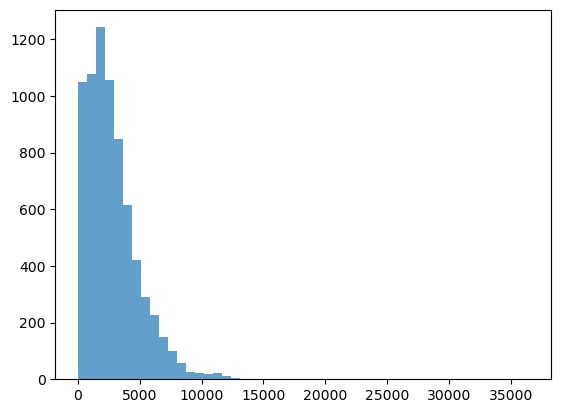

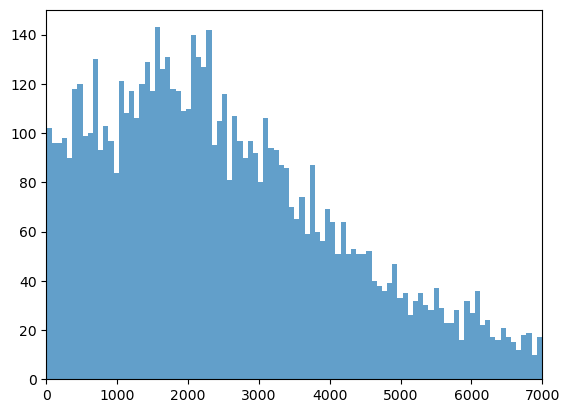

In [161]:
plt.hist(valid_ramp_pairs['abs_dQ'], bins=50, alpha=0.7)
plt.show()

plt.hist(valid_ramp_pairs['abs_dQ'], bins=500, alpha=0.7)
plt.xlim(0, 7000)  # Set y-axis limits
plt.show()

In [185]:
def plot_dual_ramp_hist(abs_dq: pd.Series | np.ndarray,
                        title: str,
                        zoom_right: float = 7000.0,
                        bins_full: int = 50,
                        bins_zoom: int = 500):
    abs_dq = pd.Series(abs_dq).dropna().to_numpy(float)
    pcts = [10, 25, 50, 75, 90]
    pv   = np.percentile(abs_dq, pcts)

    # colors for percentile lines
    cols = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
    labels = [f"p{p} = {v:,.0f}" for p, v in zip(pcts, pv)]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

    # left: full range
    axes[0].hist(abs_dq, bins=bins_full, alpha=0.8)
    # right: zoomed
    axes[1].hist(abs_dq, bins=bins_zoom, alpha=0.8)
    axes[1].set_xlim(0, zoom_right)

    for ax in axes:
        for v, c, lab in zip(pv, cols, labels):
            ax.axvline(v, color=c, linestyle="--", linewidth=1.8, label=lab)
        ax.grid(True, alpha=0.3)
        ax.set_xlabel("ΔQ (MW)")
        ax.set_ylabel("Number of pairs")

    # put the legend on the right panel to avoid duplication
    axes[1].legend(title="Percentiles", fontsize=9)

    fig.suptitle(title, fontsize=14)
    plt.show()

/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_40294/2624462563.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  V_test["dt"] = V_test.groupby("city")["timestamp"].diff()
/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_40294/2624462563.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  V_test["dQ"] = V_test.groupby("city")[q_col].diff()


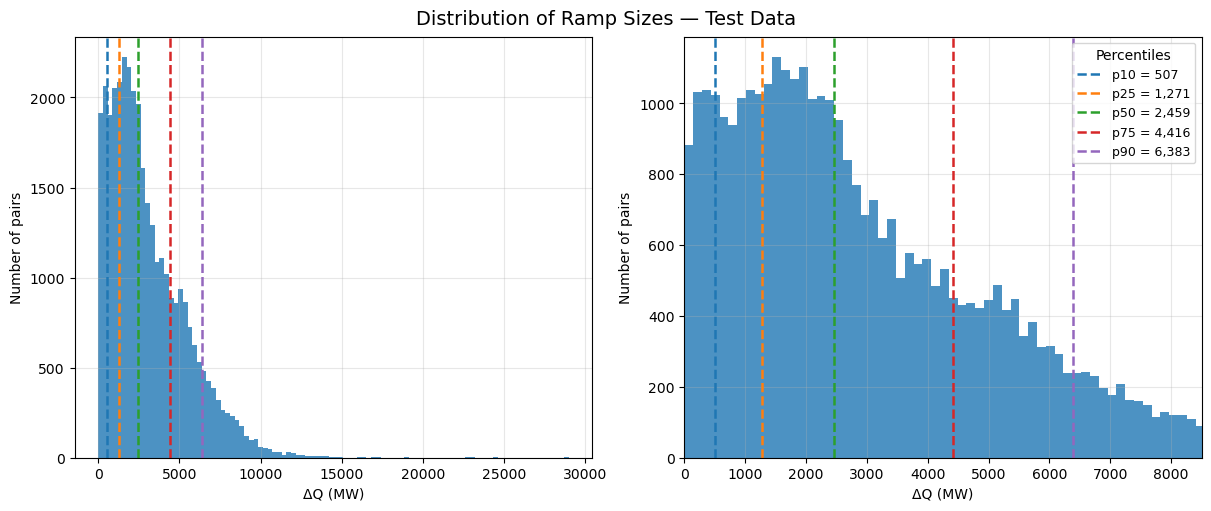

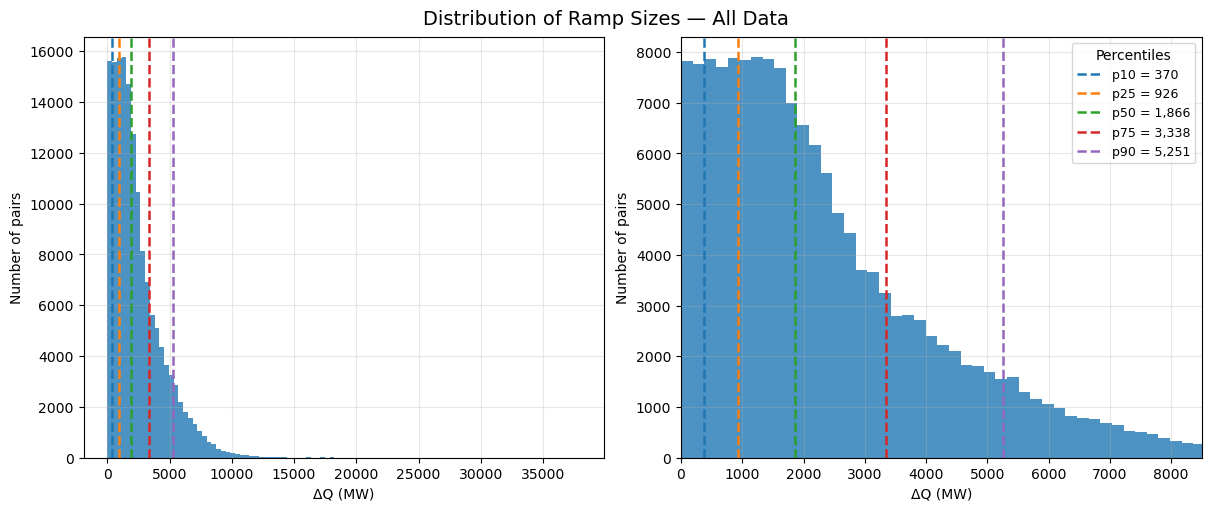

In [ ]:
# ---------- 1) Validation ramps
plot_dual_ramp_hist(
    valid_ramp_pairs["abs_dQ"],
    title="Distribution of Ramp Sizes in Validation Dataset",
    zoom_right=8500,
        bins_zoom=200,
    bins_full=100
)

q_col = "demand_minus_renewables"
window = pd.Timedelta("30min")

V_test = (X_test[["timestamp","city", q_col]]
          .assign(timestamp=lambda df: pd.to_datetime(df["timestamp"]))
          # collapse duplicates at the same city/timestamp; median/mean/first all fine
          .groupby(["city","timestamp"], observed=True, as_index=False)[q_col].median()
          .sort_values(["city","timestamp"]))

# consecutive diffs within each city
V_test["dt"] = V_test.groupby("city")["timestamp"].diff()
V_test["dQ"] = V_test.groupby("city")[q_col].diff()

# keep only proper adjacent pairs within the 30-min window and nonzero dQ
abs_dQ_test = (
    V_test.loc[
        V_test["dt"].notna() &
        (V_test["dt"] <= window) &
        V_test["dQ"].notna() &
        (V_test["dQ"] != 0),
        "dQ"
    ].abs()
)

plot_dual_ramp_hist(
    abs_dQ_test,
    title="Distribution of Ramp Sizes — Test Data",
    zoom_right=8500,
    bins_zoom=200,
    bins_full=100
)

pred_all_df = pred_all_pldf.to_pandas()

pred_all_df = pred_all_pldf.to_pandas()
V_all = (pred_all_df[["timestamp","city", q_col]]            # ✅ proper column selection
         .assign(timestamp=pd.to_datetime(pred_all_df["timestamp"]))
         .groupby(["city","timestamp"], observed=True, as_index=False)[q_col].median()
         .sort_values(["city","timestamp"]))
V_all["dt"] = V_all.groupby("city", observed=True)["timestamp"].diff()
V_all["dQ"] = V_all.groupby("city", observed=True)[q_col].diff()
abs_dQ_all = V_all.loc[
    V_all["dt"].notna() & (V_all["dt"] <= pd.Timedelta("30min")) &
    V_all["dQ"].notna() & (V_all["dQ"] != 0), "dQ"
].abs()


# keep only proper adjacent pairs within the 30-min window and nonzero dQ
abs_dQ_all = (
    V_all.loc[
        V_all["dt"].notna() &
        (V_all["dt"] <= window) &
        V_all["dQ"].notna() &
        (V_all["dQ"] != 0),
        "dQ"
    ].abs()
)

plot_dual_ramp_hist(
    abs_dQ_all,
    title="Distribution of Ramp Sizes — All Data",
    zoom_right=8500,
    bins_zoom=200,
    bins_full=100
)


/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_40294/2881063311.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  V_test["dt"] = V_test.groupby("city")["timestamp"].diff()
/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_40294/2881063311.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  V_test["dQ"] = V_test.groupby("city")[q_col].diff()


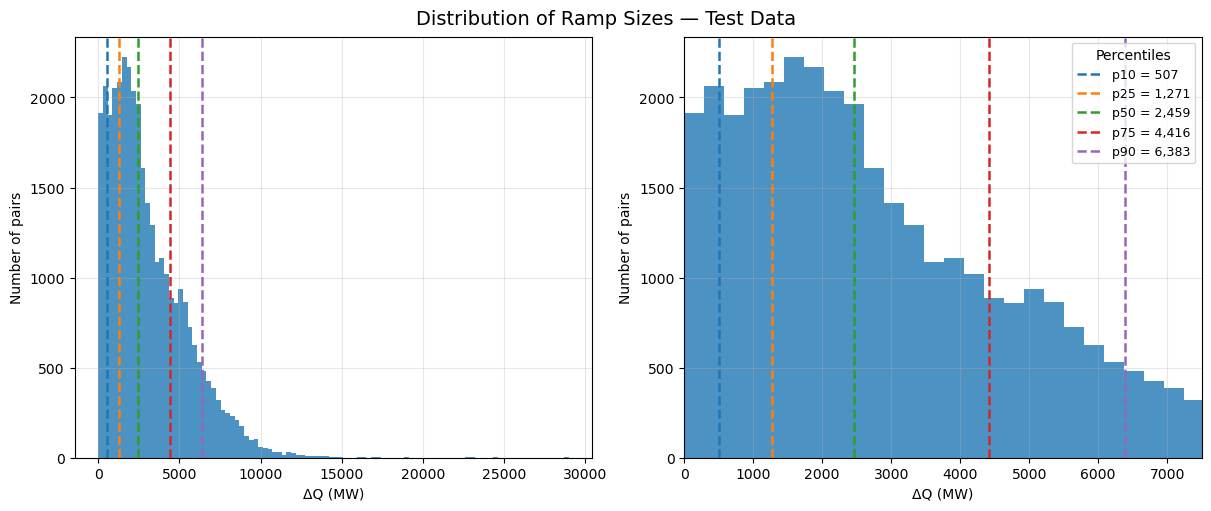

##### Fit and Evaluate Calibration

In [162]:
thr_abs_floor = 1000.0
thr_pct = 0.85
thr_cal = float(max(thr_abs_floor, np.quantile(valid_ramp_pairs["abs_dQ"], thr_pct)))
print(f"Calibration ramp threshold: |ΔQ| ≥ {thr_cal:,.0f}")


Calibration ramp threshold: |ΔQ| ≥ 4,827


In [163]:
pairs_val_for_cal = valid_ramp_pairs.loc[valid_ramp_pairs["abs_dQ"] >= thr_cal].copy()
a, b, model = fit_linear_calibration(pairs_val_for_cal, robust=False, use_weights=True)
print(f"Calibration (val, WLS): a={a:.3f}, b={b:.3f}")

Calibration (val, WLS): a=-0.513, b=2.055


In [164]:
# 3a) Run the sweep on your validation pairs
thresholds_pct = [10,25,50,60,70,75,80,85,90]
sweep_df = sweep_calibration_grid(
    valid_ramp_pairs,
    thresholds_abs=None,
    thresholds_pct=thresholds_pct,
    abs_floor_mw=None,
    robust_opts=(False, True),
    weight_opts=(True, False),
    allow_intercept_opts=(True, False),
    min_pairs=50
)
sweep_df

thr_MW  n_pairs  robust  use_weights  allow_intercept     cal_a  \
0    521.283333     6526   False        False            False  0.000000   
1    521.283333     6526   False        False             True -0.598304   
2    521.283333     6526   False         True            False  0.000000   
3    521.283333     6526   False         True             True -0.598785   
4    521.283333     6526    True        False            False  0.000000   
..          ...      ...     ...          ...              ...       ...   
67  5611.200000      726   False         True             True -0.478217   
68  5611.200000      726    True        False            False  0.000000   
69  5611.200000      726    True        False             True -0.465134   
70  5611.200000      726    True         True            False  0.000000   
71  5611.200000      726    True         True             True -0.465134   

       cal_b  cal_r2_w  cal_rmse_w   pearson  spearman    ols_r2  ols_slope  \
0   0.790722  0.075423    0.201608  0.363418  0.471171  0.132072   2.276381   
1   2.276381  0.132072    0.195334  0.363418  0.471171  0.132072   2.276381   
2   0.788160  0.117577    0.148947  0.363418  0.471171  0.132072   2.276381   
3   2.273225  0.206075    0.141281  0.363418  0.471171  0.132072   2.276381   
4   0.790722  0.075423    0.201608  0.363418  0.471171  0.132072   2.276381   
..       ...       ...         ...       ...       ...       ...        ...   
67  1.956003  0.286715    0.087438  0.532217  0.558599  0.283255   1.889863   
68  0.766724  0.182682    0.093146  0.532217  0.558599  0.283255   1.889863   
69  1.925538  0.283038    0.087240  0.532217  0.558599  0.283255   1.889863   
70  0.764643  0.179815    0.093761  0.532217  0.558599  0.283255   1.889863   
71  1.925538  0.286568    0.087447  0.532217  0.558599  0.283255   1.889863   

    ols_intercept  
0       -0.598304  
1       -0.598304  
2       -0.598304  
3       -0.598304  
4       -0.598304  
..            ...  
67      -0.449810  
68      -0.449810  
69      -0.449810  
70      -0.449810  
71      -0.449810  

[72 rows x 14 columns]

In [165]:
# 3b) Choose configuration
best = pick_best_config(
    sweep_df,
    min_pairs=300,      # <- set to something that feels safe for you
    r2_tol=0.01,        # within 1% of the best R²
    prefer_robust=True,
    prefer_weighted=True,
    prefer_allow_intercept=True
)
print("Chosen config:", best)


Chosen config: {'thr_MW': 4254.700000000006, 'n_pairs': 1451, 'robust': False, 'use_weights': True, 'allow_intercept': True, 'cal_a': -0.5829705378715568, 'cal_b': 2.226119621471166, 'cal_r2_w': 0.29848905148137994, 'cal_rmse_w': 0.09739885899584536, 'pearson': 0.5474245252316026, 'spearman': 0.5731874539802051, 'ols_r2': 0.2996736108250454, 'ols_slope': 2.2613917637110825, 'ols_intercept': -0.5953911630620603, '_robust_rank': 1, '_w_rank': 0, '_int_rank': 0}


In [166]:
# 3c) Re-fit a,b on the chosen threshold using the chosen options
thr = best["thr_MW"]
pairs_star = valid_ramp_pairs.loc[valid_ramp_pairs["abs_dQ"] >= thr].copy()
a, b, _model, r2_w, rmse_w = _fit_calibration_generic(
    pairs_star,
    robust=bool(best["robust"]),
    use_weights=bool(best["use_weights"]),
    allow_intercept=bool(best["allow_intercept"])
)
print(f"Final calibration on validation:\n  a={a:+.4f}, b={b:+.4f}, R²_w={r2_w:.4f}, RMSE_w={rmse_w:.4f}, n={len(pairs_star)}")

# 3d) Apply to splits (uses your helper)
Z_train_cal = apply_calibration_to_series(pd.DataFrame(Z_train), a, b, me_in="ME", me_out="ME_cal")
Z_val_cal  = apply_calibration_to_series(pd.DataFrame(Z_val),  a, b, me_in="ME", me_out="ME_cal")
Z_test_cal = apply_calibration_to_series(pd.DataFrame(Z_test), a, b, me_in="ME", me_out="ME_cal")
Z_all_cal  = apply_calibration_to_series(pd.DataFrame(Z_all),  a, b, me_in="ME", me_out="ME_cal")

# 3e) Report: raw vs calibrated on validation & test
compare_raw_vs_cal(X_train,  y_train,  pd.DataFrame(Z_train),  Z_train_cal,  q_col=q_col, label="Train", threshold_range=[100, 1000, 2000,3000, 4000,4255, 4500])
compare_raw_vs_cal(X_val,  y_val,  pd.DataFrame(Z_val),  Z_val_cal,  q_col=q_col, label="Validation",threshold_range=[100, 1000, 2000,3000, 4000,4255, 4500])
compare_raw_vs_cal(X_test, y_test, pd.DataFrame(Z_test), Z_test_cal, q_col=q_col, label="Test", threshold_range=[100, 1000, 2000,3000, 4000,4255, 4500])
compare_raw_vs_cal(all_data,  all_data['tons_co2'],  pd.DataFrame(Z_all),  Z_all_cal,  q_col=q_col, label="All Data",threshold_range=[100, 1000,2000,3000, 4000,4255, 4500])

Final calibration on validation:
  a=-0.5830, b=+2.2261, R²_w=0.2985, RMSE_w=0.0974, n=1451

=== TRAIN ===
|ΔQ| ≥   100   n_raw=49,799  n_cal=49,799
  RAW: r=0.114  ρ=0.244  OLS: s≈-0.509+1.868·m  R²=0.013  RMSE(s,ME)=0.432
  CAL: r=0.114  ρ=0.244  OLS: s≈-0.020+0.839·m  R²=0.013  RMSE(s,ME)=0.417
|ΔQ| ≥  1000   n_raw=35,637  n_cal=35,637
  RAW: r=0.273  ρ=0.320  OLS: s≈-0.527+1.896·m  R²=0.075  RMSE(s,ME)=0.215
  CAL: r=0.273  ρ=0.320  OLS: s≈-0.031+0.852·m  R²=0.075  RMSE(s,ME)=0.181
|ΔQ| ≥  2000   n_raw=21,144  n_cal=21,144
  RAW: r=0.311  ρ=0.370  OLS: s≈-0.539+1.915·m  R²=0.097  RMSE(s,ME)=0.195
  CAL: r=0.311  ρ=0.370  OLS: s≈-0.037+0.860·m  R²=0.097  RMSE(s,ME)=0.157
|ΔQ| ≥  3000   n_raw=12,241  n_cal=12,241
  RAW: r=0.350  ρ=0.422  OLS: s≈-0.629+2.108·m  R²=0.122  RMSE(s,ME)=0.194
  CAL: r=0.350  ρ=0.422  OLS: s≈-0.077+0.947·m  R²=0.122  RMSE(s,ME)=0.152
|ΔQ| ≥  4000   n_raw=7,350  n_cal=7,350
  RAW: r=0.359  ρ=0.444  OLS: s≈-0.628+2.085·m  R²=0.129  RMSE(s,ME)=0.196
  CAL: r=0

**SUMMARY**
* Applying a simple linear calibration  𝑠cal =𝑎+𝑏𝑠raw estimated on validation at ∣ΔQ∣≥4.255GW  ( 𝑎 = − 0.583  , 𝑏 = 2.226 , 𝑅2 = 0.299 , RMSE =0.097  , n = 1,451 )
substantially improves unit alignment between modeled slopes and realized marginal emissions. 
* On validation at 4.255 GW, the OLS slope of s on 𝑚 moves 2.26→1.02, the intercept −0.60→−0.00, and RMSE(s, ME) 0.139→0.100 (≈28% drop), with correlations 𝑟 = 0.547, 𝜌 = 0.573. The pattern generalizes: on test at 4.255 GW the slope shifts 1.96→0.88, intercept −0.45→+0.06, RMSE 0.113→0.087 (≈23%); on train it shifts 2.05→0.92, −0.61→−0.08, RMSE 0.196→0.151 (≈23%). 
* Across thresholds from 2–4.5 GW, both 𝑟 and 𝜌 increase with ramp size and calibration gains grow, with the largest RMSE reductions around 4–4.5 GW. The chosen 4.255 GW cut sits in a dense region with a strong signal and adequate sample (validation 𝑛 = 1,451). 
* When pooling all Δ𝑄 (many small ramps), post-calibration OLS slopes dip below 1 (attenuation from noisy small-Δ𝑄 pairs), but the distance metric still improves materially (e.g., at 4.255 GW: 0.163→0.125), indicating the calibrated series is closer in level to realized slopes even if global OLS is diluted.
* Overall: the fitted calibration (𝑎 ≈ −0.583, 𝑏 ≈ 2.226) fixes the unit mismatch and holds out-of-sample at the ramp sizes that matter.

##### Final Calibration

In [167]:
def apply_calibration_to_series(df, a, b, me_in="ME", me_out="ME_cal"):
    out = df.copy()
    out[me_out] = a + b * out[me_in]
    return out

a, b = -0.5830, 2.2261
Z_train_cal = apply_calibration_to_series(pd.DataFrame(Z_train), a, b)
Z_val_cal   = apply_calibration_to_series(pd.DataFrame(Z_val),   a, b)
Z_test_cal  = apply_calibration_to_series(pd.DataFrame(Z_test),  a, b)
Z_all_cal   = apply_calibration_to_series(pd.DataFrame(Z_all),   a, b)

In [168]:
Z_test_cal

timestamp    city  land_latitude  land_longitude  \
0      2024-06-01 00:00:00+05:30  mumbai           18.5           72.97   
1      2024-06-01 00:00:00+05:30  mumbai           19.3           72.87   
2      2024-06-01 00:00:00+05:30  mumbai           19.3           72.97   
3      2024-06-01 00:00:00+05:30  mumbai           19.0           72.97   
4      2024-06-01 00:00:00+05:30  mumbai           18.8           72.87   
...                          ...     ...            ...             ...   
788395 2025-05-31 23:30:00+05:30   delhi           28.8           76.94   
788396 2025-05-31 23:30:00+05:30   delhi           28.8           77.04   
788397 2025-05-31 23:30:00+05:30   delhi           28.8           77.14   
788398 2025-05-31 23:30:00+05:30   delhi           28.8           77.24   
788399 2025-05-31 23:30:00+05:30   delhi           28.8           77.34   

        wind_speed_mps  temperature_celsius  precipitation_mm  \
0             3.454928            29.157013          0.024319   
1             2.886852            30.604370          0.000119   
2             2.309101            30.608978          0.000000   
3             3.021624            29.246857          0.001669   
4             4.143778            29.165436          0.008523   
...                ...                  ...               ...   
788395        3.516465            29.679779          0.000000   
788396        3.293586            29.675735          0.000000   
788397        3.021289            29.558655          0.000000   
788398        2.742792            29.402222          0.000000   
788399        2.456929            29.201599          0.000000   

        surface_net_solar_radiation_kWh_per_m2  total_cloud_cover  \
0                                          0.0           0.268097   
1                                          0.0           0.156891   
2                                          0.0           0.156891   
3                                          0.0           0.187683   
4                                          0.0           0.276398   
...                                        ...                ...   
788395                                     0.0           0.226883   
788396                                     0.0           0.226883   
788397                                     0.0           0.226883   
788398                                     0.0           0.243881   
788399                                     0.0           0.243881   

        thermal_generation  ...  renewable_generation_rbst  \
0            169829.166667  ...                   0.317944   
1            169829.166667  ...                   0.317944   
2            169829.166667  ...                   0.317944   
3            169829.166667  ...                   0.317944   
4            169829.166667  ...                   0.317944   
...                    ...  ...                        ...   
788395       151636.416667  ...                   0.623916   
788396       151636.416667  ...                   0.623916   
788397       151636.416667  ...                   0.623916   
788398       151636.416667  ...                   0.623916   
788399       151636.416667  ...                   0.623916   

        non_renewable_generation_rbst  thermal_share_rbst  gas_share_rbst  \
0                            2.336660           -0.141349        2.644896   
1                            2.336660           -0.141349        2.644896   
2                            2.336660           -0.141349        2.644896   
3                            2.336660           -0.141349        2.644896   
4                            2.336660           -0.141349        2.644896   
...                               ...                 ...             ...   
788395                       1.392349           -0.361725       -0.734311   
788396                       1.392349           -0.361725       -0.734311   
788397                       1.392349           -0.361725       -0.734311 

In [169]:
Z_all_cal

timestamp    city  land_latitude  land_longitude  \
0       2021-01-01 00:00:00+05:30  mumbai           18.5           72.97   
1       2021-01-01 00:00:00+05:30  mumbai           18.6           72.97   
2       2021-01-01 00:00:00+05:30  mumbai           19.3           72.97   
3       2021-01-01 00:00:00+05:30  mumbai           19.1           72.87   
4       2021-01-01 00:00:00+05:30  mumbai           18.8           72.97   
...                           ...     ...            ...             ...   
3481915 2025-05-31 23:30:00+05:30   delhi           28.8           76.94   
3481916 2025-05-31 23:30:00+05:30   delhi           28.8           77.04   
3481917 2025-05-31 23:30:00+05:30   delhi           28.8           77.14   
3481918 2025-05-31 23:30:00+05:30   delhi           28.8           77.24   
3481919 2025-05-31 23:30:00+05:30   delhi           28.8           77.34   

         world_latitude  world_longitude  wind_speed_mps  temperature_celsius  \
0             18.500000        73.000000        1.648504            22.044586   
1             18.600000        73.000000        1.605315            21.900848   
2             19.299999        73.000000        1.358395            20.579742   
3             19.100000        72.900002        1.870063            22.390350   
4             18.799999        73.000000        1.571312            21.755127   
...                 ...              ...             ...                  ...   
3481915       28.799999        76.900002        3.516465            29.679779   
3481916       28.799999        77.000000        3.293586            29.675735   
3481917       28.799999        77.099998        3.021289            29.558655   
3481918       28.799999        77.199997        2.742792            29.402222   
3481919       28.799999        77.300003        2.456929            29.201599   

         precipitation_mm  surface_net_solar_radiation_kWh_per_m2  ...  \
0                     0.0                                     0.0  ...   
1                     0.0                                     0.0  ...   
2                     0.0                                     0.0  ...   
3                     0.0                                     0.0  ...   
4                     0.0                                     0.0  ...   
...                   ...                                     ...  ...   
3481915               0.0                                     0.0  ...   
3481916               0.0                                     0.0  ...   
3481917               0.0                                     0.0  ...   
3481918               0.0                                     0.0  ...   
3481919               0.0                                     0.0  ...   

         renewable_generation_rbst  non_renewable_generation_rbst  \
0                        -0.189339                      -1.391088   
1                        -0.189339                      -1.391088   
2                        -0.189339                      -1.391088   
3                        -0.189339                      -1.391088   
4                        -0.189339                      -1.391088   
...                            ...                            ...   
3481915                   0.623916                       1.392349   
3481916                   0.623916                       1.392349   
3481917                   0.623916                       1.392349   
3481918                   0.623916                       1.392349   
3481919                   0.623916                       1.392349   

        thermal_share_rbst  gas_share_rbst  hydro_share_rbst  \
0                 0.564386        0.989351         -0.537692   
1                 0.564386        0.989351         -0.537692   
2                 0.564386        0.989351         -0.537692   
3                 0.564386        0.989351         -0.537692   
4                 0.564386        0.989351         -0.537692   
...                    ...          

In [170]:
pred_all_labeled_calibrated = pred_all_labeled.with_columns(
    (pl.col("ME") * b + a).alias("ME_cal")
)
pred_all_labeled_calibrated.head(3)

shape: (3, 14)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ timestamp ┆ land_lati ┆ land_long ┆ y_true    ┆ … ┆ Pearson R ┆ Spearman  ┆ Confidenc ┆ ME_cal   │
│ ---       ┆ tude      ┆ itude     ┆ ---       ┆   ┆ Score     ┆ Score     ┆ e Level   ┆ ---      │
│ datetime[ ┆ ---       ┆ ---       ┆ f64       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ f64      │
│ μs, Asia/ ┆ f64       ┆ f64       ┆           ┆   ┆ f64       ┆ f64       ┆ str       ┆          │
│ Kolkata]  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2021-01-0 ┆ 18.5      ┆ 72.97     ┆ 51887.396 ┆ … ┆ 0.55606   ┆ 0.587619  ┆ medium    ┆ 0.502544 │
│ 1         ┆           ┆           ┆ 9         ┆   ┆           ┆           ┆           ┆          │
│ 00:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ IST       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2021-01-0 ┆ 18.6      ┆ 72.97     ┆ 51887.396 ┆ … ┆ 0.55606   ┆ 0.587619  ┆ medium    ┆ 0.502544 │
│ 1         ┆           ┆           ┆ 9         ┆   ┆           ┆           ┆           ┆          │
│ 00:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ IST       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2021-01-0 ┆ 19.3      ┆ 72.97     ┆ 51887.396 ┆ … ┆ 0.55606   ┆ 0.587619  ┆ medium    ┆ 0.502544 │
│ 1         ┆           ┆           ┆ 9         ┆   ┆           ┆           ┆           ┆          │
│ 00:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ IST       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [171]:
pred_all_labeled_calibrated.write_parquet(os.path.join(marginal_emissions_results_directory, "pyGAM_marginal_emissions_timeseries.parquet"),
                                           compression="snappy",
                                           statistics=True)


In [172]:
valid_ramp_pairs

dQ          dY    ME_mid  slope_dYdQ       abs_dQ
1    -2404.083333 -1094.91905  0.459776    0.455441  2404.083333
2    -1057.416667  -603.80955  0.469032    0.571023  1057.416667
3    -1627.416667  -721.55735  0.467448    0.443376  1627.416667
4    -1141.000000  -656.53095  0.460692    0.575400  1141.000000
5    -1063.833333  -234.75110  0.450332    0.220665  1063.833333
...           ...         ...       ...         ...          ...
7291  -113.666667   410.82775  0.383558   -3.614320   113.666667
7292  1306.333333   300.92340  0.383558    0.230357  1306.333333
7293  2684.000000   559.69370  0.383558    0.208530  2684.000000
7294  1349.666667   356.34800  0.383558    0.264027  1349.666667
7295  -223.750000   -28.92575  0.383558    0.129277   223.750000

[7252 rows x 5 columns]

##### Evaluation Calibration Visually

In [173]:
# RAW pairs from validation
pairs_val_raw = build_national_pairs(
    X_val, y_val, Z_val, q_col="demand_minus_renewables", me_col="ME",
    window=pd.Timedelta("30min")
)

# CAL pairs from validation (use the calibrated column)
pairs_val_cal = build_national_pairs(
    X_val, y_val, Z_val_cal, q_col="demand_minus_renewables", me_col="ME_cal",
    window=pd.Timedelta("30min")
)

/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_40294/1352058769.py:127: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(loc="lower center", ncol=4, frameon=False)


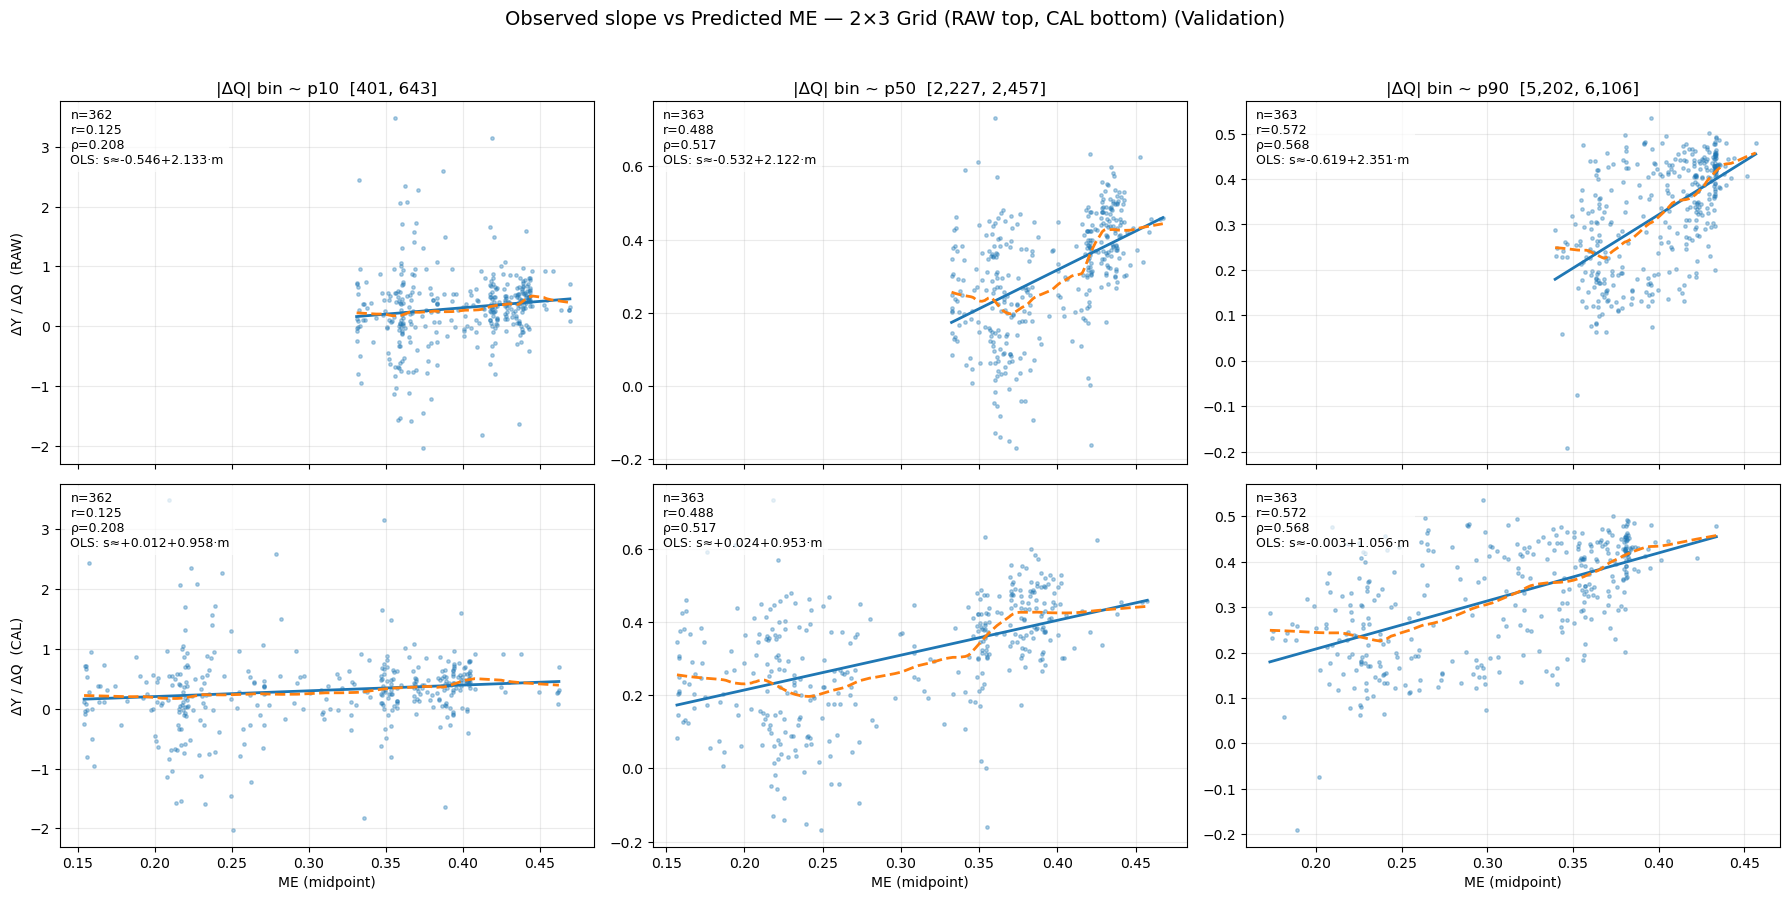

In [175]:
plot_me_diagnostics_grid_2x3(pairs_raw=pairs_val_raw, pairs_cal=pairs_val_cal, title_suffix="(Validation)", show=True)

**WHAT WE SEE**

Each column is a $|\Delta Q|$ bin (roughly p10, p50, p90), top row = RAW (ME), bottom row = CAL ($\mathrm{ME}_{\text{cal}}$). Points are observed slopes $s=\Delta Y/\Delta Q$ vs predicted ME (midpoint). Solid line is unweighted OLS $s\approx \alpha+\beta\,\text{ME}$; dashed is LOWESS.

**Sample sizes:** $n\approx 360$ per panel.

**Key read-outs by bin (approximate from annotations):**

* **p10** $[401, 643]$ MW:

  * RAW: $s\approx -0.546 + 2.133\,m$, $r\approx0.13$, $\rho\approx0.21$.
  * CAL: $s\approx +0.012 + 0.958\,m$, $r\approx0.13$, $\rho\approx0.21$.
* **p50** $[2{,}227, 2{,}457]$ MW:

  * RAW: $s\approx -0.532 + 2.122\,m$, $r\approx0.49$, $\rho\approx0.52$.
  * CAL: $s\approx +0.024 + 0.953\,m$, $r\approx0.49$, $\rho\approx0.52$.
* **p90** $[5{,}202, 6{,}106]$ MW:

  * RAW: $s\approx -0.619 + 2.351\,m$, $r\approx0.57$, $\rho\approx0.57$.
  * CAL: $s\approx -0.003 + 1.056\,m$, $r\approx0.57$, $\rho\approx0.57$.

**Interpretation:**

* **Unit alignment:** Calibration moves the OLS line from $\beta\approx 2.1\!-\!2.35,\ \alpha\approx -0.6$ (RAW) to nearly the identity ($\beta\approx 0.95\!-\!1.06,\ \alpha\approx 0$) across all bins—exactly the intended effect.
* **Association strength:** Pearson $r$ and Spearman $\rho$ increase with $|\Delta Q|$ (≈0.13 → ≈0.57), reflecting a cleaner marginal signal at larger ramps. As expected from the invariance above, **RAW and CAL $r,\rho$ are the same** within each bin.
* **Linearity:** LOWESS (dashed) tracks OLS closely at p50/p90, suggesting only mild nonlinearity in those regimes; p10 shows more heteroskedastic scatter.

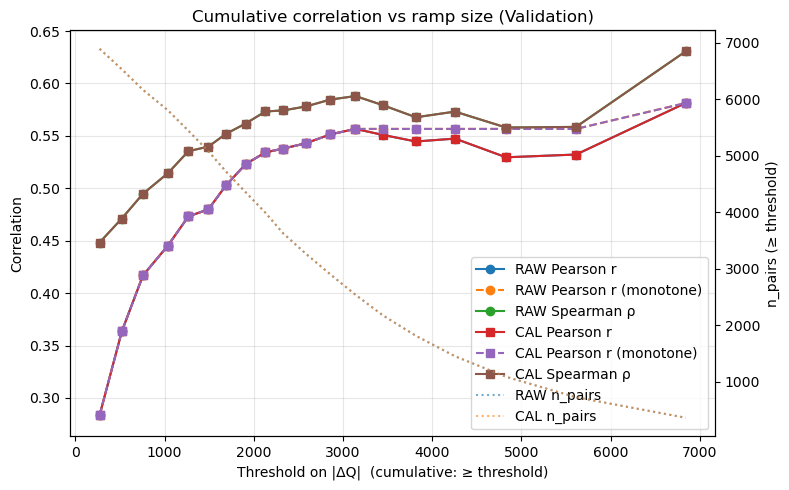

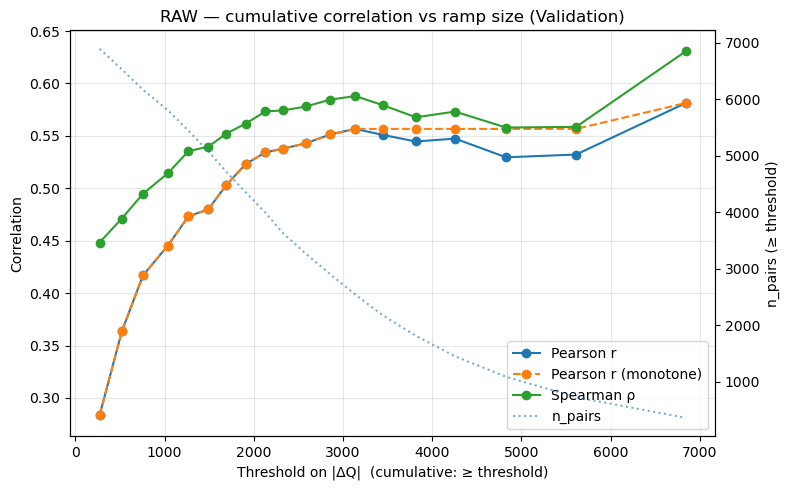

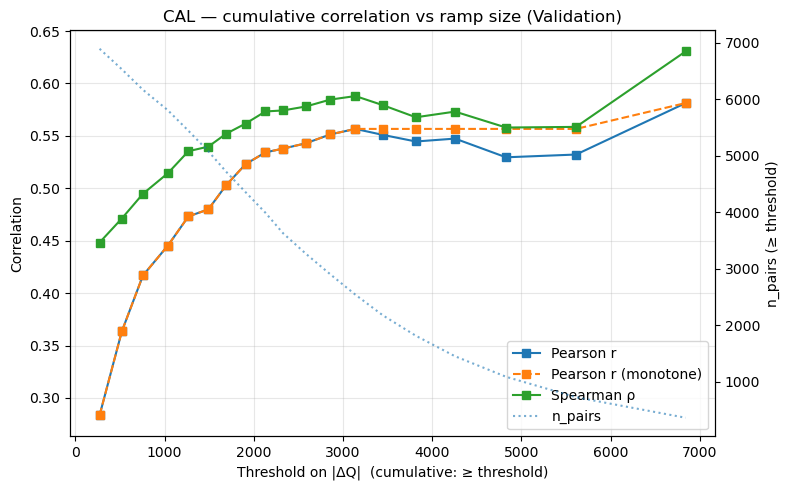

(None, None, None)

In [176]:
# cumulative correlation (separate figure)
plot_me_cumulative_split(pairs_val_raw, pairs_cal=pairs_val_cal, title_suffix="(Validation)", show=True)

In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
try:
    from statsmodels.nonparametric.smoothers_lowess import lowess
except Exception:
    lowess = None  # LOWESS optional

def _subset_by_absdq_bounds(df, lo, hi):
    """Keep rows with lo <= |ΔQ| < hi (handles NaNs)."""
    sub = df.copy()
    sub["abs_dQ"] = sub["dQ"].abs()
    m = sub["abs_dQ"].between(lo, hi, inclusive="left")
    sub = sub.loc[m, ["ME_mid","slope_dYdQ","abs_dQ"]].replace([np.inf, -np.inf], np.nan).dropna()
    return sub

def _compute_bin_bounds(pairs_raw, pairs_cal, mode, center, halfwidth):
    """
    mode='abs': center=MW, halfwidth=MW
    mode='pct': center=percentile (0-100), halfwidth=percentile points
               -> bounds computed from union of RAW&CAL |ΔQ| distribution.
    """
    if mode == "abs":
        lo = max(0.0, float(center) - float(halfwidth))
        hi = float(center) + float(halfwidth)
        label = f"|ΔQ| ≈ {center:,.0f} MW (±{halfwidth:,.0f})"
        return lo, hi, label

    if mode == "pct":
        # union so both slices use identical numeric bounds
        absdq_all = np.concatenate([
            pairs_raw["dQ"].abs().to_numpy(float),
            pairs_cal["dQ"].abs().to_numpy(float)
        ])
        absdq_all = absdq_all[np.isfinite(absdq_all)]
        p_lo = np.clip(center - halfwidth, 0, 100) / 100.0
        p_hi = np.clip(center + halfwidth, 0, 100) / 100.0
        lo, hi = np.quantile(absdq_all, [p_lo, p_hi])
        label = f"|ΔQ| bin ~ p{center:.0f} [{lo:,.0f}, {hi:,.0f}]"
        return float(lo), float(hi), label

    raise ValueError("mode must be 'abs' or 'pct'")

def _scatter_with_fits(ax, df, show_lowess=True, add_identity=False, id_xlim=None, id_ylim=None, label_prefix=""):
    """
    Draw scatter, OLS line, optional LOWESS, optional identity y=x.
    Returns (n, r, rho, a, b) where s ≈ a + b·m is OLS in the bin.
    """
    n = len(df)
    if n == 0:
        ax.text(0.5, 0.5, "no data", transform=ax.transAxes, ha="center", va="center")
        return 0, np.nan, np.nan, np.nan, np.nan

    m = df["ME_mid"].to_numpy(float)
    s = df["slope_dYdQ"].to_numpy(float)

    ax.scatter(m, s, s=8, alpha=0.35, label=f"{label_prefix} points (n={n:,})")

    a = b = np.nan
    if np.isfinite(m).sum() > 1 and np.std(m) > 0 and np.isfinite(s).sum() > 1:
        # OLS: s ≈ a + b·m
        b, a = np.polyfit(m, s, deg=1)
        xline = np.linspace(np.nanmin(m), np.nanmax(m), 200)
        ax.plot(xline, a + b*xline, linewidth=2, label=f"{label_prefix} OLS: s≈{a:+.2f}{b:+.2f}·m")
        if show_lowess and lowess is not None:
            try:
                sm = lowess(s, m, frac=0.3, return_sorted=True)
                ax.plot(sm[:,0], sm[:,1], linestyle="--", linewidth=2, label=f"{label_prefix} LOWESS")
            except Exception:
                pass

    # correlation annotations
    r   = pearsonr(s, m)[0] if (np.std(s)>0 and np.std(m)>0) else np.nan
    rho = spearmanr(s, m)[0] if n >= 3 else np.nan
    ax.text(0.02, 0.98, f"r={r:.3f}\nρ={rho:.3f}\nOLS: s≈{a:+.2f}{b:+.2f}·m",
            ha="left", va="top", fontsize=9, transform=ax.transAxes,
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

    # optional identity line y = x
    if add_identity:
        # choose identity domain based on axis limits or data
        if id_xlim is not None:
            xx = np.linspace(id_xlim[0], id_xlim[1], 200)
        else:
            x0, x1 = np.nanmin(m), np.nanmax(m)
            xx = np.linspace(x0, x1, 200)
        ax.plot(xx, xx, linestyle=":", linewidth=1.6, label="Ideal: s = ME")

    return n, r, rho, a, b

def plot_me_bin_stacked(
        pairs_raw: pd.DataFrame,
        pairs_cal: pd.DataFrame,
        *,
        mode: str = "abs",          # 'abs' or 'pct'
        center: float = 4255.0,     # MW if abs, percentile (0–100) if pct
        halfwidth: float = 250.0,   # MW window if abs, percentile points if pct
        title_suffix: str = "",
        show_lowess: bool = True,
        show_identity: bool = True,
        xlim: tuple | None = None,  # e.g., (-10, 10)
        ylim: tuple | None = None,  # e.g., (-10, 10)
        max_scatter_pts: int = 20000,
        seed: int = 0,
):
    """
    Stack RAW (top) vs CAL (bottom) for a single ramp *bin* (absolute or percentile).
    """
    rng = np.random.default_rng(seed)
    lo, hi, bin_label = _compute_bin_bounds(pairs_raw, pairs_cal, mode, center, halfwidth)

    # slice each and optionally downsample
    def _prep(df):
        sub = _subset_by_absdq_bounds(df, lo, hi)
        if len(sub) > max_scatter_pts:
            sub = sub.iloc[rng.choice(len(sub), size=max_scatter_pts, replace=False)]
        return sub

    sub_r = _prep(pairs_raw)
    sub_c = _prep(pairs_cal)

    fig, axes = plt.subplots(2, 1, figsize=(7.5, 9), sharex=True)
    # RAW
    n_r, r_r, rho_r, a_r, b_r = _scatter_with_fits(
        axes[0], sub_r, show_lowess=show_lowess, add_identity=show_identity,
        id_xlim=xlim, id_ylim=ylim, label_prefix="RAW"
    )
    axes[0].set_ylabel("Observed ΔY / ΔQ")
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(loc="lower right", frameon=False)

    # CAL
    n_c, r_c, rho_c, a_c, b_c = _scatter_with_fits(
        axes[1], sub_c, show_lowess=show_lowess, add_identity=show_identity,
        id_xlim=xlim, id_ylim=ylim, label_prefix="CAL"
    )
    axes[1].set_xlabel("MEF estimate (midpoint)")
    axes[1].set_ylabel("Observed ΔY / ΔQ")
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(loc="lower right", frameon=False)

    if xlim:
        axes[0].set_xlim(*xlim); axes[1].set_xlim(*xlim)
    if ylim:
        axes[0].set_ylim(*ylim); axes[1].set_ylim(*ylim)

    fig.suptitle(f"Observed slope vs ME — {bin_label} {title_suffix}".strip(), y=0.98, fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    # returns nothing; add a return fig if you want to save externally


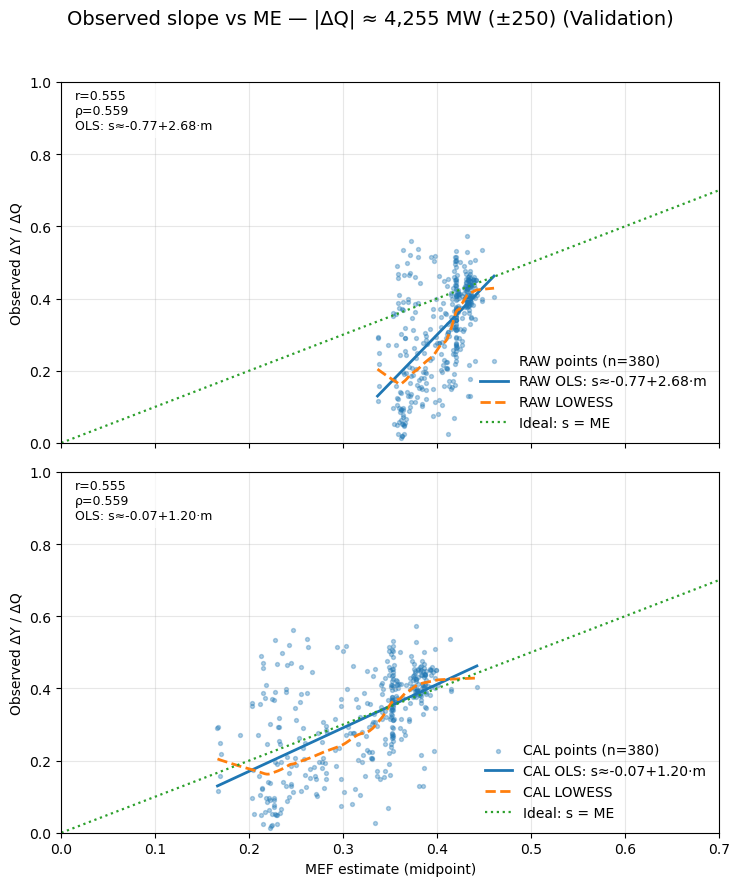

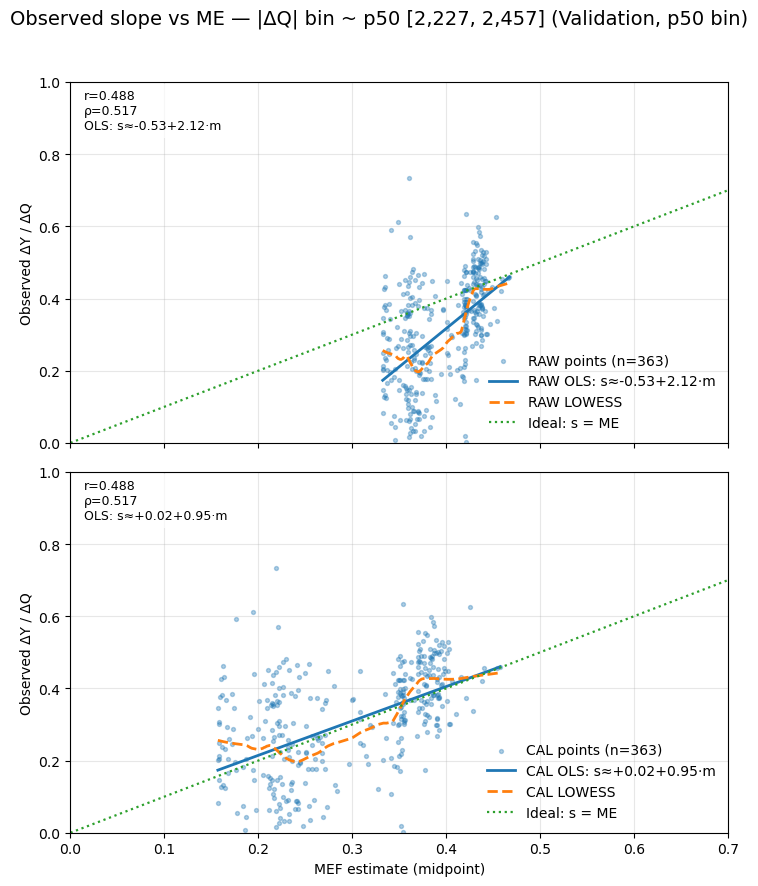

In [181]:
# 1) Snapshot around an absolute ramp of 4,255 MW (±250 MW window), Validation
plot_me_bin_stacked(
    pairs_val_raw, pairs_val_cal,
    mode="abs", center=4255, halfwidth=250,
    title_suffix="(Validation)",
    show_lowess=True, show_identity=True,
    xlim=(0, 0.70), ylim=(0, 1)    # or set e.g. xlim=(-10, 10), ylim=(-10, 10)
)

# 2) Snapshot around the 50th percentile (±2.5 percentile points), Validation
plot_me_bin_stacked(
    pairs_val_raw, pairs_val_cal,
    mode="pct", center=50, halfwidth=2.5,
    title_suffix="(Validation, p50 bin)",
    xlim=(0, 0.70), ylim=(0, 1)    # or set e.g. xlim=(-10, 10), ylim=(-10, 10)
)


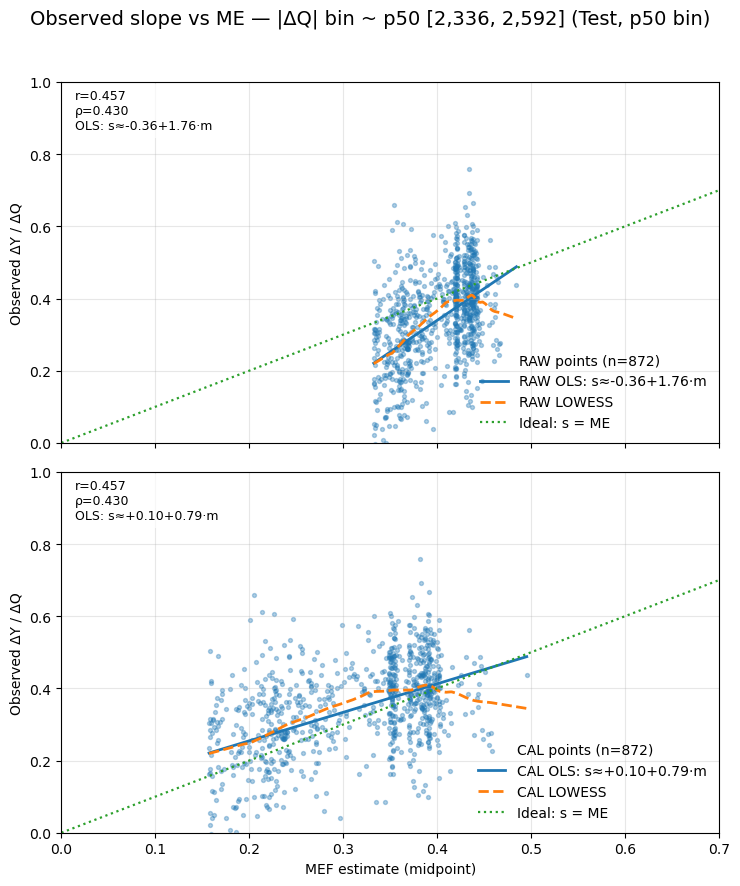

In [246]:
# RAW pairs from validation
pairs_test_raw = build_national_pairs(
    X_test, y_test, Z_test, q_col="demand_minus_renewables", me_col="ME",
    window=pd.Timedelta("30min")
)

# CAL pairs from validation (use the calibrated column)
pairs_test_cal = build_national_pairs(
    X_test, y_test, Z_test_cal, q_col="demand_minus_renewables", me_col="ME_cal",
    window=pd.Timedelta("30min")
)


# 2) Snapshot around the 50th percentile (±2.5 percentile points), Validation
plot_me_bin_stacked(
    pairs_test_raw, pairs_test_cal,
    mode="pct", center=50, halfwidth=2.5,
    title_suffix="(Test, p50 bin)",
    xlim=(0, 0.70), ylim=(0, 1)    # or set e.g. xlim=(-10, 10), ylim=(-10, 10)
)

**Why RAW vs CAL correlations look the same**

The calibration is an affine, monotone transform of ME:

$$
\mathrm{ME}_{\text{cal}} = a + b\,\mathrm{ME},\quad b>0.
$$

Pearson correlation is invariant to adding a constant and to positive rescaling:

$$
\mathrm{Corr}(X, a+bY)=\mathrm{Corr}(X,Y)\quad(b>0),
$$

and Spearman rank correlation is invariant to any strictly monotone transform. Therefore, RAW and CAL correlation curves should nearly coincide; any tiny differences come from interpolation/thresholding noise rather than a change in association strength.


**Bottom line:** Calibration corrects additive and multiplicative bias (unit mismatch) without changing the underlying correlation structure. The benefit is most visible at higher $|\Delta Q|$, where the calibrated ME aligns with observed slopes ($\alpha\to0,\ \beta\to1$) while correlations remain unchanged by design. If one wants to visualize the gain more directly, plot a **unit-sensitive metric**—e.g., $\mathrm{RMSE}(s-\mathrm{ME})$ vs $\mathrm{RMSE}(s-\mathrm{ME}_{\text{cal}})$—across thresholds.


In [222]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_me_cumulative_single(
    pairs: pd.DataFrame,
    *,
    min_pairs: int = 50,
    title_suffix: str = "",
    vline_mw: float | None = None,
    show: bool = True,
):
    """
    Cumulative correlation vs |ΔQ| threshold for ONE dataset (RAW *or* CAL).
    Plots: Pearson r, monotone Pearson r, Spearman ρ, and n_pairs.

    pairs must have columns: ['dQ','ME_mid','slope_dYdQ'].
    """
    # clean + absolute |ΔQ|
    pairs = _clean_pairs(pairs)
    if pairs.empty:
        print("No finite pairs to plot.");
        return None

    # thresholds from this dataset only (5%,10%,...,95%)
    pct_edges = np.arange(5, 100, 5)
    thr_vals = np.quantile(pairs["abs_dQ"].to_numpy(float), pct_edges/100.0)

    # curves
    r, r_mon, rho, n = _compute_corr_curves(pairs, thr_vals, min_pairs)

    # figure
    fig, ax = plt.subplots(figsize=(8, 5))
    ax2 = ax.twinx()

    ax.plot(thr_vals, r,      marker="o", label="Pearson r")
    ax.plot(thr_vals, r_mon,  marker="o", linestyle="--", label="Pearson r (monotone)")
    ax.plot(thr_vals, rho,    marker="o", label="Spearman ρ")
    ax2.plot(thr_vals, n,     linestyle=":", label="n_pairs (≥ threshold)")

    ax.set_xlabel("Threshold on |ΔQ|  (keep pairs ≥ threshold)")
    ax.set_ylabel("Correlation")
    ax2.set_ylabel("n_pairs (≥ threshold)")
    ax.set_title(f"Cumulative correlation vs ramp size {title_suffix}".strip())
    ax.grid(True, alpha=0.3)

    if vline_mw is not None:
        ax.axvline(float(vline_mw), linestyle=":", linewidth=1.5)
        ymax = np.nanmax(np.nan_to_num(np.r_[r, r_mon, rho], nan=-1))
        ax.text(float(vline_mw), ymax*0.75, f"  {vline_mw:,.0f} MW", rotation=90, va="top")

    # combined legend from both axes
    lines, labels = ax.get_legend_handles_labels()
    l2, lab2 = ax2.get_legend_handles_labels()
    ax.legend(lines + l2, labels + lab2, loc="lower right")

    fig.tight_layout()
    if show:
        plt.show()
        return None
    return fig


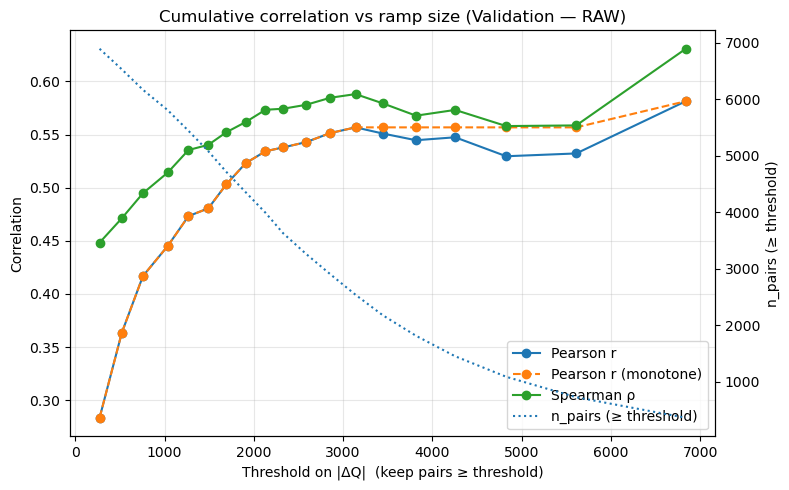

In [223]:
plot_me_cumulative_single(pairs_val_raw, title_suffix="(Validation — RAW)")


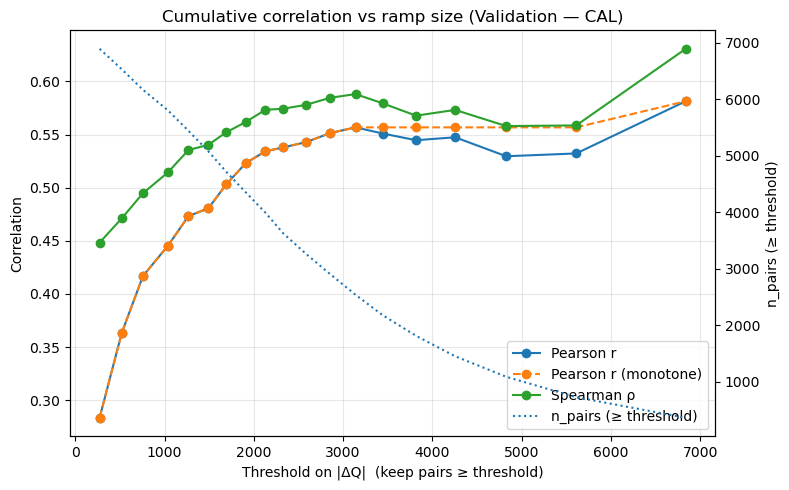

In [224]:
plot_me_cumulative_single(pairs_val_cal, title_suffix="(Validation — CAL)")


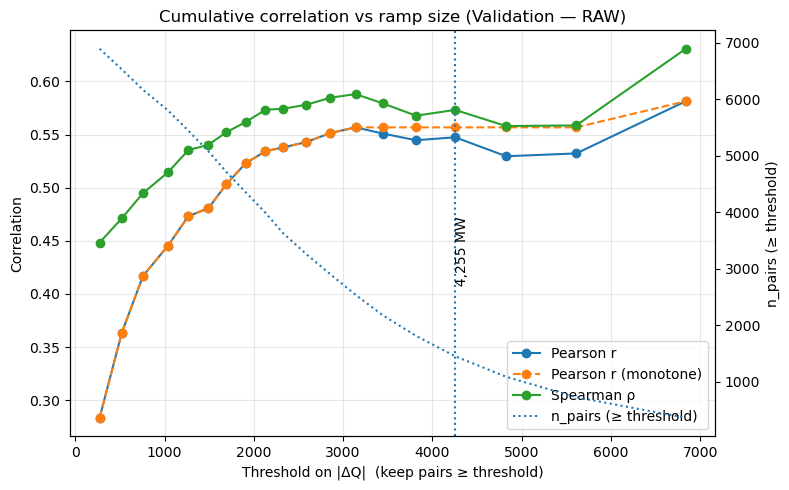

In [225]:
plot_me_cumulative_single(pairs_val_raw, title_suffix="(Validation — RAW)", vline_mw=4255)


In [212]:
def plot_me_cumulative_split_one(pairs_raw=None, pairs_cal=None, **kw):
    if (pairs_raw is None) == (pairs_cal is None):
        raise ValueError("Pass exactly one of pairs_raw or pairs_cal.")
    return plot_me_cumulative_single(pairs_raw if pairs_raw is not None else pairs_cal, **kw)


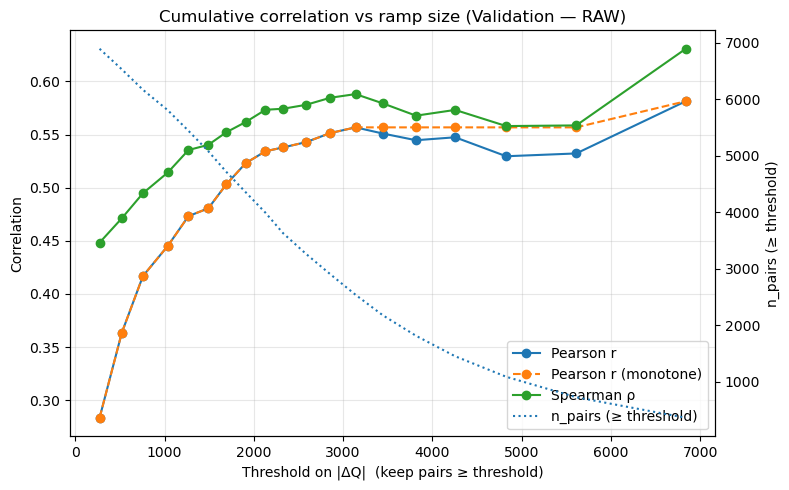

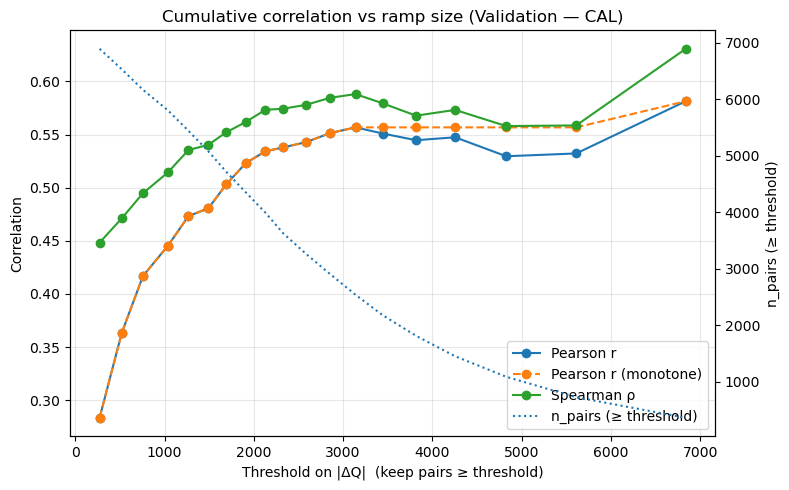

In [213]:
plot_me_cumulative_split_one(pairs_raw=pairs_val_raw, title_suffix="(Validation — RAW)")
# or
plot_me_cumulative_split_one(pairs_cal=pairs_val_cal, title_suffix="(Validation — CAL)")


/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_40294/1352058769.py:127: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(loc="lower center", ncol=4, frameon=False)


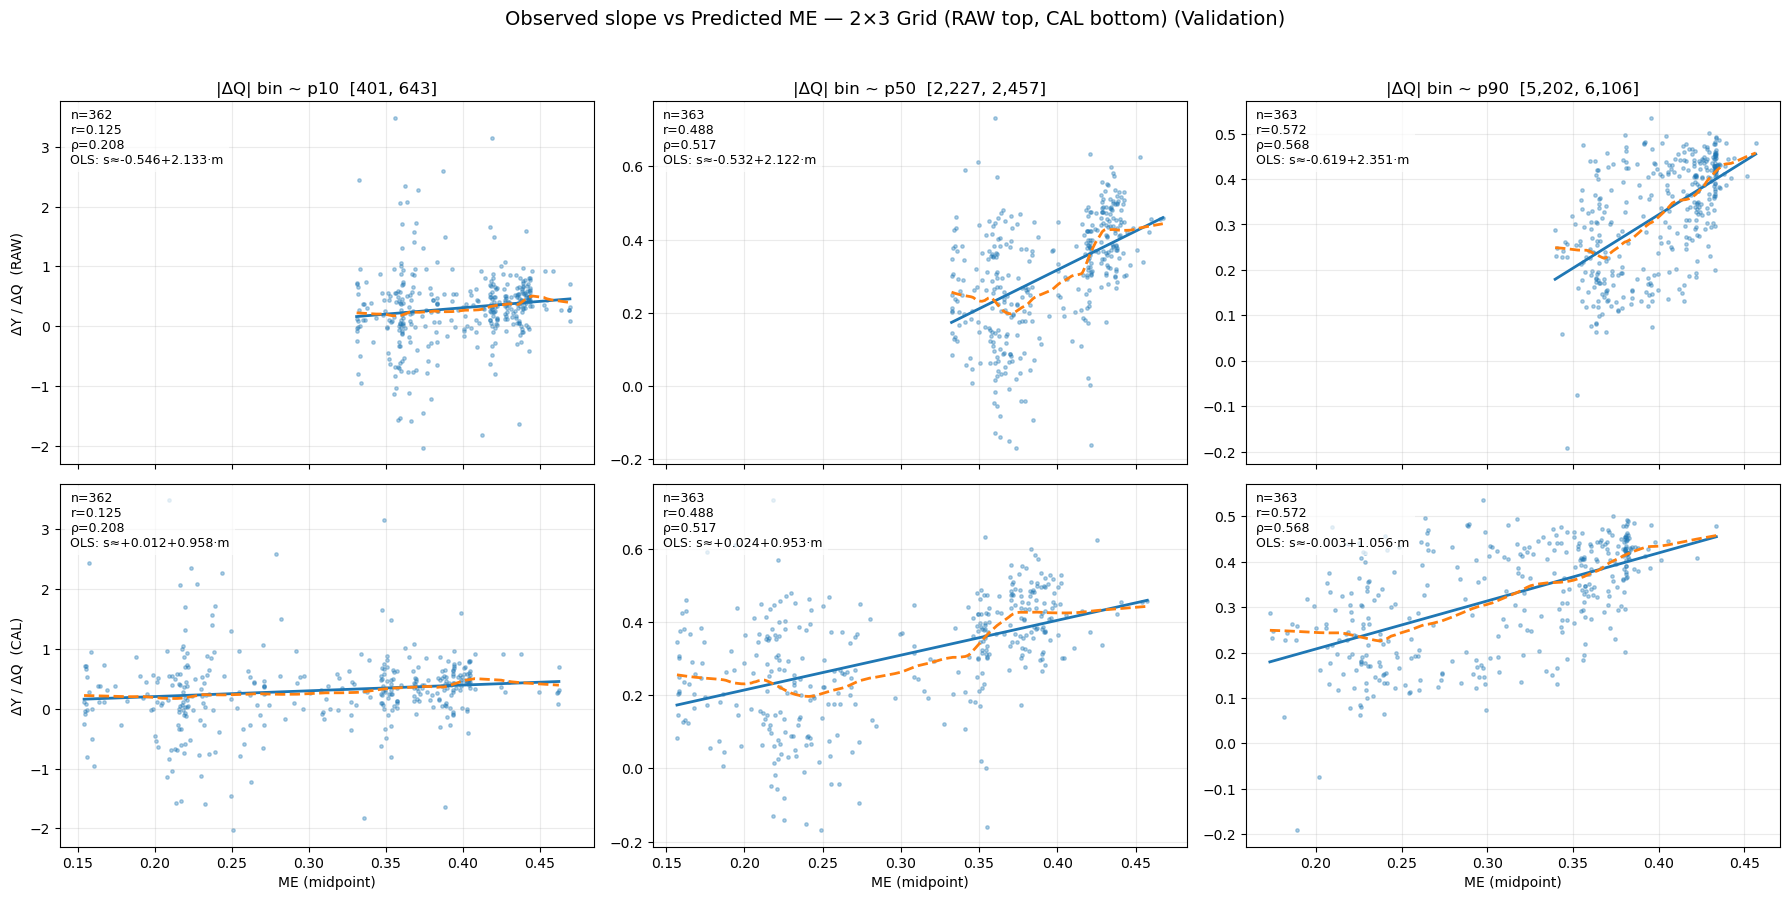

In [247]:
plot_me_diagnostics_grid_2x3(
    pairs_val_raw,
    pairs_val_cal,
    bin_percentiles=(10, 50, 90),
    # vline_mw=4255,
    title_suffix="(Validation)"
)


In [256]:
def plot_me_diagnostics_grid_2x3_line(
    pairs_raw: pd.DataFrame,
    pairs_cal: pd.DataFrame,
    *,
    bin_percentiles=(10, 50, 90),
    bin_halfwidth_pct=2.5,
    max_scatter_pts=8000,
    seed=0,
    title_suffix="",
    show=True,
    show_lowess: bool = True,
    lowess_frac: float = 0.3,
    show_identity: bool = True,
    xlim: tuple | None = None,   # per-column (shared across RAW/CAL)
    ylim: tuple | None = None,   # per-column (shared across RAW/CAL)
):
    """
    2×3 grid: row0=RAW, row1=CAL; columns = |ΔQ| percentile bins.
    Adds: legend labels (OLS/LOWESS/Identity) and dotted identity line y=x.

    Requires columns: ['dQ','dY','ME_mid','slope_dYdQ'] (or created by _clean_pairs).
    """
    try:
        from scipy.stats import pearsonr, spearmanr
    except Exception:
        pearsonr = spearmanr = None
    try:
        from statsmodels.nonparametric.smoothers_lowess import lowess as _lowess
    except Exception:
        _lowess = None
        show_lowess = False
    rng = np.random.default_rng(seed)
    pr, pc = _clean_pairs(pairs_raw), _clean_pairs(pairs_cal)
    if pr.empty or pc.empty:
        print("No finite pairs to plot (raw or cal).");
        return None

    absdq_all = np.concatenate([pr["abs_dQ"].to_numpy(float), pc["abs_dQ"].to_numpy(float)])
    def q_all(p): return float(np.quantile(absdq_all, np.clip(p,0,100)/100.0))

    ncols = len(bin_percentiles)
    fig, axes = plt.subplots(2, ncols, figsize=(6*ncols, 9), sharex="col", sharey="col")

    def _scatter_bin(ax, df_sub, label_prefix: str):
        n = len(df_sub)
        if n > max_scatter_pts:
            df_sub = df_sub.iloc[rng.choice(n, size=max_scatter_pts, replace=False)]
            n = len(df_sub)

        # scatter (if any)
        if n == 0:
            ax.text(0.5, 0.5, "no data", ha="center", va="center",
                    fontsize=11, transform=ax.transAxes)
            m = np.array([]); s = np.array([])
        else:
            m = df_sub["ME_mid"].to_numpy(float)
            s = df_sub["slope_dYdQ"].to_numpy(float)
            ax.scatter(m, s, s=6, alpha=0.35)

        # OLS
        a = b = np.nan
        if m.size > 1 and np.isfinite(m).sum() > 1 and np.std(m) > 0 and np.isfinite(s).sum() > 1:
            b, a = np.polyfit(m, s, deg=1)
            xline = np.linspace(np.nanmin(m), np.nanmax(m), 100)
            ax.plot(xline, a + b*xline, linewidth=2, label=f"{label_prefix} OLS")

            # LOWESS
            if show_lowess and _lowess is not None:
                try:
                    sm = _lowess(s, m, frac=lowess_frac, return_sorted=True)
                    ax.plot(sm[:,0], sm[:,1], linewidth=2, linestyle="--", label=f"{label_prefix} LOWESS")
                except Exception:
                    pass

        # Identity y=x — always draw, using current xlim (already set) or fallback
        if show_identity:
            xl = ax.get_xlim()
            x_id = np.linspace(xl[0], xl[1], 100)
            ax.plot(x_id, x_id, linestyle=":", linewidth=1.8, label="Identity y=x", zorder=1)

        # correlations (use full subset)
        r = rho = np.nan
        if pearsonr is not None and m.size > 1 and np.std(m) > 0 and np.std(s) > 0:
            r = pearsonr(s, m)[0]
        if spearmanr is not None and n >= 3:
            rho = spearmanr(s, m)[0]

        ax.text(0.02, 0.98,
                f"n={n:,}\nr={r:.3f}\nρ={rho:.3f}\nOLS: s≈{a:+.3f}{b:+.3f}·m",
                ha="left", va="top", fontsize=9, transform=ax.transAxes,
                bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))
        ax.grid(True, alpha=0.25)

    for j, p_ctr in enumerate(bin_percentiles):
        lo, hi = q_all(p_ctr - bin_halfwidth_pct), q_all(p_ctr + bin_halfwidth_pct)
        sub_r = pr.loc[(pr["abs_dQ"] >= lo) & (pr["abs_dQ"] < hi), ["ME_mid","slope_dYdQ","abs_dQ"]]
        sub_c = pc.loc[(pc["abs_dQ"] >= lo) & (pc["abs_dQ"] < hi), ["ME_mid","slope_dYdQ","abs_dQ"]]

        # Set limits FIRST so identity spans them even with no data
        if xlim:
            axes[0, j].set_xlim(*xlim); axes[1, j].set_xlim(*xlim)
        if ylim:
            axes[0, j].set_ylim(*ylim); axes[1, j].set_ylim(*ylim)

        _scatter_bin(axes[0, j], sub_r, "RAW")
        _scatter_bin(axes[1, j], sub_c, "CAL")

        axes[0, j].set_title(f"|ΔQ| bin ~ p{p_ctr:.0f}  [{lo:,.0f}, {hi:,.0f}]")
        if j == 0:
            axes[0, j].set_ylabel("Observed ΔY / ΔQ  (RAW)")
            axes[1, j].set_ylabel("Observed ΔY / ΔQ  (CAL)")
        axes[1, j].set_xlabel("MEF estimate (midpoint)")

        # Legends per-axes
        axes[0, j].legend(loc="lower right", frameon=False)
        axes[1, j].legend(loc="lower right", frameon=False)

    fig.suptitle(
        f"Observed slope vs Predicted ME — 2×3 Grid (RAW top, CAL bottom) {title_suffix}".strip(),
        y=0.995, fontsize=14
    )
    fig.tight_layout(rect=[0, 0, 1, 0.97])

    if show:
        plt.show()
        return None
    else:
        return fig


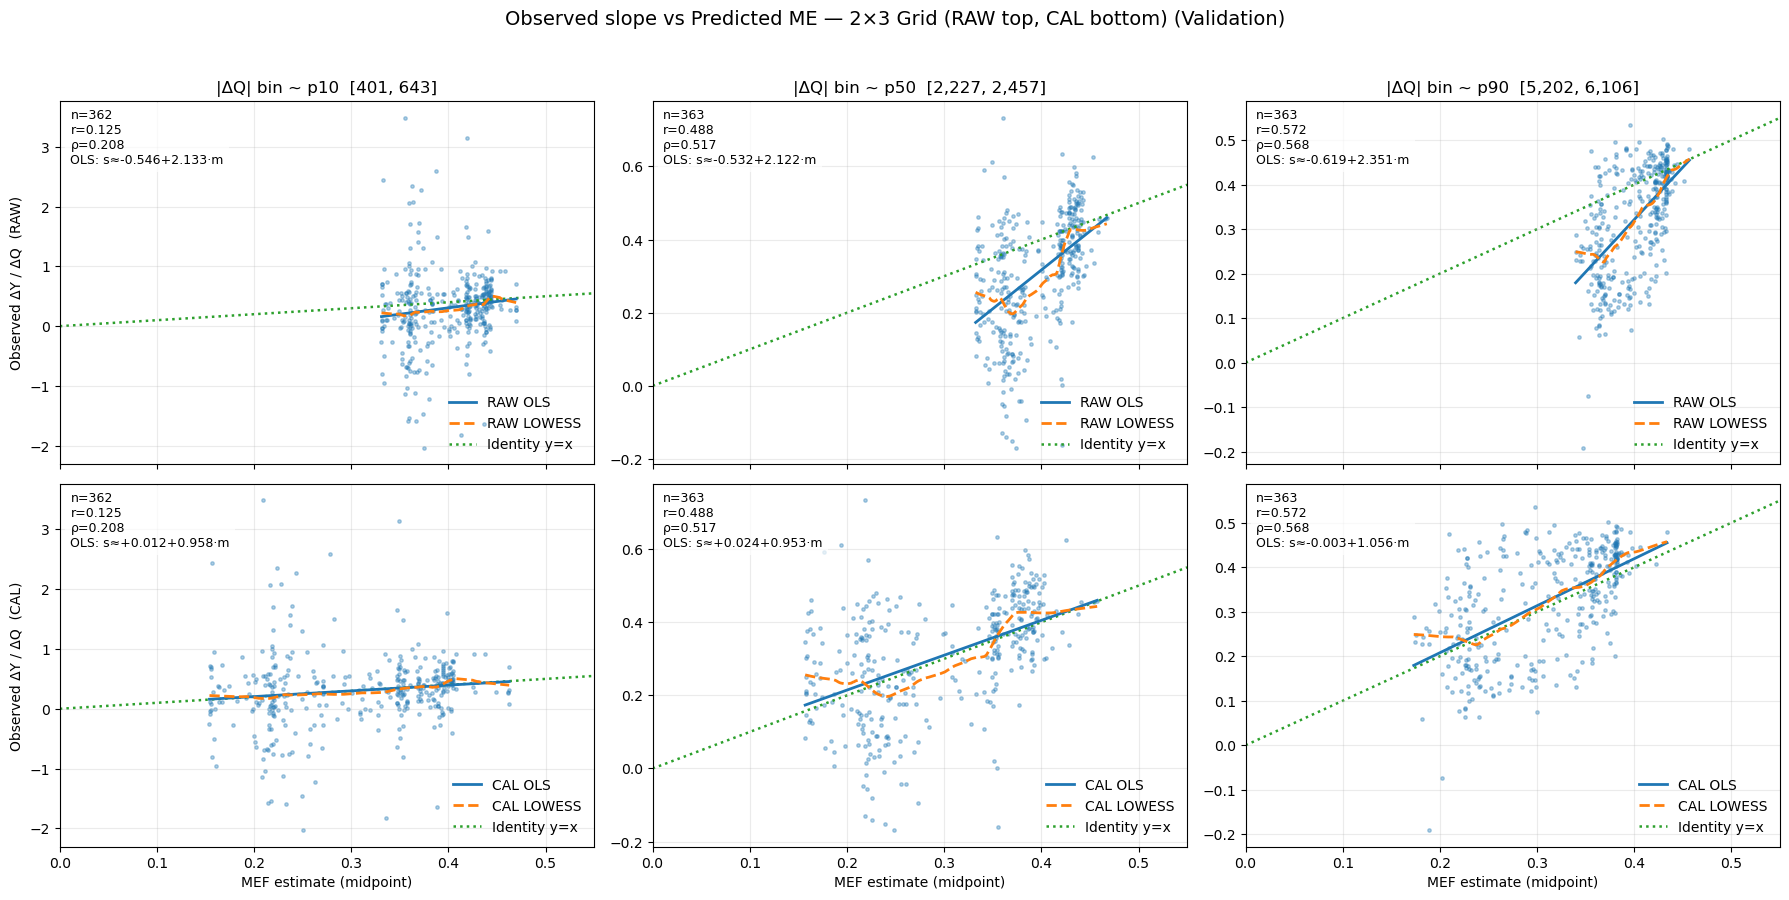

In [257]:
plot_me_diagnostics_grid_2x3_line(
    pairs_val_raw,
    pairs_val_cal,
    bin_percentiles=(10, 50, 90),
    title_suffix="(Validation)",
    show_lowess=True,
    xlim=(0, 0.55),
    show_identity=True,
    # xlim=(-5, 5), ylim=(-5, 5),  # optional
)

In [ ]:
# RAW pairs from test
pairs_test_raw = build_national_pairs(
    X_test, y_test, Z_test, q_col="demand_minus_renewables", me_col="ME",
    window=pd.Timedelta("30min")
)

# CAL pairs from test (use the calibrated column)
pairs_test_cal = build_national_pairs(
    X_test, y_test, Z_test_cal, q_col="demand_minus_renewables", me_col="ME_cal",
    window=pd.Timedelta("30min")
)

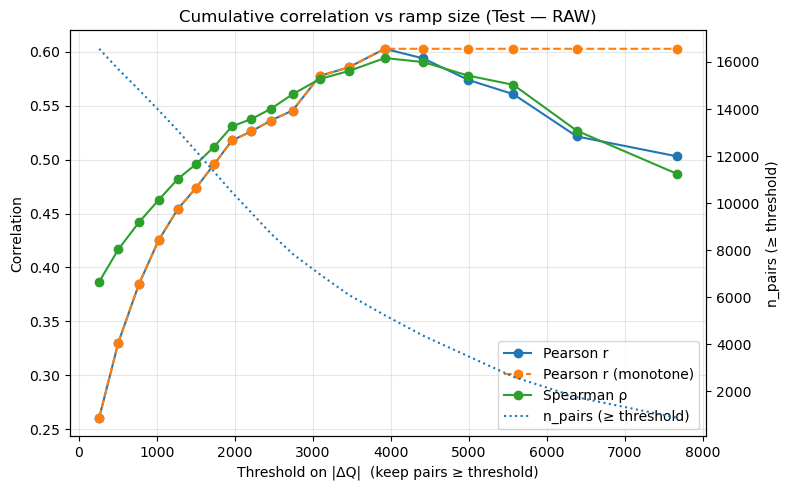

In [260]:
plot_me_cumulative_single(pairs_test_cal, title_suffix="(Test — RAW)")


/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_40294/1352058769.py:127: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(loc="lower center", ncol=4, frameon=False)


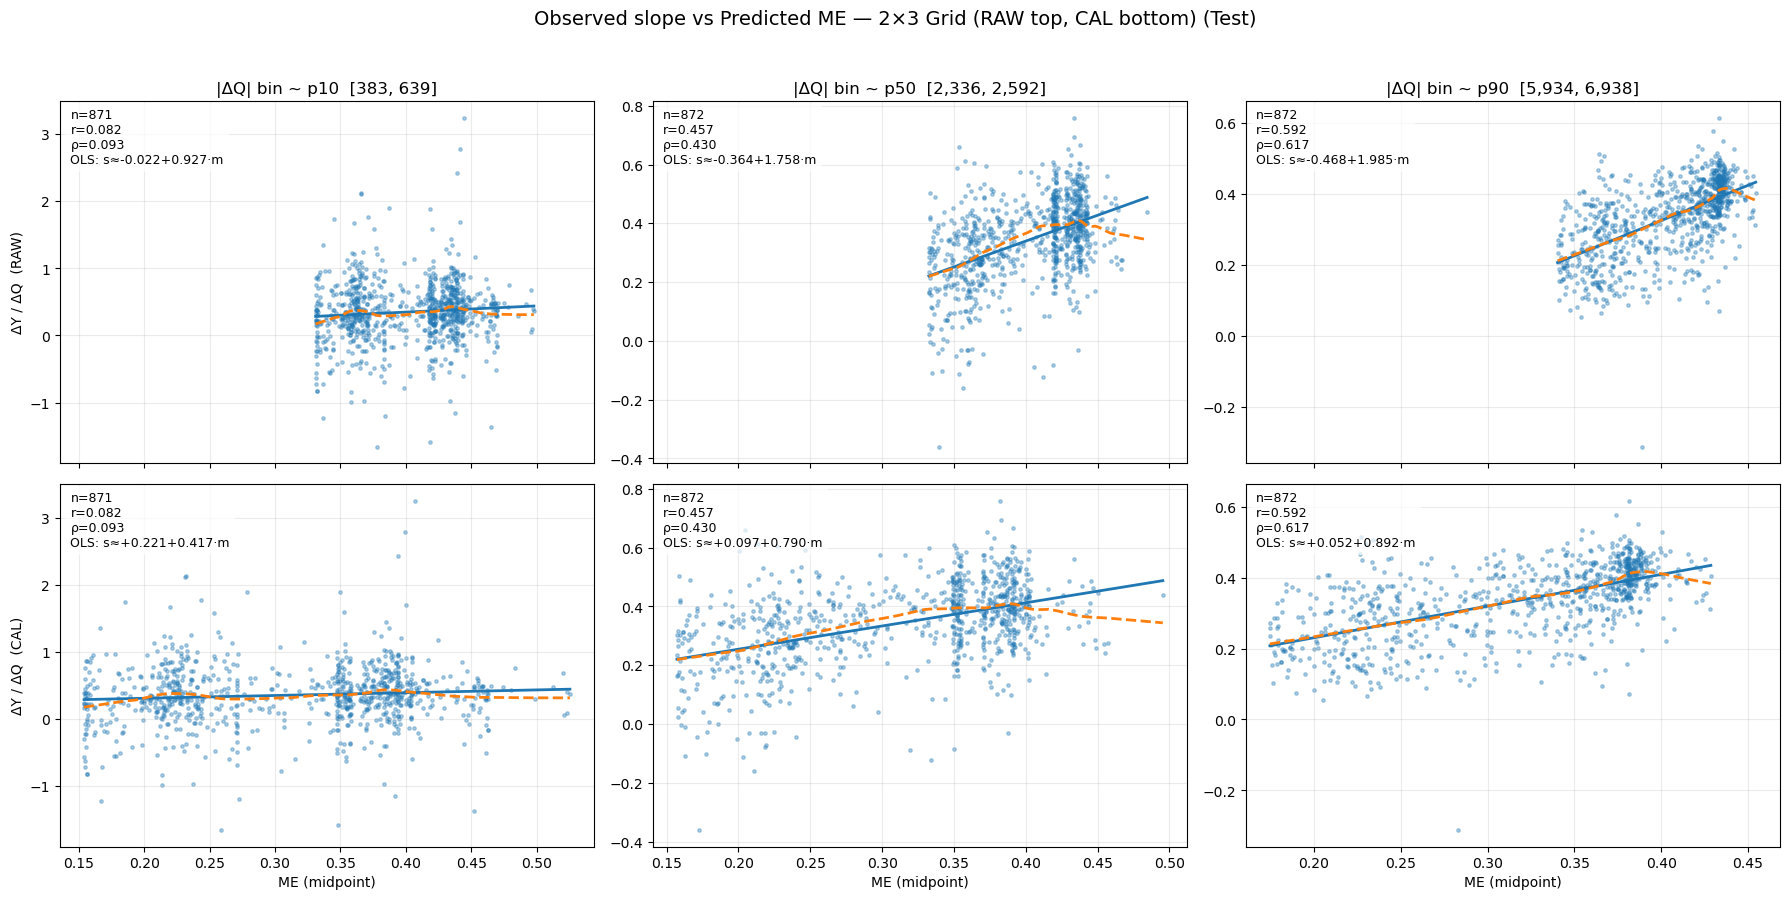

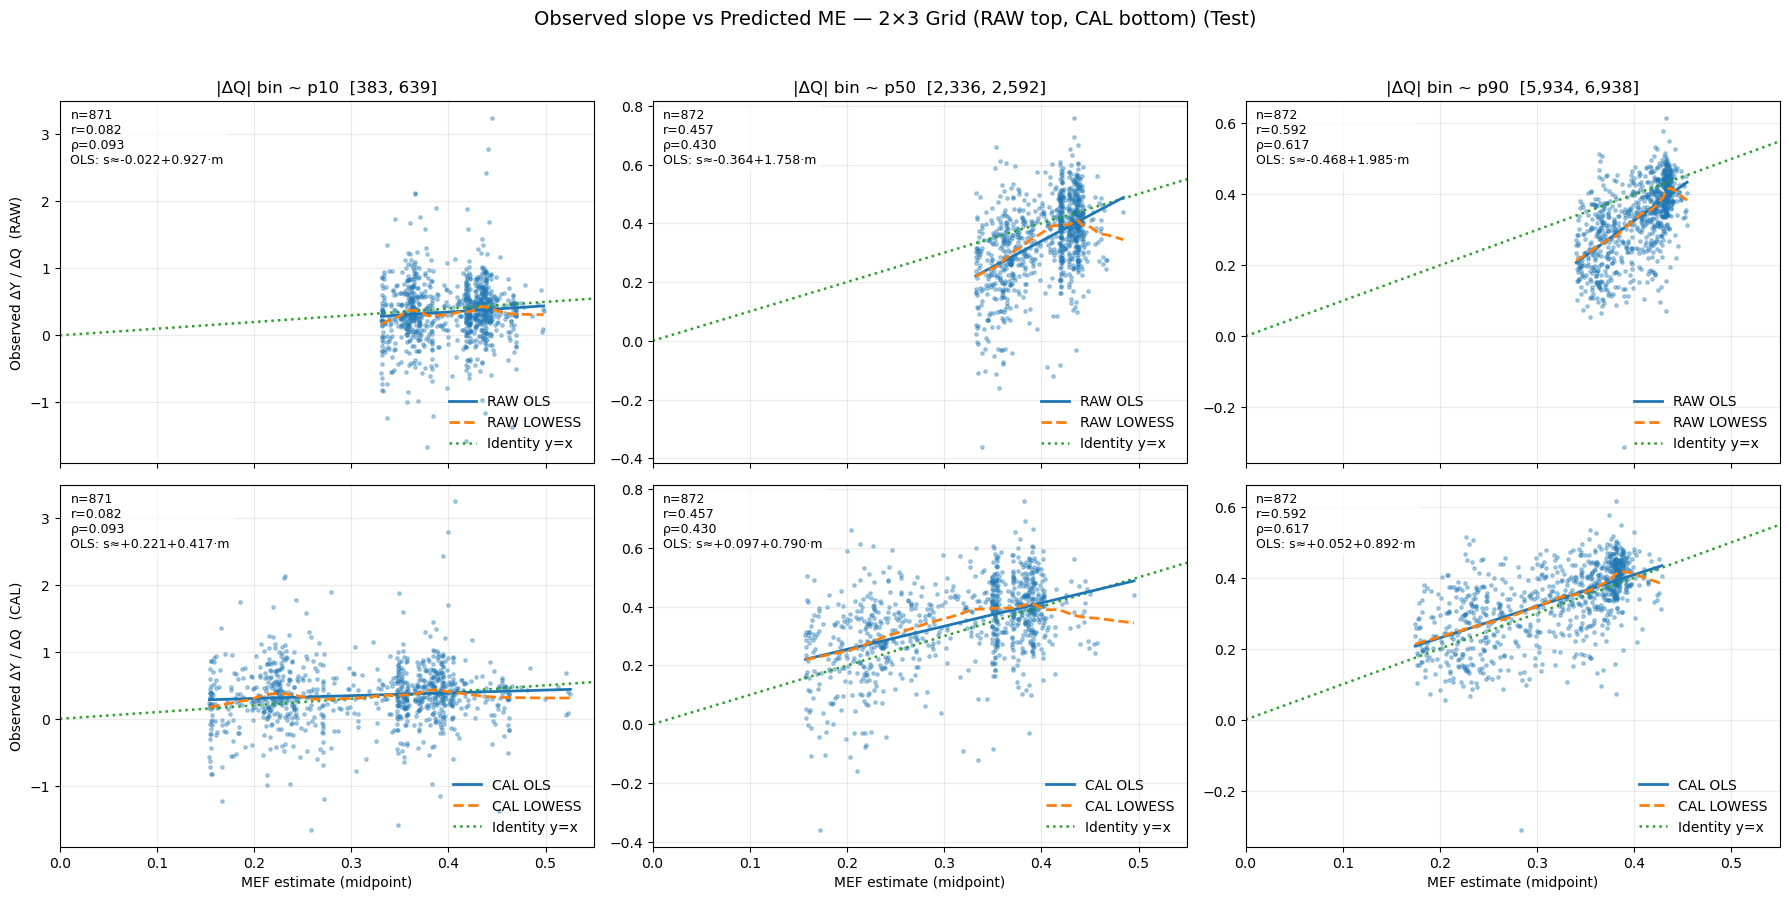

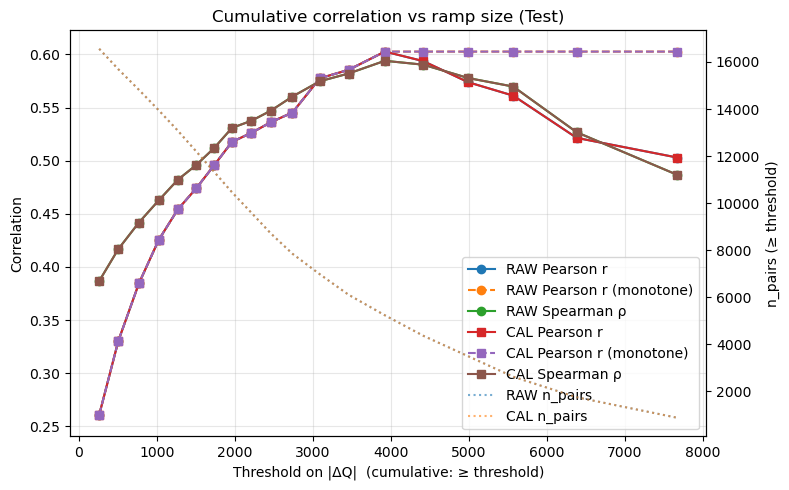

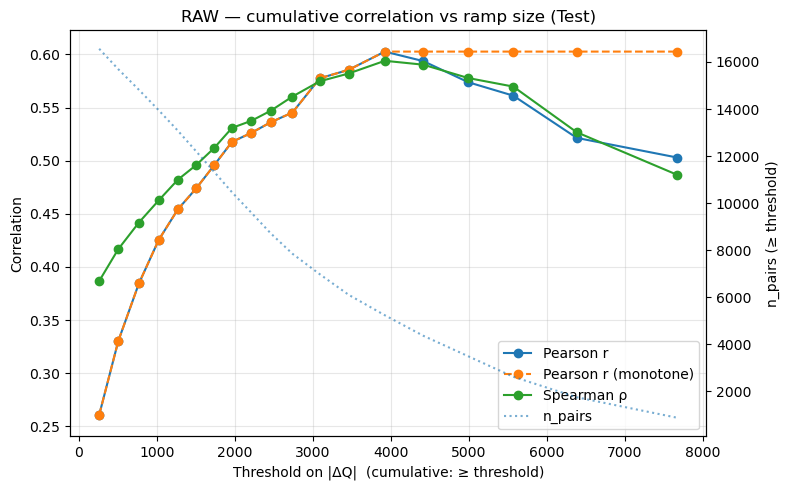

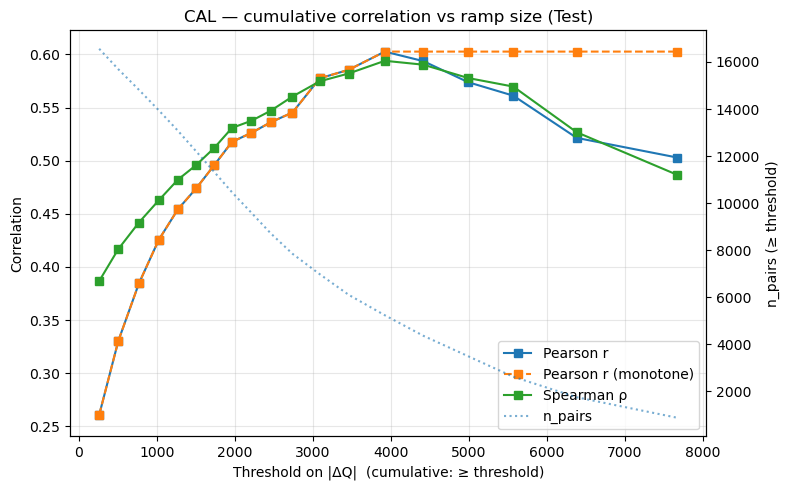

(None, None, None)

In [258]:
plot_me_diagnostics_grid_2x3(pairs_test_raw, pairs_test_cal, title_suffix="(Test)", show=True)



plot_me_diagnostics_grid_2x3_line(
    pairs_test_raw,
    pairs_test_cal,
    bin_percentiles=(10, 50, 90),
    title_suffix="(Test)",
    show_lowess=True,
    xlim=(0, 0.55),
    show_identity=True,
    # xlim=(-5, 5), ylim=(-5, 5),  # optional
)
# cumulative correlation (separate figure)
plot_me_cumulative_split(pairs_test_raw, pairs_cal=pairs_test_cal, title_suffix="(Test)", show=True)

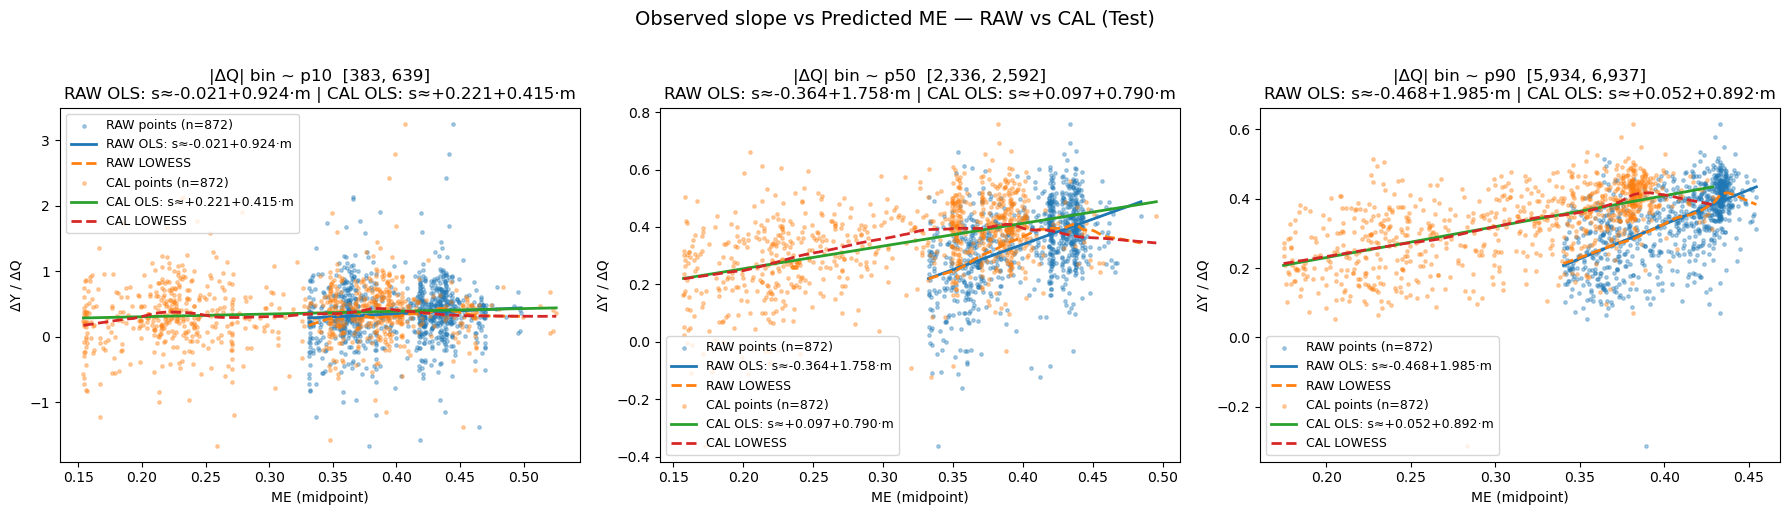

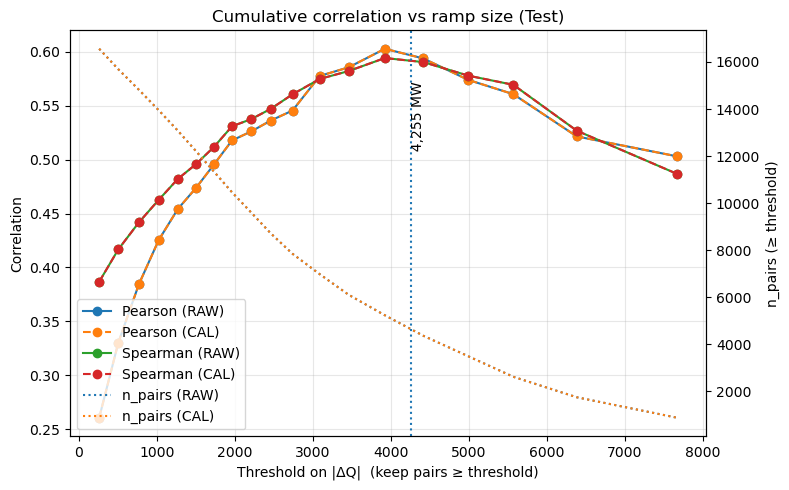

In [ ]:
# Plot, highlighting chosen threshold (e.g., 4,255 MW) and adding a title suffix
plot_me_diagnostics_compare(
    pairs_test_raw,
    pairs_test_cal,
    bin_percentiles=(10, 50, 90),
    vline_mw=4255,
    title_suffix="(Test)"
)


### Summary

**Models tested (what, why)**
* Ridge with polynomial bases
    * Why: Fast, convex baseline; strong level fit; analytic derivative.
    * What: 
        * Design matrix. Φ(𝑄) with polynomial degrees 𝑑 ∈ {2, …, 6}, weather/time mostly linear (with Fourier hour/day terms); context linear (hydro share, wind dir. sin/cos, is_sunny).
        * Diagnostics. Level: R²/RMSE/MAE. ME: 30–60 min ramp pairs; Pearson/Spearman of Δ𝑌/Δ𝑄 vs ME; OLS slope/intercept of 𝑠∼ME.
        * Key observation. Great level R², but noisy ME at small–medium ramps; global polynomials impose shape everywhere → wiggly ∂Y/∂Q. Typically ~0.02–0.03 lower r than pyGAM on ME.

* Groupwise OLS (piecewise / binning)
    * Why: Check if local piecewise fits capture dispatch curvature missed by global polynomials.
    * What:
        * Binning. Net-load regimes (e.g., quantile bins); per-bin quadratic OLS; no pooling.
        * Diagnostics. Same as above + visual check of derivative continuity at bin edges.
        * Key observation. Weakest level fit; ME ranks only look decent at very large ramps; derivative jumps at bin edges → high variance ME.

* Huber regression (robust linear baseline)
    * Why: See if a robust loss (less sensitive to outliers/heavy tails) improves stability vs Ridge/OLS.
    * What:
        * Two setups:
            * Huber + poly features: same feature map as Ridge (polynomial Φ(Q) + linear weather/time/context).
            * Huber (binwise): per-bin Huber in the groupwise framework (to reduce edge sensitivity from outliers).
        * Tuning. epsilon ∈ {1.2, 1.5, 1.75, 2.0}, alpha ∈ logspace (L2 in scikit’s HuberRegressor); standardization on; early stopping defaults.
        * Diagnostics. Same level & ME ramp-pair suite as Ridge.
        * Key observation. Helps level robustness vs OLS when tails are heavy, but doesn’t fix derivative wiggle (basis is still global polynomial). ME alignment generally ≲ Ridge; sometimes damps ME amplitude (attenuation), hurting unit alignment.

* pyGAM (LinearGAM) — “QGAM”
    * Why. Learn nonlinear dispatch in net load with explicit curvature control (smooth, stable ME), while keeping context simple.
    * What:
        * Specification: $Y \;=\; \beta_0\;+\; f_Q\!\big(Q_{\mathrm{std}}\big)\;+\; f_T(T)\;+\; f_W(W)\;+\; f_S(S)\;+\; \mathbf{x}_{\text{lin}}^{\top}\boldsymbol{\beta}\;+\; \varepsilon$
            * Where $Y$: CO_2 per interval (tons), $Q_{\mathrm{std}}$: standardized net load (see below) , [T,\,W,\,S]: {temperature, wind speed, solar irradiance (log1p-transformed)}, $\mathbf{x}_{\text{lin}}$: {linear/context features: hydro share, wind dir. (sin, cos), is_sunny,}, {Fourier time: (doy_sin, doy_cos, hour_sin, hour_cos), is_weekend.}
            * Net load standardization: $Q_{\mathrm{std}} = (Q_{\mathrm{raw}} - \mu_Q) / \sigma_Q$.
            * Penalised Objective: $min_{f_Q,f_T,f_W,f_S,\beta_0,\boldsymbol{\beta}}$
                * $\sum_{i=1}^n \Big(y_i - \beta_0 - f_Q(q_{i,\mathrm{std}}) - f_T(T_i) - f_W(W_i) - f_S(S_i) - \mathbf{x}_{i,\text{lin}}^{\top}\boldsymbol{\beta}\Big)^2 +\; \lambda_Q \int \!\big(f_Q''(u)\big)^2\,du +\; \lambda_T \int \!\big(f_T''(u)\big)^2\,du +\; \lambda_W \int \!\big(f_W''(u)\big)^2\,du +\; \lambda_S \int \!\big(f_S''(u)\big)^2\,du$.
            * Marginal Emissions (Chain Rule):
                * $\widehat{\mathrm{ME}} = \frac{\partial \hat{Y}}{\partial Q_{\mathrm{raw}}}\;=\;\frac{\partial \hat{Y}}{\partial Q_{\mathrm{std}}}\cdot\frac{\partial Q_{\mathrm{std}}}{\partial Q_{\mathrm{raw}}}\;=\;\frac{\partial \hat{Y}}{\partial Q_{\mathrm{std}}} \cdot \frac{1}{\sigma_Q}$
            * Finite Difference Approximation in Code:
                * $\frac{\partial \hat{Y}}{\partial Q_{\mathrm{std}}} \;\approx\; \frac{\hat{Y}\!\big(Q_{\mathrm{std}}+h\big)\;-\;\hat{Y}\!\big(Q_{\mathrm{std}}-h\big)}{2h} \qquad\text{for small } h>0.$
            * Terms::
                * $\text{Smooth terms: } f_Q(Q_{\mathrm{std}}),\, f_T(T),\, f_W(W),\, f_S(\log(1+S_{\mathrm{raw}}))$
                * $\text{Linear terms: } \{\text{hydro\_share},\,\sin\!/\,\cos(\text{wind\_dir}),\,\text{is\_sunny},\,\text{Fourier time},\,\text{weekend}\}.$
            * Knobs: 
                * $s_Q$: n_splines=20, $\lambda_Q=50$ (prioritize a smooth derivative); weather smooths: n_splines=20, $\lambda=50$ each.
        * Variants explored. City dummies and Q×city interactions → no gain; monotonic constraints not used (penalty sufficed).
        * Diagnostics. Full level metrics; ramp-pair ME diagnostics at pooled & per-city; confidence mapping from ∣ΔQ∣→r. 
        * Key observation. Excellent levels and most stable ME. Consistently better ME r (+0.02–0.03) than Ridge; much more stable than binning/Huber.

* Baseline “binning analysis” reproduction (for comparison/explainability)
    * Why: Reproduce the team’s earlier “bin the ramps and read off slopes” approach for apples-to-apples comparison.
    * What you tested.
        * Windows. 30- and 60-min.
        * Thresholds. Pooled and per-city ∣ΔQ∣ percentiles (1, 10, 25, 50, 70, 80, 90, 95, 99); absolute MW floors to avoid tiny ramps.
        * Baseline vs “RAW” features. Starting from the raw, minimally processed features, the binning/diagnostic pipeline produced usable slopes only at the largest ramps and exhibited high variance elsewhere. After we standardized and transformed key drivers — e.g., standardize net load  𝑄(zero–mean, unit–variance), apply log(1+𝑆) to solar irradiance, encode wind direction with sin/cos, add compact Fourier time features (hour/day-of-year), the same baseline diagnostics improved materially: level residuals shrank, and ME alignment (Pearson/Spearman) rose at small–to–medium ramps because scale mismatches and nonlinearities were tamed.
        * Refitting the baselines with the scaled features (Ridge, Huber, and piecewise OLS with the same engineered inputs) recovered similar level R² to pyGAM in places, but the ME derivative remained less stable: global polynomials still induced wiggle (Ridge/Huber), and binning still had edge jumps. pyGAM remained best on ME (typically +0.02–0.03 r vs Ridge at operational ramp sizes) while keeping excellent level fit.


* **Conclusion.** Good feature engineering narrows the gap to pyGAM, but the smoothness prior on 𝑓𝑄 is what ultimately delivers the most stable, calibrated marginal emissions; after our linear calibration MEcal = −0.583 + 2.226 ⋅ ME, pyGAM’s ME aligns in units without sacrificing rank signal.

**Predictions & confidence labeling**
* Purpose. Produce full time series and attach a data-driven confidence.
* What we did:
    * Transformed the full dataset to get y_pred and raw ME; joined metadata.
    * Built validation cumulative curves r(∣ΔQ∣≥thr); enforced monotone; mapped:
        * |ΔQ| → expected r and r targets → required |ΔQ|.
    * Defined low/medium/high confidence via r≈0.40/0.60 cutoffs; computed timestamp-level local |ΔQ| (avg fwd/bwd 30-min) → attached scores/labels to all rows.
* Conclusions. Confidence correlates with ramp size; simple to operationalize.

**Linear calibration of ME (unit alignment)**
* Purpose. Fix scale and offset so ME is in the same units as realized slope  s=ΔY/ΔQ.
* What we did:
    * Built national 30-min pairs: s, ∣ΔQ∣, and MEmid
    * Fit WLS  s∼a+bMEmid with weights ∣ΔQ∣
    * Threshold selection: sweep over |ΔQ| cuts (percentiles/absolutes), robust vs not, weighted vs not, intercept vs through-origin; picked by weighted R²/RMSE and sample size.
    * Chosen (validation): cut ≈ 4.255 GW, a≈−0.583, b≈2.226, 𝑅𝑤2≈0.299, RMSE𝑤≈0.097, n≈1,451.
    * Applied 𝑀𝐸𝑐𝑎𝑙 = 𝑎 + 𝑏 𝑀𝐸   to Train/Val/Test/All. Compared RAW vs CAL across thresholds.
* Why correlations don’t change:
    * Affine monotone transform preserves Pearson/Spearman (up to numerical noise).
* What improved:
    * Unit alignment: OLS slope moves from ~2.1–2.35 (raw) to ~1.0 (cal), intercept from ~−0.6 to ~0 across bins.
    * Distance: RMSE(s,ME) drops ≈23–28% around 4–4.5 GW on Val/Test/Train.